# Proyecto de series de tiempo univariadas (Red Neuronal Recurrente)
El siguiente Script abarca la modelación de la tasa de desempleo en Colombia; desde enero de 2001 hasta diciembre de 2023; utilizando redes neuronales recurrentes.

## Integrantes: Anderson Guarín, Ander Cristancho, Juan Duitama
## Librerías utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
import datetime
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import tensorflow.keras as keras

## Importación datos

In [2]:
import os
#Directorio mío
os.chdir("D:\Estadística\Semestres\Semestre 9\Series de Tiempo Univariadas\Datos")
#Directorio Ander
#os.chdir(r"C:\Users\EQUIPO\OneDrive\Documentos\Documentos Ander\UNAL\Series de tiempo\Mis series y descriptiva")
os.getcwd()

'D:\\Estadística\\Semestres\\Semestre 9\\Series de Tiempo Univariadas\\Datos'

In [3]:
Data = pd.read_excel("Desempleo.xlsx",skiprows=5,nrows=277)
Data = Data.iloc[:,[0,2]]
print(Data.dtypes)
# Cambiar los nombres de las columnas
nuevos_nombres = ['AnioMes', 'TasaDesempleo']
Data.columns = nuevos_nombres
Data

Año-Mes (AAAA-MM)         object
Tasa de desempleo (%)    float64
dtype: object


AnioMes  TasaDesempleo
0    2023-12      10.013717
1    2023-11       9.007386
2    2023-10       9.230912
3    2023-09       9.252674
4    2023-08       9.277372
..       ...            ...
271  2001-05      14.035800
272  2001-04      14.515100
273  2001-03      15.811900
274  2001-02      17.434200
275  2001-01      16.622300

[276 rows x 2 columns]

In [4]:
#Primera observación de los datos
Data['AnioMes']=pd.to_datetime(Data['AnioMes'])#Convirtiendo la columna año y mes a formato fecha
Desempleo=Data.set_index('AnioMes')#Ordenando el dataframe, pero creo uno nuevo para volverlo objeto de series de tiempo luego
Desempleo = Desempleo.iloc[::-1]
Desempleo

TasaDesempleo
AnioMes                  
2001-01-01      16.622300
2001-02-01      17.434200
2001-03-01      15.811900
2001-04-01      14.515100
2001-05-01      14.035800
...                   ...
2023-08-01       9.277372
2023-09-01       9.252674
2023-10-01       9.230912
2023-11-01       9.007386
2023-12-01      10.013717

[276 rows x 1 columns]

El análisis descriptivo fue realizado en scripts previos, de los cuales se seleccionaron los retardos 2, 3, 4, 5, 6, 9, 10, 11 y 12 como features. No obstante, no obtuvimos buenos resultados, por lo tanto utilizaremos todos los retardos.

## Organización de los datos
Utilizaremos el 80% de los datos como entrenamiento y el 20% restante como prueba.

In [5]:
#split = int(len(Data) * 0.8)
#DataTrain = Desempleo.iloc[:split]
#DataTest = Desempleo.iloc[split:]

n_steps = 12 #Utilizaremos los 12 retardos
n_steps_ahead = 1 #Predicción a un paso

Estandarización

In [6]:
mu = float(Desempleo.mean())
sigma = float(Desempleo.std())

stdize_input = lambda x: (x - mu) / sigma

DataEst = Desempleo.apply(stdize_input)

C:\Users\JUAN DAVID\AppData\Local\Temp\ipykernel_32972\466965433.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(Desempleo.mean())
C:\Users\JUAN DAVID\AppData\Local\Temp\ipykernel_32972\466965433.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(Desempleo.std())


In [7]:
DataEst

TasaDesempleo
AnioMes                  
2001-01-01       1.979110
2001-02-01       2.311865
2001-03-01       1.646969
2001-04-01       1.115478
2001-05-01       0.919038
...                   ...
2023-08-01      -1.031195
2023-09-01      -1.041317
2023-10-01      -1.050236
2023-11-01      -1.141848
2023-12-01      -0.729405

[276 rows x 1 columns]

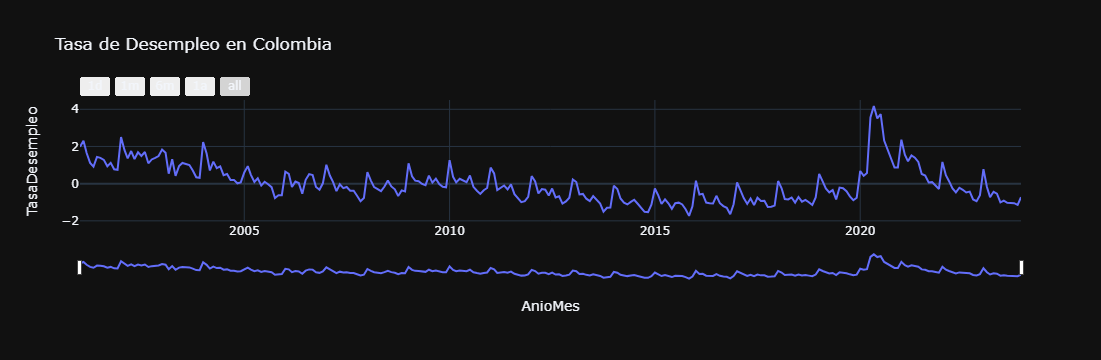

In [8]:
import plotly.express as px
fig = px.line(DataEst, y="TasaDesempleo",title="Tasa de Desempleo en Colombia",template='plotly_dark')#Se le puede quitar el modo oscuro si quiere
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1a", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

Creando los tensores con los retardos, trabajaremos con los 12 retardos a pesar de que en la parte descriptiva no los habíamos recomendado

In [9]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [24]:
Config = get_lagged_features(DataEst, n_steps, n_steps_ahead)
Config.shape

(264, 12, 1)

In [19]:
Partir = int(Config.shape[0]*0.8)

Entrenamiento

In [25]:
x_train = Config[:Partir]
y_train =  Desempleo.values[n_steps + n_steps_ahead - 1:Partir + n_steps + n_steps_ahead - 1]
y_train_timestamps = Desempleo.index[n_steps + n_steps_ahead - 1:Partir + n_steps + n_steps_ahead - 1]

Prueba

In [28]:
x_test = Config[Partir:]
y_test =  Desempleo.values[Partir + n_steps + n_steps_ahead - 1:]
y_test_timestamps = Desempleo.index[Partir + n_steps + n_steps_ahead - 1:]

In [29]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(211, 12, 1), (211, 1), (53, 12, 1), (53, 1)]


## Creación de las redes neuronales
Tres redes neuronales recurrentes serán implementadas, una simple, una GRU (Gated Recurrent Unit) y una LSTM (Long Short-Term Memory).

In [30]:
def SimpleRNN_(n_units, l1_reg, seed=1729):
  #def SimpleRNN_(n_units = 10, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def GRU_(n_units, l1_reg, seed=1729):
  #def GRU_(n_units = 10, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def LSTM_(n_units, l1_reg, seed=1729):
  #def LSTM_(n_units = 10,  seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

Definimos las épocas y mantenemos un batch de 12

In [31]:
max_epochs = 100 #Definimos 100 épocas
batch_size = 12# Mantenemos el tamaño del batch

In [32]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10, min_delta=1e-7, restore_best_weights=True)
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [33]:
do_training = False
#do_training = True

## Validación Cruzada

In [34]:
from scikeras.wrappers import KerasRegressor

In [35]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=0, n_units=10)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.8s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.4s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.4s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.4s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.4s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.4s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.4s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.4s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.5s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.8s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.6s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.5s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
3/3 - 3s - 1s/step - loss: 218.7562
Epoch 2/100
3/3 - 0s - 25ms/step - loss: 218.2261
Epoch 3/100
3/3 - 0s - 17ms/step - loss: 217.6957
Epoch 4/100
3/3 - 0s - 20ms/step - loss: 217.1692
Epoch 5/100
3/3 - 0s - 18ms/step - loss: 216.6437
Epoch 6/100
3/3 - 0s - 17ms/step - loss: 216.1143
Epoch 7/100
3/3 - 0s - 17ms/step - loss: 215.5946
Epoch 8/100
3/3 - 0s - 25ms/step - loss: 215.0683
Epoch 9/100
3/3 - 0s - 18ms/step - loss: 214.5403
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 214.0201
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 213.4958
Epoch 12/100
3/3 - 0s - 23ms/step - loss: 212.9759
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 212.4601
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 211.9344
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 211.4200
Epoch 16/100
3/3 - 0s - 23ms/step - loss: 210.8989
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 210.3865
Epoch 18/100
3/3 - 0s - 17ms/step - loss: 209.8713
Epoch 19/100
3/3 - 0s - 23ms/step - loss: 209.3516
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 4s - 682ms/step - loss: 210.8084
Epoch 2/100
6/6 - 0s - 14ms/step - loss: 210.3071
Epoch 3/100
6/6 - 0s - 17ms/step - loss: 209.2776
Epoch 4/100
6/6 - 0s - 42ms/step - loss: 208.2471
Epoch 5/100
6/6 - 0s - 15ms/step - loss: 207.2137
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 206.1931
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 205.1752
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 204.1498
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 203.1466
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 202.1291
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 201.1258
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 200.1307
Epoch 13/100
6/6 - 0s - 11ms/step - loss: 199.1268
Epoch 14/100
6/6 - 0s - 11ms/step - loss: 198.1425
Epoch 15/100
6/6 - 0s - 11ms/step - loss: 197.1469
Epoch 16/100
6/6 - 0s - 11ms/step - loss: 196.1573
Epoch 17/100
6/6 - 0s - 11ms/step - loss: 195.1785
Epoch 18/100
6/6 - 0s - 11ms/step - loss: 194.1967
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 193.2265
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 192.2581


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 4s - 390ms/step - loss: 196.8667
Epoch 2/100
9/9 - 0s - 11ms/step - loss: 195.3974
Epoch 3/100
9/9 - 0s - 9ms/step - loss: 193.9552
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 192.7345
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 191.8514
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 190.4534
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 189.0469
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 187.6523
Epoch 9/100
9/9 - 0s - 13ms/step - loss: 186.2575
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 184.8879
Epoch 11/100
9/9 - 0s - 9ms/step - loss: 183.5123
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 181.2872
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 179.8876
Epoch 14/100
9/9 - 0s - 18ms/step - loss: 177.5757
Epoch 15/100
9/9 - 0s - 10ms/step - loss: 176.1722
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 174.7785
Epoch 17/100
9/9 - 0s - 8ms/step - loss: 173.3964
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 172.0273
Epoch 19/100
9/9 - 0s - 11ms/step - loss: 170.6566
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 169.2927
Epoch 21/1

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 3s - 260ms/step - loss: 201.2904
Epoch 2/100
12/12 - 0s - 7ms/step - loss: 199.9111
Epoch 3/100
12/12 - 0s - 7ms/step - loss: 198.8425
Epoch 4/100
12/12 - 0s - 7ms/step - loss: 197.4948
Epoch 5/100
12/12 - 0s - 7ms/step - loss: 195.5074
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 190.3670
Epoch 7/100
12/12 - 0s - 7ms/step - loss: 186.6837
Epoch 8/100
12/12 - 0s - 14ms/step - loss: 184.6173
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 182.6228
Epoch 10/100
12/12 - 0s - 8ms/step - loss: 180.6829
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 179.0469
Epoch 12/100
12/12 - 0s - 10ms/step - loss: 177.1720
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 175.3964
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 177.6875
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 179.4167
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 180.1791
Epoch 17/100
12/12 - 0s - 8ms/step - loss: 180.9388
Epoch 18/100
12/12 - 0s - 15ms/step - loss: 179.3410
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 179.1056
Epoch 20/100
12/12 - 0s - 7m

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 244ms/step - loss: 233.2692
Epoch 2/100
15/15 - 0s - 7ms/step - loss: 238.1394
Epoch 3/100
15/15 - 0s - 12ms/step - loss: 240.1548
Epoch 4/100
15/15 - 0s - 6ms/step - loss: 239.2940
Epoch 5/100
15/15 - 0s - 6ms/step - loss: 237.0227
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 234.4209
Epoch 7/100
15/15 - 0s - 7ms/step - loss: 231.8285
Epoch 8/100
15/15 - 0s - 6ms/step - loss: 229.2751
Epoch 9/100
15/15 - 0s - 6ms/step - loss: 226.6403
Epoch 10/100
15/15 - 0s - 7ms/step - loss: 222.9132
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 220.1759
Epoch 12/100
15/15 - 0s - 7ms/step - loss: 217.5402
Epoch 13/100
15/15 - 0s - 6ms/step - loss: 214.3988
Epoch 14/100
15/15 - 0s - 6ms/step - loss: 211.7687
Epoch 15/100
15/15 - 0s - 7ms/step - loss: 209.2643
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 207.0894
Epoch 17/100
15/15 - 0s - 7ms/step - loss: 204.8422
Epoch 18/100
15/15 - 0s - 8ms/step - loss: 202.6404
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 200.3040
Epoch 20/100
15/15 - 0s - 10ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 2s - 828ms/step - loss: 287.1519
Epoch 2/100
3/3 - 0s - 24ms/step - loss: 286.0464
Epoch 3/100
3/3 - 0s - 17ms/step - loss: 284.9291
Epoch 4/100
3/3 - 0s - 20ms/step - loss: 283.8238
Epoch 5/100
3/3 - 0s - 18ms/step - loss: 282.7205
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 281.6122
Epoch 7/100
3/3 - 0s - 17ms/step - loss: 280.5099
Epoch 8/100
3/3 - 0s - 17ms/step - loss: 279.4197
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 278.3250
Epoch 10/100
3/3 - 0s - 17ms/step - loss: 277.2405
Epoch 11/100
3/3 - 0s - 16ms/step - loss: 276.1429
Epoch 12/100
3/3 - 0s - 18ms/step - loss: 275.0549
Epoch 13/100
3/3 - 0s - 25ms/step - loss: 273.9760
Epoch 14/100
3/3 - 0s - 19ms/step - loss: 272.8936
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 271.8177
Epoch 16/100
3/3 - 0s - 23ms/step - loss: 270.7502
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 269.6815
Epoch 18/100
3/3 - 0s - 21ms/step - loss: 268.6185
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 267.5440
Epoch 20/100
3/3 - 0s - 32ms/step - loss: 266.4920


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 3s - 512ms/step - loss: 286.6748
Epoch 2/100
6/6 - 0s - 11ms/step - loss: 281.0273
Epoch 3/100
6/6 - 0s - 12ms/step - loss: 274.2115
Epoch 4/100
6/6 - 0s - 9ms/step - loss: 269.0180
Epoch 5/100
6/6 - 0s - 11ms/step - loss: 265.5876
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 259.7091
Epoch 7/100
6/6 - 0s - 11ms/step - loss: 250.4064
Epoch 8/100
6/6 - 0s - 11ms/step - loss: 249.1814
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 245.5375
Epoch 10/100
6/6 - 0s - 11ms/step - loss: 241.8074
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 238.3196
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 240.5056
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 246.2528
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 252.1190
Epoch 15/100
6/6 - 0s - 11ms/step - loss: 254.2655
Epoch 16/100
6/6 - 0s - 11ms/step - loss: 255.0162
Epoch 17/100
6/6 - 0s - 11ms/step - loss: 259.1212
Epoch 18/100
6/6 - 0s - 11ms/step - loss: 258.2998
Epoch 19/100
6/6 - 0s - 11ms/step - loss: 257.3618
Epoch 20/100
6/6 - 0s - 11ms/step - loss: 256.3184
E

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 4s - 422ms/step - loss: 276.6439
Epoch 2/100
9/9 - 0s - 9ms/step - loss: 277.3624
Epoch 3/100
9/9 - 0s - 8ms/step - loss: 274.9668
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 271.4766
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 267.9406
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 264.6268
Epoch 7/100
9/9 - 0s - 9ms/step - loss: 262.1119
Epoch 8/100
9/9 - 0s - 9ms/step - loss: 259.5687
Epoch 9/100
9/9 - 0s - 9ms/step - loss: 256.4588
Epoch 10/100
9/9 - 0s - 9ms/step - loss: 253.5690
Epoch 11/100
9/9 - 0s - 9ms/step - loss: 250.4849
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 247.2949
Epoch 13/100
9/9 - 0s - 12ms/step - loss: 236.9224
Epoch 14/100
9/9 - 0s - 8ms/step - loss: 229.3209
Epoch 15/100
9/9 - 0s - 8ms/step - loss: 221.9289
Epoch 16/100
9/9 - 0s - 8ms/step - loss: 215.0064
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 212.2569
Epoch 18/100
9/9 - 0s - 7ms/step - loss: 208.1340
Epoch 19/100
9/9 - 0s - 8ms/step - loss: 207.2630
Epoch 20/100
9/9 - 0s - 8ms/step - loss: 204.8363
Epoch 21/100
9/9 -

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 4s - 322ms/step - loss: 131.5633
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 129.2490
Epoch 3/100
12/12 - 0s - 8ms/step - loss: 126.5896
Epoch 4/100
12/12 - 0s - 8ms/step - loss: 123.6858
Epoch 5/100
12/12 - 0s - 10ms/step - loss: 120.2696
Epoch 6/100
12/12 - 0s - 12ms/step - loss: 115.4027
Epoch 7/100
12/12 - 0s - 9ms/step - loss: 112.3656
Epoch 8/100
12/12 - 0s - 14ms/step - loss: 109.1573
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 106.8331
Epoch 10/100
12/12 - 0s - 7ms/step - loss: 106.0941
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 103.6845
Epoch 12/100
12/12 - 0s - 7ms/step - loss: 102.4733
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 98.6380
Epoch 14/100
12/12 - 0s - 7ms/step - loss: 96.8791
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 93.8641
Epoch 16/100
12/12 - 0s - 7ms/step - loss: 92.1124
Epoch 17/100
12/12 - 0s - 7ms/step - loss: 90.0217
Epoch 18/100
12/12 - 0s - 7ms/step - loss: 87.5298
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 85.5052
Epoch 20/100
12/12 - 0s - 7ms/step 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 234ms/step - loss: 143.4468
Epoch 2/100
15/15 - 0s - 10ms/step - loss: 136.5361
Epoch 3/100
15/15 - 0s - 12ms/step - loss: 130.9804
Epoch 4/100
15/15 - 0s - 7ms/step - loss: 132.6907
Epoch 5/100
15/15 - 0s - 7ms/step - loss: 148.1813
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 150.5684
Epoch 7/100
15/15 - 0s - 7ms/step - loss: 160.8544
Epoch 8/100
15/15 - 0s - 6ms/step - loss: 168.1192
Epoch 9/100
15/15 - 0s - 11ms/step - loss: 170.5174
Epoch 10/100
15/15 - 0s - 7ms/step - loss: 170.5798
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 169.1726
Epoch 12/100
15/15 - 0s - 8ms/step - loss: 167.8947
Epoch 13/100
15/15 - 0s - 8ms/step - loss: 165.7196
Epoch 14/100
15/15 - 0s - 7ms/step - loss: 162.2192
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 159.7466
Epoch 16/100
15/15 - 0s - 7ms/step - loss: 155.4201
Epoch 17/100
15/15 - 0s - 11ms/step - loss: 153.3414
Epoch 18/100
15/15 - 0s - 6ms/step - loss: 150.6578
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 146.5984
Epoch 20/100
15/15 - 0s - 6

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 876ms/step - loss: 275.2412
Epoch 2/100
3/3 - 0s - 24ms/step - loss: 273.2182
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 270.5947
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 269.8033
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 268.8023
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 267.7856
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 266.7831
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 265.7572
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 264.7705
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 263.7289
Epoch 11/100
3/3 - 0s - 27ms/step - loss: 262.7310
Epoch 12/100
3/3 - 0s - 28ms/step - loss: 261.7610
Epoch 13/100
3/3 - 0s - 23ms/step - loss: 260.7762
Epoch 14/100
3/3 - 0s - 28ms/step - loss: 259.7516
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 258.7419
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 257.7526
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 256.7664
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 255.7718
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 252.9141
Epoch 20/100
3/3 - 0s - 29ms/step - loss: 240.9918


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 3s - 499ms/step - loss: 174.6284
Epoch 2/100
6/6 - 0s - 10ms/step - loss: 177.9906
Epoch 3/100
6/6 - 0s - 11ms/step - loss: 180.6802
Epoch 4/100
6/6 - 0s - 11ms/step - loss: 182.3887
Epoch 5/100
6/6 - 0s - 11ms/step - loss: 173.0492
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 154.7651
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 149.2861
Epoch 8/100
6/6 - 0s - 11ms/step - loss: 142.8004
Epoch 9/100
6/6 - 0s - 11ms/step - loss: 139.8543
Epoch 10/100
6/6 - 0s - 11ms/step - loss: 136.8848
Epoch 11/100
6/6 - 0s - 11ms/step - loss: 135.3477
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 131.7196
Epoch 13/100
6/6 - 0s - 10ms/step - loss: 128.2654
Epoch 14/100
6/6 - 0s - 12ms/step - loss: 125.7383
Epoch 15/100
6/6 - 0s - 11ms/step - loss: 123.1911
Epoch 16/100
6/6 - 0s - 11ms/step - loss: 120.6787
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 118.2802
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 115.9455
Epoch 19/100
6/6 - 0s - 11ms/step - loss: 112.7316
Epoch 20/100
6/6 - 0s - 11ms/step - loss: 110.4744


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 4s - 413ms/step - loss: 197.0546
Epoch 2/100
9/9 - 0s - 9ms/step - loss: 191.3222
Epoch 3/100
9/9 - 0s - 9ms/step - loss: 185.8071
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 181.2622
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 175.2971
Epoch 6/100
9/9 - 0s - 8ms/step - loss: 171.4261
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 168.0331
Epoch 8/100
9/9 - 0s - 7ms/step - loss: 163.8788
Epoch 9/100
9/9 - 0s - 9ms/step - loss: 161.6854
Epoch 10/100
9/9 - 0s - 9ms/step - loss: 157.1801
Epoch 11/100
9/9 - 0s - 8ms/step - loss: 151.7433
Epoch 12/100
9/9 - 0s - 8ms/step - loss: 149.6036
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 146.7939
Epoch 14/100
9/9 - 0s - 8ms/step - loss: 146.3960
Epoch 15/100
9/9 - 0s - 7ms/step - loss: 146.6913
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 142.2326
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 139.7226
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 137.6724
Epoch 19/100
9/9 - 0s - 8ms/step - loss: 135.1846
Epoch 20/100
9/9 - 0s - 7ms/step - loss: 133.2827
Epoch 21/100
9/9

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 4s - 312ms/step - loss: 202.8667
Epoch 2/100
12/12 - 0s - 6ms/step - loss: 200.2402
Epoch 3/100
12/12 - 0s - 6ms/step - loss: 196.5656
Epoch 4/100
12/12 - 0s - 7ms/step - loss: 194.0274
Epoch 5/100
12/12 - 0s - 7ms/step - loss: 188.4681
Epoch 6/100
12/12 - 0s - 7ms/step - loss: 188.8335
Epoch 7/100
12/12 - 0s - 7ms/step - loss: 187.8536
Epoch 8/100
12/12 - 0s - 7ms/step - loss: 183.6772
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 179.8878
Epoch 10/100
12/12 - 0s - 7ms/step - loss: 174.7960
Epoch 11/100
12/12 - 0s - 7ms/step - loss: 170.6881
Epoch 12/100
12/12 - 0s - 7ms/step - loss: 165.8320
Epoch 13/100
12/12 - 0s - 7ms/step - loss: 160.0812
Epoch 14/100
12/12 - 0s - 6ms/step - loss: 155.0934
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 148.3025
Epoch 16/100
12/12 - 0s - 6ms/step - loss: 142.8079
Epoch 17/100
12/12 - 0s - 7ms/step - loss: 138.7379
Epoch 18/100
12/12 - 0s - 7ms/step - loss: 135.5195
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 131.4387
Epoch 20/100
12/12 - 0s - 7ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 256ms/step - loss: 175.1544
Epoch 2/100
15/15 - 0s - 7ms/step - loss: 172.2077
Epoch 3/100
15/15 - 0s - 8ms/step - loss: 163.4705
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 160.9690
Epoch 5/100
15/15 - 0s - 9ms/step - loss: 158.5578
Epoch 6/100
15/15 - 0s - 9ms/step - loss: 155.0158
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 154.6924
Epoch 8/100
15/15 - 0s - 8ms/step - loss: 156.1660
Epoch 9/100
15/15 - 0s - 7ms/step - loss: 155.7571
Epoch 10/100
15/15 - 0s - 8ms/step - loss: 159.5132
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 160.9035
Epoch 12/100
15/15 - 0s - 12ms/step - loss: 153.2245
Epoch 13/100
15/15 - 0s - 8ms/step - loss: 150.5666
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 145.6872
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 144.8651
Epoch 16/100
15/15 - 0s - 7ms/step - loss: 147.1145
Epoch 17/100
15/15 - 0s - 7ms/step - loss: 174.7760
Epoch 18/100
15/15 - 0s - 12ms/step - loss: 179.6917
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 177.4717
Epoch 20/100
15/15 - 0s - 7ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 986ms/step - loss: 301.6642
Epoch 2/100
3/3 - 0s - 16ms/step - loss: 301.0942
Epoch 3/100
3/3 - 0s - 17ms/step - loss: 300.5233
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 299.9610
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 299.3915
Epoch 6/100
3/3 - 0s - 17ms/step - loss: 298.8219
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 298.2799
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 297.7032
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 297.1458
Epoch 10/100
3/3 - 0s - 27ms/step - loss: 296.5961
Epoch 11/100
3/3 - 0s - 59ms/step - loss: 296.0378
Epoch 12/100
3/3 - 0s - 56ms/step - loss: 295.4621
Epoch 13/100
3/3 - 0s - 19ms/step - loss: 294.9169
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 294.3649
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 293.8103
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 293.2351
Epoch 17/100
3/3 - 0s - 24ms/step - loss: 292.6903
Epoch 18/100
3/3 - 0s - 21ms/step - loss: 292.1363
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 291.5871
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 291.0469


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 3s - 513ms/step - loss: 262.3915
Epoch 2/100
6/6 - 0s - 11ms/step - loss: 262.5729
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 261.4139
Epoch 4/100
6/6 - 0s - 11ms/step - loss: 260.2682
Epoch 5/100
6/6 - 0s - 11ms/step - loss: 259.1205
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 257.9842
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 256.8445
Epoch 8/100
6/6 - 0s - 11ms/step - loss: 255.7077
Epoch 9/100
6/6 - 0s - 11ms/step - loss: 254.5778
Epoch 10/100
6/6 - 0s - 11ms/step - loss: 253.4458
Epoch 11/100
6/6 - 0s - 11ms/step - loss: 252.3235
Epoch 12/100
6/6 - 0s - 10ms/step - loss: 251.2084
Epoch 13/100
6/6 - 0s - 11ms/step - loss: 250.0940
Epoch 14/100
6/6 - 0s - 11ms/step - loss: 248.9800
Epoch 15/100
6/6 - 0s - 11ms/step - loss: 247.8790
Epoch 16/100
6/6 - 0s - 9ms/step - loss: 246.7662
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 245.1440
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 244.0408
Epoch 19/100
6/6 - 0s - 11ms/step - loss: 242.9456
Epoch 20/100
6/6 - 0s - 11ms/step - loss: 241.8483
E

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 3s - 339ms/step - loss: 135.4771
Epoch 2/100
9/9 - 0s - 8ms/step - loss: 133.6527
Epoch 3/100
9/9 - 0s - 8ms/step - loss: 132.4401
Epoch 4/100
9/9 - 0s - 8ms/step - loss: 131.2461
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 130.0586
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 128.8867
Epoch 7/100
9/9 - 0s - 9ms/step - loss: 126.3802
Epoch 8/100
9/9 - 0s - 8ms/step - loss: 125.1957
Epoch 9/100
9/9 - 0s - 7ms/step - loss: 124.0135
Epoch 10/100
9/9 - 0s - 8ms/step - loss: 122.8396
Epoch 11/100
9/9 - 0s - 7ms/step - loss: 121.6652
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 120.5146
Epoch 13/100
9/9 - 0s - 7ms/step - loss: 119.3694
Epoch 14/100
9/9 - 0s - 8ms/step - loss: 118.2234
Epoch 15/100
9/9 - 0s - 8ms/step - loss: 117.8256
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 116.7246
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 115.8708
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 114.7772
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 113.6991
Epoch 20/100
9/9 - 0s - 10ms/step - loss: 112.6259
Epoch 21/100
9/9 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 4s - 312ms/step - loss: 169.2946
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 167.3844
Epoch 3/100
12/12 - 0s - 8ms/step - loss: 165.6272
Epoch 4/100
12/12 - 0s - 7ms/step - loss: 163.8757
Epoch 5/100
12/12 - 0s - 7ms/step - loss: 161.4561
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 159.3894
Epoch 7/100
12/12 - 0s - 7ms/step - loss: 157.6227
Epoch 8/100
12/12 - 0s - 7ms/step - loss: 156.8808
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 155.1430
Epoch 10/100
12/12 - 0s - 7ms/step - loss: 153.8793
Epoch 11/100
12/12 - 0s - 7ms/step - loss: 152.1758
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 150.4747
Epoch 13/100
12/12 - 0s - 7ms/step - loss: 148.8003
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 146.8275
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 145.0100
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 143.3962
Epoch 17/100
12/12 - 0s - 7ms/step - loss: 141.8202
Epoch 18/100
12/12 - 0s - 6ms/step - loss: 140.0404
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 138.5001
Epoch 20/100
12/12 - 0s - 7ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 260ms/step - loss: 186.1790
Epoch 2/100
15/15 - 0s - 12ms/step - loss: 184.6190
Epoch 3/100
15/15 - 0s - 22ms/step - loss: 182.9230
Epoch 4/100
15/15 - 0s - 7ms/step - loss: 181.2827
Epoch 5/100
15/15 - 0s - 8ms/step - loss: 179.9006
Epoch 6/100
15/15 - 0s - 7ms/step - loss: 178.4532
Epoch 7/100
15/15 - 0s - 7ms/step - loss: 176.8807
Epoch 8/100
15/15 - 0s - 6ms/step - loss: 175.7249
Epoch 9/100
15/15 - 0s - 6ms/step - loss: 173.0365
Epoch 10/100
15/15 - 0s - 6ms/step - loss: 170.6392
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 168.3403
Epoch 12/100
15/15 - 0s - 6ms/step - loss: 165.9142
Epoch 13/100
15/15 - 0s - 6ms/step - loss: 163.3250
Epoch 14/100
15/15 - 0s - 7ms/step - loss: 161.1887
Epoch 15/100
15/15 - 0s - 6ms/step - loss: 159.3535
Epoch 16/100
15/15 - 0s - 6ms/step - loss: 157.1224
Epoch 17/100
15/15 - 0s - 6ms/step - loss: 154.4133
Epoch 18/100
15/15 - 0s - 7ms/step - loss: 151.7108
Epoch 19/100
15/15 - 0s - 6ms/step - loss: 149.5049
Epoch 20/100
15/15 - 0s - 7ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 1s/step - loss: 190.5876
Epoch 2/100
3/3 - 0s - 27ms/step - loss: 189.6869
Epoch 3/100
3/3 - 0s - 17ms/step - loss: 188.7812
Epoch 4/100
3/3 - 0s - 23ms/step - loss: 187.8836
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 186.9823
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 186.0954
Epoch 7/100
3/3 - 0s - 23ms/step - loss: 185.1966
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 184.3162
Epoch 9/100
3/3 - 0s - 23ms/step - loss: 183.4313
Epoch 10/100
3/3 - 0s - 27ms/step - loss: 182.5437
Epoch 11/100
3/3 - 0s - 28ms/step - loss: 181.6548
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 180.7878
Epoch 13/100
3/3 - 0s - 28ms/step - loss: 179.9124
Epoch 14/100
3/3 - 0s - 23ms/step - loss: 179.0398
Epoch 15/100
3/3 - 0s - 24ms/step - loss: 178.1801
Epoch 16/100
3/3 - 0s - 26ms/step - loss: 177.3109
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 176.4438
Epoch 18/100
3/3 - 0s - 28ms/step - loss: 175.5888
Epoch 19/100
3/3 - 0s - 23ms/step - loss: 174.7388
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 173.8846
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 3s - 543ms/step - loss: 205.2801
Epoch 2/100
6/6 - 0s - 11ms/step - loss: 203.3691
Epoch 3/100
6/6 - 0s - 11ms/step - loss: 202.1531
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 200.5524
Epoch 5/100
6/6 - 0s - 15ms/step - loss: 198.7574
Epoch 6/100
6/6 - 0s - 12ms/step - loss: 197.1586
Epoch 7/100
6/6 - 0s - 12ms/step - loss: 195.0571
Epoch 8/100
6/6 - 0s - 12ms/step - loss: 193.1476
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 191.1118
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 188.4857
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 185.8783
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 184.2299
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 180.8095
Epoch 14/100
6/6 - 0s - 11ms/step - loss: 178.4266
Epoch 15/100
6/6 - 0s - 11ms/step - loss: 177.1534
Epoch 16/100
6/6 - 0s - 12ms/step - loss: 175.4044
Epoch 17/100
6/6 - 0s - 13ms/step - loss: 173.0349
Epoch 18/100
6/6 - 0s - 11ms/step - loss: 170.6768
Epoch 19/100
6/6 - 0s - 12ms/step - loss: 168.9571
Epoch 20/100
6/6 - 0s - 10ms/step - loss: 167.2528


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 4s - 437ms/step - loss: 198.7304
Epoch 2/100
9/9 - 0s - 8ms/step - loss: 197.8457
Epoch 3/100
9/9 - 0s - 8ms/step - loss: 196.5485
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 195.1084
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 191.5628
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 189.2053
Epoch 7/100
9/9 - 0s - 8ms/step - loss: 183.2385
Epoch 8/100
9/9 - 0s - 9ms/step - loss: 182.5755
Epoch 9/100
9/9 - 0s - 9ms/step - loss: 178.9622
Epoch 10/100
9/9 - 0s - 9ms/step - loss: 176.5505
Epoch 11/100
9/9 - 0s - 7ms/step - loss: 174.3369
Epoch 12/100
9/9 - 0s - 8ms/step - loss: 171.7419
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 169.7662
Epoch 14/100
9/9 - 0s - 8ms/step - loss: 168.5664
Epoch 15/100
9/9 - 0s - 9ms/step - loss: 166.8482
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 165.5526
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 164.4920
Epoch 18/100
9/9 - 0s - 8ms/step - loss: 162.9130
Epoch 19/100
9/9 - 0s - 8ms/step - loss: 161.2109
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 159.1905
Epoch 21/100
9/9 -

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 3s - 260ms/step - loss: 198.6336
Epoch 2/100
12/12 - 0s - 7ms/step - loss: 195.7486
Epoch 3/100
12/12 - 0s - 7ms/step - loss: 193.0251
Epoch 4/100
12/12 - 0s - 7ms/step - loss: 191.1644
Epoch 5/100
12/12 - 0s - 7ms/step - loss: 187.8882
Epoch 6/100
12/12 - 0s - 7ms/step - loss: 185.0201
Epoch 7/100
12/12 - 0s - 7ms/step - loss: 182.0605
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 179.1517
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 176.3385
Epoch 10/100
12/12 - 0s - 7ms/step - loss: 173.7925
Epoch 11/100
12/12 - 0s - 7ms/step - loss: 171.3252
Epoch 12/100
12/12 - 0s - 7ms/step - loss: 169.7332
Epoch 13/100
12/12 - 0s - 7ms/step - loss: 168.1541
Epoch 14/100
12/12 - 0s - 7ms/step - loss: 167.5348
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 165.4210
Epoch 16/100
12/12 - 0s - 7ms/step - loss: 163.3265
Epoch 17/100
12/12 - 0s - 6ms/step - loss: 161.1449
Epoch 18/100
12/12 - 0s - 6ms/step - loss: 154.9401
Epoch 19/100
12/12 - 0s - 5ms/step - loss: 150.4357
Epoch 20/100
12/12 - 0s - 7ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 234ms/step - loss: 150.0325
Epoch 2/100
15/15 - 0s - 7ms/step - loss: 146.9704
Epoch 3/100
15/15 - 0s - 7ms/step - loss: 144.1337
Epoch 4/100
15/15 - 0s - 7ms/step - loss: 140.9089
Epoch 5/100
15/15 - 0s - 7ms/step - loss: 137.7020
Epoch 6/100
15/15 - 0s - 6ms/step - loss: 134.2639
Epoch 7/100
15/15 - 0s - 7ms/step - loss: 130.7540
Epoch 8/100
15/15 - 0s - 7ms/step - loss: 127.1482
Epoch 9/100
15/15 - 0s - 6ms/step - loss: 123.9607
Epoch 10/100
15/15 - 0s - 7ms/step - loss: 120.1367
Epoch 11/100
15/15 - 0s - 6ms/step - loss: 116.6524
Epoch 12/100
15/15 - 0s - 6ms/step - loss: 114.8803
Epoch 13/100
15/15 - 0s - 7ms/step - loss: 112.7743
Epoch 14/100
15/15 - 0s - 7ms/step - loss: 110.4126
Epoch 15/100
15/15 - 0s - 7ms/step - loss: 107.6526
Epoch 16/100
15/15 - 0s - 7ms/step - loss: 105.7608
Epoch 17/100
15/15 - 0s - 6ms/step - loss: 103.6888
Epoch 18/100
15/15 - 0s - 6ms/step - loss: 100.9288
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 97.4273
Epoch 20/100
15/15 - 0s - 7ms/st

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 1s/step - loss: 301.3416
Epoch 2/100
3/3 - 0s - 25ms/step - loss: 298.5029
Epoch 3/100
3/3 - 0s - 23ms/step - loss: 299.1431
Epoch 4/100
3/3 - 0s - 17ms/step - loss: 297.1067
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 294.4754
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 292.4422
Epoch 7/100
3/3 - 0s - 17ms/step - loss: 290.4183
Epoch 8/100
3/3 - 0s - 17ms/step - loss: 288.1172
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 288.0550
Epoch 10/100
3/3 - 0s - 17ms/step - loss: 285.9905
Epoch 11/100
3/3 - 0s - 17ms/step - loss: 285.5144
Epoch 12/100
3/3 - 0s - 17ms/step - loss: 283.3912
Epoch 13/100
3/3 - 0s - 17ms/step - loss: 281.2383
Epoch 14/100
3/3 - 0s - 17ms/step - loss: 279.1451
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 277.0089
Epoch 16/100
3/3 - 0s - 17ms/step - loss: 274.9015
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 272.8059
Epoch 18/100
3/3 - 0s - 17ms/step - loss: 270.7177
Epoch 19/100
3/3 - 0s - 24ms/step - loss: 268.6419
Epoch 20/100
3/3 - 0s - 19ms/step - loss: 266.5816
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 3s - 507ms/step - loss: 199.6806
Epoch 2/100
6/6 - 0s - 29ms/step - loss: 197.3734
Epoch 3/100
6/6 - 0s - 12ms/step - loss: 194.6355
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 191.3451
Epoch 5/100
6/6 - 0s - 11ms/step - loss: 188.1854
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 188.9359
Epoch 7/100
6/6 - 0s - 9ms/step - loss: 218.8997
Epoch 8/100
6/6 - 0s - 11ms/step - loss: 223.2289
Epoch 9/100
6/6 - 0s - 11ms/step - loss: 220.6712
Epoch 10/100
6/6 - 0s - 11ms/step - loss: 218.4607
Epoch 11/100
6/6 - 0s - 9ms/step - loss: 217.3206
Epoch 12/100
6/6 - 0s - 11ms/step - loss: 214.6016
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 211.5202
Epoch 14/100
6/6 - 0s - 15ms/step - loss: 207.4960
Epoch 15/100
6/6 - 0s - 12ms/step - loss: 204.3887
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 204.7561
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 201.7384
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 197.9910
Epoch 19/100
6/6 - 0s - 11ms/step - loss: 193.6955
Epoch 20/100
6/6 - 0s - 16ms/step - loss: 190.7943
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 3s - 340ms/step - loss: 254.7108
Epoch 2/100
9/9 - 0s - 7ms/step - loss: 249.4815
Epoch 3/100
9/9 - 0s - 8ms/step - loss: 243.1597
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 236.8052
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 231.5211
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 226.5862
Epoch 7/100
9/9 - 0s - 9ms/step - loss: 221.1434
Epoch 8/100
9/9 - 0s - 9ms/step - loss: 216.1484
Epoch 9/100
9/9 - 0s - 8ms/step - loss: 211.4265
Epoch 10/100
9/9 - 0s - 8ms/step - loss: 205.9473
Epoch 11/100
9/9 - 0s - 10ms/step - loss: 200.5099
Epoch 12/100
9/9 - 0s - 8ms/step - loss: 194.8425
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 189.6591
Epoch 14/100
9/9 - 0s - 9ms/step - loss: 185.2296
Epoch 15/100
9/9 - 0s - 8ms/step - loss: 180.8509
Epoch 16/100
9/9 - 0s - 8ms/step - loss: 176.5812
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 177.1541
Epoch 18/100
9/9 - 0s - 8ms/step - loss: 173.5127
Epoch 19/100
9/9 - 0s - 7ms/step - loss: 163.7406
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 161.0567
Epoch 21/100
9/9 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 3s - 256ms/step - loss: 179.3201
Epoch 2/100
12/12 - 0s - 6ms/step - loss: 182.2401
Epoch 3/100
12/12 - 0s - 7ms/step - loss: 183.3121
Epoch 4/100
12/12 - 0s - 7ms/step - loss: 180.9692
Epoch 5/100
12/12 - 0s - 7ms/step - loss: 176.5085
Epoch 6/100
12/12 - 0s - 7ms/step - loss: 174.6965
Epoch 7/100
12/12 - 0s - 7ms/step - loss: 176.7535
Epoch 8/100
12/12 - 0s - 7ms/step - loss: 182.7271
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 184.0644
Epoch 10/100
12/12 - 0s - 7ms/step - loss: 183.3724
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 184.4576
Epoch 12/100
12/12 - 0s - 7ms/step - loss: 192.3374
Epoch 13/100
12/12 - 0s - 7ms/step - loss: 191.7720
Epoch 14/100
12/12 - 0s - 7ms/step - loss: 188.0068
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 183.4586
Epoch 16/100
12/12 - 0s - 7ms/step - loss: 184.4339
Epoch 17/100
12/12 - 0s - 7ms/step - loss: 192.4625
Epoch 18/100
12/12 - 0s - 7ms/step - loss: 194.6475
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 191.7319
Epoch 20/100
12/12 - 0s - 7ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 3s - 227ms/step - loss: 153.5349
Epoch 2/100
15/15 - 0s - 6ms/step - loss: 133.6159
Epoch 3/100
15/15 - 0s - 6ms/step - loss: 125.4089
Epoch 4/100
15/15 - 0s - 7ms/step - loss: 119.5198
Epoch 5/100
15/15 - 0s - 7ms/step - loss: 115.0950
Epoch 6/100
15/15 - 0s - 7ms/step - loss: 116.0934
Epoch 7/100
15/15 - 0s - 6ms/step - loss: 111.7811
Epoch 8/100
15/15 - 0s - 6ms/step - loss: 113.5744
Epoch 9/100
15/15 - 0s - 7ms/step - loss: 127.0459
Epoch 10/100
15/15 - 0s - 7ms/step - loss: 164.7032
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 164.4901
Epoch 12/100
15/15 - 0s - 7ms/step - loss: 161.8622
Epoch 13/100
15/15 - 0s - 7ms/step - loss: 164.3619
Epoch 14/100
15/15 - 0s - 7ms/step - loss: 170.1685
Epoch 15/100
15/15 - 0s - 11ms/step - loss: 174.0432
Epoch 16/100
15/15 - 0s - 6ms/step - loss: 177.6513
Epoch 17/100
15/15 - 0s - 7ms/step - loss: 177.1016
Epoch 18/100
15/15 - 0s - 7ms/step - loss: 173.7063
Epoch 19/100
15/15 - 0s - 6ms/step - loss: 163.0127
Epoch 20/100
15/15 - 0s - 6ms/

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 1s/step - loss: 280.9196
Epoch 2/100
3/3 - 0s - 27ms/step - loss: 280.3824
Epoch 3/100
3/3 - 0s - 17ms/step - loss: 279.8540
Epoch 4/100
3/3 - 0s - 27ms/step - loss: 279.3077
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 278.7794
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 278.2289
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 277.6974
Epoch 8/100
3/3 - 0s - 17ms/step - loss: 277.1714
Epoch 9/100
3/3 - 0s - 17ms/step - loss: 276.6312
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 276.1129
Epoch 11/100
3/3 - 0s - 17ms/step - loss: 275.5610
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 275.0380
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 274.5001
Epoch 14/100
3/3 - 0s - 17ms/step - loss: 273.9811
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 273.4585
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 272.9313
Epoch 17/100
3/3 - 0s - 17ms/step - loss: 272.4152
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 271.8790
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 271.3466
Epoch 20/100
3/3 - 0s - 17ms/step - loss: 270.8366
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 3s - 515ms/step - loss: 299.3648
Epoch 2/100
6/6 - 0s - 14ms/step - loss: 298.8963
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 297.6543
Epoch 4/100
6/6 - 0s - 11ms/step - loss: 296.4153
Epoch 5/100
6/6 - 0s - 11ms/step - loss: 295.1835
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 293.9418
Epoch 7/100
6/6 - 0s - 13ms/step - loss: 292.7192
Epoch 8/100
6/6 - 0s - 11ms/step - loss: 291.4989
Epoch 9/100
6/6 - 0s - 11ms/step - loss: 290.2723
Epoch 10/100
6/6 - 0s - 11ms/step - loss: 289.0666
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 287.8431
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 286.6389
Epoch 13/100
6/6 - 0s - 25ms/step - loss: 285.4327
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 284.2379
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 283.0439
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 281.8465
Epoch 17/100
6/6 - 0s - 11ms/step - loss: 280.6644
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 279.4782
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 278.3073
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 277.1259


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 3s - 323ms/step - loss: 177.8086
Epoch 2/100
9/9 - 0s - 7ms/step - loss: 176.1019
Epoch 3/100
9/9 - 0s - 9ms/step - loss: 174.7038
Epoch 4/100
9/9 - 0s - 8ms/step - loss: 173.3040
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 171.9144
Epoch 6/100
9/9 - 0s - 8ms/step - loss: 170.5362
Epoch 7/100
9/9 - 0s - 8ms/step - loss: 169.1764
Epoch 8/100
9/9 - 0s - 9ms/step - loss: 170.5751
Epoch 9/100
9/9 - 0s - 9ms/step - loss: 173.0828
Epoch 10/100
9/9 - 0s - 9ms/step - loss: 174.8742
Epoch 11/100
9/9 - 0s - 8ms/step - loss: 172.6163
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 168.8126
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 167.4530
Epoch 14/100
9/9 - 0s - 7ms/step - loss: 164.9893
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 161.5573
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 159.7979
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 157.9049
Epoch 18/100
9/9 - 0s - 7ms/step - loss: 156.6203
Epoch 19/100
9/9 - 0s - 8ms/step - loss: 154.2765
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 153.3810
Epoch 21/100
9/9 -

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 4s - 332ms/step - loss: 209.4060
Epoch 2/100
12/12 - 0s - 7ms/step - loss: 207.6270
Epoch 3/100
12/12 - 0s - 8ms/step - loss: 205.9121
Epoch 4/100
12/12 - 0s - 7ms/step - loss: 204.3391
Epoch 5/100
12/12 - 0s - 7ms/step - loss: 202.7975
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 201.4344
Epoch 7/100
12/12 - 0s - 7ms/step - loss: 199.8878
Epoch 8/100
12/12 - 0s - 7ms/step - loss: 198.7129
Epoch 9/100
12/12 - 0s - 8ms/step - loss: 197.0710
Epoch 10/100
12/12 - 0s - 7ms/step - loss: 195.3743
Epoch 11/100
12/12 - 0s - 7ms/step - loss: 193.6216
Epoch 12/100
12/12 - 0s - 7ms/step - loss: 191.4463
Epoch 13/100
12/12 - 0s - 7ms/step - loss: 189.5031
Epoch 14/100
12/12 - 0s - 7ms/step - loss: 186.9612
Epoch 15/100
12/12 - 0s - 14ms/step - loss: 184.7844
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 182.8280
Epoch 17/100
12/12 - 0s - 7ms/step - loss: 180.9495
Epoch 18/100
12/12 - 0s - 6ms/step - loss: 178.9971
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 177.2117
Epoch 20/100
12/12 - 0s - 6ms/

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 3s - 223ms/step - loss: 129.4538
Epoch 2/100
15/15 - 0s - 6ms/step - loss: 127.5698
Epoch 3/100
15/15 - 0s - 7ms/step - loss: 125.3888
Epoch 4/100
15/15 - 0s - 7ms/step - loss: 123.4570
Epoch 5/100
15/15 - 0s - 6ms/step - loss: 121.2679
Epoch 6/100
15/15 - 0s - 6ms/step - loss: 119.0579
Epoch 7/100
15/15 - 0s - 7ms/step - loss: 116.4471
Epoch 8/100
15/15 - 0s - 7ms/step - loss: 114.2050
Epoch 9/100
15/15 - 0s - 6ms/step - loss: 111.2296
Epoch 10/100
15/15 - 0s - 6ms/step - loss: 107.8482
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 105.9063
Epoch 12/100
15/15 - 0s - 7ms/step - loss: 101.5877
Epoch 13/100
15/15 - 0s - 6ms/step - loss: 99.9627
Epoch 14/100
15/15 - 0s - 6ms/step - loss: 96.5144
Epoch 15/100
15/15 - 0s - 6ms/step - loss: 94.3961
Epoch 16/100
15/15 - 0s - 7ms/step - loss: 92.2968
Epoch 17/100
15/15 - 0s - 7ms/step - loss: 90.6082
Epoch 18/100
15/15 - 0s - 7ms/step - loss: 88.0702
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 85.7712
Epoch 20/100
15/15 - 0s - 6ms/step - l

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 950ms/step - loss: 204.5522
Epoch 2/100
3/3 - 0s - 20ms/step - loss: 203.6129
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 202.6833
Epoch 4/100
3/3 - 0s - 17ms/step - loss: 201.7419
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 200.8123
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 199.8946
Epoch 7/100
3/3 - 0s - 17ms/step - loss: 198.9572
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 198.0372
Epoch 9/100
3/3 - 0s - 17ms/step - loss: 197.1241
Epoch 10/100
3/3 - 0s - 17ms/step - loss: 196.2037
Epoch 11/100
3/3 - 0s - 19ms/step - loss: 195.2842
Epoch 12/100
3/3 - 0s - 18ms/step - loss: 194.3856
Epoch 13/100
3/3 - 0s - 17ms/step - loss: 193.4697
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 192.5672
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 191.6656
Epoch 16/100
3/3 - 0s - 17ms/step - loss: 190.7711
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 189.8757
Epoch 18/100
3/3 - 0s - 17ms/step - loss: 188.9795
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 188.0933
Epoch 20/100
3/3 - 0s - 17ms/step - loss: 187.2064


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 3s - 558ms/step - loss: 204.6648
Epoch 2/100
6/6 - 0s - 15ms/step - loss: 203.4802
Epoch 3/100
6/6 - 0s - 11ms/step - loss: 202.7828
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 201.0781
Epoch 5/100
6/6 - 0s - 11ms/step - loss: 199.2330
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 198.6138
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 196.6355
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 195.9382
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 193.9815
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 193.5025
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 192.6987
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 191.6788
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 190.5415
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 189.4299
Epoch 15/100
6/6 - 0s - 11ms/step - loss: 188.3187
Epoch 16/100
6/6 - 0s - 11ms/step - loss: 187.2188
Epoch 17/100
6/6 - 0s - 11ms/step - loss: 187.2808
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 186.1811
Epoch 19/100
6/6 - 0s - 11ms/step - loss: 185.8199
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 184.7433


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 3s - 333ms/step - loss: 160.4191
Epoch 2/100
9/9 - 0s - 10ms/step - loss: 158.2467
Epoch 3/100
9/9 - 0s - 8ms/step - loss: 155.0193
Epoch 4/100
9/9 - 0s - 7ms/step - loss: 153.4571
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 151.2037
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 150.3214
Epoch 7/100
9/9 - 0s - 9ms/step - loss: 148.9318
Epoch 8/100
9/9 - 0s - 10ms/step - loss: 144.3572
Epoch 9/100
9/9 - 0s - 7ms/step - loss: 142.8629
Epoch 10/100
9/9 - 0s - 8ms/step - loss: 137.9192
Epoch 11/100
9/9 - 0s - 8ms/step - loss: 138.2106
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 133.9256
Epoch 13/100
9/9 - 0s - 10ms/step - loss: 132.2321
Epoch 14/100
9/9 - 0s - 8ms/step - loss: 129.7962
Epoch 15/100
9/9 - 0s - 8ms/step - loss: 125.7180
Epoch 16/100
9/9 - 0s - 8ms/step - loss: 124.8768
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 122.0381
Epoch 18/100
9/9 - 0s - 9ms/step - loss: 119.5174
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 117.6351
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 115.7414
Epoch 21/100
9/9

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 3s - 244ms/step - loss: 244.3289
Epoch 2/100
12/12 - 0s - 9ms/step - loss: 240.0878
Epoch 3/100
12/12 - 0s - 7ms/step - loss: 236.4711
Epoch 4/100
12/12 - 0s - 7ms/step - loss: 232.9295
Epoch 5/100
12/12 - 0s - 7ms/step - loss: 228.2120
Epoch 6/100
12/12 - 0s - 7ms/step - loss: 224.3276
Epoch 7/100
12/12 - 0s - 16ms/step - loss: 221.3756
Epoch 8/100
12/12 - 0s - 9ms/step - loss: 218.0354
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 214.4876
Epoch 10/100
12/12 - 0s - 7ms/step - loss: 209.8206
Epoch 11/100
12/12 - 0s - 7ms/step - loss: 207.1106
Epoch 12/100
12/12 - 0s - 7ms/step - loss: 203.4570
Epoch 13/100
12/12 - 0s - 16ms/step - loss: 195.9494
Epoch 14/100
12/12 - 0s - 7ms/step - loss: 180.9247
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 174.5905
Epoch 16/100
12/12 - 0s - 7ms/step - loss: 171.8875
Epoch 17/100
12/12 - 0s - 7ms/step - loss: 170.1395
Epoch 18/100
12/12 - 0s - 7ms/step - loss: 167.9587
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 166.1967
Epoch 20/100
12/12 - 0s - 7ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 3s - 208ms/step - loss: 139.4827
Epoch 2/100
15/15 - 0s - 6ms/step - loss: 136.7908
Epoch 3/100
15/15 - 0s - 7ms/step - loss: 132.8256
Epoch 4/100
15/15 - 0s - 7ms/step - loss: 130.9802
Epoch 5/100
15/15 - 0s - 6ms/step - loss: 128.7432
Epoch 6/100
15/15 - 0s - 6ms/step - loss: 144.9057
Epoch 7/100
15/15 - 0s - 6ms/step - loss: 156.6164
Epoch 8/100
15/15 - 0s - 7ms/step - loss: 164.3000
Epoch 9/100
15/15 - 0s - 7ms/step - loss: 163.9771
Epoch 10/100
15/15 - 0s - 5ms/step - loss: 161.3497
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 160.3078
Epoch 12/100
15/15 - 0s - 7ms/step - loss: 159.0823
Epoch 13/100
15/15 - 0s - 6ms/step - loss: 156.2881
Epoch 14/100
15/15 - 0s - 6ms/step - loss: 151.7591
Epoch 15/100
15/15 - 0s - 7ms/step - loss: 146.5682
Epoch 16/100
15/15 - 0s - 7ms/step - loss: 142.3509
Epoch 17/100
15/15 - 0s - 6ms/step - loss: 138.8001
Epoch 18/100
15/15 - 0s - 7ms/step - loss: 135.1093
Epoch 19/100
15/15 - 0s - 6ms/step - loss: 132.2991
Epoch 20/100
15/15 - 0s - 6ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 913ms/step - loss: 289.8543
Epoch 2/100
3/3 - 0s - 23ms/step - loss: 287.8253
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 285.8336
Epoch 4/100
3/3 - 0s - 17ms/step - loss: 281.8813
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 279.8463
Epoch 6/100
3/3 - 0s - 17ms/step - loss: 277.7787
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 273.6226
Epoch 8/100
3/3 - 0s - 16ms/step - loss: 271.5395
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 269.4624
Epoch 10/100
3/3 - 0s - 17ms/step - loss: 267.3799
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 265.3254
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 263.2964
Epoch 13/100
3/3 - 0s - 17ms/step - loss: 257.1614
Epoch 14/100
3/3 - 0s - 17ms/step - loss: 255.2877
Epoch 15/100
3/3 - 0s - 17ms/step - loss: 253.4075
Epoch 16/100
3/3 - 0s - 17ms/step - loss: 249.6145
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 244.8352
Epoch 18/100
3/3 - 0s - 17ms/step - loss: 241.6880
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 239.6275
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 238.2668


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 3s - 539ms/step - loss: 259.3224
Epoch 2/100
6/6 - 0s - 27ms/step - loss: 255.3828
Epoch 3/100
6/6 - 0s - 15ms/step - loss: 251.5931
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 247.0975
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 244.1397
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 240.1594
Epoch 7/100
6/6 - 0s - 11ms/step - loss: 236.8240
Epoch 8/100
6/6 - 0s - 11ms/step - loss: 233.3224
Epoch 9/100
6/6 - 0s - 11ms/step - loss: 229.8023
Epoch 10/100
6/6 - 0s - 16ms/step - loss: 225.9063
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 222.4785
Epoch 12/100
6/6 - 0s - 16ms/step - loss: 219.0978
Epoch 13/100
6/6 - 0s - 12ms/step - loss: 215.7413
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 212.3943
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 207.0913
Epoch 16/100
6/6 - 0s - 16ms/step - loss: 202.2394
Epoch 17/100
6/6 - 0s - 17ms/step - loss: 198.9559
Epoch 18/100
6/6 - 0s - 17ms/step - loss: 196.4244
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 193.6794
Epoch 20/100
6/6 - 0s - 17ms/step - loss: 191.0544


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 3s - 327ms/step - loss: 192.7780
Epoch 2/100
9/9 - 0s - 9ms/step - loss: 188.9300
Epoch 3/100
9/9 - 0s - 9ms/step - loss: 186.4458
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 182.6042
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 179.5934
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 176.0165
Epoch 7/100
9/9 - 0s - 8ms/step - loss: 168.3953
Epoch 8/100
9/9 - 0s - 8ms/step - loss: 168.8687
Epoch 9/100
9/9 - 0s - 8ms/step - loss: 161.0507
Epoch 10/100
9/9 - 0s - 9ms/step - loss: 160.1271
Epoch 11/100
9/9 - 0s - 10ms/step - loss: 156.7515
Epoch 12/100
9/9 - 0s - 8ms/step - loss: 151.7988
Epoch 13/100
9/9 - 0s - 8ms/step - loss: 150.3311
Epoch 14/100
9/9 - 0s - 9ms/step - loss: 150.4585
Epoch 15/100
9/9 - 0s - 9ms/step - loss: 146.5255
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 141.5505
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 142.4812
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 140.1307
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 135.3311
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 133.1853
Epoch 21/100
9/9

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 3s - 245ms/step - loss: 164.9227
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 158.3093
Epoch 3/100
12/12 - 0s - 6ms/step - loss: 153.0672
Epoch 4/100
12/12 - 0s - 7ms/step - loss: 148.6378
Epoch 5/100
12/12 - 0s - 7ms/step - loss: 142.6880
Epoch 6/100
12/12 - 0s - 7ms/step - loss: 136.2965
Epoch 7/100
12/12 - 0s - 7ms/step - loss: 131.8783
Epoch 8/100
12/12 - 0s - 7ms/step - loss: 126.7096
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 137.4334
Epoch 10/100
12/12 - 0s - 7ms/step - loss: 159.4168
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 158.9868
Epoch 12/100
12/12 - 0s - 7ms/step - loss: 154.8441
Epoch 13/100
12/12 - 0s - 7ms/step - loss: 148.2257
Epoch 14/100
12/12 - 0s - 7ms/step - loss: 141.3347
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 128.5001
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 118.3323
Epoch 17/100
12/12 - 0s - 7ms/step - loss: 106.3782
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 99.6155
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 94.4587
Epoch 20/100
12/12 - 0s - 7ms/ste

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 3s - 204ms/step - loss: 156.2894
Epoch 2/100
15/15 - 0s - 6ms/step - loss: 148.6761
Epoch 3/100
15/15 - 0s - 6ms/step - loss: 143.3869
Epoch 4/100
15/15 - 0s - 7ms/step - loss: 143.9263
Epoch 5/100
15/15 - 0s - 7ms/step - loss: 152.7681
Epoch 6/100
15/15 - 0s - 7ms/step - loss: 155.8624
Epoch 7/100
15/15 - 0s - 6ms/step - loss: 157.4618
Epoch 8/100
15/15 - 0s - 7ms/step - loss: 155.6153
Epoch 9/100
15/15 - 0s - 7ms/step - loss: 154.7066
Epoch 10/100
15/15 - 0s - 7ms/step - loss: 151.4439
Epoch 11/100
15/15 - 0s - 6ms/step - loss: 141.2196
Epoch 12/100
15/15 - 0s - 12ms/step - loss: 136.7100
Epoch 13/100
15/15 - 0s - 8ms/step - loss: 134.4117
Epoch 14/100
15/15 - 0s - 6ms/step - loss: 134.1941
Epoch 15/100
15/15 - 0s - 7ms/step - loss: 133.2738
Epoch 16/100
15/15 - 0s - 13ms/step - loss: 131.9895
Epoch 17/100
15/15 - 0s - 7ms/step - loss: 125.8400
Epoch 18/100
15/15 - 0s - 6ms/step - loss: 120.7719
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 116.2473
Epoch 20/100
15/15 - 0s - 7ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._f

18/18 - 3s - 184ms/step - loss: 137.2307
Epoch 2/100
18/18 - 0s - 6ms/step - loss: 121.8146
Epoch 3/100
18/18 - 0s - 6ms/step - loss: 116.6629
Epoch 4/100
18/18 - 0s - 5ms/step - loss: 118.6410
Epoch 5/100
18/18 - 0s - 6ms/step - loss: 114.7660
Epoch 6/100
18/18 - 0s - 6ms/step - loss: 108.7778
Epoch 7/100
18/18 - 0s - 6ms/step - loss: 118.9759
Epoch 8/100
18/18 - 0s - 6ms/step - loss: 123.8571
Epoch 9/100
18/18 - 0s - 6ms/step - loss: 125.0815
Epoch 10/100
18/18 - 0s - 6ms/step - loss: 123.5064
Epoch 11/100
18/18 - 0s - 7ms/step - loss: 120.9701
Epoch 12/100
18/18 - 0s - 5ms/step - loss: 121.8897
Epoch 13/100
18/18 - 0s - 5ms/step - loss: 116.0256
Epoch 14/100
18/18 - 0s - 6ms/step - loss: 106.2176
Epoch 15/100
18/18 - 0s - 6ms/step - loss: 98.1538
Epoch 16/100
18/18 - 0s - 6ms/step - loss: 100.9750
Epoch 17/100
18/18 - 0s - 6ms/step - loss: 123.5094
Epoch 18/100
18/18 - 0s - 12ms/step - loss: 156.0804
Epoch 19/100
18/18 - 0s - 10ms/step - loss: 151.2827
Epoch 20/100
18/18 - 0s - 6ms/

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.8s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   1.8s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.8s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.7s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   1.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   1.1s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   1.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   1.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 6s - 2s/step - loss: 225.8260
Epoch 2/100
3/3 - 0s - 25ms/step - loss: 224.6437
Epoch 3/100
3/3 - 0s - 20ms/step - loss: 224.2081
Epoch 4/100
3/3 - 0s - 23ms/step - loss: 222.6724
Epoch 5/100
3/3 - 0s - 17ms/step - loss: 221.8996
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 221.9625
Epoch 7/100
3/3 - 0s - 17ms/step - loss: 221.5021
Epoch 8/100
3/3 - 0s - 17ms/step - loss: 220.6161
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 219.8491
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 217.8631
Epoch 11/100
3/3 - 0s - 17ms/step - loss: 217.5184
Epoch 12/100
3/3 - 0s - 17ms/step - loss: 218.1715
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 217.7990
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 218.0876
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 217.8047
Epoch 16/100
3/3 - 0s - 17ms/step - loss: 217.3994
Epoch 17/100
3/3 - 0s - 17ms/step - loss: 217.2676
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 215.8057
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 215.4201
Epoch 20/100
3/3 - 0s - 17ms/step - loss: 215.0441
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 8s - 1s/step - loss: 223.5009
Epoch 2/100
6/6 - 0s - 13ms/step - loss: 222.5471
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 221.7717
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 220.3476
Epoch 5/100
6/6 - 0s - 15ms/step - loss: 217.9298
Epoch 6/100
6/6 - 0s - 16ms/step - loss: 216.7432
Epoch 7/100
6/6 - 0s - 17ms/step - loss: 215.3609
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 214.2706
Epoch 9/100
6/6 - 0s - 17ms/step - loss: 212.5825
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 212.4381
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 211.2400
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 210.6466
Epoch 13/100
6/6 - 0s - 15ms/step - loss: 210.4649
Epoch 14/100
6/6 - 0s - 12ms/step - loss: 208.9058
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 207.9868
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 207.3447
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 206.4171
Epoch 18/100
6/6 - 0s - 11ms/step - loss: 206.3065
Epoch 19/100
6/6 - 0s - 11ms/step - loss: 205.9843
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 205.0988
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 8s - 887ms/step - loss: 200.0360
Epoch 2/100
9/9 - 0s - 12ms/step - loss: 198.5751
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 197.8597
Epoch 4/100
9/9 - 0s - 13ms/step - loss: 196.4008
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 195.6151
Epoch 6/100
9/9 - 0s - 19ms/step - loss: 194.9657
Epoch 7/100
9/9 - 0s - 22ms/step - loss: 194.1868
Epoch 8/100
9/9 - 0s - 14ms/step - loss: 194.0803
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 193.2666
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 192.1675
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 192.0132
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 190.8355
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 189.8838
Epoch 14/100
9/9 - 0s - 10ms/step - loss: 189.4431
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 189.5617
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 188.0663
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 187.8312
Epoch 18/100
9/9 - 0s - 13ms/step - loss: 187.7987
Epoch 19/100
9/9 - 0s - 11ms/step - loss: 187.0309
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 186.1821


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 9s - 763ms/step - loss: 195.2178
Epoch 2/100
12/12 - 0s - 9ms/step - loss: 193.2244
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 190.9251
Epoch 4/100
12/12 - 0s - 8ms/step - loss: 189.3270
Epoch 5/100
12/12 - 0s - 10ms/step - loss: 186.9068
Epoch 6/100
12/12 - 0s - 9ms/step - loss: 185.2797
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 182.7834
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 179.7008
Epoch 9/100
12/12 - 0s - 8ms/step - loss: 178.8344
Epoch 10/100
12/12 - 0s - 10ms/step - loss: 177.9836
Epoch 11/100
12/12 - 0s - 10ms/step - loss: 177.0902
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 176.2145
Epoch 13/100
12/12 - 0s - 10ms/step - loss: 175.3246
Epoch 14/100
12/12 - 0s - 10ms/step - loss: 174.4634
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 173.6223
Epoch 16/100
12/12 - 0s - 10ms/step - loss: 172.7694
Epoch 17/100
12/12 - 0s - 10ms/step - loss: 171.8600
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 171.0648
Epoch 19/100
12/12 - 0s - 10ms/step - loss: 170.2104
Epoch 20/100
12/12 - 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 8s - 549ms/step - loss: 168.7914
Epoch 2/100
15/15 - 0s - 9ms/step - loss: 168.4657
Epoch 3/100
15/15 - 0s - 8ms/step - loss: 167.7678
Epoch 4/100
15/15 - 0s - 10ms/step - loss: 167.1822
Epoch 5/100
15/15 - 0s - 8ms/step - loss: 166.1254
Epoch 6/100
15/15 - 0s - 7ms/step - loss: 165.2981
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 164.7216
Epoch 8/100
15/15 - 0s - 8ms/step - loss: 163.6404
Epoch 9/100
15/15 - 0s - 9ms/step - loss: 163.0790
Epoch 10/100
15/15 - 0s - 8ms/step - loss: 162.3280
Epoch 11/100
15/15 - 0s - 9ms/step - loss: 161.6911
Epoch 12/100
15/15 - 0s - 7ms/step - loss: 162.1640
Epoch 13/100
15/15 - 0s - 9ms/step - loss: 160.9273
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 160.5912
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 160.0450
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 159.4301
Epoch 17/100
15/15 - 0s - 13ms/step - loss: 158.5885
Epoch 18/100
15/15 - 0s - 10ms/step - loss: 157.3863
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 156.9448
Epoch 20/100
15/15 - 0s - 8m

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 6s - 2s/step - loss: 237.5861
Epoch 2/100
3/3 - 0s - 20ms/step - loss: 234.5254
Epoch 3/100
3/3 - 0s - 23ms/step - loss: 239.9061
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 251.1892
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 262.3409
Epoch 6/100
3/3 - 0s - 21ms/step - loss: 255.3538
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 252.4603
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 253.9294
Epoch 9/100
3/3 - 0s - 23ms/step - loss: 252.2472
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 253.5149
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 249.9519
Epoch 12/100
3/3 - 0s - 30ms/step - loss: 247.4570
Epoch 13/100
3/3 - 0s - 19ms/step - loss: 250.9989
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 248.5140
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 248.2731
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 250.1169
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 246.2576
Epoch 18/100
3/3 - 0s - 17ms/step - loss: 246.2812
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 248.8602
Epoch 20/100
3/3 - 0s - 21ms/step - loss: 245.6658
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 10s - 2s/step - loss: 221.1848
Epoch 2/100
6/6 - 0s - 13ms/step - loss: 223.3636
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 221.6254
Epoch 4/100
6/6 - 0s - 13ms/step - loss: 219.2636
Epoch 5/100
6/6 - 0s - 11ms/step - loss: 220.1545
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 218.1780
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 219.9564
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 217.1031
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 219.9589
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 220.3186
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 218.1330
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 218.7574
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 216.7006
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 212.9798
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 213.4452
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 214.3247
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 214.2550
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 215.2054
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 209.5061
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 209.4862
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 9s - 954ms/step - loss: 209.2786
Epoch 2/100
9/9 - 0s - 10ms/step - loss: 207.0658
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 205.7878
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 205.7884
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 205.6033
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 204.5670
Epoch 7/100
9/9 - 0s - 9ms/step - loss: 203.4391
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 203.1608
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 201.7699
Epoch 10/100
9/9 - 0s - 12ms/step - loss: 201.2747
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 200.9553
Epoch 12/100
9/9 - 0s - 20ms/step - loss: 200.5638
Epoch 13/100
9/9 - 0s - 17ms/step - loss: 199.3960
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 200.2852
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 197.8525
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 198.6805
Epoch 17/100
9/9 - 0s - 18ms/step - loss: 198.2620
Epoch 18/100
9/9 - 0s - 10ms/step - loss: 196.7077
Epoch 19/100
9/9 - 0s - 11ms/step - loss: 195.2661
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 194.6198
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 8s - 687ms/step - loss: 193.9619
Epoch 2/100
12/12 - 0s - 9ms/step - loss: 195.2683
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 193.8668
Epoch 4/100
12/12 - 0s - 10ms/step - loss: 192.3799
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 190.8398
Epoch 6/100
12/12 - 0s - 11ms/step - loss: 188.8321
Epoch 7/100
12/12 - 0s - 10ms/step - loss: 187.3735
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 187.3451
Epoch 9/100
12/12 - 0s - 10ms/step - loss: 185.0151
Epoch 10/100
12/12 - 0s - 11ms/step - loss: 182.0874
Epoch 11/100
12/12 - 0s - 14ms/step - loss: 180.6503
Epoch 12/100
12/12 - 0s - 11ms/step - loss: 179.1741
Epoch 13/100
12/12 - 0s - 14ms/step - loss: 178.2499
Epoch 14/100
12/12 - 0s - 10ms/step - loss: 175.9909
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 173.5895
Epoch 16/100
12/12 - 0s - 10ms/step - loss: 172.0841
Epoch 17/100
12/12 - 0s - 11ms/step - loss: 170.6204
Epoch 18/100
12/12 - 0s - 11ms/step - loss: 169.5151
Epoch 19/100
12/12 - 0s - 10ms/step - loss: 168.1102
Epoch 20/100
12/

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 9s - 615ms/step - loss: 173.8950
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 175.7485
Epoch 3/100
15/15 - 0s - 9ms/step - loss: 174.5211
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 172.3456
Epoch 5/100
15/15 - 0s - 9ms/step - loss: 172.1033
Epoch 6/100
15/15 - 0s - 9ms/step - loss: 171.0260
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 169.4016
Epoch 8/100
15/15 - 0s - 13ms/step - loss: 166.8200
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 166.3135
Epoch 10/100
15/15 - 0s - 9ms/step - loss: 164.3347
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 162.6461
Epoch 12/100
15/15 - 0s - 8ms/step - loss: 161.0757
Epoch 13/100
15/15 - 0s - 9ms/step - loss: 159.5764
Epoch 14/100
15/15 - 0s - 9ms/step - loss: 158.9870
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 158.0382
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 156.7162
Epoch 17/100
15/15 - 0s - 12ms/step - loss: 155.0123
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 153.7097
Epoch 19/100
15/15 - 0s - 9ms/step - loss: 152.7861
Epoch 20/100
15/15 - 0s - 8ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 5s - 2s/step - loss: 242.8514
Epoch 2/100
3/3 - 0s - 23ms/step - loss: 243.6810
Epoch 3/100
3/3 - 0s - 17ms/step - loss: 240.6074
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 241.4945
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 241.0807
Epoch 6/100
3/3 - 0s - 27ms/step - loss: 240.8691
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 238.0501
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 240.0842
Epoch 9/100
3/3 - 0s - 17ms/step - loss: 239.8295
Epoch 10/100
3/3 - 0s - 17ms/step - loss: 236.9799
Epoch 11/100
3/3 - 0s - 27ms/step - loss: 235.4297
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 236.8286
Epoch 13/100
3/3 - 0s - 23ms/step - loss: 235.3304
Epoch 14/100
3/3 - 0s - 20ms/step - loss: 234.3814
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 232.1156
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 229.8947
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 230.5447
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 228.2107
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 228.5521
Epoch 20/100
3/3 - 0s - 27ms/step - loss: 225.4016
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 9s - 1s/step - loss: 218.9960
Epoch 2/100
6/6 - 0s - 38ms/step - loss: 218.9466
Epoch 3/100
6/6 - 0s - 13ms/step - loss: 213.4983
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 210.7919
Epoch 5/100
6/6 - 0s - 17ms/step - loss: 213.4284
Epoch 6/100
6/6 - 0s - 19ms/step - loss: 209.8286
Epoch 7/100
6/6 - 0s - 17ms/step - loss: 213.3870
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 214.0863
Epoch 9/100
6/6 - 0s - 31ms/step - loss: 207.6741
Epoch 10/100
6/6 - 0s - 16ms/step - loss: 207.2689
Epoch 11/100
6/6 - 0s - 19ms/step - loss: 206.4499
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 204.7411
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 203.9956
Epoch 14/100
6/6 - 0s - 16ms/step - loss: 202.0087
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 200.4905
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 200.1968
Epoch 17/100
6/6 - 0s - 19ms/step - loss: 201.1242
Epoch 18/100
6/6 - 0s - 17ms/step - loss: 200.9061
Epoch 19/100
6/6 - 0s - 17ms/step - loss: 198.7722
Epoch 20/100
6/6 - 0s - 19ms/step - loss: 197.8277
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 9s - 1s/step - loss: 221.4512
Epoch 2/100
9/9 - 0s - 9ms/step - loss: 219.7061
Epoch 3/100
9/9 - 0s - 9ms/step - loss: 217.9214
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 216.1345
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 214.2596
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 212.8482
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 210.7125
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 206.5580
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 204.3736
Epoch 10/100
9/9 - 0s - 9ms/step - loss: 203.8653
Epoch 11/100
9/9 - 0s - 9ms/step - loss: 201.5045
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 200.0189
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 199.2312
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 197.9168
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 196.2001
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 194.7875
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 191.2848
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 189.8327
Epoch 19/100
9/9 - 0s - 18ms/step - loss: 186.5689
Epoch 20/100
9/9 - 0s - 12ms/step - loss: 186.0856
Epoch 21/1

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 9s - 711ms/step - loss: 171.8129
Epoch 2/100
12/12 - 0s - 9ms/step - loss: 171.8186
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 168.3605
Epoch 4/100
12/12 - 0s - 10ms/step - loss: 165.5706
Epoch 5/100
12/12 - 0s - 10ms/step - loss: 163.5597
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 162.4269
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 162.9414
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 157.5976
Epoch 9/100
12/12 - 0s - 10ms/step - loss: 157.9433
Epoch 10/100
12/12 - 0s - 10ms/step - loss: 156.4027
Epoch 11/100
12/12 - 0s - 9ms/step - loss: 154.3369
Epoch 12/100
12/12 - 0s - 10ms/step - loss: 148.4478
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 149.0803
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 144.6293
Epoch 15/100
12/12 - 0s - 10ms/step - loss: 144.4202
Epoch 16/100
12/12 - 0s - 10ms/step - loss: 141.5095
Epoch 17/100
12/12 - 0s - 10ms/step - loss: 140.9410
Epoch 18/100
12/12 - 0s - 16ms/step - loss: 140.1312
Epoch 19/100
12/12 - 0s - 11ms/step - loss: 140.5047
Epoch 20/100
12/12 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 9s - 617ms/step - loss: 169.3204
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 171.2920
Epoch 3/100
15/15 - 0s - 9ms/step - loss: 169.7588
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 170.1582
Epoch 5/100
15/15 - 0s - 9ms/step - loss: 168.4936
Epoch 6/100
15/15 - 0s - 9ms/step - loss: 165.4017
Epoch 7/100
15/15 - 0s - 9ms/step - loss: 160.2684
Epoch 8/100
15/15 - 0s - 12ms/step - loss: 160.8364
Epoch 9/100
15/15 - 0s - 9ms/step - loss: 159.7998
Epoch 10/100
15/15 - 0s - 9ms/step - loss: 155.1552
Epoch 11/100
15/15 - 0s - 9ms/step - loss: 154.2852
Epoch 12/100
15/15 - 0s - 9ms/step - loss: 152.7614
Epoch 13/100
15/15 - 0s - 8ms/step - loss: 150.4118
Epoch 14/100
15/15 - 0s - 9ms/step - loss: 149.9745
Epoch 15/100
15/15 - 0s - 9ms/step - loss: 148.2680
Epoch 16/100
15/15 - 0s - 9ms/step - loss: 149.4798
Epoch 17/100
15/15 - 0s - 8ms/step - loss: 148.6638
Epoch 18/100
15/15 - 0s - 8ms/step - loss: 148.4821
Epoch 19/100
15/15 - 0s - 9ms/step - loss: 144.9026
Epoch 20/100
15/15 - 0s - 8ms/

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 6s - 2s/step - loss: 241.2847
Epoch 2/100
3/3 - 0s - 24ms/step - loss: 243.3932
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 242.4753
Epoch 4/100
3/3 - 0s - 17ms/step - loss: 244.2558
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 242.8853
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 243.3992
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 247.3600
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 245.2371
Epoch 9/100
3/3 - 0s - 17ms/step - loss: 244.8380
Epoch 10/100
3/3 - 0s - 17ms/step - loss: 244.9797
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 244.2825
Epoch 12/100
3/3 - 0s - 19ms/step - loss: 245.3005
Epoch 13/100
3/3 - 0s - 21ms/step - loss: 243.7507
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 243.5726
Epoch 15/100
3/3 - 0s - 17ms/step - loss: 244.7101
Epoch 16/100
3/3 - 0s - 17ms/step - loss: 244.6120
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 244.9614
Epoch 18/100
3/3 - 0s - 17ms/step - loss: 244.7879
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 244.9744
Epoch 20/100
3/3 - 0s - 17ms/step - loss: 244.8167
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 8s - 1s/step - loss: 196.5598
Epoch 2/100
6/6 - 0s - 13ms/step - loss: 195.1940
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 193.9543
Epoch 4/100
6/6 - 0s - 11ms/step - loss: 192.6443
Epoch 5/100
6/6 - 0s - 11ms/step - loss: 191.3234
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 189.8350
Epoch 7/100
6/6 - 0s - 11ms/step - loss: 189.3401
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 186.8951
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 185.6832
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 184.3694
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 184.0922
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 182.8916
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 182.0317
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 181.2160
Epoch 15/100
6/6 - 0s - 19ms/step - loss: 180.3319
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 178.7607
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 177.5165
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 177.2121
Epoch 19/100
6/6 - 0s - 11ms/step - loss: 176.0623
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 175.2674
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 9s - 984ms/step - loss: 243.0447
Epoch 2/100
9/9 - 0s - 28ms/step - loss: 242.3860
Epoch 3/100
9/9 - 0s - 10ms/step - loss: 240.8682
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 241.1876
Epoch 5/100
9/9 - 0s - 15ms/step - loss: 240.2927
Epoch 6/100
9/9 - 0s - 13ms/step - loss: 238.9321
Epoch 7/100
9/9 - 0s - 10ms/step - loss: 237.3126
Epoch 8/100
9/9 - 0s - 9ms/step - loss: 237.2226
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 237.5443
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 236.2132
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 235.2764
Epoch 12/100
9/9 - 0s - 10ms/step - loss: 234.2901
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 232.9249
Epoch 14/100
9/9 - 0s - 13ms/step - loss: 230.5741
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 229.9458
Epoch 16/100
9/9 - 0s - 13ms/step - loss: 227.9722
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 227.5315
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 226.5251
Epoch 19/100
9/9 - 0s - 13ms/step - loss: 225.1694
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 223.8577
E

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 9s - 760ms/step - loss: 173.9816
Epoch 2/100
12/12 - 0s - 9ms/step - loss: 173.0750
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 172.0318
Epoch 4/100
12/12 - 0s - 10ms/step - loss: 170.3944
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 168.5569
Epoch 6/100
12/12 - 0s - 9ms/step - loss: 168.1046
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 167.4618
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 165.9461
Epoch 9/100
12/12 - 0s - 8ms/step - loss: 164.1374
Epoch 10/100
12/12 - 0s - 8ms/step - loss: 162.9689
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 160.8956
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 159.5086
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 157.7232
Epoch 14/100
12/12 - 0s - 10ms/step - loss: 158.2660
Epoch 15/100
12/12 - 0s - 10ms/step - loss: 160.7053
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 158.8515
Epoch 17/100
12/12 - 0s - 10ms/step - loss: 157.8961
Epoch 18/100
12/12 - 0s - 10ms/step - loss: 157.0795
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 155.2485
Epoch 20/100
12/12 - 0s -

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 8s - 551ms/step - loss: 192.3118
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 189.2193
Epoch 3/100
15/15 - 0s - 8ms/step - loss: 186.6932
Epoch 4/100
15/15 - 0s - 9ms/step - loss: 185.8796
Epoch 5/100
15/15 - 0s - 9ms/step - loss: 184.7630
Epoch 6/100
15/15 - 0s - 9ms/step - loss: 184.3659
Epoch 7/100
15/15 - 0s - 9ms/step - loss: 183.7018
Epoch 8/100
15/15 - 0s - 9ms/step - loss: 182.3360
Epoch 9/100
15/15 - 0s - 9ms/step - loss: 181.3848
Epoch 10/100
15/15 - 0s - 10ms/step - loss: 179.5997
Epoch 11/100
15/15 - 0s - 12ms/step - loss: 177.2538
Epoch 12/100
15/15 - 0s - 10ms/step - loss: 176.2437
Epoch 13/100
15/15 - 0s - 10ms/step - loss: 174.5912
Epoch 14/100
15/15 - 0s - 9ms/step - loss: 173.6532
Epoch 15/100
15/15 - 0s - 9ms/step - loss: 172.8415
Epoch 16/100
15/15 - 0s - 9ms/step - loss: 171.7093
Epoch 17/100
15/15 - 0s - 9ms/step - loss: 170.5199
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 168.8969
Epoch 19/100
15/15 - 0s - 9ms/step - loss: 167.7953
Epoch 20/100
15/15 - 0s - 1

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 6s - 2s/step - loss: 247.3303
Epoch 2/100
3/3 - 0s - 24ms/step - loss: 242.1501
Epoch 3/100
3/3 - 0s - 17ms/step - loss: 237.3091
Epoch 4/100
3/3 - 0s - 17ms/step - loss: 236.7196
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 235.0796
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 234.6320
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 234.2365
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 233.9653
Epoch 9/100
3/3 - 0s - 27ms/step - loss: 232.7157
Epoch 10/100
3/3 - 0s - 30ms/step - loss: 234.4809
Epoch 11/100
3/3 - 0s - 19ms/step - loss: 234.3071
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 235.1711
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 237.0335
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 234.3309
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 231.6089
Epoch 16/100
3/3 - 0s - 17ms/step - loss: 231.6235
Epoch 17/100
3/3 - 0s - 17ms/step - loss: 230.7422
Epoch 18/100
3/3 - 0s - 17ms/step - loss: 229.6699
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 229.9233
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 228.1331
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 9s - 2s/step - loss: 209.0902
Epoch 2/100
6/6 - 0s - 11ms/step - loss: 209.3330
Epoch 3/100
6/6 - 0s - 11ms/step - loss: 208.7710
Epoch 4/100
6/6 - 0s - 11ms/step - loss: 210.7356
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 209.5499
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 206.4631
Epoch 7/100
6/6 - 0s - 10ms/step - loss: 209.6687
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 215.2280
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 224.4127
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 224.8250
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 224.9065
Epoch 12/100
6/6 - 0s - 11ms/step - loss: 219.7211
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 220.7310
Epoch 14/100
6/6 - 0s - 13ms/step - loss: 220.6338
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 219.1913
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 217.5677
Epoch 17/100
6/6 - 0s - 11ms/step - loss: 217.1673
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 216.8173
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 216.2490
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 215.2564
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 8s - 914ms/step - loss: 193.9299
Epoch 2/100
9/9 - 0s - 10ms/step - loss: 192.7959
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 192.9418
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 190.8135
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 189.1820
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 187.6304
Epoch 7/100
9/9 - 0s - 9ms/step - loss: 186.2052
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 184.7229
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 183.2901
Epoch 10/100
9/9 - 0s - 10ms/step - loss: 181.8158
Epoch 11/100
9/9 - 0s - 9ms/step - loss: 180.3430
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 178.8066
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 177.3854
Epoch 14/100
9/9 - 0s - 9ms/step - loss: 175.9365
Epoch 15/100
9/9 - 0s - 9ms/step - loss: 174.5145
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 173.1149
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 171.7341
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 170.3428
Epoch 19/100
9/9 - 0s - 11ms/step - loss: 168.9370
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 167.6004
Epoch 21

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 11s - 911ms/step - loss: 189.9159
Epoch 2/100
12/12 - 0s - 9ms/step - loss: 189.0159
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 187.6918
Epoch 4/100
12/12 - 0s - 9ms/step - loss: 186.0816
Epoch 5/100
12/12 - 0s - 9ms/step - loss: 186.6381
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 184.4291
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 181.4993
Epoch 8/100
12/12 - 0s - 9ms/step - loss: 180.9398
Epoch 9/100
12/12 - 0s - 10ms/step - loss: 179.0243
Epoch 10/100
12/12 - 0s - 8ms/step - loss: 178.6852
Epoch 11/100
12/12 - 0s - 10ms/step - loss: 179.3386
Epoch 12/100
12/12 - 0s - 10ms/step - loss: 179.3198
Epoch 13/100
12/12 - 0s - 9ms/step - loss: 177.0218
Epoch 14/100
12/12 - 0s - 9ms/step - loss: 174.9315
Epoch 15/100
12/12 - 0s - 10ms/step - loss: 171.8053
Epoch 16/100
12/12 - 0s - 10ms/step - loss: 169.6227
Epoch 17/100
12/12 - 0s - 10ms/step - loss: 169.0118
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 167.8794
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 166.5086
Epoch 20/100
12/12 - 0s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 8s - 561ms/step - loss: 161.8665
Epoch 2/100
15/15 - 0s - 9ms/step - loss: 160.0309
Epoch 3/100
15/15 - 0s - 8ms/step - loss: 157.1568
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 156.6812
Epoch 5/100
15/15 - 0s - 7ms/step - loss: 155.9744
Epoch 6/100
15/15 - 0s - 12ms/step - loss: 155.9194
Epoch 7/100
15/15 - 0s - 9ms/step - loss: 154.0636
Epoch 8/100
15/15 - 0s - 9ms/step - loss: 151.5406
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 149.2304
Epoch 10/100
15/15 - 0s - 9ms/step - loss: 148.4157
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 147.2148
Epoch 12/100
15/15 - 0s - 8ms/step - loss: 144.1333
Epoch 13/100
15/15 - 0s - 9ms/step - loss: 143.5695
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 143.1747
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 140.2666
Epoch 16/100
15/15 - 0s - 9ms/step - loss: 137.5314
Epoch 17/100
15/15 - 0s - 11ms/step - loss: 137.3303
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 136.7598
Epoch 19/100
15/15 - 0s - 8ms/step - loss: 137.3078
Epoch 20/100
15/15 - 0s - 9ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 7s - 2s/step - loss: 264.1221
Epoch 2/100
3/3 - 0s - 24ms/step - loss: 258.5384
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 251.6600
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 252.2309
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 248.6086
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 248.9085
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 246.1581
Epoch 8/100
3/3 - 0s - 23ms/step - loss: 251.5487
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 243.0963
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 241.5433
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 237.1074
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 235.4571
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 237.5328
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 235.6370
Epoch 15/100
3/3 - 0s - 17ms/step - loss: 234.4238
Epoch 16/100
3/3 - 0s - 17ms/step - loss: 230.5372
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 228.8857
Epoch 18/100
3/3 - 0s - 17ms/step - loss: 228.2213
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 225.7393
Epoch 20/100
3/3 - 0s - 17ms/step - loss: 227.3418
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 9s - 2s/step - loss: 200.0294
Epoch 2/100
6/6 - 0s - 15ms/step - loss: 197.9042
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 198.0482
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 194.8866
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 195.4332
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 195.6046
Epoch 7/100
6/6 - 0s - 16ms/step - loss: 196.0113
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 195.0039
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 190.1388
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 191.3456
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 188.3527
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 187.8412
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 186.4444
Epoch 14/100
6/6 - 0s - 16ms/step - loss: 188.1030
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 184.8714
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 184.6584
Epoch 17/100
6/6 - 0s - 16ms/step - loss: 182.8918
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 183.0328
Epoch 19/100
6/6 - 0s - 12ms/step - loss: 180.2919
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 179.0984
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 9s - 984ms/step - loss: 183.4371
Epoch 2/100
9/9 - 0s - 11ms/step - loss: 181.9314
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 182.0905
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 183.8309
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 183.6331
Epoch 6/100
9/9 - 0s - 22ms/step - loss: 181.5523
Epoch 7/100
9/9 - 0s - 14ms/step - loss: 183.9376
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 184.5805
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 183.2751
Epoch 10/100
9/9 - 0s - 22ms/step - loss: 181.5980
Epoch 11/100
9/9 - 0s - 14ms/step - loss: 180.4924
Epoch 12/100
9/9 - 0s - 11ms/step - loss: 178.3465
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 177.9422
Epoch 14/100
9/9 - 0s - 12ms/step - loss: 177.2138
Epoch 15/100
9/9 - 0s - 10ms/step - loss: 169.6102
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 171.3717
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 172.0310
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 172.8614
Epoch 19/100
9/9 - 0s - 11ms/step - loss: 170.8198
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 170.5440


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 9s - 741ms/step - loss: 197.3436
Epoch 2/100
12/12 - 0s - 23ms/step - loss: 197.5012
Epoch 3/100
12/12 - 0s - 14ms/step - loss: 193.6083
Epoch 4/100
12/12 - 0s - 9ms/step - loss: 190.7348
Epoch 5/100
12/12 - 0s - 10ms/step - loss: 189.9990
Epoch 6/100
12/12 - 0s - 11ms/step - loss: 192.1802
Epoch 7/100
12/12 - 0s - 12ms/step - loss: 190.4855
Epoch 8/100
12/12 - 0s - 13ms/step - loss: 187.5478
Epoch 9/100
12/12 - 0s - 12ms/step - loss: 188.1427
Epoch 10/100
12/12 - 0s - 11ms/step - loss: 186.6977
Epoch 11/100
12/12 - 0s - 11ms/step - loss: 183.8912
Epoch 12/100
12/12 - 0s - 12ms/step - loss: 182.5009
Epoch 13/100
12/12 - 0s - 11ms/step - loss: 180.2421
Epoch 14/100
12/12 - 0s - 11ms/step - loss: 180.5350
Epoch 15/100
12/12 - 0s - 11ms/step - loss: 179.4337
Epoch 16/100
12/12 - 0s - 12ms/step - loss: 178.3841
Epoch 17/100
12/12 - 0s - 10ms/step - loss: 176.2766
Epoch 18/100
12/12 - 0s - 11ms/step - loss: 175.3463
Epoch 19/100
12/12 - 0s - 11ms/step - loss: 178.2260
Epoch 20/100
1

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
15/15 - 9s - 627ms/step - loss: 182.4728
Epoch 2/100
15/15 - 0s - 9ms/step - loss: 183.2018
Epoch 3/100
15/15 - 0s - 8ms/step - loss: 181.5216
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 180.8011
Epoch 5/100
15/15 - 0s - 9ms/step - loss: 178.5208
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 176.4446
Epoch 7/100
15/15 - 0s - 14ms/step - loss: 174.5649
Epoch 8/100
15/15 - 0s - 9ms/step - loss: 173.8550
Epoch 9/100
15/15 - 0s - 9ms/step - loss: 172.9289
Epoch 10/100
15/15 - 0s - 9ms/step - loss: 169.7786
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 170.7025
Epoch 12/100
15/15 - 0s - 8ms/step - loss: 168.5083
Epoch 13/100
15/15 - 0s - 8ms/step - loss: 166.1077
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 164.4943
Epoch 15/100
15/15 - 0s - 9ms/step - loss: 163.4110
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 161.2406
Epoch 17/100
15/15 - 0s - 8ms/step - loss: 161.3734
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 159.0797
Epoch 19/100
15/15 - 0s - 8ms/step - loss: 157.4356
Epoch 20/100
15/15

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 6s - 2s/step - loss: 256.8176
Epoch 2/100
3/3 - 0s - 24ms/step - loss: 255.8665
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 255.2801
Epoch 4/100
3/3 - 0s - 28ms/step - loss: 253.9112
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 253.6506
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 252.8166
Epoch 7/100
3/3 - 0s - 27ms/step - loss: 252.5583
Epoch 8/100
3/3 - 0s - 23ms/step - loss: 252.1702
Epoch 9/100
3/3 - 0s - 28ms/step - loss: 251.2252
Epoch 10/100
3/3 - 0s - 23ms/step - loss: 250.4282
Epoch 11/100
3/3 - 0s - 28ms/step - loss: 249.6036
Epoch 12/100
3/3 - 0s - 28ms/step - loss: 249.1918
Epoch 13/100
3/3 - 0s - 23ms/step - loss: 248.3559
Epoch 14/100
3/3 - 0s - 23ms/step - loss: 247.6875
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 247.4241
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 246.6954
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 246.2370
Epoch 18/100
3/3 - 0s - 56ms/step - loss: 245.5873
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 245.0480
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 244.5354
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 9s - 1s/step - loss: 203.5549
Epoch 2/100
6/6 - 0s - 19ms/step - loss: 201.0814
Epoch 3/100
6/6 - 0s - 19ms/step - loss: 200.0462
Epoch 4/100
6/6 - 0s - 26ms/step - loss: 199.2513
Epoch 5/100
6/6 - 0s - 17ms/step - loss: 198.2532
Epoch 6/100
6/6 - 0s - 29ms/step - loss: 197.5000
Epoch 7/100
6/6 - 0s - 18ms/step - loss: 196.9312
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 196.1400
Epoch 9/100
6/6 - 0s - 16ms/step - loss: 195.4321
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 194.6961
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 194.0398
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 193.3393
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 192.7349
Epoch 14/100
6/6 - 0s - 27ms/step - loss: 192.0958
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 191.4501
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 190.8208
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 190.0182
Epoch 18/100
6/6 - 0s - 13ms/step - loss: 189.1996
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 188.5120
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 187.8289
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 9s - 1s/step - loss: 187.5869
Epoch 2/100
9/9 - 0s - 10ms/step - loss: 186.8200
Epoch 3/100
9/9 - 0s - 9ms/step - loss: 185.1481
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 184.1219
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 184.2066
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 183.3063
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 182.4897
Epoch 8/100
9/9 - 0s - 18ms/step - loss: 182.4174
Epoch 9/100
9/9 - 0s - 10ms/step - loss: 180.0247
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 179.5273
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 179.1809
Epoch 12/100
9/9 - 0s - 11ms/step - loss: 178.6985
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 177.8257
Epoch 14/100
9/9 - 0s - 9ms/step - loss: 176.0605
Epoch 15/100
9/9 - 0s - 9ms/step - loss: 176.3463
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 174.3504
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 173.4663
Epoch 18/100
9/9 - 0s - 9ms/step - loss: 174.0276
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 173.2517
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 172.5786
Epoch 21/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 9s - 709ms/step - loss: 174.4204
Epoch 2/100
12/12 - 0s - 9ms/step - loss: 173.7938
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 172.6859
Epoch 4/100
12/12 - 0s - 7ms/step - loss: 171.8649
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 170.5494
Epoch 6/100
12/12 - 0s - 10ms/step - loss: 169.9574
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 168.3528
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 167.5524
Epoch 9/100
12/12 - 0s - 8ms/step - loss: 167.4149
Epoch 10/100
12/12 - 0s - 10ms/step - loss: 166.5199
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 165.6217
Epoch 12/100
12/12 - 0s - 9ms/step - loss: 164.8042
Epoch 13/100
12/12 - 0s - 9ms/step - loss: 162.6114
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 162.0365
Epoch 15/100
12/12 - 0s - 10ms/step - loss: 160.8159
Epoch 16/100
12/12 - 0s - 10ms/step - loss: 160.5130
Epoch 17/100
12/12 - 0s - 8ms/step - loss: 159.9487
Epoch 18/100
12/12 - 0s - 10ms/step - loss: 159.0445
Epoch 19/100
12/12 - 0s - 10ms/step - loss: 157.8901
Epoch 20/100
12/12 - 0s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 12s - 778ms/step - loss: 169.7028
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 167.5573
Epoch 3/100
15/15 - 0s - 8ms/step - loss: 166.4413
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 165.4764
Epoch 5/100
15/15 - 0s - 8ms/step - loss: 162.8831
Epoch 6/100
15/15 - 0s - 9ms/step - loss: 161.9520
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 160.7036
Epoch 8/100
15/15 - 0s - 11ms/step - loss: 159.4664
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 157.9096
Epoch 10/100
15/15 - 0s - 8ms/step - loss: 156.5203
Epoch 11/100
15/15 - 0s - 9ms/step - loss: 155.1046
Epoch 12/100
15/15 - 0s - 8ms/step - loss: 153.7152
Epoch 13/100
15/15 - 0s - 8ms/step - loss: 152.3633
Epoch 14/100
15/15 - 0s - 14ms/step - loss: 150.9765
Epoch 15/100
15/15 - 0s - 15ms/step - loss: 149.6255
Epoch 16/100
15/15 - 0s - 9ms/step - loss: 148.2848
Epoch 17/100
15/15 - 0s - 8ms/step - loss: 146.9627
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 145.6208
Epoch 19/100
15/15 - 0s - 8ms/step - loss: 144.3338
Epoch 20/100
15/15 - 0s - 8

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 6s - 2s/step - loss: 273.3345
Epoch 2/100
3/3 - 0s - 20ms/step - loss: 269.5903
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 265.7444
Epoch 4/100
3/3 - 0s - 27ms/step - loss: 266.2738
Epoch 5/100
3/3 - 0s - 27ms/step - loss: 264.0377
Epoch 6/100
3/3 - 0s - 23ms/step - loss: 265.4768
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 265.0895
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 265.0708
Epoch 9/100
3/3 - 0s - 23ms/step - loss: 265.7783
Epoch 10/100
3/3 - 0s - 19ms/step - loss: 262.8709
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 263.3203
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 263.5605
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 260.8986
Epoch 14/100
3/3 - 0s - 17ms/step - loss: 262.0303
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 259.5309
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 258.9095
Epoch 17/100
3/3 - 0s - 23ms/step - loss: 259.0568
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 261.2542
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 260.9480
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 259.1373
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 8s - 1s/step - loss: 204.5147
Epoch 2/100
6/6 - 0s - 16ms/step - loss: 201.2337
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 201.0157
Epoch 4/100
6/6 - 0s - 17ms/step - loss: 201.7542
Epoch 5/100
6/6 - 0s - 13ms/step - loss: 197.0798
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 200.1736
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 198.1905
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 197.0406
Epoch 9/100
6/6 - 0s - 20ms/step - loss: 195.7171
Epoch 10/100
6/6 - 0s - 22ms/step - loss: 194.7377
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 197.8432
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 191.9086
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 197.4554
Epoch 14/100
6/6 - 0s - 17ms/step - loss: 196.7841
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 197.4109
Epoch 16/100
6/6 - 0s - 27ms/step - loss: 196.4466
Epoch 17/100
6/6 - 0s - 15ms/step - loss: 194.6562
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 193.8408
Epoch 19/100
6/6 - 0s - 30ms/step - loss: 194.7427
Epoch 20/100
6/6 - 0s - 28ms/step - loss: 194.9229
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 9s - 1s/step - loss: 213.1522
Epoch 2/100
9/9 - 0s - 11ms/step - loss: 208.4230
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 203.5841
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 203.2928
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 201.1497
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 199.3319
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 197.9500
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 196.2125
Epoch 9/100
9/9 - 0s - 9ms/step - loss: 194.9618
Epoch 10/100
9/9 - 0s - 9ms/step - loss: 196.3029
Epoch 11/100
9/9 - 0s - 10ms/step - loss: 194.6385
Epoch 12/100
9/9 - 0s - 11ms/step - loss: 198.0576
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 198.1939
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 201.3931
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 201.2390
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 199.2160
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 198.5515
Epoch 18/100
9/9 - 0s - 12ms/step - loss: 197.0202
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 195.6281
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 194.6671
Epoch 21

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 9s - 710ms/step - loss: 183.3938
Epoch 2/100
12/12 - 0s - 9ms/step - loss: 182.5613
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 181.2250
Epoch 4/100
12/12 - 0s - 22ms/step - loss: 180.0120
Epoch 5/100
12/12 - 0s - 9ms/step - loss: 179.1945
Epoch 6/100
12/12 - 0s - 10ms/step - loss: 178.2349
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 177.0427
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 176.0396
Epoch 9/100
12/12 - 0s - 10ms/step - loss: 175.2718
Epoch 10/100
12/12 - 0s - 8ms/step - loss: 173.8233
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 171.1782
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 170.2227
Epoch 13/100
12/12 - 0s - 10ms/step - loss: 169.0379
Epoch 14/100
12/12 - 0s - 10ms/step - loss: 168.1666
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 166.8181
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 165.7146
Epoch 17/100
12/12 - 0s - 10ms/step - loss: 164.7415
Epoch 18/100
12/12 - 0s - 10ms/step - loss: 163.7656
Epoch 19/100
12/12 - 0s - 10ms/step - loss: 163.1245
Epoch 20/100
12/12 - 0

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 9s - 598ms/step - loss: 159.7068
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 158.2360
Epoch 3/100
15/15 - 0s - 18ms/step - loss: 155.8219
Epoch 4/100
15/15 - 0s - 9ms/step - loss: 153.4041
Epoch 5/100
15/15 - 0s - 11ms/step - loss: 150.6548
Epoch 6/100
15/15 - 0s - 10ms/step - loss: 148.0653
Epoch 7/100
15/15 - 0s - 11ms/step - loss: 147.0052
Epoch 8/100
15/15 - 0s - 10ms/step - loss: 145.2089
Epoch 9/100
15/15 - 0s - 10ms/step - loss: 143.2259
Epoch 10/100
15/15 - 0s - 10ms/step - loss: 141.3223
Epoch 11/100
15/15 - 0s - 9ms/step - loss: 140.0137
Epoch 12/100
15/15 - 0s - 9ms/step - loss: 138.6888
Epoch 13/100
15/15 - 0s - 9ms/step - loss: 137.3438
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 135.8664
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 134.6751
Epoch 16/100
15/15 - 0s - 9ms/step - loss: 133.3672
Epoch 17/100
15/15 - 0s - 13ms/step - loss: 132.2612
Epoch 18/100
15/15 - 0s - 8ms/step - loss: 130.9576
Epoch 19/100
15/15 - 0s - 9ms/step - loss: 129.6613
Epoch 20/100
15/15 - 0s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 6s - 2s/step - loss: 260.8945
Epoch 2/100
3/3 - 0s - 20ms/step - loss: 262.2179
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 261.8884
Epoch 4/100
3/3 - 0s - 17ms/step - loss: 260.7369
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 258.9203
Epoch 6/100
3/3 - 0s - 24ms/step - loss: 260.1765
Epoch 7/100
3/3 - 0s - 19ms/step - loss: 258.8452
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 258.7003
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 256.3085
Epoch 10/100
3/3 - 0s - 17ms/step - loss: 255.6940
Epoch 11/100
3/3 - 0s - 17ms/step - loss: 256.6196
Epoch 12/100
3/3 - 0s - 17ms/step - loss: 254.3600
Epoch 13/100
3/3 - 0s - 17ms/step - loss: 253.5738
Epoch 14/100
3/3 - 0s - 26ms/step - loss: 251.6300
Epoch 15/100
3/3 - 0s - 17ms/step - loss: 251.2138
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 249.9446
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 250.8910
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 249.9620
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 249.3044
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 248.5435
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 9s - 1s/step - loss: 211.9639
Epoch 2/100
6/6 - 0s - 13ms/step - loss: 207.2306
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 209.6191
Epoch 4/100
6/6 - 0s - 11ms/step - loss: 204.5573
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 204.7637
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 204.0991
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 205.9394
Epoch 8/100
6/6 - 0s - 11ms/step - loss: 204.3534
Epoch 9/100
6/6 - 0s - 11ms/step - loss: 201.3391
Epoch 10/100
6/6 - 0s - 12ms/step - loss: 201.4924
Epoch 11/100
6/6 - 0s - 13ms/step - loss: 193.7231
Epoch 12/100
6/6 - 0s - 32ms/step - loss: 198.4056
Epoch 13/100
6/6 - 0s - 18ms/step - loss: 199.0936
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 195.6883
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 191.1815
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 189.6888
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 191.8649
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 185.3631
Epoch 19/100
6/6 - 0s - 11ms/step - loss: 187.8824
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 194.5179
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 8s - 940ms/step - loss: 192.0618
Epoch 2/100
9/9 - 0s - 14ms/step - loss: 191.7337
Epoch 3/100
9/9 - 0s - 13ms/step - loss: 194.5056
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 189.6256
Epoch 5/100
9/9 - 0s - 13ms/step - loss: 189.6380
Epoch 6/100
9/9 - 0s - 13ms/step - loss: 190.5980
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 186.1916
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 188.6987
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 188.3062
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 184.0615
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 184.2151
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 183.7442
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 183.6976
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 180.9185
Epoch 15/100
9/9 - 0s - 13ms/step - loss: 180.5619
Epoch 16/100
9/9 - 0s - 12ms/step - loss: 183.8088
Epoch 17/100
9/9 - 0s - 13ms/step - loss: 180.6612
Epoch 18/100
9/9 - 0s - 14ms/step - loss: 182.4870
Epoch 19/100
9/9 - 0s - 12ms/step - loss: 179.4988
Epoch 20/100
9/9 - 0s - 18ms/step - loss: 177.5510


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 9s - 789ms/step - loss: 180.9090
Epoch 2/100
12/12 - 0s - 10ms/step - loss: 174.5410
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 173.3837
Epoch 4/100
12/12 - 0s - 10ms/step - loss: 169.4731
Epoch 5/100
12/12 - 0s - 10ms/step - loss: 170.7794
Epoch 6/100
12/12 - 0s - 10ms/step - loss: 166.9756
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 165.8380
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 163.6707
Epoch 9/100
12/12 - 0s - 8ms/step - loss: 161.6843
Epoch 10/100
12/12 - 0s - 10ms/step - loss: 160.5961
Epoch 11/100
12/12 - 0s - 10ms/step - loss: 164.0035
Epoch 12/100
12/12 - 0s - 10ms/step - loss: 164.6598
Epoch 13/100
12/12 - 0s - 10ms/step - loss: 159.9971
Epoch 14/100
12/12 - 0s - 10ms/step - loss: 162.7351
Epoch 15/100
12/12 - 0s - 10ms/step - loss: 160.4398
Epoch 16/100
12/12 - 0s - 9ms/step - loss: 163.0231
Epoch 17/100
12/12 - 0s - 9ms/step - loss: 162.5554
Epoch 18/100
12/12 - 0s - 11ms/step - loss: 161.6412
Epoch 19/100
12/12 - 0s - 10ms/step - loss: 159.7467
Epoch 20/100
12/1

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 8s - 550ms/step - loss: 164.8666
Epoch 2/100
15/15 - 0s - 9ms/step - loss: 160.9593
Epoch 3/100
15/15 - 0s - 9ms/step - loss: 159.4017
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 156.8108
Epoch 5/100
15/15 - 0s - 9ms/step - loss: 152.1763
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 148.5519
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 147.6250
Epoch 8/100
15/15 - 0s - 8ms/step - loss: 148.0663
Epoch 9/100
15/15 - 0s - 9ms/step - loss: 146.1911
Epoch 10/100
15/15 - 0s - 9ms/step - loss: 144.7620
Epoch 11/100
15/15 - 0s - 9ms/step - loss: 144.7489
Epoch 12/100
15/15 - 0s - 12ms/step - loss: 146.0790
Epoch 13/100
15/15 - 0s - 12ms/step - loss: 145.7691
Epoch 14/100
15/15 - 0s - 10ms/step - loss: 146.0116
Epoch 15/100
15/15 - 0s - 12ms/step - loss: 144.3901
Epoch 16/100
15/15 - 0s - 21ms/step - loss: 142.7487
Epoch 17/100
15/15 - 0s - 11ms/step - loss: 138.5923
Epoch 18/100
15/15 - 0s - 10ms/step - loss: 138.4034
Epoch 19/100
15/15 - 0s - 10ms/step - loss: 135.0095
Epoch 20/100
15/15 - 0s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._f

18/18 - 10s - 530ms/step - loss: 171.9209
Epoch 2/100
18/18 - 0s - 7ms/step - loss: 167.9849
Epoch 3/100
18/18 - 0s - 7ms/step - loss: 167.2684
Epoch 4/100
18/18 - 0s - 7ms/step - loss: 164.7177
Epoch 5/100
18/18 - 0s - 7ms/step - loss: 166.8202
Epoch 6/100
18/18 - 0s - 7ms/step - loss: 165.8505
Epoch 7/100
18/18 - 0s - 8ms/step - loss: 164.8529
Epoch 8/100
18/18 - 0s - 7ms/step - loss: 162.8962
Epoch 9/100
18/18 - 0s - 7ms/step - loss: 161.0423
Epoch 10/100
18/18 - 0s - 8ms/step - loss: 157.0873
Epoch 11/100
18/18 - 0s - 7ms/step - loss: 155.7349
Epoch 12/100
18/18 - 0s - 7ms/step - loss: 152.8627
Epoch 13/100
18/18 - 0s - 7ms/step - loss: 150.5333
Epoch 14/100
18/18 - 0s - 7ms/step - loss: 149.7528
Epoch 15/100
18/18 - 0s - 7ms/step - loss: 149.0643
Epoch 16/100
18/18 - 0s - 7ms/step - loss: 146.2047
Epoch 17/100
18/18 - 0s - 7ms/step - loss: 143.5816
Epoch 18/100
18/18 - 0s - 8ms/step - loss: 142.2471
Epoch 19/100
18/18 - 0s - 10ms/step - loss: 140.9248
Epoch 20/100
18/18 - 0s - 8ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.7s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.7s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.7s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 257.2881
Epoch 2/100
3/3 - 0s - 23ms/step - loss: 257.2707
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 257.3765
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 257.4503
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 257.1040
Epoch 6/100
3/3 - 0s - 17ms/step - loss: 256.4024
Epoch 7/100
3/3 - 0s - 17ms/step - loss: 256.4272
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 256.1577
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 255.7939
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 254.3350
Epoch 11/100
3/3 - 0s - 17ms/step - loss: 254.5468
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 255.0611
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 254.8507
Epoch 14/100
3/3 - 0s - 17ms/step - loss: 254.7140
Epoch 15/100
3/3 - 0s - 17ms/step - loss: 254.3827
Epoch 16/100
3/3 - 0s - 17ms/step - loss: 253.3491
Epoch 17/100
3/3 - 0s - 17ms/step - loss: 252.8596
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 252.9371
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 254.3994
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 255.0539
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 9s - 1s/step - loss: 210.3899
Epoch 2/100
6/6 - 0s - 12ms/step - loss: 209.8356
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 209.2733
Epoch 4/100
6/6 - 0s - 11ms/step - loss: 208.7147
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 208.1569
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 207.5903
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 207.1245
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 206.4668
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 206.2120
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 205.9201
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 205.0868
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 204.5366
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 202.9698
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 202.3888
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 201.7703
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 201.1628
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 200.5384
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 199.9106
Epoch 19/100
6/6 - 0s - 11ms/step - loss: 199.2944
Epoch 20/100
6/6 - 0s - 11ms/step - loss: 198.6788
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 6s - 644ms/step - loss: 237.7449
Epoch 2/100
9/9 - 0s - 11ms/step - loss: 237.8776
Epoch 3/100
9/9 - 0s - 21ms/step - loss: 236.3708
Epoch 4/100
9/9 - 0s - 12ms/step - loss: 236.1879
Epoch 5/100
9/9 - 0s - 10ms/step - loss: 235.8895
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 234.2097
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 232.7553
Epoch 8/100
9/9 - 0s - 9ms/step - loss: 231.3335
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 230.7854
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 229.9622
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 228.1548
Epoch 12/100
9/9 - 0s - 12ms/step - loss: 226.1952
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 223.1795
Epoch 14/100
9/9 - 0s - 9ms/step - loss: 225.8389
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 226.1372
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 225.8113
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 223.5697
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 224.3922
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 221.8335
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 220.6243
Epoch 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 6s - 465ms/step - loss: 174.8986
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 174.6099
Epoch 3/100
12/12 - 0s - 8ms/step - loss: 173.8116
Epoch 4/100
12/12 - 0s - 8ms/step - loss: 173.2650
Epoch 5/100
12/12 - 0s - 9ms/step - loss: 172.6536
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 172.1590
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 172.1089
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 171.4464
Epoch 9/100
12/12 - 0s - 9ms/step - loss: 171.0465
Epoch 10/100
12/12 - 0s - 9ms/step - loss: 170.6740
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 169.9231
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 169.4090
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 168.6405
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 168.1897
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 167.8871
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 167.3935
Epoch 17/100
12/12 - 0s - 8ms/step - loss: 166.8918
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 166.4047
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 165.9294
Epoch 20/100
12/12 - 0s - 10ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 6s - 374ms/step - loss: 167.6408
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 167.3925
Epoch 3/100
15/15 - 0s - 23ms/step - loss: 167.0770
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 166.5538
Epoch 5/100
15/15 - 0s - 8ms/step - loss: 165.7932
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 164.9443
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 164.0071
Epoch 8/100
15/15 - 0s - 8ms/step - loss: 163.3165
Epoch 9/100
15/15 - 0s - 7ms/step - loss: 162.4635
Epoch 10/100
15/15 - 0s - 7ms/step - loss: 162.1734
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 161.6230
Epoch 12/100
15/15 - 0s - 8ms/step - loss: 160.6012
Epoch 13/100
15/15 - 0s - 8ms/step - loss: 160.0473
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 159.1337
Epoch 15/100
15/15 - 0s - 9ms/step - loss: 157.7851
Epoch 16/100
15/15 - 0s - 11ms/step - loss: 157.5301
Epoch 17/100
15/15 - 0s - 8ms/step - loss: 155.9038
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 155.3530
Epoch 19/100
15/15 - 0s - 9ms/step - loss: 155.3777
Epoch 20/100
15/15 - 0s - 9ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 230.4543
Epoch 2/100
3/3 - 0s - 22ms/step - loss: 229.7710
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 229.0733
Epoch 4/100
3/3 - 0s - 23ms/step - loss: 229.3932
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 230.8849
Epoch 6/100
3/3 - 0s - 23ms/step - loss: 229.6878
Epoch 7/100
3/3 - 0s - 27ms/step - loss: 232.0267
Epoch 8/100
3/3 - 0s - 23ms/step - loss: 225.6360
Epoch 9/100
3/3 - 0s - 27ms/step - loss: 225.6268
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 225.4588
Epoch 11/100
3/3 - 0s - 28ms/step - loss: 225.6145
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 224.5305
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 225.4740
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 223.9247
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 222.9140
Epoch 16/100
3/3 - 0s - 28ms/step - loss: 222.6557
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 222.8871
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 222.5795
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 221.9710
Epoch 20/100
3/3 - 0s - 23ms/step - loss: 221.1812
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 5s - 905ms/step - loss: 208.3005
Epoch 2/100
6/6 - 0s - 13ms/step - loss: 207.5420
Epoch 3/100
6/6 - 0s - 13ms/step - loss: 205.7349
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 207.2709
Epoch 5/100
6/6 - 0s - 17ms/step - loss: 206.6890
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 206.3759
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 206.3241
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 205.8974
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 205.5092
Epoch 10/100
6/6 - 0s - 13ms/step - loss: 205.1039
Epoch 11/100
6/6 - 0s - 16ms/step - loss: 204.7067
Epoch 12/100
6/6 - 0s - 13ms/step - loss: 204.3165
Epoch 13/100
6/6 - 0s - 15ms/step - loss: 203.9218
Epoch 14/100
6/6 - 0s - 15ms/step - loss: 203.5226
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 203.1305
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 202.7351
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 202.3443
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 202.0003
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 201.0892
Epoch 20/100
6/6 - 0s - 17ms/step - loss: 200.6945


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 5s - 611ms/step - loss: 209.1373
Epoch 2/100
9/9 - 0s - 12ms/step - loss: 205.0020
Epoch 3/100
9/9 - 0s - 20ms/step - loss: 204.5177
Epoch 4/100
9/9 - 0s - 12ms/step - loss: 203.6187
Epoch 5/100
9/9 - 0s - 13ms/step - loss: 202.4018
Epoch 6/100
9/9 - 0s - 17ms/step - loss: 201.7382
Epoch 7/100
9/9 - 0s - 13ms/step - loss: 200.8994
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 200.2868
Epoch 9/100
9/9 - 0s - 15ms/step - loss: 199.0483
Epoch 10/100
9/9 - 0s - 13ms/step - loss: 199.4032
Epoch 11/100
9/9 - 0s - 13ms/step - loss: 197.6307
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 197.7175
Epoch 13/100
9/9 - 0s - 13ms/step - loss: 196.3781
Epoch 14/100
9/9 - 0s - 13ms/step - loss: 196.0544
Epoch 15/100
9/9 - 0s - 15ms/step - loss: 195.3754
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 194.7256
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 194.0883
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 193.4574
Epoch 19/100
9/9 - 0s - 11ms/step - loss: 192.8128
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 192.1851


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 6s - 484ms/step - loss: 182.8368
Epoch 2/100
12/12 - 0s - 9ms/step - loss: 181.9547
Epoch 3/100
12/12 - 0s - 8ms/step - loss: 181.3450
Epoch 4/100
12/12 - 0s - 8ms/step - loss: 180.3426
Epoch 5/100
12/12 - 0s - 10ms/step - loss: 178.9899
Epoch 6/100
12/12 - 0s - 10ms/step - loss: 179.0531
Epoch 7/100
12/12 - 0s - 10ms/step - loss: 179.6882
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 180.0303
Epoch 9/100
12/12 - 0s - 9ms/step - loss: 179.0275
Epoch 10/100
12/12 - 0s - 11ms/step - loss: 178.4167
Epoch 11/100
12/12 - 0s - 16ms/step - loss: 177.0313
Epoch 12/100
12/12 - 0s - 10ms/step - loss: 176.1038
Epoch 13/100
12/12 - 0s - 11ms/step - loss: 175.6199
Epoch 14/100
12/12 - 0s - 15ms/step - loss: 175.4117
Epoch 15/100
12/12 - 0s - 10ms/step - loss: 173.7570
Epoch 16/100
12/12 - 0s - 10ms/step - loss: 173.1207
Epoch 17/100
12/12 - 0s - 10ms/step - loss: 172.2961
Epoch 18/100
12/12 - 0s - 10ms/step - loss: 171.0452
Epoch 19/100
12/12 - 0s - 10ms/step - loss: 171.1152
Epoch 20/100
12/1

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 7s - 441ms/step - loss: 174.2384
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 173.6556
Epoch 3/100
15/15 - 0s - 8ms/step - loss: 172.2947
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 171.2031
Epoch 5/100
15/15 - 0s - 9ms/step - loss: 171.2966
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 170.5786
Epoch 7/100
15/15 - 0s - 9ms/step - loss: 170.6843
Epoch 8/100
15/15 - 0s - 8ms/step - loss: 170.2567
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 171.2616
Epoch 10/100
15/15 - 0s - 8ms/step - loss: 170.5305
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 170.2264
Epoch 12/100
15/15 - 0s - 9ms/step - loss: 168.9173
Epoch 13/100
15/15 - 0s - 8ms/step - loss: 168.3095
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 167.5240
Epoch 15/100
15/15 - 0s - 9ms/step - loss: 167.5116
Epoch 16/100
15/15 - 0s - 7ms/step - loss: 166.1320
Epoch 17/100
15/15 - 0s - 8ms/step - loss: 165.0364
Epoch 18/100
15/15 - 0s - 8ms/step - loss: 164.4198
Epoch 19/100
15/15 - 0s - 8ms/step - loss: 163.6365
Epoch 20/100
15/15 - 0s - 8ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 246.0907
Epoch 2/100
3/3 - 0s - 22ms/step - loss: 249.8382
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 249.2003
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 245.8657
Epoch 5/100
3/3 - 0s - 24ms/step - loss: 247.0974
Epoch 6/100
3/3 - 0s - 19ms/step - loss: 250.4782
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 249.2473
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 252.8028
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 253.0950
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 254.4890
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 251.2873
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 250.3985
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 252.9867
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 250.0539
Epoch 15/100
3/3 - 0s - 23ms/step - loss: 249.1449
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 247.7311
Epoch 17/100
3/3 - 0s - 17ms/step - loss: 248.0365
Epoch 18/100
3/3 - 0s - 33ms/step - loss: 247.6632
Epoch 19/100
3/3 - 0s - 44ms/step - loss: 249.6750
Epoch 20/100
3/3 - 0s - 62ms/step - loss: 248.2877
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 7s - 1s/step - loss: 222.3629
Epoch 2/100
6/6 - 0s - 47ms/step - loss: 221.4329
Epoch 3/100
6/6 - 0s - 13ms/step - loss: 217.3603
Epoch 4/100
6/6 - 0s - 10ms/step - loss: 220.6678
Epoch 5/100
6/6 - 0s - 26ms/step - loss: 223.8752
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 219.6918
Epoch 7/100
6/6 - 0s - 13ms/step - loss: 220.1471
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 216.9666
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 218.5206
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 213.5236
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 214.9039
Epoch 12/100
6/6 - 0s - 11ms/step - loss: 212.8839
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 217.3246
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 217.3545
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 214.3298
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 215.1098
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 214.7544
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 212.4353
Epoch 19/100
6/6 - 0s - 11ms/step - loss: 213.3230
Epoch 20/100
6/6 - 0s - 11ms/step - loss: 212.5097
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 6s - 721ms/step - loss: 207.3612
Epoch 2/100
9/9 - 0s - 11ms/step - loss: 201.9644
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 201.7118
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 206.7277
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 207.8849
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 205.2646
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 202.9263
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 206.0266
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 198.9706
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 202.6076
Epoch 11/100
9/9 - 0s - 18ms/step - loss: 198.3948
Epoch 12/100
9/9 - 0s - 11ms/step - loss: 194.0054
Epoch 13/100
9/9 - 0s - 13ms/step - loss: 194.7053
Epoch 14/100
9/9 - 0s - 9ms/step - loss: 198.9682
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 197.6645
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 198.4147
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 194.3987
Epoch 18/100
9/9 - 0s - 9ms/step - loss: 196.2963
Epoch 19/100
9/9 - 0s - 11ms/step - loss: 193.2041
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 193.9812
Epoch

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 6s - 537ms/step - loss: 187.1145
Epoch 2/100
12/12 - 0s - 9ms/step - loss: 188.1978
Epoch 3/100
12/12 - 0s - 8ms/step - loss: 185.1880
Epoch 4/100
12/12 - 0s - 9ms/step - loss: 185.1874
Epoch 5/100
12/12 - 0s - 9ms/step - loss: 185.0842
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 181.8614
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 181.2938
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 178.4588
Epoch 9/100
12/12 - 0s - 10ms/step - loss: 179.8946
Epoch 10/100
12/12 - 0s - 10ms/step - loss: 177.7916
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 176.9290
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 173.8688
Epoch 13/100
12/12 - 0s - 9ms/step - loss: 174.5961
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 174.5124
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 173.1324
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 172.7972
Epoch 17/100
12/12 - 0s - 9ms/step - loss: 169.7937
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 168.7810
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 166.9465
Epoch 20/100
12/12 - 0s - 8m

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 6s - 401ms/step - loss: 172.3579
Epoch 2/100
15/15 - 0s - 9ms/step - loss: 171.8724
Epoch 3/100
15/15 - 0s - 8ms/step - loss: 170.6697
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 171.0633
Epoch 5/100
15/15 - 0s - 8ms/step - loss: 169.8332
Epoch 6/100
15/15 - 0s - 9ms/step - loss: 168.6201
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 166.7381
Epoch 8/100
15/15 - 0s - 9ms/step - loss: 166.0342
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 167.1989
Epoch 10/100
15/15 - 0s - 7ms/step - loss: 165.5503
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 165.1153
Epoch 12/100
15/15 - 0s - 7ms/step - loss: 164.6257
Epoch 13/100
15/15 - 0s - 7ms/step - loss: 163.9174
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 163.8259
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 163.0903
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 160.7456
Epoch 17/100
15/15 - 0s - 9ms/step - loss: 161.0828
Epoch 18/100
15/15 - 0s - 8ms/step - loss: 160.1087
Epoch 19/100
15/15 - 0s - 8ms/step - loss: 159.8054
Epoch 20/100
15/15 - 0s - 8ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 274.3155
Epoch 2/100
3/3 - 0s - 21ms/step - loss: 274.0922
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 272.2621
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 273.3054
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 273.0821
Epoch 6/100
3/3 - 0s - 17ms/step - loss: 272.8523
Epoch 7/100
3/3 - 0s - 17ms/step - loss: 272.6264
Epoch 8/100
3/3 - 0s - 17ms/step - loss: 272.3928
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 272.1657
Epoch 10/100
3/3 - 0s - 17ms/step - loss: 272.2318
Epoch 11/100
3/3 - 0s - 17ms/step - loss: 271.9964
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 271.6964
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 270.9390
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 271.1591
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 271.0268
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 270.8157
Epoch 17/100
3/3 - 0s - 18ms/step - loss: 270.6033
Epoch 18/100
3/3 - 0s - 16ms/step - loss: 269.8705
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 269.5589
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 269.3418
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 6s - 937ms/step - loss: 224.5804
Epoch 2/100
6/6 - 0s - 13ms/step - loss: 222.7155
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 222.4991
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 221.5138
Epoch 5/100
6/6 - 0s - 15ms/step - loss: 221.3130
Epoch 6/100
6/6 - 0s - 13ms/step - loss: 220.4704
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 220.1226
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 220.1384
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 219.3358
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 220.3956
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 220.7828
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 221.2666
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 220.6369
Epoch 14/100
6/6 - 0s - 11ms/step - loss: 220.2259
Epoch 15/100
6/6 - 0s - 11ms/step - loss: 219.9437
Epoch 16/100
6/6 - 0s - 11ms/step - loss: 219.4900
Epoch 17/100
6/6 - 0s - 12ms/step - loss: 219.0498
Epoch 18/100
6/6 - 0s - 13ms/step - loss: 218.6046
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 218.1673
Epoch 20/100
6/6 - 0s - 11ms/step - loss: 217.7267


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 6s - 620ms/step - loss: 212.5302
Epoch 2/100
9/9 - 0s - 10ms/step - loss: 210.7985
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 209.9891
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 209.0944
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 208.5611
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 209.2805
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 209.3123
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 208.8150
Epoch 9/100
9/9 - 0s - 9ms/step - loss: 207.8045
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 207.3487
Epoch 11/100
9/9 - 0s - 9ms/step - loss: 206.2598
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 205.8255
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 205.0936
Epoch 14/100
9/9 - 0s - 9ms/step - loss: 204.3875
Epoch 15/100
9/9 - 0s - 9ms/step - loss: 204.2323
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 204.8040
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 202.7149
Epoch 18/100
9/9 - 0s - 9ms/step - loss: 202.3473
Epoch 19/100
9/9 - 0s - 21ms/step - loss: 201.6279
Epoch 20/100
9/9 - 0s - 12ms/step - loss: 201.4332
Epoch 21/1

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 6s - 485ms/step - loss: 159.9778
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 159.5440
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 157.9180
Epoch 4/100
12/12 - 0s - 8ms/step - loss: 157.2734
Epoch 5/100
12/12 - 0s - 10ms/step - loss: 156.6754
Epoch 6/100
12/12 - 0s - 11ms/step - loss: 155.7241
Epoch 7/100
12/12 - 0s - 27ms/step - loss: 155.9512
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 155.6570
Epoch 9/100
12/12 - 0s - 8ms/step - loss: 154.5401
Epoch 10/100
12/12 - 0s - 9ms/step - loss: 153.8909
Epoch 11/100
12/12 - 0s - 9ms/step - loss: 153.2467
Epoch 12/100
12/12 - 0s - 10ms/step - loss: 152.3393
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 151.5145
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 150.9101
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 150.1090
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 149.1154
Epoch 17/100
12/12 - 0s - 8ms/step - loss: 148.4325
Epoch 18/100
12/12 - 0s - 10ms/step - loss: 148.1626
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 146.5948
Epoch 20/100
12/12 - 0s 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 5s - 359ms/step - loss: 162.4889
Epoch 2/100
15/15 - 0s - 9ms/step - loss: 161.0288
Epoch 3/100
15/15 - 0s - 9ms/step - loss: 160.6314
Epoch 4/100
15/15 - 0s - 9ms/step - loss: 159.3864
Epoch 5/100
15/15 - 0s - 8ms/step - loss: 158.2720
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 156.9022
Epoch 7/100
15/15 - 0s - 9ms/step - loss: 156.1688
Epoch 8/100
15/15 - 0s - 9ms/step - loss: 155.0863
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 153.1431
Epoch 10/100
15/15 - 0s - 8ms/step - loss: 152.1830
Epoch 11/100
15/15 - 0s - 9ms/step - loss: 152.5487
Epoch 12/100
15/15 - 0s - 10ms/step - loss: 151.5567
Epoch 13/100
15/15 - 0s - 11ms/step - loss: 150.5359
Epoch 14/100
15/15 - 0s - 11ms/step - loss: 149.4810
Epoch 15/100
15/15 - 0s - 10ms/step - loss: 147.9676
Epoch 16/100
15/15 - 0s - 11ms/step - loss: 147.3153
Epoch 17/100
15/15 - 0s - 10ms/step - loss: 145.6370
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 145.1442
Epoch 19/100
15/15 - 0s - 9ms/step - loss: 143.6355
Epoch 20/100
15/15 - 0s -

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 250.8687
Epoch 2/100
3/3 - 0s - 21ms/step - loss: 254.4409
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 249.5455
Epoch 4/100
3/3 - 0s - 23ms/step - loss: 253.0925
Epoch 5/100
3/3 - 0s - 23ms/step - loss: 249.6943
Epoch 6/100
3/3 - 0s - 33ms/step - loss: 248.3957
Epoch 7/100
3/3 - 0s - 32ms/step - loss: 251.3576
Epoch 8/100
3/3 - 0s - 27ms/step - loss: 247.8186
Epoch 9/100
3/3 - 0s - 23ms/step - loss: 246.7402
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 247.8659
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 248.8903
Epoch 12/100
3/3 - 0s - 33ms/step - loss: 247.9940
Epoch 13/100
3/3 - 0s - 28ms/step - loss: 249.2221
Epoch 14/100
3/3 - 0s - 28ms/step - loss: 250.6913
Epoch 15/100
3/3 - 0s - 23ms/step - loss: 255.1274
Epoch 16/100
3/3 - 0s - 28ms/step - loss: 253.3472
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 253.6745
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 251.1526
Epoch 19/100
3/3 - 0s - 33ms/step - loss: 243.3098
Epoch 20/100
3/3 - 0s - 23ms/step - loss: 246.0939
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 6s - 976ms/step - loss: 217.0180
Epoch 2/100
6/6 - 0s - 16ms/step - loss: 221.1181
Epoch 3/100
6/6 - 0s - 28ms/step - loss: 219.7002
Epoch 4/100
6/6 - 0s - 17ms/step - loss: 219.3933
Epoch 5/100
6/6 - 0s - 16ms/step - loss: 218.2687
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 217.5769
Epoch 7/100
6/6 - 0s - 19ms/step - loss: 219.0547
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 217.8684
Epoch 9/100
6/6 - 0s - 17ms/step - loss: 218.3672
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 217.9025
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 219.2945
Epoch 12/100
6/6 - 0s - 16ms/step - loss: 218.7014
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 215.2224
Epoch 14/100
6/6 - 0s - 22ms/step - loss: 215.5605
Epoch 15/100
6/6 - 0s - 20ms/step - loss: 215.7368
Epoch 16/100
6/6 - 0s - 20ms/step - loss: 212.2551
Epoch 17/100
6/6 - 0s - 17ms/step - loss: 211.8118
Epoch 18/100
6/6 - 0s - 30ms/step - loss: 211.3030
Epoch 19/100
6/6 - 0s - 18ms/step - loss: 210.1857
Epoch 20/100
6/6 - 0s - 17ms/step - loss: 209.4392


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 6s - 659ms/step - loss: 212.8865
Epoch 2/100
9/9 - 0s - 11ms/step - loss: 210.1434
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 209.5147
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 206.7217
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 207.6688
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 210.6121
Epoch 7/100
9/9 - 0s - 14ms/step - loss: 214.4055
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 209.3864
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 208.5726
Epoch 10/100
9/9 - 0s - 20ms/step - loss: 207.1253
Epoch 11/100
9/9 - 0s - 20ms/step - loss: 206.6082
Epoch 12/100
9/9 - 0s - 12ms/step - loss: 205.9669
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 205.1481
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 205.0037
Epoch 15/100
9/9 - 0s - 18ms/step - loss: 204.4225
Epoch 16/100
9/9 - 0s - 13ms/step - loss: 203.7300
Epoch 17/100
9/9 - 0s - 17ms/step - loss: 203.5948
Epoch 18/100
9/9 - 0s - 15ms/step - loss: 202.5118
Epoch 19/100
9/9 - 0s - 12ms/step - loss: 202.1169
Epoch 20/100
9/9 - 0s - 18ms/step - loss: 201.5119
E

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 9s - 785ms/step - loss: 184.8560
Epoch 2/100
12/12 - 0s - 10ms/step - loss: 184.8499
Epoch 3/100
12/12 - 0s - 9ms/step - loss: 183.8817
Epoch 4/100
12/12 - 0s - 9ms/step - loss: 183.2229
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 182.6060
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 181.7364
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 181.3488
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 180.6161
Epoch 9/100
12/12 - 0s - 10ms/step - loss: 180.2449
Epoch 10/100
12/12 - 0s - 10ms/step - loss: 179.6185
Epoch 11/100
12/12 - 0s - 7ms/step - loss: 178.9211
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 178.2986
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 177.6730
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 177.0567
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 176.4345
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 175.8144
Epoch 17/100
12/12 - 0s - 8ms/step - loss: 175.2302
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 174.6256
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 174.0852
Epoch 20/100
12/12 - 0s - 8m

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 6s - 396ms/step - loss: 171.6357
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 172.6633
Epoch 3/100
15/15 - 0s - 9ms/step - loss: 170.7245
Epoch 4/100
15/15 - 0s - 7ms/step - loss: 167.7885
Epoch 5/100
15/15 - 0s - 8ms/step - loss: 165.4465
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 163.0727
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 165.5819
Epoch 8/100
15/15 - 0s - 8ms/step - loss: 165.3376
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 164.3042
Epoch 10/100
15/15 - 0s - 8ms/step - loss: 162.4150
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 160.7837
Epoch 12/100
15/15 - 0s - 7ms/step - loss: 160.7033
Epoch 13/100
15/15 - 0s - 8ms/step - loss: 161.6683
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 162.7195
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 163.5427
Epoch 16/100
15/15 - 0s - 7ms/step - loss: 163.4899
Epoch 17/100
15/15 - 0s - 8ms/step - loss: 161.4881
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 162.4114
Epoch 19/100
15/15 - 0s - 8ms/step - loss: 164.6574
Epoch 20/100
15/15 - 0s - 8ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
3/3 - 4s - 1s/step - loss: 258.5492
Epoch 2/100
3/3 - 0s - 20ms/step - loss: 258.5938
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 257.1948
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 252.5205
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 253.6729
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 252.9767
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 253.6177
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 252.8982
Epoch 9/100
3/3 - 0s - 23ms/step - loss: 248.1674
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 249.5327
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 248.5748
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 248.7077
Epoch 13/100
3/3 - 0s - 23ms/step - loss: 249.9963
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 250.3080
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 248.8144
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 245.9385
Epoch 17/100
3/3 - 0s - 26ms/step - loss: 247.3668
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 246.2983
Epoch 19/100
3/3 - 0s - 23ms/step - loss: 245.9077
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 6s - 944ms/step - loss: 213.7098
Epoch 2/100
6/6 - 0s - 14ms/step - loss: 216.0427
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 219.7882
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 216.0907
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 217.2140
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 213.9379
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 215.9725
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 215.4146
Epoch 9/100
6/6 - 0s - 11ms/step - loss: 215.6525
Epoch 10/100
6/6 - 0s - 11ms/step - loss: 215.9748
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 216.8114
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 214.7758
Epoch 13/100
6/6 - 0s - 13ms/step - loss: 212.8119
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 212.6535
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 211.5249
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 211.2596
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 208.9332
Epoch 18/100
6/6 - 0s - 11ms/step - loss: 209.3393
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 208.5942
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 206.0280


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 6s - 641ms/step - loss: 209.0566
Epoch 2/100
9/9 - 0s - 10ms/step - loss: 206.1864
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 205.9423
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 205.7775
Epoch 5/100
9/9 - 0s - 10ms/step - loss: 205.1080
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 202.7038
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 200.0005
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 199.6594
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 198.7348
Epoch 10/100
9/9 - 0s - 9ms/step - loss: 200.2203
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 200.0238
Epoch 12/100
9/9 - 0s - 11ms/step - loss: 200.3694
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 199.4023
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 197.7892
Epoch 15/100
9/9 - 0s - 12ms/step - loss: 196.6543
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 195.3330
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 195.1449
Epoch 18/100
9/9 - 0s - 9ms/step - loss: 195.4505
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 196.5859
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 196.6826
Epoch 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 6s - 470ms/step - loss: 185.6846
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 182.3310
Epoch 3/100
12/12 - 0s - 8ms/step - loss: 186.2054
Epoch 4/100
12/12 - 0s - 10ms/step - loss: 184.9999
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 182.7806
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 180.7060
Epoch 7/100
12/12 - 0s - 10ms/step - loss: 181.1877
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 180.3939
Epoch 9/100
12/12 - 0s - 9ms/step - loss: 181.4746
Epoch 10/100
12/12 - 0s - 11ms/step - loss: 179.9717
Epoch 11/100
12/12 - 0s - 10ms/step - loss: 179.3533
Epoch 12/100
12/12 - 0s - 10ms/step - loss: 177.9508
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 178.5793
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 178.6781
Epoch 15/100
12/12 - 0s - 10ms/step - loss: 178.0291
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 178.6123
Epoch 17/100
12/12 - 0s - 10ms/step - loss: 178.0777
Epoch 18/100
12/12 - 0s - 9ms/step - loss: 178.6039
Epoch 19/100
12/12 - 0s - 10ms/step - loss: 177.3369
Epoch 20/100
12/12 - 0

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 6s - 403ms/step - loss: 179.7712
Epoch 2/100
15/15 - 0s - 10ms/step - loss: 174.7574
Epoch 3/100
15/15 - 0s - 22ms/step - loss: 176.6464
Epoch 4/100
15/15 - 0s - 11ms/step - loss: 177.4656
Epoch 5/100
15/15 - 0s - 10ms/step - loss: 178.7982
Epoch 6/100
15/15 - 0s - 9ms/step - loss: 174.4739
Epoch 7/100
15/15 - 0s - 9ms/step - loss: 174.3240
Epoch 8/100
15/15 - 0s - 10ms/step - loss: 174.7737
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 176.0181
Epoch 10/100
15/15 - 0s - 9ms/step - loss: 174.0006
Epoch 11/100
15/15 - 0s - 11ms/step - loss: 174.0345
Epoch 12/100
15/15 - 0s - 10ms/step - loss: 173.1451
Epoch 13/100
15/15 - 0s - 10ms/step - loss: 171.4626
Epoch 14/100
15/15 - 0s - 9ms/step - loss: 168.8147
Epoch 15/100
15/15 - 0s - 10ms/step - loss: 167.0962
Epoch 16/100
15/15 - 0s - 9ms/step - loss: 166.1176
Epoch 17/100
15/15 - 0s - 10ms/step - loss: 166.1485
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 165.1890
Epoch 19/100
15/15 - 0s - 9ms/step - loss: 163.4720
Epoch 20/100
15/15 - 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 5s - 2s/step - loss: 257.5647
Epoch 2/100
3/3 - 0s - 18ms/step - loss: 256.4034
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 260.5092
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 257.4775
Epoch 5/100
3/3 - 0s - 23ms/step - loss: 258.4398
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 257.9383
Epoch 7/100
3/3 - 0s - 18ms/step - loss: 257.3021
Epoch 8/100
3/3 - 0s - 21ms/step - loss: 255.6890
Epoch 9/100
3/3 - 0s - 17ms/step - loss: 257.8113
Epoch 10/100
3/3 - 0s - 17ms/step - loss: 257.1457
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 256.5245
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 256.0191
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 257.1950
Epoch 14/100
3/3 - 0s - 17ms/step - loss: 254.4219
Epoch 15/100
3/3 - 0s - 17ms/step - loss: 254.3544
Epoch 16/100
3/3 - 0s - 17ms/step - loss: 253.5237
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 253.3963
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 253.5272
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 252.8721
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 252.4602
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 6s - 1s/step - loss: 204.9426
Epoch 2/100
6/6 - 0s - 17ms/step - loss: 204.7722
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 204.3537
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 203.9293
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 203.4991
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 203.2082
Epoch 7/100
6/6 - 0s - 30ms/step - loss: 202.9280
Epoch 8/100
6/6 - 0s - 15ms/step - loss: 202.6582
Epoch 9/100
6/6 - 0s - 16ms/step - loss: 202.2767
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 201.7763
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 201.5754
Epoch 12/100
6/6 - 0s - 19ms/step - loss: 201.1789
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 200.6448
Epoch 14/100
6/6 - 0s - 17ms/step - loss: 200.3176
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 199.9634
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 199.6284
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 198.6185
Epoch 18/100
6/6 - 0s - 16ms/step - loss: 198.2684
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 197.9266
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 197.5803
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 7s - 733ms/step - loss: 186.1947
Epoch 2/100
9/9 - 0s - 28ms/step - loss: 185.2089
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 184.5997
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 183.9026
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 183.7385
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 183.4467
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 182.5539
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 182.1120
Epoch 9/100
9/9 - 0s - 12ms/step - loss: 181.6752
Epoch 10/100
9/9 - 0s - 12ms/step - loss: 181.3502
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 181.1827
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 180.8229
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 179.5397
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 178.3263
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 178.3494
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 179.3999
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 179.9497
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 179.2495
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 179.4300
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 178.3342
Epoc

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 7s - 564ms/step - loss: 211.0017
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 210.7058
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 210.0301
Epoch 4/100
12/12 - 0s - 8ms/step - loss: 208.8295
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 206.9711
Epoch 6/100
12/12 - 0s - 11ms/step - loss: 206.3023
Epoch 7/100
12/12 - 0s - 9ms/step - loss: 204.1469
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 202.6580
Epoch 9/100
12/12 - 0s - 13ms/step - loss: 202.6347
Epoch 10/100
12/12 - 0s - 11ms/step - loss: 201.9604
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 200.5662
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 200.0421
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 199.2007
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 198.4953
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 197.8244
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 197.8523
Epoch 17/100
12/12 - 0s - 8ms/step - loss: 196.8105
Epoch 18/100
12/12 - 0s - 7ms/step - loss: 196.0002
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 195.7474
Epoch 20/100
12/12 - 0s - 8

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 6s - 397ms/step - loss: 171.6479
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 171.4272
Epoch 3/100
15/15 - 0s - 8ms/step - loss: 170.8418
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 169.8447
Epoch 5/100
15/15 - 0s - 9ms/step - loss: 170.8632
Epoch 6/100
15/15 - 0s - 7ms/step - loss: 170.7691
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 169.2450
Epoch 8/100
15/15 - 0s - 8ms/step - loss: 169.1675
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 168.0140
Epoch 10/100
15/15 - 0s - 8ms/step - loss: 168.5858
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 167.5447
Epoch 12/100
15/15 - 0s - 8ms/step - loss: 165.6585
Epoch 13/100
15/15 - 0s - 8ms/step - loss: 163.9630
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 164.8276
Epoch 15/100
15/15 - 0s - 9ms/step - loss: 164.6597
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 164.4733
Epoch 17/100
15/15 - 0s - 8ms/step - loss: 163.7027
Epoch 18/100
15/15 - 0s - 8ms/step - loss: 162.9038
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 162.7736
Epoch 20/100
15/15 - 0s - 7ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 256.4270
Epoch 2/100
3/3 - 0s - 19ms/step - loss: 257.1317
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 258.5247
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 255.4326
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 255.5650
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 255.4713
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 255.0080
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 254.8130
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 253.3979
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 254.3620
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 253.6020
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 253.3296
Epoch 13/100
3/3 - 0s - 24ms/step - loss: 252.4068
Epoch 14/100
3/3 - 0s - 20ms/step - loss: 252.1624
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 252.0827
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 251.9185
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 251.4060
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 251.2629
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 251.4074
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 251.5505
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 6s - 977ms/step - loss: 221.0206
Epoch 2/100
6/6 - 0s - 13ms/step - loss: 220.4062
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 222.0722
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 218.2661
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 220.4238
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 220.9636
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 220.6941
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 220.1607
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 221.7242
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 219.9345
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 219.3062
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 220.4405
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 219.2630
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 219.4583
Epoch 15/100
6/6 - 0s - 16ms/step - loss: 219.1066
Epoch 16/100
6/6 - 0s - 11ms/step - loss: 218.4698
Epoch 17/100
6/6 - 0s - 11ms/step - loss: 217.5603
Epoch 18/100
6/6 - 0s - 11ms/step - loss: 216.7354
Epoch 19/100
6/6 - 0s - 11ms/step - loss: 215.7103
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 215.4176


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 6s - 630ms/step - loss: 211.7395
Epoch 2/100
9/9 - 0s - 12ms/step - loss: 209.9911
Epoch 3/100
9/9 - 0s - 9ms/step - loss: 207.7763
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 208.3863
Epoch 5/100
9/9 - 0s - 10ms/step - loss: 207.0415
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 205.3283
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 204.3760
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 204.4963
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 203.2861
Epoch 10/100
9/9 - 0s - 9ms/step - loss: 203.9031
Epoch 11/100
9/9 - 0s - 9ms/step - loss: 202.5786
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 201.7448
Epoch 13/100
9/9 - 0s - 12ms/step - loss: 199.4412
Epoch 14/100
9/9 - 0s - 10ms/step - loss: 197.1382
Epoch 15/100
9/9 - 0s - 9ms/step - loss: 198.6586
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 198.2502
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 198.4293
Epoch 18/100
9/9 - 0s - 9ms/step - loss: 198.5383
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 198.6442
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 201.8857
Epoch 21/1

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 6s - 462ms/step - loss: 214.2285
Epoch 2/100
12/12 - 0s - 9ms/step - loss: 212.3972
Epoch 3/100
12/12 - 0s - 8ms/step - loss: 211.9210
Epoch 4/100
12/12 - 0s - 10ms/step - loss: 210.4622
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 209.4618
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 208.0907
Epoch 7/100
12/12 - 0s - 10ms/step - loss: 206.2431
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 205.2138
Epoch 9/100
12/12 - 0s - 10ms/step - loss: 204.3162
Epoch 10/100
12/12 - 0s - 8ms/step - loss: 202.6170
Epoch 11/100
12/12 - 0s - 10ms/step - loss: 201.7575
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 200.6929
Epoch 13/100
12/12 - 0s - 9ms/step - loss: 199.4417
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 199.2611
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 198.1754
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 196.7249
Epoch 17/100
12/12 - 0s - 7ms/step - loss: 195.0878
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 194.2111
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 193.9115
Epoch 20/100
12/12 - 0s - 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 6s - 373ms/step - loss: 174.4462
Epoch 2/100
15/15 - 0s - 9ms/step - loss: 172.5831
Epoch 3/100
15/15 - 0s - 9ms/step - loss: 172.5486
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 171.5399
Epoch 5/100
15/15 - 0s - 9ms/step - loss: 166.7719
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 165.7687
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 165.0360
Epoch 8/100
15/15 - 0s - 9ms/step - loss: 169.3700
Epoch 9/100
15/15 - 0s - 7ms/step - loss: 169.2277
Epoch 10/100
15/15 - 0s - 8ms/step - loss: 163.7097
Epoch 11/100
15/15 - 0s - 11ms/step - loss: 161.8301
Epoch 12/100
15/15 - 0s - 9ms/step - loss: 161.2609
Epoch 13/100
15/15 - 0s - 9ms/step - loss: 160.8415
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 159.9611
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 159.0120
Epoch 16/100
15/15 - 0s - 9ms/step - loss: 158.5060
Epoch 17/100
15/15 - 0s - 10ms/step - loss: 157.6780
Epoch 18/100
15/15 - 0s - 10ms/step - loss: 156.7145
Epoch 19/100
15/15 - 0s - 8ms/step - loss: 155.3356
Epoch 20/100
15/15 - 0s - 10

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
3/3 - 5s - 2s/step - loss: 252.0915
Epoch 2/100
3/3 - 0s - 26ms/step - loss: 252.5056
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 254.9311
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 254.5851
Epoch 5/100
3/3 - 0s - 25ms/step - loss: 250.4902
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 248.3877
Epoch 7/100
3/3 - 0s - 21ms/step - loss: 249.3286
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 243.7493
Epoch 9/100
3/3 - 0s - 17ms/step - loss: 242.3433
Epoch 10/100
3/3 - 0s - 17ms/step - loss: 244.2697
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 245.3732
Epoch 12/100
3/3 - 0s - 25ms/step - loss: 243.5041
Epoch 13/100
3/3 - 0s - 18ms/step - loss: 248.8099
Epoch 14/100
3/3 - 0s - 23ms/step - loss: 250.9985
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 249.9169
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 251.7559
Epoch 17/100
3/3 - 0s - 23ms/step - loss: 250.8176
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 249.1868
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 249.5444
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 6s - 989ms/step - loss: 211.6488
Epoch 2/100
6/6 - 0s - 15ms/step - loss: 207.5192
Epoch 3/100
6/6 - 0s - 17ms/step - loss: 207.8388
Epoch 4/100
6/6 - 0s - 17ms/step - loss: 209.1912
Epoch 5/100
6/6 - 0s - 17ms/step - loss: 208.2784
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 208.2240
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 206.1460
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 207.5921
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 209.2029
Epoch 10/100
6/6 - 0s - 16ms/step - loss: 211.6613
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 211.8497
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 208.9410
Epoch 13/100
6/6 - 0s - 15ms/step - loss: 206.7629
Epoch 14/100
6/6 - 0s - 27ms/step - loss: 205.2751
Epoch 15/100
6/6 - 0s - 18ms/step - loss: 206.8640
Epoch 16/100
6/6 - 0s - 15ms/step - loss: 206.8034
Epoch 17/100
6/6 - 0s - 15ms/step - loss: 211.6262
Epoch 18/100
6/6 - 0s - 17ms/step - loss: 211.7818
Epoch 19/100
6/6 - 0s - 18ms/step - loss: 212.6442
Epoch 20/100
6/6 - 0s - 13ms/step - loss: 211.2457


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 7s - 729ms/step - loss: 204.4381
Epoch 2/100
9/9 - 0s - 12ms/step - loss: 202.9121
Epoch 3/100
9/9 - 0s - 13ms/step - loss: 200.4309
Epoch 4/100
9/9 - 0s - 13ms/step - loss: 198.4508
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 197.2996
Epoch 6/100
9/9 - 0s - 14ms/step - loss: 200.3703
Epoch 7/100
9/9 - 0s - 15ms/step - loss: 201.5458
Epoch 8/100
9/9 - 0s - 13ms/step - loss: 200.2049
Epoch 9/100
9/9 - 0s - 15ms/step - loss: 200.0468
Epoch 10/100
9/9 - 0s - 13ms/step - loss: 199.9041
Epoch 11/100
9/9 - 0s - 15ms/step - loss: 198.8399
Epoch 12/100
9/9 - 0s - 18ms/step - loss: 198.5739
Epoch 13/100
9/9 - 0s - 13ms/step - loss: 198.5200
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 197.5677
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 197.3755
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 196.9453
Epoch 17/100
9/9 - 0s - 12ms/step - loss: 198.1488
Epoch 18/100
9/9 - 0s - 19ms/step - loss: 197.2252
Epoch 19/100
9/9 - 0s - 12ms/step - loss: 193.0260
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 194.0333


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 7s - 567ms/step - loss: 187.1911
Epoch 2/100
12/12 - 0s - 9ms/step - loss: 183.1788
Epoch 3/100
12/12 - 0s - 9ms/step - loss: 184.3398
Epoch 4/100
12/12 - 0s - 10ms/step - loss: 185.2007
Epoch 5/100
12/12 - 0s - 10ms/step - loss: 186.6063
Epoch 6/100
12/12 - 0s - 14ms/step - loss: 184.1774
Epoch 7/100
12/12 - 0s - 11ms/step - loss: 184.0660
Epoch 8/100
12/12 - 0s - 9ms/step - loss: 183.4586
Epoch 9/100
12/12 - 0s - 9ms/step - loss: 183.5952
Epoch 10/100
12/12 - 0s - 9ms/step - loss: 182.2779
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 181.7069
Epoch 12/100
12/12 - 0s - 9ms/step - loss: 180.9032
Epoch 13/100
12/12 - 0s - 9ms/step - loss: 179.9751
Epoch 14/100
12/12 - 0s - 10ms/step - loss: 179.6194
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 179.2410
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 178.3899
Epoch 17/100
12/12 - 0s - 8ms/step - loss: 177.4940
Epoch 18/100
12/12 - 0s - 9ms/step - loss: 176.5789
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 176.8404
Epoch 20/100
12/12 - 0s - 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 6s - 392ms/step - loss: 180.6705
Epoch 2/100
15/15 - 0s - 9ms/step - loss: 177.3049
Epoch 3/100
15/15 - 0s - 8ms/step - loss: 173.5607
Epoch 4/100
15/15 - 0s - 9ms/step - loss: 173.1498
Epoch 5/100
15/15 - 0s - 8ms/step - loss: 170.7753
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 172.9563
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 170.3554
Epoch 8/100
15/15 - 0s - 8ms/step - loss: 169.5986
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 166.8285
Epoch 10/100
15/15 - 0s - 8ms/step - loss: 167.0026
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 167.2547
Epoch 12/100
15/15 - 0s - 9ms/step - loss: 164.7573
Epoch 13/100
15/15 - 0s - 8ms/step - loss: 164.6144
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 165.0232
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 165.4733
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 163.5383
Epoch 17/100
15/15 - 0s - 8ms/step - loss: 164.1684
Epoch 18/100
15/15 - 0s - 8ms/step - loss: 165.9335
Epoch 19/100
15/15 - 0s - 8ms/step - loss: 165.0018
Epoch 20/100
15/15 - 0s - 8ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._f

18/18 - 5s - 305ms/step - loss: 172.5318
Epoch 2/100
18/18 - 0s - 8ms/step - loss: 171.0200
Epoch 3/100
18/18 - 0s - 7ms/step - loss: 169.2371
Epoch 4/100
18/18 - 0s - 7ms/step - loss: 167.9648
Epoch 5/100
18/18 - 0s - 7ms/step - loss: 166.6015
Epoch 6/100
18/18 - 0s - 7ms/step - loss: 164.9321
Epoch 7/100
18/18 - 0s - 7ms/step - loss: 163.7346
Epoch 8/100
18/18 - 0s - 7ms/step - loss: 162.4483
Epoch 9/100
18/18 - 0s - 7ms/step - loss: 161.1868
Epoch 10/100
18/18 - 0s - 7ms/step - loss: 159.9303
Epoch 11/100
18/18 - 0s - 7ms/step - loss: 158.4253
Epoch 12/100
18/18 - 0s - 8ms/step - loss: 157.2710
Epoch 13/100
18/18 - 0s - 7ms/step - loss: 156.1581
Epoch 14/100
18/18 - 0s - 6ms/step - loss: 154.9885
Epoch 15/100
18/18 - 0s - 7ms/step - loss: 153.8318
Epoch 16/100
18/18 - 0s - 7ms/step - loss: 152.6530
Epoch 17/100
18/18 - 0s - 7ms/step - loss: 151.5028
Epoch 18/100
18/18 - 0s - 7ms/step - loss: 150.3452
Epoch 19/100
18/18 - 0s - 7ms/step - loss: 149.2133
Epoch 20/100
18/18 - 0s - 7ms/s

## Entrenamiento del modelo

In [36]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(1729)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

Training rnn model
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 210.3879
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 203.3124
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 196.3372
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 191.5490
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 197.2936
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 194.5655
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 187.1634 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 177.5703
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 166.7144
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 158.9306
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 151.3042
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 145.6962
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 139.5774
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 132.7756 
Epoch 15/100
18/18 ━━━

## Guardando el modelo entrenado

In [37]:
for key in params.keys():
    params[key]['model'].save('RNNs-Desempleo-SAVED-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file
    params[key]['model'].save('RNNs-Desempleo-SAVED-' + key + '.keras', overwrite=True)  # creates a HDF5 file

## Importando el modelo entrenado
Cuando vuelva a este script no hago el entrenamiento de nuevo sino simplemento cargo el modelo guardado

In [16]:
#do_training = False
if do_training is False:
     for key in params.keys():
        params[key]['model']=keras.models.load_model('RNNs-Desempleo-SAVED-' + key + '.hdf5')

## Desempeño de los modelos

In [38]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)#Predicciones del conjunto de entrenamiento
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])#MSE en entrenamiento
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1)#Predicciones del conjunto de prueba
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])#MSE en prueba

Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_61 (SimpleRNN)       │ (None, 20)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,385 (5.41 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 924 (3.61 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_61 (GRU)                    │ (None, 20)             │         1,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,205 (16.43 KB)

 Trainable params: 1,401 (5.47 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,804 (10.96 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 778ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,475 (5.77 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 984 (3.85 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


## Revisión de los MSE en los conjuntos de prueba

In [39]:
for key in params.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params[key]['MSE_test'])

El MSE de la red rnn en el conjunto de prueba es 139.85270827789708
El MSE de la red gru en el conjunto de prueba es 209.62178942483033
El MSE de la red lstm en el conjunto de prueba es 202.91266417677946


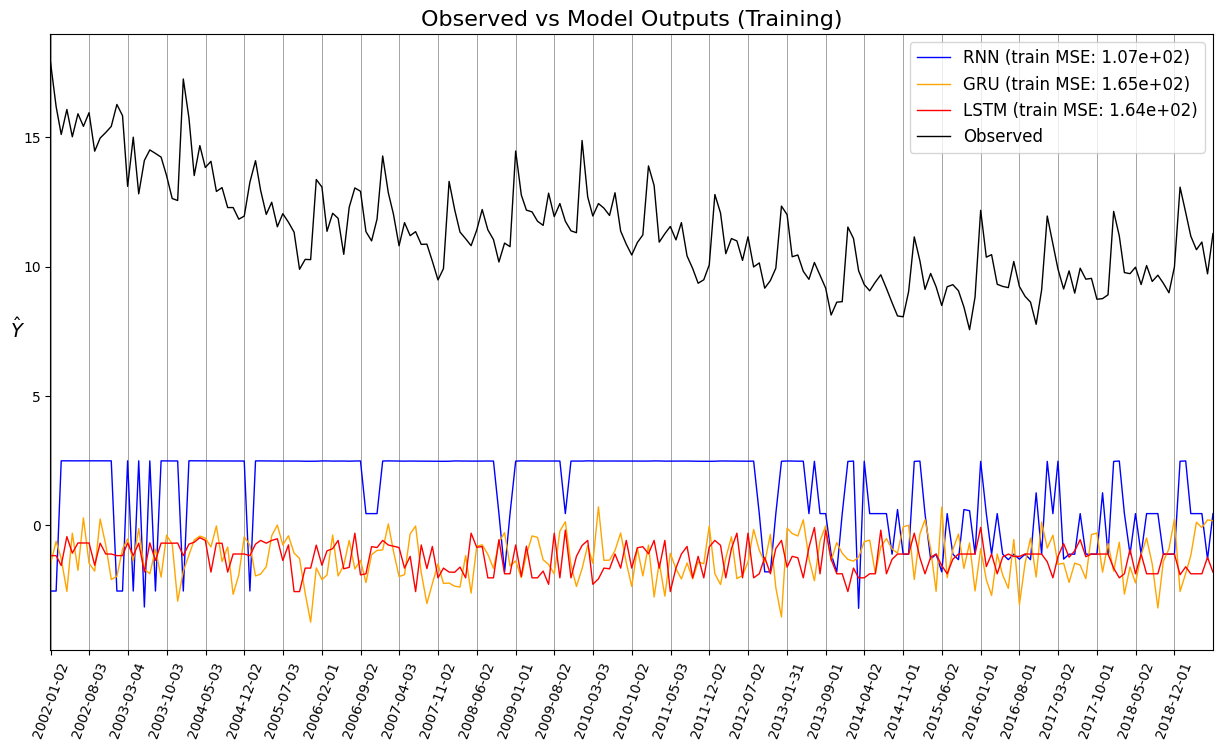

In [40]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

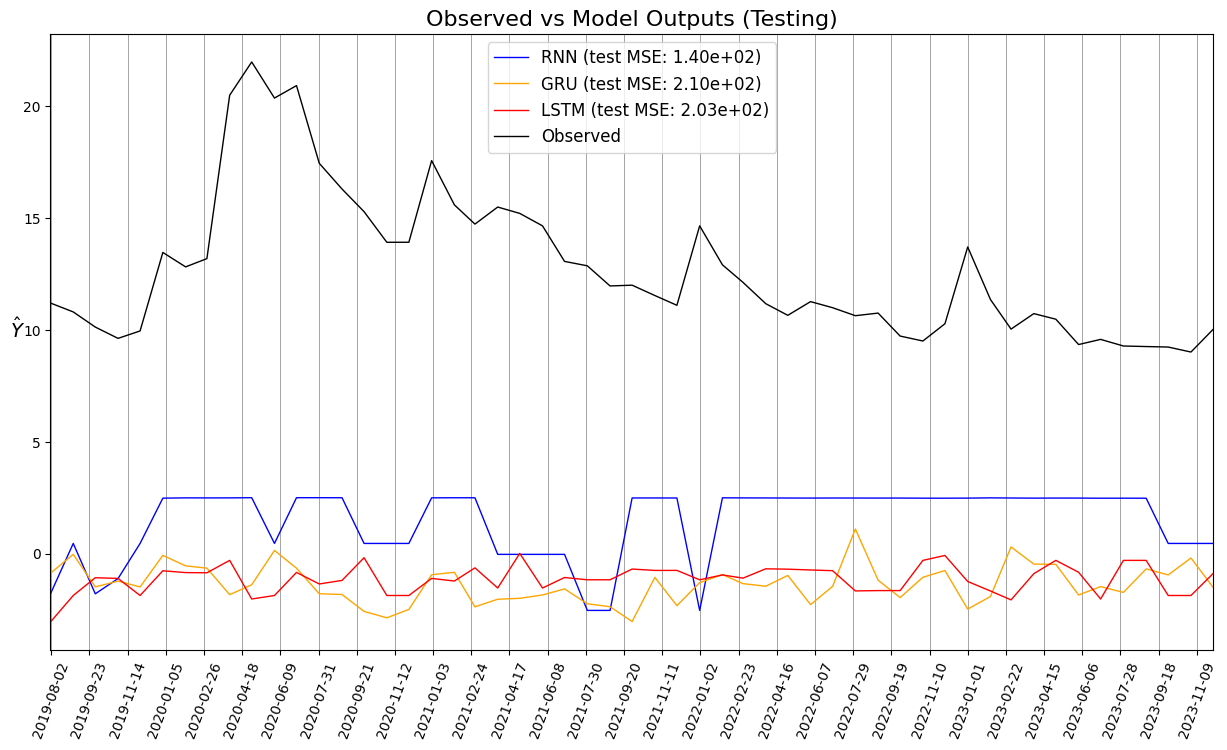

In [41]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

# Agregando estacionalidad para intentar mejorar pronósticos (Dummies)
Agregaremos una nueva covariable, el mes que se va a predecir

In [42]:
#Creamos las dummies de los meses
meses = ["Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre", "Enero"]
meses_repetidos = (meses * (276 // len(meses) + 1))[:276]
meses = pd.DataFrame({'MesSiguiente': meses_repetidos})
meses_dummies = pd.get_dummies(meses, columns=['MesSiguiente'])
meses_dummies

MesSiguiente_Abril  MesSiguiente_Agosto  MesSiguiente_Diciembre  \
0                 False                False                   False   
1                 False                False                   False   
2                  True                False                   False   
3                 False                False                   False   
4                 False                False                   False   
..                  ...                  ...                     ...   
271               False                False                   False   
272               False                False                   False   
273               False                False                   False   
274               False                False                    True   
275               False                False                   False   

     MesSiguiente_Enero  MesSiguiente_Febrero  MesSiguiente_Julio  \
0                 False                  True               False   
1                 False                 False               False   
2                 False                 False               False   
3                 False                 False               False   
4                 False                 False               False   
..                  ...                   ...                 ...   
271               False                 False               False   
272               False                 False               False   
273               False                 False               False   
274               False                 False               False   
275                True                 False               False   

     MesSiguiente_Junio  MesSiguiente_Marzo  MesSiguiente_Mayo  \
0                 False               False              False   
1                 False                True              False   
2                 False               False              False   
3                 False               False               True   
4                  True               False              False   
..                  ...                 ...                ...   
271               False               False              False   
272               False               False              False   
273               False               False              False   
274               False               False              False   
275               False               False              False   

     MesSiguiente_Noviembre  MesSiguiente_Octubre  MesSiguiente_Septiembre  
0                     False                 False                    False  
1                     False                 False                    False  
2                     False                 False                    False  
3                     False                 False                    False  
4                     False                 False                    False  
..                      ...                   ...                      ...  
271                   False                 False                     True  
272                   False                  True                    False  
273                    True                 False                    False  
274                   False                 False                    False  
275                   False                 False                    False  

[276 rows x 12 columns]

Obteniendo las observaciones que estarán en el conjunto de entrenamiento y prueba

In [49]:
anadir1 = meses_dummies.iloc[12:Partir+12]
anadir2 = meses_dummies.iloc[Partir+12:]

In [53]:
x_trainNew = np.concatenate((x_train, anadir1.values.reshape(211,12,1)), axis=1)
x_testNew = np.concatenate((x_test, anadir2.values.reshape(53,12,1)), axis=1)

In [54]:
x_trainNew.shape

(211, 24, 1)

In [55]:
params2 = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

Validación cruzada

In [56]:
#do_training = True
do_training = False
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params2.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params2[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=0, n_units=10)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_trainNew, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params2[key]['H'] = grid_result.best_params_['n_units']
        params2[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.7s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.7s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.6s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   1.1s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.7s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 5s - 2s/step - loss: 171.6329
Epoch 2/100
3/3 - 0s - 25ms/step - loss: 171.1647
Epoch 3/100
3/3 - 0s - 26ms/step - loss: 170.6971
Epoch 4/100
3/3 - 0s - 25ms/step - loss: 170.2304
Epoch 5/100
3/3 - 0s - 29ms/step - loss: 169.7643
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 169.2991
Epoch 7/100
3/3 - 0s - 60ms/step - loss: 168.8347
Epoch 8/100
3/3 - 0s - 24ms/step - loss: 168.3712
Epoch 9/100
3/3 - 0s - 26ms/step - loss: 167.9084
Epoch 10/100
3/3 - 0s - 27ms/step - loss: 167.4466
Epoch 11/100
3/3 - 0s - 25ms/step - loss: 166.9857
Epoch 12/100
3/3 - 0s - 27ms/step - loss: 166.5257
Epoch 13/100
3/3 - 0s - 26ms/step - loss: 166.0665
Epoch 14/100
3/3 - 0s - 57ms/step - loss: 165.6084
Epoch 15/100
3/3 - 0s - 32ms/step - loss: 165.1511
Epoch 16/100
3/3 - 0s - 29ms/step - loss: 164.6948
Epoch 17/100
3/3 - 0s - 29ms/step - loss: 164.2394
Epoch 18/100
3/3 - 0s - 27ms/step - loss: 163.7849
Epoch 19/100
3/3 - 0s - 26ms/step - loss: 163.3314
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 162.8789
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 5s - 859ms/step - loss: 292.1739
Epoch 2/100
6/6 - 0s - 33ms/step - loss: 291.2370
Epoch 3/100
6/6 - 0s - 15ms/step - loss: 290.0274
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 288.8214
Epoch 5/100
6/6 - 0s - 12ms/step - loss: 287.6191
Epoch 6/100
6/6 - 0s - 12ms/step - loss: 286.4207
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 285.2262
Epoch 8/100
6/6 - 0s - 32ms/step - loss: 284.0356
Epoch 9/100
6/6 - 0s - 16ms/step - loss: 282.8490
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 281.6663
Epoch 11/100
6/6 - 0s - 19ms/step - loss: 280.4875
Epoch 12/100
6/6 - 0s - 16ms/step - loss: 279.3126
Epoch 13/100
6/6 - 0s - 32ms/step - loss: 278.1414
Epoch 14/100
6/6 - 0s - 16ms/step - loss: 276.9742
Epoch 15/100
6/6 - 0s - 13ms/step - loss: 275.8107
Epoch 16/100
6/6 - 0s - 32ms/step - loss: 274.6511
Epoch 17/100
6/6 - 0s - 16ms/step - loss: 273.4952
Epoch 18/100
6/6 - 0s - 17ms/step - loss: 272.3430
Epoch 19/100
6/6 - 0s - 26ms/step - loss: 271.1947
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 270.0500


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 7s - 749ms/step - loss: 211.2447
Epoch 2/100
9/9 - 0s - 11ms/step - loss: 209.6478
Epoch 3/100
9/9 - 0s - 14ms/step - loss: 207.8116
Epoch 4/100
9/9 - 0s - 13ms/step - loss: 206.3092
Epoch 5/100
9/9 - 0s - 14ms/step - loss: 204.8139
Epoch 6/100
9/9 - 0s - 13ms/step - loss: 203.3265
Epoch 7/100
9/9 - 0s - 13ms/step - loss: 201.8472
Epoch 8/100
9/9 - 0s - 13ms/step - loss: 200.3761
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 198.9132
Epoch 10/100
9/9 - 0s - 18ms/step - loss: 197.4586
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 196.0122
Epoch 12/100
9/9 - 0s - 11ms/step - loss: 194.5739
Epoch 13/100
9/9 - 0s - 10ms/step - loss: 193.1438
Epoch 14/100
9/9 - 0s - 10ms/step - loss: 192.0421
Epoch 15/100
9/9 - 0s - 13ms/step - loss: 190.6170
Epoch 16/100
9/9 - 0s - 10ms/step - loss: 189.6654
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 188.2604
Epoch 18/100
9/9 - 0s - 10ms/step - loss: 186.8643
Epoch 19/100
9/9 - 0s - 10ms/step - loss: 185.4766
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 184.0971
E

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 6s - 463ms/step - loss: 139.0967
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 137.5596
Epoch 3/100
12/12 - 0s - 8ms/step - loss: 136.0451
Epoch 4/100
12/12 - 0s - 7ms/step - loss: 134.4989
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 132.3673
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 129.8277
Epoch 7/100
12/12 - 0s - 9ms/step - loss: 127.9414
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 126.3930
Epoch 9/100
12/12 - 0s - 8ms/step - loss: 124.8591
Epoch 10/100
12/12 - 0s - 9ms/step - loss: 123.3410
Epoch 11/100
12/12 - 0s - 9ms/step - loss: 121.6276
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 119.9992
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 118.4983
Epoch 14/100
12/12 - 0s - 9ms/step - loss: 117.0113
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 115.5398
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 114.0838
Epoch 17/100
12/12 - 0s - 8ms/step - loss: 112.6432
Epoch 18/100
12/12 - 0s - 9ms/step - loss: 111.2178
Epoch 19/100
12/12 - 0s - 9ms/step - loss: 109.8074
Epoch 20/100
12/12 - 0s - 9ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 5s - 358ms/step - loss: 185.9378
Epoch 2/100
15/15 - 0s - 16ms/step - loss: 182.2922
Epoch 3/100
15/15 - 0s - 7ms/step - loss: 179.9852
Epoch 4/100
15/15 - 0s - 7ms/step - loss: 178.4044
Epoch 5/100
15/15 - 0s - 7ms/step - loss: 176.6462
Epoch 6/100
15/15 - 0s - 6ms/step - loss: 174.5886
Epoch 7/100
15/15 - 0s - 12ms/step - loss: 172.6511
Epoch 8/100
15/15 - 0s - 9ms/step - loss: 170.8130
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 169.2866
Epoch 10/100
15/15 - 0s - 8ms/step - loss: 167.5827
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 165.6785
Epoch 12/100
15/15 - 0s - 9ms/step - loss: 163.7697
Epoch 13/100
15/15 - 0s - 7ms/step - loss: 162.2062
Epoch 14/100
15/15 - 0s - 7ms/step - loss: 160.1835
Epoch 15/100
15/15 - 0s - 7ms/step - loss: 158.9058
Epoch 16/100
15/15 - 0s - 7ms/step - loss: 156.8587
Epoch 17/100
15/15 - 0s - 8ms/step - loss: 155.0517
Epoch 18/100
15/15 - 0s - 7ms/step - loss: 153.3356
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 151.3975
Epoch 20/100
15/15 - 0s - 8ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 1s/step - loss: 277.0358
Epoch 2/100
3/3 - 0s - 26ms/step - loss: 276.2639
Epoch 3/100
3/3 - 0s - 20ms/step - loss: 281.1704
Epoch 4/100
3/3 - 0s - 17ms/step - loss: 280.3302
Epoch 5/100
3/3 - 0s - 17ms/step - loss: 280.4442
Epoch 6/100
3/3 - 0s - 21ms/step - loss: 281.1795
Epoch 7/100
3/3 - 0s - 18ms/step - loss: 281.2855
Epoch 8/100
3/3 - 0s - 30ms/step - loss: 281.9180
Epoch 9/100
3/3 - 0s - 23ms/step - loss: 280.9991
Epoch 10/100
3/3 - 0s - 20ms/step - loss: 282.4490
Epoch 11/100
3/3 - 0s - 24ms/step - loss: 279.1495
Epoch 12/100
3/3 - 0s - 26ms/step - loss: 278.2272
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 277.3087
Epoch 14/100
3/3 - 0s - 19ms/step - loss: 277.4554
Epoch 15/100
3/3 - 0s - 26ms/step - loss: 277.8369
Epoch 16/100
3/3 - 0s - 21ms/step - loss: 276.8854
Epoch 17/100
3/3 - 0s - 20ms/step - loss: 275.9334
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 274.9825
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 275.1800
Epoch 20/100
3/3 - 0s - 18ms/step - loss: 275.3605
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 5s - 822ms/step - loss: 210.0479
Epoch 2/100
6/6 - 0s - 13ms/step - loss: 208.1957
Epoch 3/100
6/6 - 0s - 13ms/step - loss: 206.0378
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 204.3804
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 202.5355
Epoch 6/100
6/6 - 0s - 12ms/step - loss: 200.7333
Epoch 7/100
6/6 - 0s - 10ms/step - loss: 199.5041
Epoch 8/100
6/6 - 0s - 13ms/step - loss: 196.9554
Epoch 9/100
6/6 - 0s - 12ms/step - loss: 195.1321
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 193.3197
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 191.5197
Epoch 12/100
6/6 - 0s - 13ms/step - loss: 189.7330
Epoch 13/100
6/6 - 0s - 11ms/step - loss: 187.9597
Epoch 14/100
6/6 - 0s - 13ms/step - loss: 186.1999
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 184.4535
Epoch 16/100
6/6 - 0s - 13ms/step - loss: 182.7204
Epoch 17/100
6/6 - 0s - 13ms/step - loss: 181.0005
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 179.2935
Epoch 19/100
6/6 - 0s - 12ms/step - loss: 177.5995
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 175.9183


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 5s - 554ms/step - loss: 143.9915
Epoch 2/100
9/9 - 0s - 9ms/step - loss: 139.3641
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 138.0936
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 134.5774
Epoch 5/100
9/9 - 0s - 10ms/step - loss: 132.7149
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 131.3984
Epoch 7/100
9/9 - 0s - 9ms/step - loss: 130.3540
Epoch 8/100
9/9 - 0s - 10ms/step - loss: 128.9688
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 128.0304
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 128.4836
Epoch 11/100
9/9 - 0s - 13ms/step - loss: 126.1094
Epoch 12/100
9/9 - 0s - 11ms/step - loss: 125.2212
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 124.4914
Epoch 14/100
9/9 - 0s - 13ms/step - loss: 124.8386
Epoch 15/100
9/9 - 0s - 10ms/step - loss: 123.7986
Epoch 16/100
9/9 - 0s - 21ms/step - loss: 123.7160
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 121.2027
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 120.0717
Epoch 19/100
9/9 - 0s - 10ms/step - loss: 118.3485
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 117.4201
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 5s - 409ms/step - loss: 139.5270
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 136.2686
Epoch 3/100
12/12 - 0s - 8ms/step - loss: 131.7115
Epoch 4/100
12/12 - 0s - 8ms/step - loss: 129.3793
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 126.6150
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 122.5970
Epoch 7/100
12/12 - 0s - 10ms/step - loss: 119.8969
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 117.7889
Epoch 9/100
12/12 - 0s - 8ms/step - loss: 116.5435
Epoch 10/100
12/12 - 0s - 9ms/step - loss: 113.5978
Epoch 11/100
12/12 - 0s - 9ms/step - loss: 111.6629
Epoch 12/100
12/12 - 0s - 9ms/step - loss: 109.7627
Epoch 13/100
12/12 - 0s - 10ms/step - loss: 109.0234
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 105.5921
Epoch 15/100
12/12 - 0s - 9ms/step - loss: 103.3171
Epoch 16/100
12/12 - 0s - 23ms/step - loss: 101.0798
Epoch 17/100
12/12 - 0s - 13ms/step - loss: 97.7345
Epoch 18/100
12/12 - 0s - 10ms/step - loss: 94.9997
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 92.2461
Epoch 20/100
12/12 - 0s - 8ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 5s - 300ms/step - loss: 187.1598
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 185.2138
Epoch 3/100
15/15 - 0s - 7ms/step - loss: 182.6253
Epoch 4/100
15/15 - 0s - 6ms/step - loss: 181.6393
Epoch 5/100
15/15 - 0s - 8ms/step - loss: 178.3073
Epoch 6/100
15/15 - 0s - 7ms/step - loss: 174.9534
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 171.3205
Epoch 8/100
15/15 - 0s - 6ms/step - loss: 165.6031
Epoch 9/100
15/15 - 0s - 7ms/step - loss: 163.2402
Epoch 10/100
15/15 - 0s - 8ms/step - loss: 159.1966
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 163.8974
Epoch 12/100
15/15 - 0s - 7ms/step - loss: 162.5185
Epoch 13/100
15/15 - 0s - 7ms/step - loss: 161.9555
Epoch 14/100
15/15 - 0s - 7ms/step - loss: 161.6275
Epoch 15/100
15/15 - 0s - 7ms/step - loss: 159.0740
Epoch 16/100
15/15 - 0s - 7ms/step - loss: 157.1398
Epoch 17/100
15/15 - 0s - 7ms/step - loss: 155.4192
Epoch 18/100
15/15 - 0s - 6ms/step - loss: 153.3784
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 150.2939
Epoch 20/100
15/15 - 0s - 9ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 1s/step - loss: 229.7502
Epoch 2/100
3/3 - 0s - 17ms/step - loss: 238.1230
Epoch 3/100
3/3 - 0s - 17ms/step - loss: 241.9472
Epoch 4/100
3/3 - 0s - 17ms/step - loss: 237.2955
Epoch 5/100
3/3 - 0s - 17ms/step - loss: 231.3270
Epoch 6/100
3/3 - 0s - 17ms/step - loss: 224.6360
Epoch 7/100
3/3 - 0s - 17ms/step - loss: 222.4698
Epoch 8/100
3/3 - 0s - 17ms/step - loss: 219.4197
Epoch 9/100
3/3 - 0s - 17ms/step - loss: 218.6834
Epoch 10/100
3/3 - 0s - 16ms/step - loss: 217.9313
Epoch 11/100
3/3 - 0s - 21ms/step - loss: 218.8335
Epoch 12/100
3/3 - 0s - 17ms/step - loss: 221.6047
Epoch 13/100
3/3 - 0s - 17ms/step - loss: 220.4274
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 219.1681
Epoch 15/100
3/3 - 0s - 21ms/step - loss: 217.9193
Epoch 16/100
3/3 - 0s - 16ms/step - loss: 225.8570
Epoch 17/100
3/3 - 0s - 17ms/step - loss: 233.7545
Epoch 18/100
3/3 - 0s - 20ms/step - loss: 250.1431
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 255.6989
Epoch 20/100
3/3 - 0s - 17ms/step - loss: 255.0085
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 5s - 776ms/step - loss: 178.4177
Epoch 2/100
6/6 - 0s - 14ms/step - loss: 175.7857
Epoch 3/100
6/6 - 0s - 39ms/step - loss: 172.3936
Epoch 4/100
6/6 - 0s - 11ms/step - loss: 169.8416
Epoch 5/100
6/6 - 0s - 10ms/step - loss: 167.5676
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 161.7564
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 160.4234
Epoch 8/100
6/6 - 0s - 12ms/step - loss: 154.3605
Epoch 9/100
6/6 - 0s - 12ms/step - loss: 153.5340
Epoch 10/100
6/6 - 0s - 11ms/step - loss: 148.1476
Epoch 11/100
6/6 - 0s - 11ms/step - loss: 143.2923
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 140.5384
Epoch 13/100
6/6 - 0s - 11ms/step - loss: 137.0755
Epoch 14/100
6/6 - 0s - 12ms/step - loss: 134.9215
Epoch 15/100
6/6 - 0s - 10ms/step - loss: 134.2840
Epoch 16/100
6/6 - 0s - 15ms/step - loss: 133.5269
Epoch 17/100
6/6 - 0s - 15ms/step - loss: 131.5177
Epoch 18/100
6/6 - 0s - 11ms/step - loss: 129.5559
Epoch 19/100
6/6 - 0s - 11ms/step - loss: 128.5219
Epoch 20/100
6/6 - 0s - 12ms/step - loss: 125.4657


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 5s - 534ms/step - loss: 175.3077
Epoch 2/100
9/9 - 0s - 9ms/step - loss: 170.4874
Epoch 3/100
9/9 - 0s - 9ms/step - loss: 167.1434
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 162.5256
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 159.7665
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 156.5668
Epoch 7/100
9/9 - 0s - 10ms/step - loss: 153.3766
Epoch 8/100
9/9 - 0s - 9ms/step - loss: 147.8537
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 143.7992
Epoch 10/100
9/9 - 0s - 9ms/step - loss: 140.0753
Epoch 11/100
9/9 - 0s - 8ms/step - loss: 136.9135
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 133.3317
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 131.6241
Epoch 14/100
9/9 - 0s - 9ms/step - loss: 135.0900
Epoch 15/100
9/9 - 0s - 10ms/step - loss: 136.7935
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 134.2948
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 130.7529
Epoch 18/100
9/9 - 0s - 9ms/step - loss: 131.8204
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 146.0918
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 155.6027
Epoch 21/100
9/

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 5s - 383ms/step - loss: 201.7694
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 196.9055
Epoch 3/100
12/12 - 0s - 8ms/step - loss: 186.4022
Epoch 4/100
12/12 - 0s - 7ms/step - loss: 186.2595
Epoch 5/100
12/12 - 0s - 7ms/step - loss: 185.4100
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 189.5715
Epoch 7/100
12/12 - 0s - 7ms/step - loss: 179.6261
Epoch 8/100
12/12 - 0s - 9ms/step - loss: 174.3851
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 172.9812
Epoch 10/100
12/12 - 0s - 8ms/step - loss: 174.6441
Epoch 11/100
12/12 - 0s - 7ms/step - loss: 175.0043
Epoch 12/100
12/12 - 0s - 7ms/step - loss: 170.2242
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 171.3204
Epoch 14/100
12/12 - 0s - 9ms/step - loss: 171.4091
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 170.6392
Epoch 16/100
12/12 - 0s - 7ms/step - loss: 170.0815
Epoch 17/100
12/12 - 0s - 7ms/step - loss: 165.5875
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 163.0915
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 156.5437
Epoch 20/100
12/12 - 0s - 9ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 294ms/step - loss: 141.5515
Epoch 2/100
15/15 - 0s - 6ms/step - loss: 128.0414
Epoch 3/100
15/15 - 0s - 7ms/step - loss: 126.6674
Epoch 4/100
15/15 - 0s - 6ms/step - loss: 124.0988
Epoch 5/100
15/15 - 0s - 6ms/step - loss: 120.6741
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 124.7408
Epoch 7/100
15/15 - 0s - 6ms/step - loss: 127.1696
Epoch 8/100
15/15 - 0s - 8ms/step - loss: 127.2589
Epoch 9/100
15/15 - 0s - 7ms/step - loss: 125.0487
Epoch 10/100
15/15 - 0s - 7ms/step - loss: 125.7126
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 118.3201
Epoch 12/100
15/15 - 0s - 6ms/step - loss: 115.1320
Epoch 13/100
15/15 - 0s - 7ms/step - loss: 121.3875
Epoch 14/100
15/15 - 0s - 7ms/step - loss: 125.1320
Epoch 15/100
15/15 - 0s - 6ms/step - loss: 129.7805
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 124.7473
Epoch 17/100
15/15 - 0s - 6ms/step - loss: 121.0575
Epoch 18/100
15/15 - 0s - 14ms/step - loss: 119.0167
Epoch 19/100
15/15 - 0s - 12ms/step - loss: 115.5852
Epoch 20/100
15/15 - 0s - 7ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 224.5781
Epoch 2/100
3/3 - 0s - 18ms/step - loss: 224.0416
Epoch 3/100
3/3 - 0s - 17ms/step - loss: 223.5058
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 222.9707
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 222.4363
Epoch 6/100
3/3 - 0s - 17ms/step - loss: 221.9028
Epoch 7/100
3/3 - 0s - 17ms/step - loss: 221.3701
Epoch 8/100
3/3 - 0s - 17ms/step - loss: 220.8382
Epoch 9/100
3/3 - 0s - 16ms/step - loss: 220.3072
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 219.7770
Epoch 11/100
3/3 - 0s - 17ms/step - loss: 219.2478
Epoch 12/100
3/3 - 0s - 17ms/step - loss: 218.7194
Epoch 13/100
3/3 - 0s - 23ms/step - loss: 218.1920
Epoch 14/100
3/3 - 0s - 15ms/step - loss: 217.6655
Epoch 15/100
3/3 - 0s - 30ms/step - loss: 217.1399
Epoch 16/100
3/3 - 0s - 18ms/step - loss: 216.6153
Epoch 17/100
3/3 - 0s - 20ms/step - loss: 216.0916
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 215.5689
Epoch 19/100
3/3 - 0s - 18ms/step - loss: 215.0471
Epoch 20/100
3/3 - 0s - 16ms/step - loss: 214.5262
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 4s - 717ms/step - loss: 210.5667
Epoch 2/100
6/6 - 0s - 11ms/step - loss: 211.3902
Epoch 3/100
6/6 - 0s - 11ms/step - loss: 210.3628
Epoch 4/100
6/6 - 0s - 12ms/step - loss: 209.3389
Epoch 5/100
6/6 - 0s - 10ms/step - loss: 208.3186
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 207.3020
Epoch 7/100
6/6 - 0s - 11ms/step - loss: 206.2893
Epoch 8/100
6/6 - 0s - 11ms/step - loss: 205.2805
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 204.2755
Epoch 10/100
6/6 - 0s - 11ms/step - loss: 203.2743
Epoch 11/100
6/6 - 0s - 12ms/step - loss: 202.2771
Epoch 12/100
6/6 - 0s - 10ms/step - loss: 201.2836
Epoch 13/100
6/6 - 0s - 13ms/step - loss: 200.2940
Epoch 14/100
6/6 - 0s - 11ms/step - loss: 199.3081
Epoch 15/100
6/6 - 0s - 11ms/step - loss: 198.3262
Epoch 16/100
6/6 - 0s - 12ms/step - loss: 197.3479
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 196.3734
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 194.2430
Epoch 19/100
6/6 - 0s - 10ms/step - loss: 193.2654
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 192.2905


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 5s - 503ms/step - loss: 155.3676
Epoch 2/100
9/9 - 0s - 9ms/step - loss: 154.5203
Epoch 3/100
9/9 - 0s - 9ms/step - loss: 152.7929
Epoch 4/100
9/9 - 0s - 8ms/step - loss: 151.5551
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 150.3458
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 148.2417
Epoch 7/100
9/9 - 0s - 8ms/step - loss: 146.9941
Epoch 8/100
9/9 - 0s - 7ms/step - loss: 145.2465
Epoch 9/100
9/9 - 0s - 8ms/step - loss: 144.0003
Epoch 10/100
9/9 - 0s - 8ms/step - loss: 142.7614
Epoch 11/100
9/9 - 0s - 8ms/step - loss: 141.5318
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 140.3118
Epoch 13/100
9/9 - 0s - 10ms/step - loss: 139.1013
Epoch 14/100
9/9 - 0s - 8ms/step - loss: 137.3754
Epoch 15/100
9/9 - 0s - 9ms/step - loss: 135.5222
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 134.3231
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 133.1306
Epoch 18/100
9/9 - 0s - 9ms/step - loss: 131.9463
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 130.7708
Epoch 20/100
9/9 - 0s - 10ms/step - loss: 130.0938
Epoch 21/100
9/9

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 5s - 392ms/step - loss: 205.0480
Epoch 2/100
12/12 - 0s - 7ms/step - loss: 203.0675
Epoch 3/100
12/12 - 0s - 7ms/step - loss: 202.3474
Epoch 4/100
12/12 - 0s - 8ms/step - loss: 200.3447
Epoch 5/100
12/12 - 0s - 7ms/step - loss: 198.3563
Epoch 6/100
12/12 - 0s - 7ms/step - loss: 196.3846
Epoch 7/100
12/12 - 0s - 7ms/step - loss: 194.4298
Epoch 8/100
12/12 - 0s - 7ms/step - loss: 192.4913
Epoch 9/100
12/12 - 0s - 9ms/step - loss: 190.5688
Epoch 10/100
12/12 - 0s - 7ms/step - loss: 188.6620
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 186.1572
Epoch 12/100
12/12 - 0s - 7ms/step - loss: 184.2577
Epoch 13/100
12/12 - 0s - 7ms/step - loss: 182.0773
Epoch 14/100
12/12 - 0s - 7ms/step - loss: 180.1963
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 178.3300
Epoch 16/100
12/12 - 0s - 7ms/step - loss: 176.4792
Epoch 17/100
12/12 - 0s - 8ms/step - loss: 174.6440
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 172.8241
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 171.0195
Epoch 20/100
12/12 - 0s - 8ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 5s - 336ms/step - loss: 126.6239
Epoch 2/100
15/15 - 0s - 6ms/step - loss: 123.6902
Epoch 3/100
15/15 - 0s - 7ms/step - loss: 119.9022
Epoch 4/100
15/15 - 0s - 7ms/step - loss: 114.8912
Epoch 5/100
15/15 - 0s - 7ms/step - loss: 111.9180
Epoch 6/100
15/15 - 0s - 7ms/step - loss: 108.3786
Epoch 7/100
15/15 - 0s - 7ms/step - loss: 105.4881
Epoch 8/100
15/15 - 0s - 8ms/step - loss: 103.3846
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 100.8061
Epoch 10/100
15/15 - 0s - 6ms/step - loss: 98.6774
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 96.8944
Epoch 12/100
15/15 - 0s - 7ms/step - loss: 94.8127
Epoch 13/100
15/15 - 0s - 7ms/step - loss: 92.8172
Epoch 14/100
15/15 - 0s - 7ms/step - loss: 90.7235
Epoch 15/100
15/15 - 0s - 7ms/step - loss: 88.7783
Epoch 16/100
15/15 - 0s - 7ms/step - loss: 86.9628
Epoch 17/100
15/15 - 0s - 7ms/step - loss: 84.5135
Epoch 18/100
15/15 - 0s - 7ms/step - loss: 82.5180
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 80.5826
Epoch 20/100
15/15 - 0s - 6ms/step - loss

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 280.2149
Epoch 2/100
3/3 - 0s - 16ms/step - loss: 278.6443
Epoch 3/100
3/3 - 0s - 18ms/step - loss: 278.4106
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 278.3055
Epoch 5/100
3/3 - 0s - 18ms/step - loss: 276.8369
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 275.8522
Epoch 7/100
3/3 - 0s - 17ms/step - loss: 275.7790
Epoch 8/100
3/3 - 0s - 23ms/step - loss: 274.8062
Epoch 9/100
3/3 - 0s - 21ms/step - loss: 274.3359
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 274.0464
Epoch 11/100
3/3 - 0s - 23ms/step - loss: 270.5450
Epoch 12/100
3/3 - 0s - 20ms/step - loss: 271.2662
Epoch 13/100
3/3 - 0s - 17ms/step - loss: 272.1037
Epoch 14/100
3/3 - 0s - 17ms/step - loss: 271.2604
Epoch 15/100
3/3 - 0s - 24ms/step - loss: 268.8891
Epoch 16/100
3/3 - 0s - 15ms/step - loss: 266.2675
Epoch 17/100
3/3 - 0s - 17ms/step - loss: 268.7610
Epoch 18/100
3/3 - 0s - 17ms/step - loss: 267.0963
Epoch 19/100
3/3 - 0s - 18ms/step - loss: 267.9970
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 268.8111
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 4s - 722ms/step - loss: 235.0834
Epoch 2/100
6/6 - 0s - 12ms/step - loss: 231.7730
Epoch 3/100
6/6 - 0s - 11ms/step - loss: 227.8403
Epoch 4/100
6/6 - 0s - 15ms/step - loss: 228.6466
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 222.8070
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 217.7748
Epoch 7/100
6/6 - 0s - 11ms/step - loss: 216.3659
Epoch 8/100
6/6 - 0s - 12ms/step - loss: 216.3717
Epoch 9/100
6/6 - 0s - 11ms/step - loss: 212.2353
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 210.5941
Epoch 11/100
6/6 - 0s - 12ms/step - loss: 208.0043
Epoch 12/100
6/6 - 0s - 13ms/step - loss: 206.1137
Epoch 13/100
6/6 - 0s - 11ms/step - loss: 204.8657
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 202.1581
Epoch 15/100
6/6 - 0s - 11ms/step - loss: 200.5428
Epoch 16/100
6/6 - 0s - 11ms/step - loss: 199.1442
Epoch 17/100
6/6 - 0s - 11ms/step - loss: 197.9555
Epoch 18/100
6/6 - 0s - 12ms/step - loss: 197.2201
Epoch 19/100
6/6 - 0s - 12ms/step - loss: 196.1234
Epoch 20/100
6/6 - 0s - 11ms/step - loss: 192.6232


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 5s - 529ms/step - loss: 168.0137
Epoch 2/100
9/9 - 0s - 9ms/step - loss: 163.2592
Epoch 3/100
9/9 - 0s - 8ms/step - loss: 158.1084
Epoch 4/100
9/9 - 0s - 8ms/step - loss: 152.3439
Epoch 5/100
9/9 - 0s - 7ms/step - loss: 151.4365
Epoch 6/100
9/9 - 0s - 10ms/step - loss: 147.5550
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 145.9722
Epoch 8/100
9/9 - 0s - 9ms/step - loss: 142.8582
Epoch 9/100
9/9 - 0s - 12ms/step - loss: 140.5654
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 138.3619
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 136.1435
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 133.9574
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 131.2393
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 129.0948
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 126.3534
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 128.8203
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 135.0010
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 138.1668
Epoch 19/100
9/9 - 0s - 12ms/step - loss: 141.6171
Epoch 20/100
9/9 - 0s - 10ms/step - loss: 144.2660
Epoch 2

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 5s - 391ms/step - loss: 190.7626
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 187.8866
Epoch 3/100
12/12 - 0s - 9ms/step - loss: 184.6867
Epoch 4/100
12/12 - 0s - 8ms/step - loss: 181.3384
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 178.4660
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 175.5855
Epoch 7/100
12/12 - 0s - 16ms/step - loss: 180.7181
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 179.7532
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 178.2544
Epoch 10/100
12/12 - 0s - 8ms/step - loss: 177.6951
Epoch 11/100
12/12 - 0s - 7ms/step - loss: 174.0212
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 171.9490
Epoch 13/100
12/12 - 0s - 7ms/step - loss: 170.2047
Epoch 14/100
12/12 - 0s - 7ms/step - loss: 168.5328
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 167.2304
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 165.0480
Epoch 17/100
12/12 - 0s - 8ms/step - loss: 162.2950
Epoch 18/100
12/12 - 0s - 9ms/step - loss: 159.3435
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 156.1791
Epoch 20/100
12/12 - 0s - 7ms/

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 293ms/step - loss: 171.9536
Epoch 2/100
15/15 - 0s - 12ms/step - loss: 178.5013
Epoch 3/100
15/15 - 0s - 9ms/step - loss: 177.5576
Epoch 4/100
15/15 - 0s - 7ms/step - loss: 180.0343
Epoch 5/100
15/15 - 0s - 7ms/step - loss: 177.9624
Epoch 6/100
15/15 - 0s - 7ms/step - loss: 176.8877
Epoch 7/100
15/15 - 0s - 13ms/step - loss: 174.5835
Epoch 8/100
15/15 - 0s - 7ms/step - loss: 173.1863
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 172.0290
Epoch 10/100
15/15 - 0s - 6ms/step - loss: 170.5305
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 169.0036
Epoch 12/100
15/15 - 0s - 8ms/step - loss: 167.1339
Epoch 13/100
15/15 - 0s - 7ms/step - loss: 165.2138
Epoch 14/100
15/15 - 0s - 7ms/step - loss: 162.3546
Epoch 15/100
15/15 - 0s - 7ms/step - loss: 161.9905
Epoch 16/100
15/15 - 0s - 7ms/step - loss: 158.4801
Epoch 17/100
15/15 - 0s - 7ms/step - loss: 131.1049
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 124.6947
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 153.6901
Epoch 20/100
15/15 - 0s - 7ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 1s/step - loss: 278.9332
Epoch 2/100
3/3 - 0s - 21ms/step - loss: 281.0263
Epoch 3/100
3/3 - 0s - 23ms/step - loss: 279.6836
Epoch 4/100
3/3 - 0s - 14ms/step - loss: 278.2267
Epoch 5/100
3/3 - 0s - 17ms/step - loss: 275.5323
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 276.0692
Epoch 7/100
3/3 - 0s - 16ms/step - loss: 277.3665
Epoch 8/100
3/3 - 0s - 17ms/step - loss: 277.3070
Epoch 9/100
3/3 - 0s - 17ms/step - loss: 275.5117
Epoch 10/100
3/3 - 0s - 17ms/step - loss: 275.2517
Epoch 11/100
3/3 - 0s - 18ms/step - loss: 273.4832
Epoch 12/100
3/3 - 0s - 15ms/step - loss: 272.9159
Epoch 13/100
3/3 - 0s - 28ms/step - loss: 271.4828
Epoch 14/100
3/3 - 0s - 25ms/step - loss: 269.5803
Epoch 15/100
3/3 - 0s - 18ms/step - loss: 268.9585
Epoch 16/100
3/3 - 0s - 17ms/step - loss: 267.0947
Epoch 17/100
3/3 - 0s - 17ms/step - loss: 264.7080
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 262.3914
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 260.2955
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 257.2750
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 5s - 809ms/step - loss: 214.0949
Epoch 2/100
6/6 - 0s - 37ms/step - loss: 210.3604
Epoch 3/100
6/6 - 0s - 11ms/step - loss: 205.2116
Epoch 4/100
6/6 - 0s - 11ms/step - loss: 200.8914
Epoch 5/100
6/6 - 0s - 13ms/step - loss: 198.5368
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 194.8993
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 192.0802
Epoch 8/100
6/6 - 0s - 11ms/step - loss: 188.1323
Epoch 9/100
6/6 - 0s - 11ms/step - loss: 188.3773
Epoch 10/100
6/6 - 0s - 12ms/step - loss: 183.0052
Epoch 11/100
6/6 - 0s - 15ms/step - loss: 180.8896
Epoch 12/100
6/6 - 0s - 13ms/step - loss: 177.5088
Epoch 13/100
6/6 - 0s - 11ms/step - loss: 172.7245
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 171.6329
Epoch 15/100
6/6 - 0s - 11ms/step - loss: 167.1324
Epoch 16/100
6/6 - 0s - 11ms/step - loss: 165.5470
Epoch 17/100
6/6 - 0s - 11ms/step - loss: 157.3466
Epoch 18/100
6/6 - 0s - 12ms/step - loss: 153.1901
Epoch 19/100
6/6 - 0s - 10ms/step - loss: 162.4029
Epoch 20/100
6/6 - 0s - 17ms/step - loss: 171.2880


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 5s - 514ms/step - loss: 196.1926
Epoch 2/100
9/9 - 0s - 10ms/step - loss: 190.7534
Epoch 3/100
9/9 - 0s - 9ms/step - loss: 187.5928
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 183.1259
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 178.9065
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 173.9706
Epoch 7/100
9/9 - 0s - 9ms/step - loss: 168.9915
Epoch 8/100
9/9 - 0s - 10ms/step - loss: 163.8944
Epoch 9/100
9/9 - 0s - 9ms/step - loss: 160.3308
Epoch 10/100
9/9 - 0s - 9ms/step - loss: 156.9580
Epoch 11/100
9/9 - 0s - 9ms/step - loss: 155.2651
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 154.8002
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 160.2280
Epoch 14/100
9/9 - 0s - 10ms/step - loss: 158.4302
Epoch 15/100
9/9 - 0s - 8ms/step - loss: 140.4248
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 133.4797
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 129.6721
Epoch 18/100
9/9 - 0s - 9ms/step - loss: 126.2715
Epoch 19/100
9/9 - 0s - 8ms/step - loss: 123.9039
Epoch 20/100
9/9 - 0s - 10ms/step - loss: 120.2241
Epoch 21/100
9/

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 5s - 393ms/step - loss: 166.2271
Epoch 2/100
12/12 - 0s - 7ms/step - loss: 162.5549
Epoch 3/100
12/12 - 0s - 7ms/step - loss: 155.4914
Epoch 4/100
12/12 - 0s - 9ms/step - loss: 152.3199
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 145.9743
Epoch 6/100
12/12 - 0s - 9ms/step - loss: 156.3103
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 175.2417
Epoch 8/100
12/12 - 0s - 9ms/step - loss: 179.6699
Epoch 9/100
12/12 - 0s - 8ms/step - loss: 178.2853
Epoch 10/100
12/12 - 0s - 8ms/step - loss: 174.4072
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 170.4869
Epoch 12/100
12/12 - 0s - 7ms/step - loss: 167.0996
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 165.5358
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 162.5773
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 157.3852
Epoch 16/100
12/12 - 0s - 9ms/step - loss: 157.3812
Epoch 17/100
12/12 - 0s - 8ms/step - loss: 152.3078
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 147.7745
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 144.6532
Epoch 20/100
12/12 - 0s - 7ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 297ms/step - loss: 169.3597
Epoch 2/100
15/15 - 0s - 7ms/step - loss: 162.4759
Epoch 3/100
15/15 - 0s - 7ms/step - loss: 152.0351
Epoch 4/100
15/15 - 0s - 7ms/step - loss: 146.5832
Epoch 5/100
15/15 - 0s - 7ms/step - loss: 139.2945
Epoch 6/100
15/15 - 0s - 7ms/step - loss: 142.0205
Epoch 7/100
15/15 - 0s - 7ms/step - loss: 156.3885
Epoch 8/100
15/15 - 0s - 7ms/step - loss: 156.4671
Epoch 9/100
15/15 - 0s - 7ms/step - loss: 152.4217
Epoch 10/100
15/15 - 0s - 7ms/step - loss: 148.0516
Epoch 11/100
15/15 - 0s - 6ms/step - loss: 144.9237
Epoch 12/100
15/15 - 0s - 8ms/step - loss: 143.0515
Epoch 13/100
15/15 - 0s - 7ms/step - loss: 141.2007
Epoch 14/100
15/15 - 0s - 6ms/step - loss: 140.8591
Epoch 15/100
15/15 - 0s - 7ms/step - loss: 140.2750
Epoch 16/100
15/15 - 0s - 7ms/step - loss: 136.6745
Epoch 17/100
15/15 - 0s - 7ms/step - loss: 131.8866
Epoch 18/100
15/15 - 0s - 7ms/step - loss: 128.5624
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 124.4731
Epoch 20/100
15/15 - 0s - 8ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 227.8150
Epoch 2/100
3/3 - 0s - 18ms/step - loss: 227.4360
Epoch 3/100
3/3 - 0s - 21ms/step - loss: 227.0622
Epoch 4/100
3/3 - 0s - 17ms/step - loss: 226.6897
Epoch 5/100
3/3 - 0s - 17ms/step - loss: 226.3179
Epoch 6/100
3/3 - 0s - 23ms/step - loss: 225.9467
Epoch 7/100
3/3 - 0s - 16ms/step - loss: 225.5761
Epoch 8/100
3/3 - 0s - 15ms/step - loss: 223.3585
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 222.9961
Epoch 10/100
3/3 - 0s - 17ms/step - loss: 222.6348
Epoch 11/100
3/3 - 0s - 23ms/step - loss: 220.7168
Epoch 12/100
3/3 - 0s - 21ms/step - loss: 217.2052
Epoch 13/100
3/3 - 0s - 17ms/step - loss: 216.8586
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 216.5121
Epoch 15/100
3/3 - 0s - 17ms/step - loss: 214.6669
Epoch 16/100
3/3 - 0s - 23ms/step - loss: 214.3216
Epoch 17/100
3/3 - 0s - 14ms/step - loss: 213.9761
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 213.6303
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 211.5247
Epoch 20/100
3/3 - 0s - 18ms/step - loss: 211.1771
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 4s - 743ms/step - loss: 193.8436
Epoch 2/100
6/6 - 0s - 10ms/step - loss: 192.8500
Epoch 3/100
6/6 - 0s - 11ms/step - loss: 191.8598
Epoch 4/100
6/6 - 0s - 11ms/step - loss: 190.8730
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 189.8897
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 188.9101
Epoch 7/100
6/6 - 0s - 13ms/step - loss: 187.9342
Epoch 8/100
6/6 - 0s - 11ms/step - loss: 186.9620
Epoch 9/100
6/6 - 0s - 11ms/step - loss: 185.9937
Epoch 10/100
6/6 - 0s - 11ms/step - loss: 185.0291
Epoch 11/100
6/6 - 0s - 11ms/step - loss: 184.0684
Epoch 12/100
6/6 - 0s - 12ms/step - loss: 183.1115
Epoch 13/100
6/6 - 0s - 11ms/step - loss: 182.1584
Epoch 14/100
6/6 - 0s - 11ms/step - loss: 181.2092
Epoch 15/100
6/6 - 0s - 12ms/step - loss: 180.2655
Epoch 16/100
6/6 - 0s - 11ms/step - loss: 179.3260
Epoch 17/100
6/6 - 0s - 11ms/step - loss: 178.3904
Epoch 18/100
6/6 - 0s - 11ms/step - loss: 177.4588
Epoch 19/100
6/6 - 0s - 13ms/step - loss: 176.5308
Epoch 20/100
6/6 - 0s - 11ms/step - loss: 175.6065


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 5s - 519ms/step - loss: 132.1468
Epoch 2/100
9/9 - 0s - 9ms/step - loss: 131.0037
Epoch 3/100
9/9 - 0s - 8ms/step - loss: 129.8300
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 128.6635
Epoch 5/100
9/9 - 0s - 9ms/step - loss: 127.0478
Epoch 6/100
9/9 - 0s - 7ms/step - loss: 125.5674
Epoch 7/100
9/9 - 0s - 10ms/step - loss: 124.4014
Epoch 8/100
9/9 - 0s - 9ms/step - loss: 123.2421
Epoch 9/100
9/9 - 0s - 9ms/step - loss: 122.0910
Epoch 10/100
9/9 - 0s - 9ms/step - loss: 120.9493
Epoch 11/100
9/9 - 0s - 10ms/step - loss: 119.8168
Epoch 12/100
9/9 - 0s - 11ms/step - loss: 118.6930
Epoch 13/100
9/9 - 0s - 10ms/step - loss: 117.5779
Epoch 14/100
9/9 - 0s - 8ms/step - loss: 116.4714
Epoch 15/100
9/9 - 0s - 10ms/step - loss: 115.3734
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 113.5373
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 112.4454
Epoch 18/100
9/9 - 0s - 9ms/step - loss: 111.3603
Epoch 19/100
9/9 - 0s - 10ms/step - loss: 110.2830
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 109.2140
Epoch 21/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 5s - 387ms/step - loss: 226.3730
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 223.9659
Epoch 3/100
12/12 - 0s - 7ms/step - loss: 223.3889
Epoch 4/100
12/12 - 0s - 9ms/step - loss: 221.9034
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 220.0545
Epoch 6/100
12/12 - 0s - 7ms/step - loss: 218.9328
Epoch 7/100
12/12 - 0s - 9ms/step - loss: 217.4684
Epoch 8/100
12/12 - 0s - 7ms/step - loss: 215.9681
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 215.0512
Epoch 10/100
12/12 - 0s - 9ms/step - loss: 213.5280
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 211.0709
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 209.6179
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 208.2380
Epoch 14/100
12/12 - 0s - 7ms/step - loss: 206.3693
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 205.0345
Epoch 16/100
12/12 - 0s - 7ms/step - loss: 204.0167
Epoch 17/100
12/12 - 0s - 9ms/step - loss: 202.4469
Epoch 18/100
12/12 - 0s - 6ms/step - loss: 201.1430
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 199.0444
Epoch 20/100
12/12 - 0s - 8ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 5s - 310ms/step - loss: 140.9513
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 140.6463
Epoch 3/100
15/15 - 0s - 7ms/step - loss: 140.2145
Epoch 4/100
15/15 - 0s - 7ms/step - loss: 140.0716
Epoch 5/100
15/15 - 0s - 8ms/step - loss: 139.2480
Epoch 6/100
15/15 - 0s - 7ms/step - loss: 137.9140
Epoch 7/100
15/15 - 0s - 7ms/step - loss: 136.7181
Epoch 8/100
15/15 - 0s - 7ms/step - loss: 135.1015
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 133.6022
Epoch 10/100
15/15 - 0s - 7ms/step - loss: 132.1142
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 130.6497
Epoch 12/100
15/15 - 0s - 7ms/step - loss: 128.7810
Epoch 13/100
15/15 - 0s - 7ms/step - loss: 125.8767
Epoch 14/100
15/15 - 0s - 7ms/step - loss: 123.4553
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 120.3475
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 117.3560
Epoch 17/100
15/15 - 0s - 9ms/step - loss: 109.5591
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 103.4486
Epoch 19/100
15/15 - 0s - 10ms/step - loss: 101.3680
Epoch 20/100
15/15 - 0s - 9ms/

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 317.4258
Epoch 2/100
3/3 - 0s - 23ms/step - loss: 316.2899
Epoch 3/100
3/3 - 0s - 26ms/step - loss: 315.1565
Epoch 4/100
3/3 - 0s - 18ms/step - loss: 314.0256
Epoch 5/100
3/3 - 0s - 21ms/step - loss: 313.9753
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 312.8258
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 312.7074
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 311.5386
Epoch 9/100
3/3 - 0s - 23ms/step - loss: 310.3700
Epoch 10/100
3/3 - 0s - 23ms/step - loss: 309.2027
Epoch 11/100
3/3 - 0s - 21ms/step - loss: 308.0376
Epoch 12/100
3/3 - 0s - 28ms/step - loss: 306.8753
Epoch 13/100
3/3 - 0s - 23ms/step - loss: 305.7161
Epoch 14/100
3/3 - 0s - 28ms/step - loss: 304.5602
Epoch 15/100
3/3 - 0s - 28ms/step - loss: 303.4078
Epoch 16/100
3/3 - 0s - 30ms/step - loss: 302.2590
Epoch 17/100
3/3 - 0s - 55ms/step - loss: 301.1138
Epoch 18/100
3/3 - 0s - 29ms/step - loss: 299.9722
Epoch 19/100
3/3 - 0s - 23ms/step - loss: 298.8343
Epoch 20/100
3/3 - 0s - 23ms/step - loss: 297.7000
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 5s - 775ms/step - loss: 273.7142
Epoch 2/100
6/6 - 0s - 12ms/step - loss: 271.5777
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 269.7405
Epoch 4/100
6/6 - 0s - 12ms/step - loss: 267.6046
Epoch 5/100
6/6 - 0s - 11ms/step - loss: 266.7035
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 264.0714
Epoch 7/100
6/6 - 0s - 11ms/step - loss: 261.4027
Epoch 8/100
6/6 - 0s - 12ms/step - loss: 259.3163
Epoch 9/100
6/6 - 0s - 13ms/step - loss: 257.2429
Epoch 10/100
6/6 - 0s - 11ms/step - loss: 255.1824
Epoch 11/100
6/6 - 0s - 12ms/step - loss: 253.1358
Epoch 12/100
6/6 - 0s - 12ms/step - loss: 251.1034
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 249.0837
Epoch 14/100
6/6 - 0s - 12ms/step - loss: 247.0769
Epoch 15/100
6/6 - 0s - 13ms/step - loss: 244.7510
Epoch 16/100
6/6 - 0s - 12ms/step - loss: 242.7641
Epoch 17/100
6/6 - 0s - 12ms/step - loss: 240.7891
Epoch 18/100
6/6 - 0s - 13ms/step - loss: 237.8850
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 235.0926
Epoch 20/100
6/6 - 0s - 12ms/step - loss: 233.2108


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 5s - 512ms/step - loss: 134.4582
Epoch 2/100
9/9 - 0s - 9ms/step - loss: 132.2360
Epoch 3/100
9/9 - 0s - 8ms/step - loss: 130.5219
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 127.9095
Epoch 5/100
9/9 - 0s - 8ms/step - loss: 125.3048
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 122.6077
Epoch 7/100
9/9 - 0s - 9ms/step - loss: 120.9193
Epoch 8/100
9/9 - 0s - 9ms/step - loss: 118.8320
Epoch 9/100
9/9 - 0s - 8ms/step - loss: 116.6495
Epoch 10/100
9/9 - 0s - 8ms/step - loss: 114.6262
Epoch 11/100
9/9 - 0s - 9ms/step - loss: 112.6324
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 110.6673
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 108.7301
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 106.8203
Epoch 15/100
9/9 - 0s - 9ms/step - loss: 105.3090
Epoch 16/100
9/9 - 0s - 10ms/step - loss: 117.5557
Epoch 17/100
9/9 - 0s - 8ms/step - loss: 133.8664
Epoch 18/100
9/9 - 0s - 8ms/step - loss: 146.4283
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 151.5753
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 151.9051
Epoch 21/100
9/9 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 5s - 385ms/step - loss: 173.1032
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 169.7519
Epoch 3/100
12/12 - 0s - 9ms/step - loss: 166.2819
Epoch 4/100
12/12 - 0s - 7ms/step - loss: 161.5640
Epoch 5/100
12/12 - 0s - 9ms/step - loss: 159.7133
Epoch 6/100
12/12 - 0s - 7ms/step - loss: 156.7127
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 156.0820
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 154.2934
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 153.8838
Epoch 10/100
12/12 - 0s - 7ms/step - loss: 151.0810
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 150.3366
Epoch 12/100
12/12 - 0s - 7ms/step - loss: 146.4368
Epoch 13/100
12/12 - 0s - 7ms/step - loss: 144.6830
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 140.2679
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 138.5745
Epoch 16/100
12/12 - 0s - 7ms/step - loss: 132.4829
Epoch 17/100
12/12 - 0s - 7ms/step - loss: 133.4764
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 129.8011
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 126.9044
Epoch 20/100
12/12 - 0s - 8ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 5s - 303ms/step - loss: 159.2473
Epoch 2/100
15/15 - 0s - 7ms/step - loss: 156.2843
Epoch 3/100
15/15 - 0s - 7ms/step - loss: 152.0485
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 148.1986
Epoch 5/100
15/15 - 0s - 7ms/step - loss: 144.3931
Epoch 6/100
15/15 - 0s - 7ms/step - loss: 139.9446
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 136.1392
Epoch 8/100
15/15 - 0s - 7ms/step - loss: 132.0667
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 128.3134
Epoch 10/100
15/15 - 0s - 8ms/step - loss: 124.5485
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 121.3431
Epoch 12/100
15/15 - 0s - 7ms/step - loss: 118.3685
Epoch 13/100
15/15 - 0s - 6ms/step - loss: 115.5612
Epoch 14/100
15/15 - 0s - 7ms/step - loss: 112.9643
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 108.6917
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 107.9091
Epoch 17/100
15/15 - 0s - 8ms/step - loss: 107.7385
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 107.5252
Epoch 19/100
15/15 - 0s - 10ms/step - loss: 107.1636
Epoch 20/100
15/15 - 0s - 10ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 220.0448
Epoch 2/100
3/3 - 0s - 28ms/step - loss: 227.9212
Epoch 3/100
3/3 - 0s - 16ms/step - loss: 232.2407
Epoch 4/100
3/3 - 0s - 23ms/step - loss: 198.1952
Epoch 5/100
3/3 - 0s - 21ms/step - loss: 220.0973
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 222.9360
Epoch 7/100
3/3 - 0s - 33ms/step - loss: 218.8747
Epoch 8/100
3/3 - 0s - 23ms/step - loss: 222.8809
Epoch 9/100
3/3 - 0s - 25ms/step - loss: 221.7845
Epoch 10/100
3/3 - 0s - 23ms/step - loss: 220.6800
Epoch 11/100
3/3 - 0s - 23ms/step - loss: 219.5728
Epoch 12/100
3/3 - 0s - 17ms/step - loss: 220.2363
Epoch 13/100
3/3 - 0s - 21ms/step - loss: 214.5938
Epoch 14/100
3/3 - 0s - 23ms/step - loss: 210.4346
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 204.9442
Epoch 16/100
3/3 - 0s - 24ms/step - loss: 199.2996
Epoch 17/100
3/3 - 0s - 19ms/step - loss: 197.9896
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 192.0524
Epoch 19/100
3/3 - 0s - 17ms/step - loss: 190.6818
Epoch 20/100
3/3 - 0s - 18ms/step - loss: 184.3542
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 5s - 780ms/step - loss: 248.1983
Epoch 2/100
6/6 - 0s - 12ms/step - loss: 245.2162
Epoch 3/100
6/6 - 0s - 11ms/step - loss: 240.8021
Epoch 4/100
6/6 - 0s - 42ms/step - loss: 236.5241
Epoch 5/100
6/6 - 0s - 13ms/step - loss: 233.2919
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 229.4376
Epoch 7/100
6/6 - 0s - 13ms/step - loss: 226.1125
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 222.4995
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 218.8932
Epoch 10/100
6/6 - 0s - 11ms/step - loss: 215.3303
Epoch 11/100
6/6 - 0s - 11ms/step - loss: 211.8127
Epoch 12/100
6/6 - 0s - 12ms/step - loss: 208.5820
Epoch 13/100
6/6 - 0s - 11ms/step - loss: 205.1798
Epoch 14/100
6/6 - 0s - 11ms/step - loss: 201.8241
Epoch 15/100
6/6 - 0s - 11ms/step - loss: 198.5128
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 195.2450
Epoch 17/100
6/6 - 0s - 11ms/step - loss: 191.4188
Epoch 18/100
6/6 - 0s - 11ms/step - loss: 188.2101
Epoch 19/100
6/6 - 0s - 11ms/step - loss: 185.2971
Epoch 20/100
6/6 - 0s - 11ms/step - loss: 183.2648


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 5s - 509ms/step - loss: 180.8675
Epoch 2/100
9/9 - 0s - 8ms/step - loss: 174.7495
Epoch 3/100
9/9 - 0s - 9ms/step - loss: 171.0085
Epoch 4/100
9/9 - 0s - 9ms/step - loss: 165.9044
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 159.9863
Epoch 6/100
9/9 - 0s - 9ms/step - loss: 155.5888
Epoch 7/100
9/9 - 0s - 9ms/step - loss: 152.8064
Epoch 8/100
9/9 - 0s - 9ms/step - loss: 149.3658
Epoch 9/100
9/9 - 0s - 9ms/step - loss: 145.7239
Epoch 10/100
9/9 - 0s - 10ms/step - loss: 141.4257
Epoch 11/100
9/9 - 0s - 9ms/step - loss: 139.4776
Epoch 12/100
9/9 - 0s - 7ms/step - loss: 134.2231
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 130.1337
Epoch 14/100
9/9 - 0s - 9ms/step - loss: 125.8662
Epoch 15/100
9/9 - 0s - 10ms/step - loss: 125.0121
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 121.6395
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 117.8806
Epoch 18/100
9/9 - 0s - 9ms/step - loss: 115.4492
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 112.1285
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 109.7269
Epoch 21/100
9

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 4s - 361ms/step - loss: 221.6427
Epoch 2/100
12/12 - 0s - 9ms/step - loss: 225.9067
Epoch 3/100
12/12 - 0s - 7ms/step - loss: 225.5953
Epoch 4/100
12/12 - 0s - 8ms/step - loss: 221.6168
Epoch 5/100
12/12 - 0s - 7ms/step - loss: 215.8408
Epoch 6/100
12/12 - 0s - 7ms/step - loss: 208.6980
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 202.3656
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 195.4165
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 188.0537
Epoch 10/100
12/12 - 0s - 8ms/step - loss: 180.3605
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 175.6011
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 171.2523
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 169.7435
Epoch 14/100
12/12 - 0s - 7ms/step - loss: 171.0061
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 172.3047
Epoch 16/100
12/12 - 0s - 7ms/step - loss: 171.3296
Epoch 17/100
12/12 - 0s - 8ms/step - loss: 180.1011
Epoch 18/100
12/12 - 0s - 9ms/step - loss: 192.2528
Epoch 19/100
12/12 - 0s - 7ms/step - loss: 187.1231
Epoch 20/100
12/12 - 0s - 7ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 299ms/step - loss: 176.9437
Epoch 2/100
15/15 - 0s - 7ms/step - loss: 170.0967
Epoch 3/100
15/15 - 0s - 7ms/step - loss: 161.7722
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 155.3381
Epoch 5/100
15/15 - 0s - 7ms/step - loss: 148.8218
Epoch 6/100
15/15 - 0s - 7ms/step - loss: 142.1341
Epoch 7/100
15/15 - 0s - 7ms/step - loss: 141.9182
Epoch 8/100
15/15 - 0s - 7ms/step - loss: 144.1391
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 138.7478
Epoch 10/100
15/15 - 0s - 7ms/step - loss: 132.5319
Epoch 11/100
15/15 - 0s - 7ms/step - loss: 121.7541
Epoch 12/100
15/15 - 0s - 8ms/step - loss: 114.4636
Epoch 13/100
15/15 - 0s - 7ms/step - loss: 108.2783
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 105.2513
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 101.5488
Epoch 16/100
15/15 - 0s - 14ms/step - loss: 98.0781
Epoch 17/100
15/15 - 0s - 9ms/step - loss: 93.0764
Epoch 18/100
15/15 - 0s - 7ms/step - loss: 85.6745
Epoch 19/100
15/15 - 0s - 7ms/step - loss: 80.5328
Epoch 20/100
15/15 - 0s - 7ms/step

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._f

18/18 - 5s - 266ms/step - loss: 207.1724
Epoch 2/100
18/18 - 0s - 17ms/step - loss: 203.4489
Epoch 3/100
18/18 - 0s - 7ms/step - loss: 211.5752
Epoch 4/100
18/18 - 0s - 8ms/step - loss: 216.3257
Epoch 5/100
18/18 - 0s - 8ms/step - loss: 209.3014
Epoch 6/100
18/18 - 0s - 8ms/step - loss: 193.5360
Epoch 7/100
18/18 - 0s - 9ms/step - loss: 182.1131
Epoch 8/100
18/18 - 0s - 9ms/step - loss: 175.9804
Epoch 9/100
18/18 - 0s - 7ms/step - loss: 174.9591
Epoch 10/100
18/18 - 0s - 9ms/step - loss: 172.4473
Epoch 11/100
18/18 - 0s - 8ms/step - loss: 162.9198
Epoch 12/100
18/18 - 0s - 9ms/step - loss: 162.3468
Epoch 13/100
18/18 - 0s - 10ms/step - loss: 160.0549
Epoch 14/100
18/18 - 0s - 10ms/step - loss: 161.3451
Epoch 15/100
18/18 - 0s - 10ms/step - loss: 171.0887
Epoch 16/100
18/18 - 0s - 11ms/step - loss: 167.4779
Epoch 17/100
18/18 - 0s - 9ms/step - loss: 164.7909
Epoch 18/100
18/18 - 0s - 9ms/step - loss: 162.6730
Epoch 19/100
18/18 - 0s - 7ms/step - loss: 159.0365
Epoch 20/100
18/18 - 0s - 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.7s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   1.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   1.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   1.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   1.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   1.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   1.8s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   2.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   1.8s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   1.4s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   1.5s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
3/3 - 11s - 4s/step - loss: 253.6804
Epoch 2/100
3/3 - 0s - 30ms/step - loss: 253.0611
Epoch 3/100
3/3 - 0s - 117ms/step - loss: 252.4504
Epoch 4/100
3/3 - 0s - 24ms/step - loss: 251.8416
Epoch 5/100
3/3 - 0s - 48ms/step - loss: 251.2344
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 250.6294
Epoch 7/100
3/3 - 0s - 23ms/step - loss: 250.0267
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 249.4245
Epoch 9/100
3/3 - 0s - 28ms/step - loss: 248.7164
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 248.1036
Epoch 11/100
3/3 - 0s - 27ms/step - loss: 247.3254
Epoch 12/100
3/3 - 0s - 23ms/step - loss: 246.5023
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 245.5490
Epoch 14/100
3/3 - 0s - 24ms/step - loss: 244.4850
Epoch 15/100
3/3 - 0s - 19ms/step - loss: 239.0180
Epoch 16/100
3/3 - 0s - 29ms/step - loss: 236.9559
Epoch 17/100
3/3 - 0s - 21ms/step - loss: 236.2578
Epoch 18/100
3/3 - 0s - 23ms/step - loss: 235.7122
Epoch 19/100
3/3 - 0s - 23ms/step - loss: 235.4620
Epoch 20/100
3/3 - 0s - 22ms/step - loss

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 16s - 3s/step - loss: 206.1668
Epoch 2/100
6/6 - 0s - 14ms/step - loss: 205.8327
Epoch 3/100
6/6 - 0s - 17ms/step - loss: 205.0577
Epoch 4/100
6/6 - 0s - 17ms/step - loss: 204.7339
Epoch 5/100
6/6 - 0s - 13ms/step - loss: 202.8871
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 202.2640
Epoch 7/100
6/6 - 0s - 19ms/step - loss: 201.1553
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 201.1954
Epoch 9/100
6/6 - 0s - 23ms/step - loss: 200.2108
Epoch 10/100
6/6 - 0s - 19ms/step - loss: 200.3668
Epoch 11/100
6/6 - 0s - 19ms/step - loss: 199.0077
Epoch 12/100
6/6 - 0s - 16ms/step - loss: 197.4494
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 196.8084
Epoch 14/100
6/6 - 0s - 16ms/step - loss: 197.0017
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 196.2407
Epoch 16/100
6/6 - 0s - 28ms/step - loss: 194.4148
Epoch 17/100
6/6 - 0s - 18ms/step - loss: 193.9789
Epoch 18/100
6/6 - 0s - 20ms/step - loss: 194.3722
Epoch 19/100
6/6 - 0s - 19ms/step - loss: 192.8457
Epoch 20/100
6/6 - 0s - 17ms/step - loss: 193.1066
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 16s - 2s/step - loss: 203.2468
Epoch 2/100
9/9 - 0s - 18ms/step - loss: 203.3525
Epoch 3/100
9/9 - 0s - 13ms/step - loss: 201.1151
Epoch 4/100
9/9 - 0s - 13ms/step - loss: 200.0220
Epoch 5/100
9/9 - 0s - 13ms/step - loss: 200.1575
Epoch 6/100
9/9 - 0s - 13ms/step - loss: 198.6238
Epoch 7/100
9/9 - 0s - 13ms/step - loss: 199.6087
Epoch 8/100
9/9 - 0s - 13ms/step - loss: 200.6460
Epoch 9/100
9/9 - 0s - 12ms/step - loss: 201.4759
Epoch 10/100
9/9 - 0s - 21ms/step - loss: 200.5304
Epoch 11/100
9/9 - 0s - 14ms/step - loss: 199.7356
Epoch 12/100
9/9 - 0s - 15ms/step - loss: 198.9350
Epoch 13/100
9/9 - 0s - 14ms/step - loss: 198.1314
Epoch 14/100
9/9 - 0s - 13ms/step - loss: 197.3259
Epoch 15/100
9/9 - 0s - 13ms/step - loss: 197.0379
Epoch 16/100
9/9 - 0s - 15ms/step - loss: 195.8215
Epoch 17/100
9/9 - 0s - 15ms/step - loss: 195.1313
Epoch 18/100
9/9 - 0s - 16ms/step - loss: 194.6492
Epoch 19/100
9/9 - 0s - 13ms/step - loss: 193.8571
Epoch 20/100
9/9 - 0s - 16ms/step - loss: 193.0695
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 16s - 1s/step - loss: 183.0751
Epoch 2/100
12/12 - 0s - 15ms/step - loss: 179.4968
Epoch 3/100
12/12 - 0s - 16ms/step - loss: 177.4553
Epoch 4/100
12/12 - 0s - 16ms/step - loss: 176.7991
Epoch 5/100
12/12 - 0s - 15ms/step - loss: 175.4454
Epoch 6/100
12/12 - 0s - 16ms/step - loss: 174.7378
Epoch 7/100
12/12 - 0s - 17ms/step - loss: 173.1638
Epoch 8/100
12/12 - 0s - 12ms/step - loss: 171.8394
Epoch 9/100
12/12 - 0s - 12ms/step - loss: 171.4279
Epoch 10/100
12/12 - 0s - 12ms/step - loss: 170.6698
Epoch 11/100
12/12 - 0s - 13ms/step - loss: 169.5467
Epoch 12/100
12/12 - 0s - 14ms/step - loss: 170.4415
Epoch 13/100
12/12 - 0s - 14ms/step - loss: 169.6967
Epoch 14/100
12/12 - 0s - 15ms/step - loss: 168.7924
Epoch 15/100
12/12 - 0s - 27ms/step - loss: 168.1445
Epoch 16/100
12/12 - 0s - 12ms/step - loss: 167.8763
Epoch 17/100
12/12 - 0s - 14ms/step - loss: 167.3135
Epoch 18/100
12/12 - 0s - 15ms/step - loss: 166.8353
Epoch 19/100
12/12 - 0s - 13ms/step - loss: 166.0862
Epoch 20/100
12

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 17s - 1s/step - loss: 171.8295
Epoch 2/100
15/15 - 0s - 11ms/step - loss: 169.5448
Epoch 3/100
15/15 - 0s - 11ms/step - loss: 167.8635
Epoch 4/100
15/15 - 0s - 10ms/step - loss: 165.9790
Epoch 5/100
15/15 - 0s - 11ms/step - loss: 164.2601
Epoch 6/100
15/15 - 0s - 10ms/step - loss: 162.7819
Epoch 7/100
15/15 - 0s - 10ms/step - loss: 161.2518
Epoch 8/100
15/15 - 0s - 11ms/step - loss: 160.2560
Epoch 9/100
15/15 - 0s - 10ms/step - loss: 158.8121
Epoch 10/100
15/15 - 0s - 11ms/step - loss: 157.0766
Epoch 11/100
15/15 - 0s - 10ms/step - loss: 155.8170
Epoch 12/100
15/15 - 0s - 12ms/step - loss: 154.3593
Epoch 13/100
15/15 - 0s - 11ms/step - loss: 153.1004
Epoch 14/100
15/15 - 0s - 12ms/step - loss: 152.0987
Epoch 15/100
15/15 - 0s - 12ms/step - loss: 151.7377
Epoch 16/100
15/15 - 0s - 10ms/step - loss: 151.0984
Epoch 17/100
15/15 - 0s - 11ms/step - loss: 150.5787
Epoch 18/100
15/15 - 0s - 11ms/step - loss: 149.4591
Epoch 19/100
15/15 - 0s - 11ms/step - loss: 149.0488
Epoch 20/100
15

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 11s - 4s/step - loss: 232.9063
Epoch 2/100
3/3 - 0s - 21ms/step - loss: 238.9381
Epoch 3/100
3/3 - 0s - 18ms/step - loss: 241.7924
Epoch 4/100
3/3 - 0s - 21ms/step - loss: 240.4831
Epoch 5/100
3/3 - 0s - 17ms/step - loss: 237.0354
Epoch 6/100
3/3 - 0s - 17ms/step - loss: 234.9726
Epoch 7/100
3/3 - 0s - 17ms/step - loss: 238.2637
Epoch 8/100
3/3 - 0s - 17ms/step - loss: 236.8600
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 235.2420
Epoch 10/100
3/3 - 0s - 23ms/step - loss: 234.6697
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 234.7937
Epoch 12/100
3/3 - 0s - 23ms/step - loss: 234.3922
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 228.0332
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 227.7020
Epoch 15/100
3/3 - 0s - 23ms/step - loss: 227.7066
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 228.1704
Epoch 17/100
3/3 - 0s - 24ms/step - loss: 227.5588
Epoch 18/100
3/3 - 0s - 19ms/step - loss: 225.8336
Epoch 19/100
3/3 - 0s - 23ms/step - loss: 225.0238
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 224.0365
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 16s - 3s/step - loss: 216.0284
Epoch 2/100
6/6 - 0s - 15ms/step - loss: 213.8748
Epoch 3/100
6/6 - 0s - 17ms/step - loss: 212.3057
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 209.7014
Epoch 5/100
6/6 - 0s - 17ms/step - loss: 208.3404
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 207.9452
Epoch 7/100
6/6 - 0s - 34ms/step - loss: 207.1463
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 207.2374
Epoch 9/100
6/6 - 0s - 16ms/step - loss: 206.6729
Epoch 10/100
6/6 - 0s - 13ms/step - loss: 206.7696
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 204.6340
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 203.4442
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 201.4771
Epoch 14/100
6/6 - 0s - 15ms/step - loss: 200.2223
Epoch 15/100
6/6 - 0s - 16ms/step - loss: 199.2180
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 199.5455
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 199.1231
Epoch 18/100
6/6 - 0s - 18ms/step - loss: 198.0853
Epoch 19/100
6/6 - 0s - 16ms/step - loss: 196.9855
Epoch 20/100
6/6 - 0s - 16ms/step - loss: 195.3252
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 17s - 2s/step - loss: 228.2817
Epoch 2/100
9/9 - 0s - 12ms/step - loss: 226.9852
Epoch 3/100
9/9 - 0s - 13ms/step - loss: 224.9648
Epoch 4/100
9/9 - 0s - 14ms/step - loss: 223.4803
Epoch 5/100
9/9 - 0s - 13ms/step - loss: 221.8618
Epoch 6/100
9/9 - 0s - 13ms/step - loss: 220.2218
Epoch 7/100
9/9 - 0s - 13ms/step - loss: 218.5122
Epoch 8/100
9/9 - 0s - 13ms/step - loss: 217.5662
Epoch 9/100
9/9 - 0s - 14ms/step - loss: 215.3802
Epoch 10/100
9/9 - 0s - 12ms/step - loss: 213.0123
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 212.8182
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 210.4452
Epoch 13/100
9/9 - 0s - 13ms/step - loss: 209.1499
Epoch 14/100
9/9 - 0s - 15ms/step - loss: 207.5444
Epoch 15/100
9/9 - 0s - 13ms/step - loss: 206.0390
Epoch 16/100
9/9 - 0s - 13ms/step - loss: 204.5179
Epoch 17/100
9/9 - 0s - 13ms/step - loss: 203.1055
Epoch 18/100
9/9 - 0s - 13ms/step - loss: 201.5986
Epoch 19/100
9/9 - 0s - 11ms/step - loss: 200.3418
Epoch 20/100
9/9 - 0s - 13ms/step - loss: 198.5964
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 23s - 2s/step - loss: 196.4469
Epoch 2/100
12/12 - 0s - 22ms/step - loss: 195.2493
Epoch 3/100
12/12 - 0s - 14ms/step - loss: 192.8808
Epoch 4/100
12/12 - 0s - 13ms/step - loss: 193.8434
Epoch 5/100
12/12 - 0s - 13ms/step - loss: 191.5166
Epoch 6/100
12/12 - 0s - 15ms/step - loss: 190.9989
Epoch 7/100
12/12 - 0s - 15ms/step - loss: 190.4347
Epoch 8/100
12/12 - 0s - 15ms/step - loss: 184.6905
Epoch 9/100
12/12 - 0s - 17ms/step - loss: 187.6602
Epoch 10/100
12/12 - 0s - 15ms/step - loss: 187.0646
Epoch 11/100
12/12 - 0s - 17ms/step - loss: 184.6771
Epoch 12/100
12/12 - 0s - 16ms/step - loss: 183.4430
Epoch 13/100
12/12 - 0s - 24ms/step - loss: 181.3655
Epoch 14/100
12/12 - 0s - 13ms/step - loss: 180.4525
Epoch 15/100
12/12 - 0s - 13ms/step - loss: 178.4663
Epoch 16/100
12/12 - 0s - 13ms/step - loss: 176.8571
Epoch 17/100
12/12 - 0s - 13ms/step - loss: 176.1229
Epoch 18/100
12/12 - 0s - 14ms/step - loss: 175.2174
Epoch 19/100
12/12 - 0s - 17ms/step - loss: 173.6495
Epoch 20/100
12

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 17s - 1s/step - loss: 171.6638
Epoch 2/100
15/15 - 0s - 11ms/step - loss: 172.9437
Epoch 3/100
15/15 - 0s - 11ms/step - loss: 169.5535
Epoch 4/100
15/15 - 0s - 13ms/step - loss: 168.8818
Epoch 5/100
15/15 - 0s - 14ms/step - loss: 165.5627
Epoch 6/100
15/15 - 0s - 12ms/step - loss: 164.7284
Epoch 7/100
15/15 - 0s - 12ms/step - loss: 162.4342
Epoch 8/100
15/15 - 0s - 11ms/step - loss: 158.2166
Epoch 9/100
15/15 - 0s - 12ms/step - loss: 152.4367
Epoch 10/100
15/15 - 0s - 11ms/step - loss: 151.0224
Epoch 11/100
15/15 - 0s - 12ms/step - loss: 151.1978
Epoch 12/100
15/15 - 0s - 12ms/step - loss: 152.7172
Epoch 13/100
15/15 - 0s - 12ms/step - loss: 151.8543
Epoch 14/100
15/15 - 0s - 11ms/step - loss: 146.5562
Epoch 15/100
15/15 - 0s - 12ms/step - loss: 145.7346
Epoch 16/100
15/15 - 0s - 12ms/step - loss: 145.0266
Epoch 17/100
15/15 - 0s - 12ms/step - loss: 144.3745
Epoch 18/100
15/15 - 0s - 11ms/step - loss: 141.3462
Epoch 19/100
15/15 - 0s - 11ms/step - loss: 141.2722
Epoch 20/100
15

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 12s - 4s/step - loss: 238.5953
Epoch 2/100
3/3 - 0s - 46ms/step - loss: 238.5386
Epoch 3/100
3/3 - 0s - 28ms/step - loss: 236.5222
Epoch 4/100
3/3 - 0s - 27ms/step - loss: 238.3498
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 236.3505
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 233.4415
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 235.1386
Epoch 8/100
3/3 - 0s - 28ms/step - loss: 235.8632
Epoch 9/100
3/3 - 0s - 24ms/step - loss: 238.2288
Epoch 10/100
3/3 - 0s - 19ms/step - loss: 234.3110
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 237.2381
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 229.4813
Epoch 13/100
3/3 - 0s - 28ms/step - loss: 229.2655
Epoch 14/100
3/3 - 0s - 27ms/step - loss: 224.3753
Epoch 15/100
3/3 - 0s - 30ms/step - loss: 224.8691
Epoch 16/100
3/3 - 0s - 55ms/step - loss: 225.1165
Epoch 17/100
3/3 - 0s - 54ms/step - loss: 222.9816
Epoch 18/100
3/3 - 0s - 34ms/step - loss: 223.0274
Epoch 19/100
3/3 - 0s - 30ms/step - loss: 220.7073
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 219.8858
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 18s - 3s/step - loss: 208.6334
Epoch 2/100
6/6 - 0s - 17ms/step - loss: 209.4249
Epoch 3/100
6/6 - 0s - 16ms/step - loss: 205.6447
Epoch 4/100
6/6 - 0s - 17ms/step - loss: 206.0616
Epoch 5/100
6/6 - 0s - 17ms/step - loss: 212.4297
Epoch 6/100
6/6 - 0s - 20ms/step - loss: 210.3737
Epoch 7/100
6/6 - 0s - 16ms/step - loss: 210.3847
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 208.1118
Epoch 9/100
6/6 - 0s - 17ms/step - loss: 210.4700
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 207.5654
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 204.8944
Epoch 12/100
6/6 - 0s - 16ms/step - loss: 204.1823
Epoch 13/100
6/6 - 0s - 28ms/step - loss: 203.6510
Epoch 14/100
6/6 - 0s - 19ms/step - loss: 202.6180
Epoch 15/100
6/6 - 0s - 21ms/step - loss: 201.5749
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 200.5469
Epoch 17/100
6/6 - 0s - 22ms/step - loss: 198.7086
Epoch 18/100
6/6 - 0s - 22ms/step - loss: 196.5017
Epoch 19/100
6/6 - 0s - 20ms/step - loss: 195.7813
Epoch 20/100
6/6 - 0s - 18ms/step - loss: 195.4597
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 17s - 2s/step - loss: 200.8001
Epoch 2/100
9/9 - 0s - 17ms/step - loss: 202.3718
Epoch 3/100
9/9 - 0s - 17ms/step - loss: 201.9538
Epoch 4/100
9/9 - 0s - 20ms/step - loss: 203.4876
Epoch 5/100
9/9 - 0s - 17ms/step - loss: 200.9346
Epoch 6/100
9/9 - 0s - 19ms/step - loss: 199.1855
Epoch 7/100
9/9 - 0s - 18ms/step - loss: 200.2908
Epoch 8/100
9/9 - 0s - 15ms/step - loss: 193.2211
Epoch 9/100
9/9 - 0s - 21ms/step - loss: 197.2847
Epoch 10/100
9/9 - 0s - 17ms/step - loss: 192.8386
Epoch 11/100
9/9 - 0s - 17ms/step - loss: 195.7046
Epoch 12/100
9/9 - 0s - 15ms/step - loss: 192.2652
Epoch 13/100
9/9 - 0s - 15ms/step - loss: 191.1743
Epoch 14/100
9/9 - 0s - 17ms/step - loss: 189.5478
Epoch 15/100
9/9 - 0s - 17ms/step - loss: 188.3025
Epoch 16/100
9/9 - 0s - 19ms/step - loss: 188.7327
Epoch 17/100
9/9 - 0s - 20ms/step - loss: 187.9505
Epoch 18/100
9/9 - 0s - 22ms/step - loss: 186.8128
Epoch 19/100
9/9 - 0s - 20ms/step - loss: 185.2730
Epoch 20/100
9/9 - 0s - 19ms/step - loss: 184.2128
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
12/12 - 18s - 1s/step - loss: 190.7980
Epoch 2/100
12/12 - 0s - 14ms/step - loss: 194.1874
Epoch 3/100
12/12 - 0s - 12ms/step - loss: 191.6676
Epoch 4/100
12/12 - 0s - 13ms/step - loss: 192.2915
Epoch 5/100
12/12 - 0s - 14ms/step - loss: 189.5933
Epoch 6/100
12/12 - 0s - 14ms/step - loss: 186.4945
Epoch 7/100
12/12 - 0s - 14ms/step - loss: 187.1904
Epoch 8/100
12/12 - 0s - 17ms/step - loss: 181.3583
Epoch 9/100
12/12 - 0s - 15ms/step - loss: 182.8605
Epoch 10/100
12/12 - 0s - 17ms/step - loss: 179.3956
Epoch 11/100
12/12 - 0s - 16ms/step - loss: 176.5947
Epoch 12/100
12/12 - 0s - 15ms/step - loss: 175.3300
Epoch 13/100
12/12 - 0s - 14ms/step - loss: 174.2689
Epoch 14/100
12/12 - 0s - 12ms/step - loss: 173.0336
Epoch 15/100
12/12 - 0s - 13ms/step - loss: 171.8827
Epoch 16/100
12/12 - 0s - 12ms/step - loss: 170.9113
Epoch 17/100
12/12 - 0s - 13ms/step - loss: 170.3399
Epoch 18/100
12/12 - 0s - 13ms/step - loss: 168.8966
Epoch 19/100
12/12 - 0s - 12ms/step - loss: 167.1699
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 17s - 1s/step - loss: 161.8799
Epoch 2/100
15/15 - 0s - 24ms/step - loss: 160.8464
Epoch 3/100
15/15 - 0s - 12ms/step - loss: 160.2713
Epoch 4/100
15/15 - 0s - 11ms/step - loss: 157.0780
Epoch 5/100
15/15 - 0s - 11ms/step - loss: 154.7352
Epoch 6/100
15/15 - 0s - 14ms/step - loss: 149.2811
Epoch 7/100
15/15 - 0s - 22ms/step - loss: 144.6294
Epoch 8/100
15/15 - 0s - 16ms/step - loss: 142.6711
Epoch 9/100
15/15 - 0s - 18ms/step - loss: 142.8137
Epoch 10/100
15/15 - 0s - 17ms/step - loss: 140.6776
Epoch 11/100
15/15 - 0s - 17ms/step - loss: 136.8537
Epoch 12/100
15/15 - 0s - 18ms/step - loss: 135.0994
Epoch 13/100
15/15 - 0s - 17ms/step - loss: 135.2237
Epoch 14/100
15/15 - 0s - 16ms/step - loss: 133.1230
Epoch 15/100
15/15 - 0s - 17ms/step - loss: 131.6212
Epoch 16/100
15/15 - 0s - 21ms/step - loss: 129.3350
Epoch 17/100
15/15 - 0s - 17ms/step - loss: 126.3789
Epoch 18/100
15/15 - 0s - 16ms/step - loss: 125.1956
Epoch 19/100
15/15 - 0s - 13ms/step - loss: 122.6686
Epoch 20/100
15

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 11s - 4s/step - loss: 248.8787
Epoch 2/100
3/3 - 0s - 22ms/step - loss: 247.6051
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 245.1021
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 240.8190
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 240.0558
Epoch 6/100
3/3 - 0s - 17ms/step - loss: 236.6573
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 234.4920
Epoch 8/100
3/3 - 0s - 28ms/step - loss: 234.1408
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 231.2729
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 230.8960
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 230.5424
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 231.4714
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 232.3206
Epoch 14/100
3/3 - 0s - 28ms/step - loss: 231.9217
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 230.6580
Epoch 16/100
3/3 - 0s - 28ms/step - loss: 230.3243
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 231.2687
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 233.1693
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 234.4100
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 236.3105
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 17s - 3s/step - loss: 240.6696
Epoch 2/100
6/6 - 0s - 22ms/step - loss: 239.7341
Epoch 3/100
6/6 - 0s - 28ms/step - loss: 238.6625
Epoch 4/100
6/6 - 0s - 21ms/step - loss: 237.8416
Epoch 5/100
6/6 - 0s - 22ms/step - loss: 236.8592
Epoch 6/100
6/6 - 0s - 19ms/step - loss: 236.2344
Epoch 7/100
6/6 - 0s - 20ms/step - loss: 235.6249
Epoch 8/100
6/6 - 0s - 16ms/step - loss: 235.0475
Epoch 9/100
6/6 - 0s - 19ms/step - loss: 234.4219
Epoch 10/100
6/6 - 0s - 19ms/step - loss: 233.7390
Epoch 11/100
6/6 - 0s - 19ms/step - loss: 233.4717
Epoch 12/100
6/6 - 0s - 25ms/step - loss: 232.7794
Epoch 13/100
6/6 - 0s - 22ms/step - loss: 232.1789
Epoch 14/100
6/6 - 0s - 22ms/step - loss: 231.5802
Epoch 15/100
6/6 - 0s - 19ms/step - loss: 230.9931
Epoch 16/100
6/6 - 0s - 22ms/step - loss: 230.4046
Epoch 17/100
6/6 - 0s - 22ms/step - loss: 229.8191
Epoch 18/100
6/6 - 0s - 24ms/step - loss: 228.9470
Epoch 19/100
6/6 - 0s - 25ms/step - loss: 228.4339
Epoch 20/100
6/6 - 0s - 19ms/step - loss: 227.8555
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 17s - 2s/step - loss: 208.7202
Epoch 2/100
9/9 - 0s - 20ms/step - loss: 207.9999
Epoch 3/100
9/9 - 0s - 18ms/step - loss: 207.2075
Epoch 4/100
9/9 - 0s - 19ms/step - loss: 206.3047
Epoch 5/100
9/9 - 0s - 20ms/step - loss: 204.9747
Epoch 6/100
9/9 - 0s - 20ms/step - loss: 203.9940
Epoch 7/100
9/9 - 0s - 20ms/step - loss: 202.7987
Epoch 8/100
9/9 - 0s - 35ms/step - loss: 202.6339
Epoch 9/100
9/9 - 0s - 33ms/step - loss: 200.7229
Epoch 10/100
9/9 - 0s - 17ms/step - loss: 199.8065
Epoch 11/100
9/9 - 0s - 14ms/step - loss: 198.6557
Epoch 12/100
9/9 - 0s - 15ms/step - loss: 196.4364
Epoch 13/100
9/9 - 0s - 15ms/step - loss: 195.9347
Epoch 14/100
9/9 - 0s - 15ms/step - loss: 194.1877
Epoch 15/100
9/9 - 0s - 15ms/step - loss: 192.9395
Epoch 16/100
9/9 - 0s - 17ms/step - loss: 192.3638
Epoch 17/100
9/9 - 0s - 20ms/step - loss: 190.9503
Epoch 18/100
9/9 - 0s - 17ms/step - loss: 189.5051
Epoch 19/100
9/9 - 0s - 15ms/step - loss: 188.2126
Epoch 20/100
9/9 - 0s - 15ms/step - loss: 187.3436
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
12/12 - 18s - 2s/step - loss: 185.7049
Epoch 2/100
12/12 - 0s - 16ms/step - loss: 185.5188
Epoch 3/100
12/12 - 0s - 15ms/step - loss: 184.8576
Epoch 4/100
12/12 - 0s - 15ms/step - loss: 183.6949
Epoch 5/100
12/12 - 0s - 15ms/step - loss: 183.3799
Epoch 6/100
12/12 - 0s - 16ms/step - loss: 182.2628
Epoch 7/100
12/12 - 0s - 14ms/step - loss: 181.1973
Epoch 8/100
12/12 - 0s - 15ms/step - loss: 180.5851
Epoch 9/100
12/12 - 0s - 28ms/step - loss: 180.6653
Epoch 10/100
12/12 - 0s - 14ms/step - loss: 179.8251
Epoch 11/100
12/12 - 0s - 14ms/step - loss: 178.9200
Epoch 12/100
12/12 - 0s - 13ms/step - loss: 178.4668
Epoch 13/100
12/12 - 0s - 14ms/step - loss: 177.7821
Epoch 14/100
12/12 - 0s - 15ms/step - loss: 177.7532
Epoch 15/100
12/12 - 0s - 12ms/step - loss: 178.3881
Epoch 16/100
12/12 - 0s - 12ms/step - loss: 178.2499
Epoch 17/100
12/12 - 0s - 14ms/step - loss: 177.7155
Epoch 18/100
12/12 - 0s - 14ms/step - loss: 177.1223
Epoch 19/100
12/12 - 0s - 13ms/step - loss: 176.4321
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 17s - 1s/step - loss: 166.9409
Epoch 2/100
15/15 - 0s - 12ms/step - loss: 165.8248
Epoch 3/100
15/15 - 0s - 13ms/step - loss: 164.2458
Epoch 4/100
15/15 - 0s - 12ms/step - loss: 163.1030
Epoch 5/100
15/15 - 0s - 12ms/step - loss: 162.2382
Epoch 6/100
15/15 - 0s - 12ms/step - loss: 161.5698
Epoch 7/100
15/15 - 0s - 12ms/step - loss: 160.7918
Epoch 8/100
15/15 - 0s - 11ms/step - loss: 159.9675
Epoch 9/100
15/15 - 0s - 12ms/step - loss: 159.2695
Epoch 10/100
15/15 - 0s - 13ms/step - loss: 159.1369
Epoch 11/100
15/15 - 0s - 13ms/step - loss: 157.9113
Epoch 12/100
15/15 - 0s - 13ms/step - loss: 157.5398
Epoch 13/100
15/15 - 0s - 13ms/step - loss: 156.2605
Epoch 14/100
15/15 - 0s - 13ms/step - loss: 155.6390
Epoch 15/100
15/15 - 0s - 13ms/step - loss: 155.0530
Epoch 16/100
15/15 - 0s - 13ms/step - loss: 154.5405
Epoch 17/100
15/15 - 0s - 13ms/step - loss: 153.4305
Epoch 18/100
15/15 - 0s - 13ms/step - loss: 152.3786
Epoch 19/100
15/15 - 0s - 12ms/step - loss: 151.7465
Epoch 20/100
15

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 11s - 4s/step - loss: 239.4108
Epoch 2/100
3/3 - 0s - 24ms/step - loss: 240.1279
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 238.2980
Epoch 4/100
3/3 - 0s - 28ms/step - loss: 235.2024
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 236.5976
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 236.7202
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 237.0127
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 236.8268
Epoch 9/100
3/3 - 0s - 23ms/step - loss: 236.8527
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 235.9120
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 235.8984
Epoch 12/100
3/3 - 0s - 26ms/step - loss: 234.7451
Epoch 13/100
3/3 - 0s - 23ms/step - loss: 234.4324
Epoch 14/100
3/3 - 0s - 27ms/step - loss: 233.7834
Epoch 15/100
3/3 - 0s - 28ms/step - loss: 233.5827
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 233.4543
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 233.1287
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 232.8883
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 232.2110
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 231.5199
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 17s - 3s/step - loss: 213.4528
Epoch 2/100
6/6 - 0s - 17ms/step - loss: 212.2330
Epoch 3/100
6/6 - 0s - 19ms/step - loss: 210.4477
Epoch 4/100
6/6 - 0s - 16ms/step - loss: 208.8482
Epoch 5/100
6/6 - 0s - 19ms/step - loss: 204.5725
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 203.8885
Epoch 7/100
6/6 - 0s - 20ms/step - loss: 203.7992
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 204.4010
Epoch 9/100
6/6 - 0s - 17ms/step - loss: 204.5396
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 203.1732
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 202.3470
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 201.0831
Epoch 13/100
6/6 - 0s - 19ms/step - loss: 200.2758
Epoch 14/100
6/6 - 0s - 19ms/step - loss: 198.4943
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 196.4326
Epoch 16/100
6/6 - 0s - 20ms/step - loss: 194.7447
Epoch 17/100
6/6 - 0s - 16ms/step - loss: 195.5046
Epoch 18/100
6/6 - 0s - 17ms/step - loss: 193.3796
Epoch 19/100
6/6 - 0s - 17ms/step - loss: 192.2006
Epoch 20/100
6/6 - 0s - 22ms/step - loss: 191.3502
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 18s - 2s/step - loss: 212.3817
Epoch 2/100
9/9 - 0s - 35ms/step - loss: 214.3777
Epoch 3/100
9/9 - 0s - 17ms/step - loss: 211.8288
Epoch 4/100
9/9 - 0s - 17ms/step - loss: 210.2916
Epoch 5/100
9/9 - 0s - 17ms/step - loss: 210.1267
Epoch 6/100
9/9 - 0s - 15ms/step - loss: 205.5826
Epoch 7/100
9/9 - 0s - 15ms/step - loss: 209.6486
Epoch 8/100
9/9 - 0s - 15ms/step - loss: 208.5736
Epoch 9/100
9/9 - 0s - 20ms/step - loss: 209.2590
Epoch 10/100
9/9 - 0s - 17ms/step - loss: 208.5555
Epoch 11/100
9/9 - 0s - 19ms/step - loss: 206.7051
Epoch 12/100
9/9 - 0s - 17ms/step - loss: 205.9543
Epoch 13/100
9/9 - 0s - 17ms/step - loss: 205.6721
Epoch 14/100
9/9 - 0s - 41ms/step - loss: 206.2310
Epoch 15/100
9/9 - 0s - 24ms/step - loss: 204.4920
Epoch 16/100
9/9 - 0s - 33ms/step - loss: 203.4200
Epoch 17/100
9/9 - 0s - 17ms/step - loss: 203.4217
Epoch 18/100
9/9 - 0s - 19ms/step - loss: 199.9639
Epoch 19/100
9/9 - 0s - 37ms/step - loss: 199.6129
Epoch 20/100
9/9 - 0s - 36ms/step - loss: 199.8185
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 17s - 1s/step - loss: 191.9270
Epoch 2/100
12/12 - 0s - 13ms/step - loss: 188.0703
Epoch 3/100
12/12 - 0s - 15ms/step - loss: 188.2116
Epoch 4/100
12/12 - 0s - 15ms/step - loss: 186.1501
Epoch 5/100
12/12 - 0s - 17ms/step - loss: 184.2662
Epoch 6/100
12/12 - 0s - 15ms/step - loss: 184.4815
Epoch 7/100
12/12 - 0s - 15ms/step - loss: 183.6885
Epoch 8/100
12/12 - 0s - 17ms/step - loss: 181.0462
Epoch 9/100
12/12 - 0s - 15ms/step - loss: 178.2393
Epoch 10/100
12/12 - 0s - 17ms/step - loss: 177.8533
Epoch 11/100
12/12 - 0s - 14ms/step - loss: 176.5340
Epoch 12/100
12/12 - 0s - 14ms/step - loss: 175.7336
Epoch 13/100
12/12 - 0s - 15ms/step - loss: 175.8186
Epoch 14/100
12/12 - 0s - 14ms/step - loss: 174.0753
Epoch 15/100
12/12 - 0s - 13ms/step - loss: 172.7307
Epoch 16/100
12/12 - 0s - 15ms/step - loss: 172.1680
Epoch 17/100
12/12 - 0s - 13ms/step - loss: 170.2264
Epoch 18/100
12/12 - 0s - 14ms/step - loss: 169.4210
Epoch 19/100
12/12 - 0s - 14ms/step - loss: 167.9004
Epoch 20/100
12

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 18s - 1s/step - loss: 164.3604
Epoch 2/100
15/15 - 0s - 28ms/step - loss: 161.6178
Epoch 3/100
15/15 - 0s - 18ms/step - loss: 160.7033
Epoch 4/100
15/15 - 0s - 18ms/step - loss: 161.1242
Epoch 5/100
15/15 - 0s - 23ms/step - loss: 161.4454
Epoch 6/100
15/15 - 0s - 14ms/step - loss: 159.6313
Epoch 7/100
15/15 - 0s - 18ms/step - loss: 158.3710
Epoch 8/100
15/15 - 0s - 21ms/step - loss: 158.5744
Epoch 9/100
15/15 - 0s - 18ms/step - loss: 157.8552
Epoch 10/100
15/15 - 0s - 19ms/step - loss: 156.2019
Epoch 11/100
15/15 - 0s - 19ms/step - loss: 154.9389
Epoch 12/100
15/15 - 0s - 20ms/step - loss: 153.6108
Epoch 13/100
15/15 - 0s - 19ms/step - loss: 153.3642
Epoch 14/100
15/15 - 0s - 18ms/step - loss: 152.5820
Epoch 15/100
15/15 - 0s - 21ms/step - loss: 151.1148
Epoch 16/100
15/15 - 0s - 17ms/step - loss: 151.2445
Epoch 17/100
15/15 - 0s - 14ms/step - loss: 149.0334
Epoch 18/100
15/15 - 0s - 14ms/step - loss: 149.3375
Epoch 19/100
15/15 - 0s - 16ms/step - loss: 148.1818
Epoch 20/100
15

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 18s - 6s/step - loss: 255.9587
Epoch 2/100
3/3 - 0s - 36ms/step - loss: 257.2075
Epoch 3/100
3/3 - 0s - 45ms/step - loss: 261.3947
Epoch 4/100
3/3 - 0s - 44ms/step - loss: 263.9038
Epoch 5/100
3/3 - 0s - 39ms/step - loss: 257.6790
Epoch 6/100
3/3 - 0s - 33ms/step - loss: 259.6270
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 255.5592
Epoch 8/100
3/3 - 0s - 39ms/step - loss: 254.8385
Epoch 9/100
3/3 - 0s - 39ms/step - loss: 256.6319
Epoch 10/100
3/3 - 0s - 44ms/step - loss: 253.7750
Epoch 11/100
3/3 - 0s - 39ms/step - loss: 259.0167
Epoch 12/100
3/3 - 0s - 39ms/step - loss: 256.8711
Epoch 13/100
3/3 - 0s - 33ms/step - loss: 265.3872
Epoch 14/100
3/3 - 0s - 27ms/step - loss: 254.1169
Epoch 15/100
3/3 - 0s - 27ms/step - loss: 253.7552
Epoch 16/100
3/3 - 0s - 34ms/step - loss: 249.4015
Epoch 17/100
3/3 - 0s - 27ms/step - loss: 253.4441
Epoch 18/100
3/3 - 0s - 28ms/step - loss: 260.3306
Epoch 19/100
3/3 - 0s - 56ms/step - loss: 245.6354
Epoch 20/100
3/3 - 0s - 39ms/step - loss: 253.0625
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 18s - 3s/step - loss: 204.9460
Epoch 2/100
6/6 - 0s - 28ms/step - loss: 201.3909
Epoch 3/100
6/6 - 0s - 31ms/step - loss: 205.7611
Epoch 4/100
6/6 - 0s - 29ms/step - loss: 204.8036
Epoch 5/100
6/6 - 0s - 23ms/step - loss: 203.3443
Epoch 6/100
6/6 - 0s - 25ms/step - loss: 200.7307
Epoch 7/100
6/6 - 0s - 22ms/step - loss: 202.9080
Epoch 8/100
6/6 - 0s - 26ms/step - loss: 193.5238
Epoch 9/100
6/6 - 0s - 25ms/step - loss: 195.8969
Epoch 10/100
6/6 - 0s - 23ms/step - loss: 194.9910
Epoch 11/100
6/6 - 0s - 25ms/step - loss: 198.6282
Epoch 12/100
6/6 - 0s - 29ms/step - loss: 196.7992
Epoch 13/100
6/6 - 0s - 25ms/step - loss: 193.7762
Epoch 14/100
6/6 - 0s - 25ms/step - loss: 196.5854
Epoch 15/100
6/6 - 0s - 25ms/step - loss: 194.4076
Epoch 16/100
6/6 - 0s - 22ms/step - loss: 192.7753
Epoch 17/100
6/6 - 0s - 19ms/step - loss: 191.0403
Epoch 18/100
6/6 - 0s - 19ms/step - loss: 194.1630
Epoch 19/100
6/6 - 0s - 22ms/step - loss: 193.0420
Epoch 20/100
6/6 - 0s - 22ms/step - loss: 188.5002
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 18s - 2s/step - loss: 197.0228
Epoch 2/100
9/9 - 0s - 41ms/step - loss: 195.5290
Epoch 3/100
9/9 - 0s - 20ms/step - loss: 195.8918
Epoch 4/100
9/9 - 0s - 19ms/step - loss: 191.7471
Epoch 5/100
9/9 - 0s - 20ms/step - loss: 190.8141
Epoch 6/100
9/9 - 0s - 20ms/step - loss: 189.5684
Epoch 7/100
9/9 - 0s - 20ms/step - loss: 186.7718
Epoch 8/100
9/9 - 0s - 20ms/step - loss: 186.0697
Epoch 9/100
9/9 - 0s - 21ms/step - loss: 186.0896
Epoch 10/100
9/9 - 0s - 22ms/step - loss: 184.6522
Epoch 11/100
9/9 - 0s - 37ms/step - loss: 182.9857
Epoch 12/100
9/9 - 0s - 18ms/step - loss: 182.3708
Epoch 13/100
9/9 - 0s - 16ms/step - loss: 180.4419
Epoch 14/100
9/9 - 0s - 17ms/step - loss: 179.3383
Epoch 15/100
9/9 - 0s - 19ms/step - loss: 178.4089
Epoch 16/100
9/9 - 0s - 17ms/step - loss: 176.5172
Epoch 17/100
9/9 - 0s - 17ms/step - loss: 174.8070
Epoch 18/100
9/9 - 0s - 19ms/step - loss: 176.4947
Epoch 19/100
9/9 - 0s - 19ms/step - loss: 175.3607
Epoch 20/100
9/9 - 0s - 17ms/step - loss: 176.0362
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
12/12 - 17s - 1s/step - loss: 186.5394
Epoch 2/100
12/12 - 0s - 21ms/step - loss: 183.6587
Epoch 3/100
12/12 - 0s - 19ms/step - loss: 179.9218
Epoch 4/100
12/12 - 0s - 18ms/step - loss: 180.7691
Epoch 5/100
12/12 - 0s - 31ms/step - loss: 179.2822
Epoch 6/100
12/12 - 0s - 21ms/step - loss: 180.5001
Epoch 7/100
12/12 - 0s - 22ms/step - loss: 178.6237
Epoch 8/100
12/12 - 0s - 22ms/step - loss: 175.5021
Epoch 9/100
12/12 - 0s - 22ms/step - loss: 173.2270
Epoch 10/100
12/12 - 0s - 18ms/step - loss: 171.6178
Epoch 11/100
12/12 - 0s - 18ms/step - loss: 172.6336
Epoch 12/100
12/12 - 0s - 18ms/step - loss: 169.5564
Epoch 13/100
12/12 - 0s - 24ms/step - loss: 168.2168
Epoch 14/100
12/12 - 0s - 22ms/step - loss: 165.0627
Epoch 15/100
12/12 - 0s - 22ms/step - loss: 165.5506
Epoch 16/100
12/12 - 0s - 19ms/step - loss: 165.2447
Epoch 17/100
12/12 - 0s - 18ms/step - loss: 163.5057
Epoch 18/100
12/12 - 0s - 18ms/step - loss: 160.1919
Epoch 19/100
12/12 - 0s - 17ms/step - loss: 158.6655
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 17s - 1s/step - loss: 162.8956
Epoch 2/100
15/15 - 0s - 16ms/step - loss: 162.5707
Epoch 3/100
15/15 - 0s - 14ms/step - loss: 160.8718
Epoch 4/100
15/15 - 0s - 19ms/step - loss: 159.0171
Epoch 5/100
15/15 - 0s - 22ms/step - loss: 154.2127
Epoch 6/100
15/15 - 0s - 19ms/step - loss: 152.7593
Epoch 7/100
15/15 - 0s - 19ms/step - loss: 149.0777
Epoch 8/100
15/15 - 0s - 17ms/step - loss: 147.5877
Epoch 9/100
15/15 - 0s - 22ms/step - loss: 148.0892
Epoch 10/100
15/15 - 0s - 23ms/step - loss: 144.9122
Epoch 11/100
15/15 - 0s - 21ms/step - loss: 143.9065
Epoch 12/100
15/15 - 0s - 22ms/step - loss: 143.8597
Epoch 13/100
15/15 - 0s - 19ms/step - loss: 144.6770
Epoch 14/100
15/15 - 0s - 18ms/step - loss: 142.7869
Epoch 15/100
15/15 - 0s - 18ms/step - loss: 138.6263
Epoch 16/100
15/15 - 0s - 20ms/step - loss: 138.2567
Epoch 17/100
15/15 - 0s - 25ms/step - loss: 135.7729
Epoch 18/100
15/15 - 0s - 18ms/step - loss: 136.4093
Epoch 19/100
15/15 - 0s - 18ms/step - loss: 135.5812
Epoch 20/100
15

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 12s - 4s/step - loss: 201.8069
Epoch 2/100
3/3 - 0s - 31ms/step - loss: 201.3222
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 199.9768
Epoch 4/100
3/3 - 0s - 27ms/step - loss: 199.8701
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 199.9096
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 199.6258
Epoch 7/100
3/3 - 0s - 25ms/step - loss: 199.3337
Epoch 8/100
3/3 - 0s - 28ms/step - loss: 198.7126
Epoch 9/100
3/3 - 0s - 28ms/step - loss: 198.4097
Epoch 10/100
3/3 - 0s - 26ms/step - loss: 198.1123
Epoch 11/100
3/3 - 0s - 28ms/step - loss: 197.8172
Epoch 12/100
3/3 - 0s - 29ms/step - loss: 197.5219
Epoch 13/100
3/3 - 0s - 32ms/step - loss: 197.2254
Epoch 14/100
3/3 - 0s - 28ms/step - loss: 196.9271
Epoch 15/100
3/3 - 0s - 28ms/step - loss: 196.6253
Epoch 16/100
3/3 - 0s - 29ms/step - loss: 196.3176
Epoch 17/100
3/3 - 0s - 24ms/step - loss: 196.5584
Epoch 18/100
3/3 - 0s - 32ms/step - loss: 196.8369
Epoch 19/100
3/3 - 0s - 32ms/step - loss: 196.5521
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 196.2708
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 18s - 3s/step - loss: 219.8181
Epoch 2/100
6/6 - 0s - 19ms/step - loss: 218.8389
Epoch 3/100
6/6 - 0s - 19ms/step - loss: 218.1567
Epoch 4/100
6/6 - 0s - 19ms/step - loss: 217.5818
Epoch 5/100
6/6 - 0s - 19ms/step - loss: 217.1320
Epoch 6/100
6/6 - 0s - 20ms/step - loss: 216.6598
Epoch 7/100
6/6 - 0s - 22ms/step - loss: 215.7081
Epoch 8/100
6/6 - 0s - 23ms/step - loss: 215.2550
Epoch 9/100
6/6 - 0s - 18ms/step - loss: 214.7857
Epoch 10/100
6/6 - 0s - 19ms/step - loss: 215.1994
Epoch 11/100
6/6 - 0s - 23ms/step - loss: 214.7345
Epoch 12/100
6/6 - 0s - 22ms/step - loss: 214.4966
Epoch 13/100
6/6 - 0s - 19ms/step - loss: 213.8916
Epoch 14/100
6/6 - 0s - 19ms/step - loss: 213.7042
Epoch 15/100
6/6 - 0s - 22ms/step - loss: 213.6515
Epoch 16/100
6/6 - 0s - 22ms/step - loss: 212.8067
Epoch 17/100
6/6 - 0s - 22ms/step - loss: 211.9444
Epoch 18/100
6/6 - 0s - 19ms/step - loss: 212.4327
Epoch 19/100
6/6 - 0s - 19ms/step - loss: 213.1350
Epoch 20/100
6/6 - 0s - 20ms/step - loss: 209.1559
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
9/9 - 18s - 2s/step - loss: 198.0715
Epoch 2/100
9/9 - 0s - 21ms/step - loss: 197.5540
Epoch 3/100
9/9 - 0s - 20ms/step - loss: 198.2468
Epoch 4/100
9/9 - 0s - 22ms/step - loss: 197.8343
Epoch 5/100
9/9 - 0s - 20ms/step - loss: 195.7111
Epoch 6/100
9/9 - 0s - 24ms/step - loss: 195.4118
Epoch 7/100
9/9 - 0s - 24ms/step - loss: 196.6597
Epoch 8/100
9/9 - 0s - 22ms/step - loss: 196.4073
Epoch 9/100
9/9 - 0s - 28ms/step - loss: 195.5400
Epoch 10/100
9/9 - 0s - 22ms/step - loss: 195.0798
Epoch 11/100
9/9 - 0s - 19ms/step - loss: 194.5069
Epoch 12/100
9/9 - 0s - 35ms/step - loss: 193.8980
Epoch 13/100
9/9 - 0s - 46ms/step - loss: 193.4615
Epoch 14/100
9/9 - 0s - 22ms/step - loss: 193.0212
Epoch 15/100
9/9 - 0s - 35ms/step - loss: 192.5797
Epoch 16/100
9/9 - 0s - 17ms/step - loss: 192.1382
Epoch 17/100
9/9 - 0s - 17ms/step - loss: 191.6971
Epoch 18/100
9/9 - 0s - 18ms/step - loss: 191.2567
Epoch 19/100
9/9 - 0s - 17ms/step - loss: 190.8171
Epoch 20/100
9/9 - 0s - 19ms/step - loss:

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 20s - 2s/step - loss: 185.6051
Epoch 2/100
12/12 - 0s - 40ms/step - loss: 183.9718
Epoch 3/100
12/12 - 0s - 24ms/step - loss: 182.3736
Epoch 4/100
12/12 - 0s - 28ms/step - loss: 179.5548
Epoch 5/100
12/12 - 0s - 25ms/step - loss: 178.4685
Epoch 6/100
12/12 - 0s - 29ms/step - loss: 175.9833
Epoch 7/100
12/12 - 0s - 30ms/step - loss: 176.6543
Epoch 8/100
12/12 - 0s - 28ms/step - loss: 173.8032
Epoch 9/100
12/12 - 0s - 28ms/step - loss: 172.8422
Epoch 10/100
12/12 - 0s - 19ms/step - loss: 172.6794
Epoch 11/100
12/12 - 0s - 18ms/step - loss: 172.5478
Epoch 12/100
12/12 - 0s - 17ms/step - loss: 169.1489
Epoch 13/100
12/12 - 0s - 32ms/step - loss: 168.5076
Epoch 14/100
12/12 - 0s - 22ms/step - loss: 169.1264
Epoch 15/100
12/12 - 0s - 21ms/step - loss: 167.6504
Epoch 16/100
12/12 - 0s - 25ms/step - loss: 165.5871
Epoch 17/100
12/12 - 0s - 22ms/step - loss: 163.7846
Epoch 18/100
12/12 - 0s - 27ms/step - loss: 160.7541
Epoch 19/100
12/12 - 0s - 22ms/step - loss: 160.2480
Epoch 20/100
12

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 17s - 1s/step - loss: 157.2604
Epoch 2/100
15/15 - 0s - 14ms/step - loss: 156.2473
Epoch 3/100
15/15 - 0s - 13ms/step - loss: 154.5256
Epoch 4/100
15/15 - 0s - 14ms/step - loss: 152.9907
Epoch 5/100
15/15 - 0s - 15ms/step - loss: 150.8343
Epoch 6/100
15/15 - 0s - 25ms/step - loss: 149.5122
Epoch 7/100
15/15 - 0s - 14ms/step - loss: 148.5359
Epoch 8/100
15/15 - 0s - 14ms/step - loss: 147.4393
Epoch 9/100
15/15 - 0s - 26ms/step - loss: 145.5629
Epoch 10/100
15/15 - 0s - 21ms/step - loss: 145.0217
Epoch 11/100
15/15 - 0s - 20ms/step - loss: 143.8078
Epoch 12/100
15/15 - 0s - 19ms/step - loss: 145.1385
Epoch 13/100
15/15 - 0s - 17ms/step - loss: 145.5246
Epoch 14/100
15/15 - 0s - 16ms/step - loss: 144.4740
Epoch 15/100
15/15 - 0s - 18ms/step - loss: 143.2253
Epoch 16/100
15/15 - 0s - 17ms/step - loss: 142.2157
Epoch 17/100
15/15 - 0s - 18ms/step - loss: 140.8115
Epoch 18/100
15/15 - 0s - 20ms/step - loss: 139.7007
Epoch 19/100
15/15 - 0s - 20ms/step - loss: 138.4560
Epoch 20/100
15

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 11s - 4s/step - loss: 282.4851
Epoch 2/100
3/3 - 0s - 27ms/step - loss: 282.3098
Epoch 3/100
3/3 - 0s - 28ms/step - loss: 275.3028
Epoch 4/100
3/3 - 0s - 27ms/step - loss: 276.5136
Epoch 5/100
3/3 - 0s - 27ms/step - loss: 277.2955
Epoch 6/100
3/3 - 0s - 29ms/step - loss: 276.6459
Epoch 7/100
3/3 - 0s - 27ms/step - loss: 277.4491
Epoch 8/100
3/3 - 0s - 35ms/step - loss: 277.1234
Epoch 9/100
3/3 - 0s - 32ms/step - loss: 277.0889
Epoch 10/100
3/3 - 0s - 31ms/step - loss: 277.2850
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 276.4055
Epoch 12/100
3/3 - 0s - 28ms/step - loss: 275.2103
Epoch 13/100
3/3 - 0s - 28ms/step - loss: 274.9982
Epoch 14/100
3/3 - 0s - 29ms/step - loss: 275.2692
Epoch 15/100
3/3 - 0s - 32ms/step - loss: 274.6879
Epoch 16/100
3/3 - 0s - 28ms/step - loss: 274.1120
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 273.5348
Epoch 18/100
3/3 - 0s - 27ms/step - loss: 272.9586
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 272.3776
Epoch 20/100
3/3 - 0s - 33ms/step - loss: 271.8804
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 17s - 3s/step - loss: 222.0611
Epoch 2/100
6/6 - 0s - 23ms/step - loss: 218.5227
Epoch 3/100
6/6 - 0s - 22ms/step - loss: 215.5473
Epoch 4/100
6/6 - 0s - 19ms/step - loss: 213.8347
Epoch 5/100
6/6 - 0s - 20ms/step - loss: 213.2866
Epoch 6/100
6/6 - 0s - 23ms/step - loss: 213.8719
Epoch 7/100
6/6 - 0s - 23ms/step - loss: 213.6903
Epoch 8/100
6/6 - 0s - 21ms/step - loss: 212.3846
Epoch 9/100
6/6 - 0s - 19ms/step - loss: 212.0632
Epoch 10/100
6/6 - 0s - 20ms/step - loss: 211.2219
Epoch 11/100
6/6 - 0s - 22ms/step - loss: 210.8296
Epoch 12/100
6/6 - 0s - 20ms/step - loss: 211.3507
Epoch 13/100
6/6 - 0s - 22ms/step - loss: 210.9891
Epoch 14/100
6/6 - 0s - 22ms/step - loss: 211.2290
Epoch 15/100
6/6 - 0s - 20ms/step - loss: 210.5481
Epoch 16/100
6/6 - 0s - 22ms/step - loss: 209.0378
Epoch 17/100
6/6 - 0s - 18ms/step - loss: 207.8419
Epoch 18/100
6/6 - 0s - 23ms/step - loss: 205.7296
Epoch 19/100
6/6 - 0s - 18ms/step - loss: 205.0318
Epoch 20/100
6/6 - 0s - 19ms/step - loss: 203.3643
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 17s - 2s/step - loss: 224.3302
Epoch 2/100
9/9 - 0s - 16ms/step - loss: 222.4871
Epoch 3/100
9/9 - 0s - 20ms/step - loss: 219.8234
Epoch 4/100
9/9 - 0s - 16ms/step - loss: 218.2440
Epoch 5/100
9/9 - 0s - 17ms/step - loss: 217.0533
Epoch 6/100
9/9 - 0s - 19ms/step - loss: 215.4778
Epoch 7/100
9/9 - 0s - 18ms/step - loss: 214.0531
Epoch 8/100
9/9 - 0s - 38ms/step - loss: 212.1467
Epoch 9/100
9/9 - 0s - 17ms/step - loss: 210.7709
Epoch 10/100
9/9 - 0s - 15ms/step - loss: 209.2027
Epoch 11/100
9/9 - 0s - 17ms/step - loss: 207.3256
Epoch 12/100
9/9 - 0s - 18ms/step - loss: 206.0125
Epoch 13/100
9/9 - 0s - 17ms/step - loss: 204.6936
Epoch 14/100
9/9 - 0s - 18ms/step - loss: 203.0865
Epoch 15/100
9/9 - 0s - 17ms/step - loss: 201.2703
Epoch 16/100
9/9 - 0s - 20ms/step - loss: 199.4935
Epoch 17/100
9/9 - 0s - 18ms/step - loss: 198.2663
Epoch 18/100
9/9 - 0s - 19ms/step - loss: 196.5100
Epoch 19/100
9/9 - 0s - 18ms/step - loss: 194.9033
Epoch 20/100
9/9 - 0s - 17ms/step - loss: 193.5601
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 16s - 1s/step - loss: 197.5531
Epoch 2/100
12/12 - 0s - 16ms/step - loss: 193.0714
Epoch 3/100
12/12 - 0s - 18ms/step - loss: 191.0244
Epoch 4/100
12/12 - 0s - 17ms/step - loss: 189.8901
Epoch 5/100
12/12 - 0s - 16ms/step - loss: 190.0917
Epoch 6/100
12/12 - 0s - 17ms/step - loss: 190.4470
Epoch 7/100
12/12 - 0s - 18ms/step - loss: 189.7269
Epoch 8/100
12/12 - 0s - 18ms/step - loss: 187.4606
Epoch 9/100
12/12 - 0s - 17ms/step - loss: 185.5230
Epoch 10/100
12/12 - 0s - 17ms/step - loss: 185.6201
Epoch 11/100
12/12 - 0s - 17ms/step - loss: 185.3157
Epoch 12/100
12/12 - 0s - 19ms/step - loss: 185.3044
Epoch 13/100
12/12 - 0s - 17ms/step - loss: 183.7655
Epoch 14/100
12/12 - 0s - 17ms/step - loss: 182.0527
Epoch 15/100
12/12 - 0s - 17ms/step - loss: 180.1499
Epoch 16/100
12/12 - 0s - 17ms/step - loss: 178.7184
Epoch 17/100
12/12 - 0s - 17ms/step - loss: 173.8793
Epoch 18/100
12/12 - 0s - 17ms/step - loss: 169.5631
Epoch 19/100
12/12 - 0s - 17ms/step - loss: 170.2457
Epoch 20/100
12

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
15/15 - 17s - 1s/step - loss: 174.8631
Epoch 2/100
15/15 - 0s - 18ms/step - loss: 172.3387
Epoch 3/100
15/15 - 0s - 18ms/step - loss: 170.4747
Epoch 4/100
15/15 - 0s - 23ms/step - loss: 169.2864
Epoch 5/100
15/15 - 0s - 19ms/step - loss: 168.0110
Epoch 6/100
15/15 - 0s - 20ms/step - loss: 167.4594
Epoch 7/100
15/15 - 0s - 20ms/step - loss: 165.9009
Epoch 8/100
15/15 - 0s - 22ms/step - loss: 164.9647
Epoch 9/100
15/15 - 0s - 21ms/step - loss: 163.1826
Epoch 10/100
15/15 - 0s - 19ms/step - loss: 162.0085
Epoch 11/100
15/15 - 0s - 18ms/step - loss: 160.9126
Epoch 12/100
15/15 - 0s - 18ms/step - loss: 159.9993
Epoch 13/100
15/15 - 0s - 19ms/step - loss: 159.4260
Epoch 14/100
15/15 - 0s - 21ms/step - loss: 156.9558
Epoch 15/100
15/15 - 0s - 21ms/step - loss: 154.4448
Epoch 16/100
15/15 - 0s - 20ms/step - loss: 153.6623
Epoch 17/100
15/15 - 0s - 20ms/step - loss: 152.3741
Epoch 18/100
15/15 - 0s - 22ms/step - loss: 150.8789
Epoch 19/100
15/15 - 0s - 22ms/step - loss: 158.5660
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 11s - 4s/step - loss: 236.7485
Epoch 2/100
3/3 - 0s - 24ms/step - loss: 241.9238
Epoch 3/100
3/3 - 0s - 23ms/step - loss: 236.7729
Epoch 4/100
3/3 - 0s - 28ms/step - loss: 231.7577
Epoch 5/100
3/3 - 0s - 28ms/step - loss: 232.1401
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 238.0905
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 238.6596
Epoch 8/100
3/3 - 0s - 27ms/step - loss: 242.8511
Epoch 9/100
3/3 - 0s - 28ms/step - loss: 238.9863
Epoch 10/100
3/3 - 0s - 30ms/step - loss: 235.4129
Epoch 11/100
3/3 - 0s - 29ms/step - loss: 242.5084
Epoch 12/100
3/3 - 0s - 23ms/step - loss: 244.0934
Epoch 13/100
3/3 - 0s - 28ms/step - loss: 241.0087
Epoch 14/100
3/3 - 0s - 30ms/step - loss: 240.1329
Epoch 15/100
3/3 - 0s - 26ms/step - loss: 239.9024
Epoch 16/100
3/3 - 0s - 26ms/step - loss: 241.5790
Epoch 17/100
3/3 - 0s - 31ms/step - loss: 244.3026
Epoch 18/100
3/3 - 0s - 23ms/step - loss: 242.2997
Epoch 19/100
3/3 - 0s - 23ms/step - loss: 241.1536
Epoch 20/100
3/3 - 0s - 23ms/step - loss: 239.2450
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 17s - 3s/step - loss: 185.4663
Epoch 2/100
6/6 - 0s - 19ms/step - loss: 187.7719
Epoch 3/100
6/6 - 0s - 20ms/step - loss: 187.9606
Epoch 4/100
6/6 - 0s - 20ms/step - loss: 183.2007
Epoch 5/100
6/6 - 0s - 21ms/step - loss: 175.7598
Epoch 6/100
6/6 - 0s - 20ms/step - loss: 172.3074
Epoch 7/100
6/6 - 0s - 23ms/step - loss: 173.3227
Epoch 8/100
6/6 - 0s - 22ms/step - loss: 168.5836
Epoch 9/100
6/6 - 0s - 22ms/step - loss: 169.5755
Epoch 10/100
6/6 - 0s - 23ms/step - loss: 173.1203
Epoch 11/100
6/6 - 0s - 24ms/step - loss: 173.6764
Epoch 12/100
6/6 - 0s - 22ms/step - loss: 165.6826
Epoch 13/100
6/6 - 0s - 24ms/step - loss: 163.3565
Epoch 14/100
6/6 - 0s - 22ms/step - loss: 165.6377
Epoch 15/100
6/6 - 0s - 23ms/step - loss: 164.9606
Epoch 16/100
6/6 - 0s - 21ms/step - loss: 165.4151
Epoch 17/100
6/6 - 0s - 23ms/step - loss: 167.6780
Epoch 18/100
6/6 - 0s - 23ms/step - loss: 162.9145
Epoch 19/100
6/6 - 0s - 26ms/step - loss: 162.4274
Epoch 20/100
6/6 - 0s - 25ms/step - loss: 162.8942
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 17s - 2s/step - loss: 213.5112
Epoch 2/100
9/9 - 0s - 18ms/step - loss: 208.9604
Epoch 3/100
9/9 - 0s - 42ms/step - loss: 209.7172
Epoch 4/100
9/9 - 0s - 25ms/step - loss: 206.7147
Epoch 5/100
9/9 - 0s - 25ms/step - loss: 202.4257
Epoch 6/100
9/9 - 0s - 25ms/step - loss: 204.9019
Epoch 7/100
9/9 - 0s - 25ms/step - loss: 202.1349
Epoch 8/100
9/9 - 0s - 23ms/step - loss: 201.2851
Epoch 9/100
9/9 - 0s - 23ms/step - loss: 198.0368
Epoch 10/100
9/9 - 0s - 23ms/step - loss: 197.8116
Epoch 11/100
9/9 - 0s - 26ms/step - loss: 193.6300
Epoch 12/100
9/9 - 0s - 23ms/step - loss: 195.1042
Epoch 13/100
9/9 - 0s - 22ms/step - loss: 190.7455
Epoch 14/100
9/9 - 0s - 35ms/step - loss: 189.4777
Epoch 15/100
9/9 - 0s - 19ms/step - loss: 189.5908
Epoch 16/100
9/9 - 0s - 25ms/step - loss: 187.4330
Epoch 17/100
9/9 - 0s - 26ms/step - loss: 188.1362
Epoch 18/100
9/9 - 0s - 23ms/step - loss: 185.6150
Epoch 19/100
9/9 - 0s - 40ms/step - loss: 183.8535
Epoch 20/100
9/9 - 0s - 26ms/step - loss: 181.3593
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 17s - 1s/step - loss: 186.9045
Epoch 2/100
12/12 - 0s - 18ms/step - loss: 183.0004
Epoch 3/100
12/12 - 0s - 17ms/step - loss: 181.2043
Epoch 4/100
12/12 - 0s - 16ms/step - loss: 182.8419
Epoch 5/100
12/12 - 0s - 19ms/step - loss: 182.1427
Epoch 6/100
12/12 - 0s - 30ms/step - loss: 180.3534
Epoch 7/100
12/12 - 0s - 18ms/step - loss: 180.2961
Epoch 8/100
12/12 - 0s - 17ms/step - loss: 178.7515
Epoch 9/100
12/12 - 0s - 17ms/step - loss: 177.7199
Epoch 10/100
12/12 - 0s - 17ms/step - loss: 175.9860
Epoch 11/100
12/12 - 0s - 16ms/step - loss: 177.8226
Epoch 12/100
12/12 - 0s - 18ms/step - loss: 172.1604
Epoch 13/100
12/12 - 0s - 19ms/step - loss: 172.5377
Epoch 14/100
12/12 - 0s - 19ms/step - loss: 173.7715
Epoch 15/100
12/12 - 0s - 19ms/step - loss: 171.3138
Epoch 16/100
12/12 - 0s - 17ms/step - loss: 168.7579
Epoch 17/100
12/12 - 0s - 18ms/step - loss: 166.8920
Epoch 18/100
12/12 - 0s - 17ms/step - loss: 166.6448
Epoch 19/100
12/12 - 0s - 16ms/step - loss: 162.1870
Epoch 20/100
12

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 17s - 1s/step - loss: 166.5357
Epoch 2/100
15/15 - 0s - 16ms/step - loss: 165.1414
Epoch 3/100
15/15 - 0s - 18ms/step - loss: 162.9759
Epoch 4/100
15/15 - 0s - 17ms/step - loss: 161.7996
Epoch 5/100
15/15 - 0s - 17ms/step - loss: 163.8924
Epoch 6/100
15/15 - 0s - 17ms/step - loss: 164.2003
Epoch 7/100
15/15 - 0s - 19ms/step - loss: 160.4551
Epoch 8/100
15/15 - 0s - 16ms/step - loss: 157.0659
Epoch 9/100
15/15 - 0s - 16ms/step - loss: 156.8978
Epoch 10/100
15/15 - 0s - 18ms/step - loss: 152.7766
Epoch 11/100
15/15 - 0s - 17ms/step - loss: 154.4729
Epoch 12/100
15/15 - 0s - 17ms/step - loss: 155.6381
Epoch 13/100
15/15 - 0s - 17ms/step - loss: 155.0656
Epoch 14/100
15/15 - 0s - 16ms/step - loss: 152.4274
Epoch 15/100
15/15 - 0s - 19ms/step - loss: 152.4517
Epoch 16/100
15/15 - 0s - 18ms/step - loss: 149.5876
Epoch 17/100
15/15 - 0s - 18ms/step - loss: 148.9889
Epoch 18/100
15/15 - 0s - 19ms/step - loss: 147.5678
Epoch 19/100
15/15 - 0s - 18ms/step - loss: 145.3357
Epoch 20/100
15

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._f

18/18 - 24s - 1s/step - loss: 161.0187
Epoch 2/100
18/18 - 0s - 23ms/step - loss: 159.9561
Epoch 3/100
18/18 - 0s - 22ms/step - loss: 156.8429
Epoch 4/100
18/18 - 0s - 22ms/step - loss: 154.0072
Epoch 5/100
18/18 - 1s - 34ms/step - loss: 151.7212
Epoch 6/100
18/18 - 0s - 22ms/step - loss: 148.1631
Epoch 7/100
18/18 - 0s - 24ms/step - loss: 147.6717
Epoch 8/100
18/18 - 0s - 23ms/step - loss: 143.0460
Epoch 9/100
18/18 - 1s - 37ms/step - loss: 141.2749
Epoch 10/100
18/18 - 0s - 24ms/step - loss: 144.0705
Epoch 11/100
18/18 - 0s - 23ms/step - loss: 142.9210
Epoch 12/100
18/18 - 0s - 24ms/step - loss: 142.3658
Epoch 13/100
18/18 - 0s - 22ms/step - loss: 140.6178
Epoch 14/100
18/18 - 0s - 19ms/step - loss: 139.2602
Epoch 15/100
18/18 - 0s - 19ms/step - loss: 137.2590
Epoch 16/100
18/18 - 0s - 19ms/step - loss: 134.3919
Epoch 17/100
18/18 - 0s - 21ms/step - loss: 133.2955
Epoch 18/100
18/18 - 0s - 20ms/step - loss: 131.2694
Epoch 19/100
18/18 - 0s - 20ms/step - loss: 130.2128
Epoch 20/100
18

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   1.2s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   1.3s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   1.2s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   1.1s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   1.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 6s - 2s/step - loss: 248.7171
Epoch 2/100
3/3 - 0s - 29ms/step - loss: 248.6341
Epoch 3/100
3/3 - 0s - 28ms/step - loss: 248.0593
Epoch 4/100
3/3 - 0s - 28ms/step - loss: 248.0578
Epoch 5/100
3/3 - 0s - 31ms/step - loss: 246.9164
Epoch 6/100
3/3 - 0s - 36ms/step - loss: 246.8981
Epoch 7/100
3/3 - 0s - 40ms/step - loss: 246.7108
Epoch 8/100
3/3 - 0s - 55ms/step - loss: 246.8714
Epoch 9/100
3/3 - 0s - 42ms/step - loss: 245.3492
Epoch 10/100
3/3 - 0s - 62ms/step - loss: 246.3136
Epoch 11/100
3/3 - 0s - 32ms/step - loss: 246.2478
Epoch 12/100
3/3 - 0s - 33ms/step - loss: 245.4378
Epoch 13/100
3/3 - 0s - 44ms/step - loss: 245.3718
Epoch 14/100
3/3 - 0s - 33ms/step - loss: 245.5529
Epoch 15/100
3/3 - 0s - 39ms/step - loss: 245.7165
Epoch 16/100
3/3 - 0s - 40ms/step - loss: 243.7294
Epoch 17/100
3/3 - 0s - 38ms/step - loss: 243.5389
Epoch 18/100
3/3 - 0s - 33ms/step - loss: 243.3861
Epoch 19/100
3/3 - 0s - 43ms/step - loss: 243.4428
Epoch 20/100
3/3 - 0s - 32ms/step - loss: 243.7221
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 11s - 2s/step - loss: 223.0410
Epoch 2/100
6/6 - 0s - 21ms/step - loss: 222.4754
Epoch 3/100
6/6 - 0s - 22ms/step - loss: 220.8459
Epoch 4/100
6/6 - 0s - 22ms/step - loss: 221.3952
Epoch 5/100
6/6 - 0s - 23ms/step - loss: 221.2890
Epoch 6/100
6/6 - 0s - 30ms/step - loss: 222.4122
Epoch 7/100
6/6 - 0s - 25ms/step - loss: 220.9930
Epoch 8/100
6/6 - 0s - 21ms/step - loss: 220.2543
Epoch 9/100
6/6 - 0s - 24ms/step - loss: 217.4756
Epoch 10/100
6/6 - 0s - 68ms/step - loss: 217.9489
Epoch 11/100
6/6 - 0s - 22ms/step - loss: 219.1830
Epoch 12/100
6/6 - 0s - 22ms/step - loss: 217.8054
Epoch 13/100
6/6 - 0s - 21ms/step - loss: 217.0326
Epoch 14/100
6/6 - 0s - 26ms/step - loss: 216.5934
Epoch 15/100
6/6 - 0s - 24ms/step - loss: 216.5744
Epoch 16/100
6/6 - 0s - 22ms/step - loss: 215.8513
Epoch 17/100
6/6 - 0s - 22ms/step - loss: 214.8357
Epoch 18/100
6/6 - 0s - 20ms/step - loss: 214.7289
Epoch 19/100
6/6 - 0s - 21ms/step - loss: 213.5603
Epoch 20/100
6/6 - 0s - 19ms/step - loss: 213.3596
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 11s - 1s/step - loss: 202.0765
Epoch 2/100
9/9 - 0s - 19ms/step - loss: 201.8560
Epoch 3/100
9/9 - 0s - 19ms/step - loss: 201.3610
Epoch 4/100
9/9 - 0s - 20ms/step - loss: 201.3778
Epoch 5/100
9/9 - 0s - 19ms/step - loss: 201.0301
Epoch 6/100
9/9 - 0s - 19ms/step - loss: 200.5749
Epoch 7/100
9/9 - 0s - 19ms/step - loss: 200.7839
Epoch 8/100
9/9 - 0s - 17ms/step - loss: 200.1734
Epoch 9/100
9/9 - 0s - 17ms/step - loss: 199.7650
Epoch 10/100
9/9 - 0s - 17ms/step - loss: 199.2738
Epoch 11/100
9/9 - 0s - 18ms/step - loss: 198.3253
Epoch 12/100
9/9 - 0s - 19ms/step - loss: 198.1884
Epoch 13/100
9/9 - 0s - 16ms/step - loss: 198.8142
Epoch 14/100
9/9 - 0s - 18ms/step - loss: 198.1302
Epoch 15/100
9/9 - 0s - 17ms/step - loss: 197.7434
Epoch 16/100
9/9 - 0s - 18ms/step - loss: 197.3099
Epoch 17/100
9/9 - 0s - 18ms/step - loss: 196.4193
Epoch 18/100
9/9 - 0s - 16ms/step - loss: 195.7388
Epoch 19/100
9/9 - 0s - 17ms/step - loss: 195.2672
Epoch 20/100
9/9 - 0s - 18ms/step - loss: 195.2120
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 11s - 942ms/step - loss: 201.7577
Epoch 2/100
12/12 - 0s - 18ms/step - loss: 201.3009
Epoch 3/100
12/12 - 0s - 17ms/step - loss: 200.4984
Epoch 4/100
12/12 - 0s - 16ms/step - loss: 200.0220
Epoch 5/100
12/12 - 0s - 17ms/step - loss: 199.9828
Epoch 6/100
12/12 - 0s - 16ms/step - loss: 198.9509
Epoch 7/100
12/12 - 0s - 16ms/step - loss: 199.0596
Epoch 8/100
12/12 - 0s - 17ms/step - loss: 197.0580
Epoch 9/100
12/12 - 0s - 16ms/step - loss: 196.4146
Epoch 10/100
12/12 - 0s - 17ms/step - loss: 196.5338
Epoch 11/100
12/12 - 0s - 16ms/step - loss: 195.7594
Epoch 12/100
12/12 - 0s - 15ms/step - loss: 195.1988
Epoch 13/100
12/12 - 0s - 14ms/step - loss: 194.4045
Epoch 14/100
12/12 - 0s - 14ms/step - loss: 193.4619
Epoch 15/100
12/12 - 0s - 15ms/step - loss: 192.5931
Epoch 16/100
12/12 - 0s - 15ms/step - loss: 192.0493
Epoch 17/100
12/12 - 0s - 15ms/step - loss: 191.2531
Epoch 18/100
12/12 - 0s - 19ms/step - loss: 190.4705
Epoch 19/100
12/12 - 0s - 17ms/step - loss: 189.6795
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 11s - 754ms/step - loss: 158.3027
Epoch 2/100
15/15 - 0s - 14ms/step - loss: 157.6129
Epoch 3/100
15/15 - 0s - 13ms/step - loss: 156.6489
Epoch 4/100
15/15 - 0s - 15ms/step - loss: 155.8809
Epoch 5/100
15/15 - 0s - 14ms/step - loss: 155.2348
Epoch 6/100
15/15 - 0s - 15ms/step - loss: 154.5264
Epoch 7/100
15/15 - 0s - 14ms/step - loss: 153.9048
Epoch 8/100
15/15 - 0s - 14ms/step - loss: 152.9692
Epoch 9/100
15/15 - 0s - 14ms/step - loss: 152.3427
Epoch 10/100
15/15 - 0s - 14ms/step - loss: 150.4710
Epoch 11/100
15/15 - 0s - 15ms/step - loss: 150.3731
Epoch 12/100
15/15 - 0s - 13ms/step - loss: 149.8182
Epoch 13/100
15/15 - 0s - 14ms/step - loss: 149.1649
Epoch 14/100
15/15 - 0s - 14ms/step - loss: 148.2475
Epoch 15/100
15/15 - 0s - 14ms/step - loss: 147.3196
Epoch 16/100
15/15 - 0s - 14ms/step - loss: 146.5620
Epoch 17/100
15/15 - 0s - 15ms/step - loss: 145.5113
Epoch 18/100
15/15 - 0s - 14ms/step - loss: 144.2928
Epoch 19/100
15/15 - 0s - 14ms/step - loss: 143.5273
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
3/3 - 7s - 2s/step - loss: 270.9330
Epoch 2/100
3/3 - 0s - 30ms/step - loss: 270.8435
Epoch 3/100
3/3 - 0s - 28ms/step - loss: 271.0968
Epoch 4/100
3/3 - 0s - 28ms/step - loss: 271.0331
Epoch 5/100
3/3 - 0s - 28ms/step - loss: 268.9458
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 270.3981
Epoch 7/100
3/3 - 0s - 30ms/step - loss: 269.4052
Epoch 8/100
3/3 - 0s - 33ms/step - loss: 270.2473
Epoch 9/100
3/3 - 0s - 32ms/step - loss: 268.6612
Epoch 10/100
3/3 - 0s - 29ms/step - loss: 269.7422
Epoch 11/100
3/3 - 0s - 30ms/step - loss: 269.1687
Epoch 12/100
3/3 - 0s - 32ms/step - loss: 269.3412
Epoch 13/100
3/3 - 0s - 31ms/step - loss: 269.0465
Epoch 14/100
3/3 - 0s - 29ms/step - loss: 267.5470
Epoch 15/100
3/3 - 0s - 54ms/step - loss: 266.3240
Epoch 16/100
3/3 - 0s - 53ms/step - loss: 266.8004
Epoch 17/100
3/3 - 0s - 34ms/step - loss: 266.5299
Epoch 18/100
3/3 - 0s - 28ms/step - loss: 264.7818
Epoch 19/100
3/3 - 0s - 30ms/step - loss: 266.6330
Epoch 20/100
3/3 - 0s - 32ms/step - loss: 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 11s - 2s/step - loss: 211.2457
Epoch 2/100
6/6 - 0s - 21ms/step - loss: 209.6152
Epoch 3/100
6/6 - 0s - 21ms/step - loss: 210.3588
Epoch 4/100
6/6 - 0s - 27ms/step - loss: 209.9872
Epoch 5/100
6/6 - 0s - 20ms/step - loss: 206.8416
Epoch 6/100
6/6 - 0s - 21ms/step - loss: 207.8321
Epoch 7/100
6/6 - 0s - 20ms/step - loss: 205.9821
Epoch 8/100
6/6 - 0s - 20ms/step - loss: 204.9425
Epoch 9/100
6/6 - 0s - 20ms/step - loss: 204.5466
Epoch 10/100
6/6 - 0s - 21ms/step - loss: 204.0708
Epoch 11/100
6/6 - 0s - 21ms/step - loss: 201.9091
Epoch 12/100
6/6 - 0s - 21ms/step - loss: 200.2188
Epoch 13/100
6/6 - 0s - 22ms/step - loss: 200.6099
Epoch 14/100
6/6 - 0s - 21ms/step - loss: 205.1845
Epoch 15/100
6/6 - 0s - 20ms/step - loss: 203.9704
Epoch 16/100
6/6 - 0s - 21ms/step - loss: 202.2786
Epoch 17/100
6/6 - 0s - 20ms/step - loss: 203.2644
Epoch 18/100
6/6 - 0s - 20ms/step - loss: 204.2726
Epoch 19/100
6/6 - 0s - 19ms/step - loss: 203.3986
Epoch 20/100
6/6 - 0s - 20ms/step - loss: 203.6175
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 11s - 1s/step - loss: 205.2482
Epoch 2/100
9/9 - 0s - 18ms/step - loss: 204.2972
Epoch 3/100
9/9 - 0s - 21ms/step - loss: 204.5401
Epoch 4/100
9/9 - 0s - 21ms/step - loss: 203.3334
Epoch 5/100
9/9 - 0s - 23ms/step - loss: 205.0163
Epoch 6/100
9/9 - 0s - 24ms/step - loss: 204.0059
Epoch 7/100
9/9 - 0s - 23ms/step - loss: 204.6682
Epoch 8/100
9/9 - 0s - 38ms/step - loss: 200.0574
Epoch 9/100
9/9 - 0s - 19ms/step - loss: 198.8051
Epoch 10/100
9/9 - 0s - 19ms/step - loss: 198.8236
Epoch 11/100
9/9 - 0s - 19ms/step - loss: 197.4282
Epoch 12/100
9/9 - 0s - 18ms/step - loss: 195.5615
Epoch 13/100
9/9 - 0s - 18ms/step - loss: 194.1965
Epoch 14/100
9/9 - 0s - 19ms/step - loss: 194.3520
Epoch 15/100
9/9 - 0s - 18ms/step - loss: 193.7232
Epoch 16/100
9/9 - 0s - 18ms/step - loss: 193.3148
Epoch 17/100
9/9 - 0s - 19ms/step - loss: 191.7780
Epoch 18/100
9/9 - 0s - 19ms/step - loss: 191.2366
Epoch 19/100
9/9 - 0s - 20ms/step - loss: 191.0511
Epoch 20/100
9/9 - 0s - 23ms/step - loss: 191.4453
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 11s - 902ms/step - loss: 178.1824
Epoch 2/100
12/12 - 0s - 16ms/step - loss: 177.4845
Epoch 3/100
12/12 - 0s - 16ms/step - loss: 176.0926
Epoch 4/100
12/12 - 0s - 17ms/step - loss: 175.4312
Epoch 5/100
12/12 - 0s - 16ms/step - loss: 174.6949
Epoch 6/100
12/12 - 0s - 17ms/step - loss: 173.4128
Epoch 7/100
12/12 - 0s - 15ms/step - loss: 172.6468
Epoch 8/100
12/12 - 0s - 15ms/step - loss: 171.9214
Epoch 9/100
12/12 - 0s - 15ms/step - loss: 170.8591
Epoch 10/100
12/12 - 0s - 17ms/step - loss: 170.0705
Epoch 11/100
12/12 - 0s - 19ms/step - loss: 169.0739
Epoch 12/100
12/12 - 0s - 20ms/step - loss: 168.1025
Epoch 13/100
12/12 - 0s - 19ms/step - loss: 167.0865
Epoch 14/100
12/12 - 0s - 16ms/step - loss: 166.8370
Epoch 15/100
12/12 - 0s - 16ms/step - loss: 165.5500
Epoch 16/100
12/12 - 0s - 16ms/step - loss: 163.9187
Epoch 17/100
12/12 - 0s - 16ms/step - loss: 164.0013
Epoch 18/100
12/12 - 0s - 15ms/step - loss: 164.4886
Epoch 19/100
12/12 - 0s - 15ms/step - loss: 163.5717
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 11s - 720ms/step - loss: 175.5398
Epoch 2/100
15/15 - 0s - 15ms/step - loss: 173.9633
Epoch 3/100
15/15 - 0s - 18ms/step - loss: 173.3096
Epoch 4/100
15/15 - 0s - 22ms/step - loss: 172.4057
Epoch 5/100
15/15 - 1s - 38ms/step - loss: 171.8578
Epoch 6/100
15/15 - 0s - 15ms/step - loss: 171.4963
Epoch 7/100
15/15 - 0s - 15ms/step - loss: 170.3222
Epoch 8/100
15/15 - 0s - 17ms/step - loss: 168.5853
Epoch 9/100
15/15 - 0s - 18ms/step - loss: 167.8922
Epoch 10/100
15/15 - 0s - 17ms/step - loss: 165.9673
Epoch 11/100
15/15 - 0s - 19ms/step - loss: 165.7139
Epoch 12/100
15/15 - 0s - 18ms/step - loss: 164.9726
Epoch 13/100
15/15 - 0s - 18ms/step - loss: 164.1407
Epoch 14/100
15/15 - 0s - 18ms/step - loss: 163.5339
Epoch 15/100
15/15 - 0s - 17ms/step - loss: 162.7487
Epoch 16/100
15/15 - 0s - 18ms/step - loss: 163.3780
Epoch 17/100
15/15 - 0s - 17ms/step - loss: 163.0326
Epoch 18/100
15/15 - 0s - 17ms/step - loss: 161.7909
Epoch 19/100
15/15 - 0s - 18ms/step - loss: 161.7570
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 7s - 2s/step - loss: 254.7356
Epoch 2/100
3/3 - 0s - 39ms/step - loss: 255.0100
Epoch 3/100
3/3 - 0s - 43ms/step - loss: 253.0882
Epoch 4/100
3/3 - 0s - 39ms/step - loss: 257.1791
Epoch 5/100
3/3 - 0s - 36ms/step - loss: 254.8822
Epoch 6/100
3/3 - 0s - 43ms/step - loss: 253.3517
Epoch 7/100
3/3 - 0s - 33ms/step - loss: 255.8637
Epoch 8/100
3/3 - 0s - 34ms/step - loss: 252.0224
Epoch 9/100
3/3 - 0s - 34ms/step - loss: 252.5136
Epoch 10/100
3/3 - 0s - 36ms/step - loss: 256.0560
Epoch 11/100
3/3 - 0s - 32ms/step - loss: 254.7019
Epoch 12/100
3/3 - 0s - 31ms/step - loss: 260.3292
Epoch 13/100
3/3 - 0s - 30ms/step - loss: 257.0317
Epoch 14/100
3/3 - 0s - 29ms/step - loss: 258.9648
Epoch 15/100
3/3 - 0s - 53ms/step - loss: 256.4884
Epoch 16/100
3/3 - 0s - 53ms/step - loss: 253.3262
Epoch 17/100
3/3 - 0s - 30ms/step - loss: 254.8756
Epoch 18/100
3/3 - 0s - 35ms/step - loss: 255.9745
Epoch 19/100
3/3 - 0s - 34ms/step - loss: 255.9588
Epoch 20/100
3/3 - 0s - 33ms/step - loss: 255.0404
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 11s - 2s/step - loss: 203.3684
Epoch 2/100
6/6 - 0s - 19ms/step - loss: 203.0803
Epoch 3/100
6/6 - 0s - 19ms/step - loss: 201.5316
Epoch 4/100
6/6 - 0s - 19ms/step - loss: 202.2279
Epoch 5/100
6/6 - 0s - 19ms/step - loss: 200.3945
Epoch 6/100
6/6 - 0s - 19ms/step - loss: 200.5495
Epoch 7/100
6/6 - 0s - 19ms/step - loss: 199.8713
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 202.1783
Epoch 9/100
6/6 - 0s - 19ms/step - loss: 201.2927
Epoch 10/100
6/6 - 0s - 19ms/step - loss: 200.7238
Epoch 11/100
6/6 - 0s - 19ms/step - loss: 200.8172
Epoch 12/100
6/6 - 0s - 19ms/step - loss: 199.3108
Epoch 13/100
6/6 - 0s - 19ms/step - loss: 198.4708
Epoch 14/100
6/6 - 0s - 19ms/step - loss: 199.4729
Epoch 15/100
6/6 - 0s - 20ms/step - loss: 198.0811
Epoch 16/100
6/6 - 0s - 20ms/step - loss: 197.9031
Epoch 17/100
6/6 - 0s - 19ms/step - loss: 197.7474
Epoch 18/100
6/6 - 0s - 20ms/step - loss: 195.8694
Epoch 19/100
6/6 - 0s - 20ms/step - loss: 195.5133
Epoch 20/100
6/6 - 0s - 22ms/step - loss: 194.7908
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 11s - 1s/step - loss: 198.6232
Epoch 2/100
9/9 - 0s - 20ms/step - loss: 200.0964
Epoch 3/100
9/9 - 0s - 18ms/step - loss: 198.2720
Epoch 4/100
9/9 - 0s - 18ms/step - loss: 197.8659
Epoch 5/100
9/9 - 0s - 20ms/step - loss: 196.8660
Epoch 6/100
9/9 - 0s - 20ms/step - loss: 196.8852
Epoch 7/100
9/9 - 0s - 20ms/step - loss: 196.9632
Epoch 8/100
9/9 - 0s - 36ms/step - loss: 196.8894
Epoch 9/100
9/9 - 0s - 20ms/step - loss: 196.7575
Epoch 10/100
9/9 - 0s - 17ms/step - loss: 193.6141
Epoch 11/100
9/9 - 0s - 17ms/step - loss: 197.0673
Epoch 12/100
9/9 - 0s - 17ms/step - loss: 194.0919
Epoch 13/100
9/9 - 0s - 15ms/step - loss: 196.3737
Epoch 14/100
9/9 - 0s - 15ms/step - loss: 194.5497
Epoch 15/100
9/9 - 0s - 15ms/step - loss: 196.1920
Epoch 16/100
9/9 - 0s - 15ms/step - loss: 194.7290
Epoch 17/100
9/9 - 0s - 14ms/step - loss: 194.0439
Epoch 18/100
9/9 - 0s - 15ms/step - loss: 193.8002
Epoch 19/100
9/9 - 0s - 14ms/step - loss: 194.0698
Epoch 20/100
9/9 - 0s - 15ms/step - loss: 192.7172
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 11s - 910ms/step - loss: 187.0753
Epoch 2/100
12/12 - 0s - 15ms/step - loss: 185.5597
Epoch 3/100
12/12 - 0s - 15ms/step - loss: 186.4917
Epoch 4/100
12/12 - 0s - 15ms/step - loss: 185.3299
Epoch 5/100
12/12 - 0s - 31ms/step - loss: 184.6187
Epoch 6/100
12/12 - 0s - 18ms/step - loss: 184.6041
Epoch 7/100
12/12 - 0s - 17ms/step - loss: 183.5609
Epoch 8/100
12/12 - 0s - 17ms/step - loss: 181.6485
Epoch 9/100
12/12 - 0s - 18ms/step - loss: 182.4023
Epoch 10/100
12/12 - 0s - 18ms/step - loss: 181.8948
Epoch 11/100
12/12 - 0s - 18ms/step - loss: 182.5843
Epoch 12/100
12/12 - 0s - 18ms/step - loss: 179.4815
Epoch 13/100
12/12 - 0s - 19ms/step - loss: 178.3787
Epoch 14/100
12/12 - 0s - 18ms/step - loss: 177.9700
Epoch 15/100
12/12 - 0s - 19ms/step - loss: 177.6503
Epoch 16/100
12/12 - 0s - 18ms/step - loss: 176.3310
Epoch 17/100
12/12 - 0s - 18ms/step - loss: 175.2038
Epoch 18/100
12/12 - 0s - 19ms/step - loss: 174.6103
Epoch 19/100
12/12 - 0s - 19ms/step - loss: 176.6494
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 11s - 730ms/step - loss: 175.0664
Epoch 2/100
15/15 - 0s - 14ms/step - loss: 172.8727
Epoch 3/100
15/15 - 0s - 16ms/step - loss: 173.4255
Epoch 4/100
15/15 - 0s - 17ms/step - loss: 172.2925
Epoch 5/100
15/15 - 0s - 18ms/step - loss: 173.6782
Epoch 6/100
15/15 - 0s - 14ms/step - loss: 172.8925
Epoch 7/100
15/15 - 0s - 13ms/step - loss: 173.0398
Epoch 8/100
15/15 - 0s - 13ms/step - loss: 171.2356
Epoch 9/100
15/15 - 0s - 13ms/step - loss: 169.6371
Epoch 10/100
15/15 - 0s - 16ms/step - loss: 169.0932
Epoch 11/100
15/15 - 0s - 16ms/step - loss: 168.5576
Epoch 12/100
15/15 - 0s - 16ms/step - loss: 167.7232
Epoch 13/100
15/15 - 0s - 16ms/step - loss: 166.8258
Epoch 14/100
15/15 - 0s - 15ms/step - loss: 166.1896
Epoch 15/100
15/15 - 0s - 15ms/step - loss: 165.4193
Epoch 16/100
15/15 - 0s - 17ms/step - loss: 165.4435
Epoch 17/100
15/15 - 0s - 17ms/step - loss: 164.0604
Epoch 18/100
15/15 - 0s - 22ms/step - loss: 163.5234
Epoch 19/100
15/15 - 0s - 14ms/step - loss: 160.7537
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 6s - 2s/step - loss: 246.0742
Epoch 2/100
3/3 - 0s - 27ms/step - loss: 245.9646
Epoch 3/100
3/3 - 0s - 27ms/step - loss: 247.7987
Epoch 4/100
3/3 - 0s - 33ms/step - loss: 245.8996
Epoch 5/100
3/3 - 0s - 35ms/step - loss: 246.5653
Epoch 6/100
3/3 - 0s - 32ms/step - loss: 246.9506
Epoch 7/100
3/3 - 0s - 56ms/step - loss: 248.8432
Epoch 8/100
3/3 - 0s - 31ms/step - loss: 248.6686
Epoch 9/100
3/3 - 0s - 30ms/step - loss: 248.7068
Epoch 10/100
3/3 - 0s - 29ms/step - loss: 246.0039
Epoch 11/100
3/3 - 0s - 30ms/step - loss: 245.6900
Epoch 12/100
3/3 - 0s - 28ms/step - loss: 245.8520
Epoch 13/100
3/3 - 0s - 30ms/step - loss: 246.0045
Epoch 14/100
3/3 - 0s - 31ms/step - loss: 248.9770
Epoch 15/100
3/3 - 0s - 35ms/step - loss: 248.6005
Epoch 16/100
3/3 - 0s - 35ms/step - loss: 248.5124
Epoch 17/100
3/3 - 0s - 34ms/step - loss: 248.6761
Epoch 18/100
3/3 - 0s - 33ms/step - loss: 248.9931
Epoch 19/100
3/3 - 0s - 27ms/step - loss: 248.9466
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 248.5347
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 11s - 2s/step - loss: 233.2568
Epoch 2/100
6/6 - 0s - 16ms/step - loss: 233.1925
Epoch 3/100
6/6 - 0s - 16ms/step - loss: 234.3140
Epoch 4/100
6/6 - 0s - 17ms/step - loss: 234.4940
Epoch 5/100
6/6 - 0s - 16ms/step - loss: 232.5679
Epoch 6/100
6/6 - 0s - 16ms/step - loss: 231.5576
Epoch 7/100
6/6 - 0s - 16ms/step - loss: 229.7510
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 228.0703
Epoch 9/100
6/6 - 0s - 17ms/step - loss: 229.1134
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 229.3316
Epoch 11/100
6/6 - 0s - 16ms/step - loss: 228.7489
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 226.2335
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 228.5119
Epoch 14/100
6/6 - 0s - 17ms/step - loss: 226.5856
Epoch 15/100
6/6 - 0s - 16ms/step - loss: 226.2240
Epoch 16/100
6/6 - 0s - 16ms/step - loss: 225.3866
Epoch 17/100
6/6 - 0s - 16ms/step - loss: 224.8894
Epoch 18/100
6/6 - 0s - 16ms/step - loss: 225.1623
Epoch 19/100
6/6 - 0s - 16ms/step - loss: 224.8536
Epoch 20/100
6/6 - 0s - 16ms/step - loss: 224.3198
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 11s - 1s/step - loss: 214.4368
Epoch 2/100
9/9 - 0s - 15ms/step - loss: 213.5106
Epoch 3/100
9/9 - 0s - 18ms/step - loss: 214.8885
Epoch 4/100
9/9 - 0s - 16ms/step - loss: 214.0714
Epoch 5/100
9/9 - 0s - 18ms/step - loss: 214.1190
Epoch 6/100
9/9 - 0s - 17ms/step - loss: 212.7400
Epoch 7/100
9/9 - 0s - 18ms/step - loss: 212.0066
Epoch 8/100
9/9 - 0s - 37ms/step - loss: 210.4205
Epoch 9/100
9/9 - 0s - 18ms/step - loss: 209.6981
Epoch 10/100
9/9 - 0s - 21ms/step - loss: 208.3085
Epoch 11/100
9/9 - 0s - 20ms/step - loss: 206.7655
Epoch 12/100
9/9 - 0s - 16ms/step - loss: 206.2430
Epoch 13/100
9/9 - 0s - 15ms/step - loss: 205.4845
Epoch 14/100
9/9 - 0s - 17ms/step - loss: 204.6540
Epoch 15/100
9/9 - 0s - 14ms/step - loss: 203.7218
Epoch 16/100
9/9 - 0s - 16ms/step - loss: 202.1688
Epoch 17/100
9/9 - 0s - 18ms/step - loss: 201.5686
Epoch 18/100
9/9 - 0s - 18ms/step - loss: 200.7101
Epoch 19/100
9/9 - 0s - 18ms/step - loss: 200.4341
Epoch 20/100
9/9 - 0s - 16ms/step - loss: 199.6900
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 11s - 937ms/step - loss: 174.4756
Epoch 2/100
12/12 - 0s - 12ms/step - loss: 174.3911
Epoch 3/100
12/12 - 0s - 12ms/step - loss: 172.6158
Epoch 4/100
12/12 - 0s - 12ms/step - loss: 170.1946
Epoch 5/100
12/12 - 0s - 13ms/step - loss: 169.5346
Epoch 6/100
12/12 - 0s - 12ms/step - loss: 170.1623
Epoch 7/100
12/12 - 0s - 12ms/step - loss: 170.1216
Epoch 8/100
12/12 - 0s - 13ms/step - loss: 172.3367
Epoch 9/100
12/12 - 0s - 12ms/step - loss: 173.3116
Epoch 10/100
12/12 - 0s - 13ms/step - loss: 173.2100
Epoch 11/100
12/12 - 0s - 12ms/step - loss: 173.0096
Epoch 12/100
12/12 - 0s - 11ms/step - loss: 171.5473
Epoch 13/100
12/12 - 0s - 11ms/step - loss: 167.3445
Epoch 14/100
12/12 - 0s - 11ms/step - loss: 168.7701
Epoch 15/100
12/12 - 0s - 12ms/step - loss: 169.2601
Epoch 16/100
12/12 - 0s - 11ms/step - loss: 166.6553
Epoch 17/100
12/12 - 0s - 11ms/step - loss: 165.6566
Epoch 18/100
12/12 - 0s - 11ms/step - loss: 165.5932
Epoch 19/100
12/12 - 0s - 11ms/step - loss: 166.6417
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 11s - 752ms/step - loss: 156.0208
Epoch 2/100
15/15 - 0s - 11ms/step - loss: 154.7511
Epoch 3/100
15/15 - 0s - 12ms/step - loss: 154.4666
Epoch 4/100
15/15 - 0s - 11ms/step - loss: 153.7720
Epoch 5/100
15/15 - 0s - 11ms/step - loss: 152.7979
Epoch 6/100
15/15 - 0s - 11ms/step - loss: 151.8271
Epoch 7/100
15/15 - 0s - 11ms/step - loss: 152.2164
Epoch 8/100
15/15 - 0s - 10ms/step - loss: 151.0621
Epoch 9/100
15/15 - 0s - 10ms/step - loss: 150.4466
Epoch 10/100
15/15 - 0s - 10ms/step - loss: 149.2678
Epoch 11/100
15/15 - 0s - 10ms/step - loss: 148.7661
Epoch 12/100
15/15 - 0s - 10ms/step - loss: 147.4535
Epoch 13/100
15/15 - 0s - 10ms/step - loss: 147.3889
Epoch 14/100
15/15 - 0s - 10ms/step - loss: 146.6568
Epoch 15/100
15/15 - 0s - 10ms/step - loss: 145.9878
Epoch 16/100
15/15 - 0s - 10ms/step - loss: 145.3993
Epoch 17/100
15/15 - 0s - 10ms/step - loss: 144.7607
Epoch 18/100
15/15 - 0s - 10ms/step - loss: 144.2136
Epoch 19/100
15/15 - 0s - 10ms/step - loss: 142.9993
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 8s - 3s/step - loss: 233.6572
Epoch 2/100
3/3 - 0s - 24ms/step - loss: 232.5639
Epoch 3/100
3/3 - 0s - 27ms/step - loss: 234.4673
Epoch 4/100
3/3 - 0s - 27ms/step - loss: 229.2990
Epoch 5/100
3/3 - 0s - 26ms/step - loss: 226.4911
Epoch 6/100
3/3 - 0s - 24ms/step - loss: 221.4107
Epoch 7/100
3/3 - 0s - 24ms/step - loss: 221.1051
Epoch 8/100
3/3 - 0s - 30ms/step - loss: 225.5058
Epoch 9/100
3/3 - 0s - 25ms/step - loss: 228.1405
Epoch 10/100
3/3 - 0s - 26ms/step - loss: 230.9677
Epoch 11/100
3/3 - 0s - 26ms/step - loss: 232.4097
Epoch 12/100
3/3 - 0s - 25ms/step - loss: 231.2701
Epoch 13/100
3/3 - 0s - 25ms/step - loss: 231.0468
Epoch 14/100
3/3 - 0s - 25ms/step - loss: 226.7380
Epoch 15/100
3/3 - 0s - 25ms/step - loss: 221.9553
Epoch 16/100
3/3 - 0s - 26ms/step - loss: 223.5391
Epoch 17/100
3/3 - 0s - 26ms/step - loss: 222.5962
Epoch 18/100
3/3 - 0s - 25ms/step - loss: 220.7998
Epoch 19/100
3/3 - 0s - 24ms/step - loss: 219.6664
Epoch 20/100
3/3 - 0s - 24ms/step - loss: 221.7778
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 12s - 2s/step - loss: 215.8587
Epoch 2/100
6/6 - 0s - 18ms/step - loss: 214.4454
Epoch 3/100
6/6 - 0s - 19ms/step - loss: 213.2655
Epoch 4/100
6/6 - 0s - 24ms/step - loss: 214.5496
Epoch 5/100
6/6 - 0s - 20ms/step - loss: 214.0956
Epoch 6/100
6/6 - 0s - 18ms/step - loss: 212.0339
Epoch 7/100
6/6 - 0s - 17ms/step - loss: 214.7731
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 215.3768
Epoch 9/100
6/6 - 0s - 17ms/step - loss: 213.8958
Epoch 10/100
6/6 - 0s - 18ms/step - loss: 214.0930
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 213.0813
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 213.2025
Epoch 13/100
6/6 - 0s - 32ms/step - loss: 211.5439
Epoch 14/100
6/6 - 0s - 17ms/step - loss: 211.6209
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 210.1401
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 211.2659
Epoch 17/100
6/6 - 0s - 17ms/step - loss: 209.8690
Epoch 18/100
6/6 - 0s - 17ms/step - loss: 210.0329
Epoch 19/100
6/6 - 0s - 16ms/step - loss: 212.0478
Epoch 20/100
6/6 - 0s - 31ms/step - loss: 211.0056
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 12s - 1s/step - loss: 206.8255
Epoch 2/100
9/9 - 0s - 19ms/step - loss: 203.2212
Epoch 3/100
9/9 - 0s - 19ms/step - loss: 201.3770
Epoch 4/100
9/9 - 0s - 23ms/step - loss: 196.2556
Epoch 5/100
9/9 - 0s - 16ms/step - loss: 192.3126
Epoch 6/100
9/9 - 0s - 15ms/step - loss: 190.1441
Epoch 7/100
9/9 - 0s - 15ms/step - loss: 190.9118
Epoch 8/100
9/9 - 0s - 14ms/step - loss: 187.9216
Epoch 9/100
9/9 - 0s - 14ms/step - loss: 188.3884
Epoch 10/100
9/9 - 0s - 14ms/step - loss: 187.3094
Epoch 11/100
9/9 - 0s - 14ms/step - loss: 187.6884
Epoch 12/100
9/9 - 0s - 14ms/step - loss: 186.7648
Epoch 13/100
9/9 - 0s - 14ms/step - loss: 186.2667
Epoch 14/100
9/9 - 0s - 14ms/step - loss: 185.4350
Epoch 15/100
9/9 - 0s - 15ms/step - loss: 184.9130
Epoch 16/100
9/9 - 0s - 14ms/step - loss: 184.3028
Epoch 17/100
9/9 - 0s - 20ms/step - loss: 183.6758
Epoch 18/100
9/9 - 0s - 15ms/step - loss: 183.0769
Epoch 19/100
9/9 - 0s - 13ms/step - loss: 182.5929
Epoch 20/100
9/9 - 0s - 13ms/step - loss: 181.6870
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 12s - 961ms/step - loss: 188.1337
Epoch 2/100
12/12 - 0s - 15ms/step - loss: 189.4904
Epoch 3/100
12/12 - 0s - 15ms/step - loss: 187.0070
Epoch 4/100
12/12 - 0s - 16ms/step - loss: 186.0705
Epoch 5/100
12/12 - 0s - 16ms/step - loss: 185.3665
Epoch 6/100
12/12 - 0s - 14ms/step - loss: 184.1609
Epoch 7/100
12/12 - 0s - 14ms/step - loss: 184.5860
Epoch 8/100
12/12 - 0s - 15ms/step - loss: 182.2124
Epoch 9/100
12/12 - 0s - 15ms/step - loss: 180.5455
Epoch 10/100
12/12 - 0s - 28ms/step - loss: 180.4548
Epoch 11/100
12/12 - 0s - 28ms/step - loss: 179.7585
Epoch 12/100
12/12 - 0s - 13ms/step - loss: 179.1421
Epoch 13/100
12/12 - 0s - 12ms/step - loss: 178.0657
Epoch 14/100
12/12 - 0s - 12ms/step - loss: 177.1384
Epoch 15/100
12/12 - 0s - 12ms/step - loss: 177.0207
Epoch 16/100
12/12 - 0s - 13ms/step - loss: 175.8494
Epoch 17/100
12/12 - 0s - 12ms/step - loss: 174.7540
Epoch 18/100
12/12 - 0s - 12ms/step - loss: 173.8626
Epoch 19/100
12/12 - 0s - 12ms/step - loss: 173.0447
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 12s - 788ms/step - loss: 175.8005
Epoch 2/100
15/15 - 0s - 12ms/step - loss: 176.6644
Epoch 3/100
15/15 - 0s - 13ms/step - loss: 174.4851
Epoch 4/100
15/15 - 0s - 15ms/step - loss: 172.5385
Epoch 5/100
15/15 - 0s - 12ms/step - loss: 171.4080
Epoch 6/100
15/15 - 0s - 12ms/step - loss: 170.9229
Epoch 7/100
15/15 - 0s - 12ms/step - loss: 169.6684
Epoch 8/100
15/15 - 0s - 11ms/step - loss: 168.6241
Epoch 9/100
15/15 - 0s - 9ms/step - loss: 167.4613
Epoch 10/100
15/15 - 0s - 14ms/step - loss: 166.7252
Epoch 11/100
15/15 - 0s - 12ms/step - loss: 165.5360
Epoch 12/100
15/15 - 0s - 11ms/step - loss: 164.6876
Epoch 13/100
15/15 - 0s - 11ms/step - loss: 164.0684
Epoch 14/100
15/15 - 0s - 11ms/step - loss: 163.2798
Epoch 15/100
15/15 - 0s - 11ms/step - loss: 162.5808
Epoch 16/100
15/15 - 0s - 11ms/step - loss: 161.9327
Epoch 17/100
15/15 - 0s - 11ms/step - loss: 160.7571
Epoch 18/100
15/15 - 0s - 11ms/step - loss: 159.7982
Epoch 19/100
15/15 - 0s - 11ms/step - loss: 158.9652
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 7s - 2s/step - loss: 259.2727
Epoch 2/100
3/3 - 0s - 27ms/step - loss: 256.3923
Epoch 3/100
3/3 - 0s - 26ms/step - loss: 251.9689
Epoch 4/100
3/3 - 0s - 27ms/step - loss: 251.4240
Epoch 5/100
3/3 - 0s - 38ms/step - loss: 252.2341
Epoch 6/100
3/3 - 0s - 32ms/step - loss: 254.4392
Epoch 7/100
3/3 - 0s - 57ms/step - loss: 253.5413
Epoch 8/100
3/3 - 0s - 31ms/step - loss: 255.8541
Epoch 9/100
3/3 - 0s - 31ms/step - loss: 250.8918
Epoch 10/100
3/3 - 0s - 32ms/step - loss: 249.5523
Epoch 11/100
3/3 - 0s - 32ms/step - loss: 252.1928
Epoch 12/100
3/3 - 0s - 31ms/step - loss: 251.6809
Epoch 13/100
3/3 - 0s - 31ms/step - loss: 252.2598
Epoch 14/100
3/3 - 0s - 33ms/step - loss: 253.8665
Epoch 15/100
3/3 - 0s - 33ms/step - loss: 251.7969
Epoch 16/100
3/3 - 0s - 36ms/step - loss: 252.9780
Epoch 17/100
3/3 - 0s - 35ms/step - loss: 251.4438
Epoch 18/100
3/3 - 0s - 34ms/step - loss: 250.2028
Epoch 19/100
3/3 - 0s - 36ms/step - loss: 246.1776
Epoch 20/100
3/3 - 0s - 30ms/step - loss: 248.2733
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 12s - 2s/step - loss: 217.5578
Epoch 2/100
6/6 - 0s - 17ms/step - loss: 218.0061
Epoch 3/100
6/6 - 0s - 17ms/step - loss: 218.3028
Epoch 4/100
6/6 - 0s - 17ms/step - loss: 219.6913
Epoch 5/100
6/6 - 0s - 18ms/step - loss: 217.8761
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 217.6785
Epoch 7/100
6/6 - 0s - 17ms/step - loss: 216.8918
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 216.6262
Epoch 9/100
6/6 - 0s - 17ms/step - loss: 216.3762
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 215.0372
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 215.8064
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 218.0156
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 217.9937
Epoch 14/100
6/6 - 0s - 31ms/step - loss: 216.9417
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 216.4985
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 214.0865
Epoch 17/100
6/6 - 0s - 18ms/step - loss: 212.5851
Epoch 18/100
6/6 - 0s - 17ms/step - loss: 212.6869
Epoch 19/100
6/6 - 0s - 17ms/step - loss: 213.2831
Epoch 20/100
6/6 - 0s - 16ms/step - loss: 212.8825
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 12s - 1s/step - loss: 198.0368
Epoch 2/100
9/9 - 0s - 16ms/step - loss: 194.9437
Epoch 3/100
9/9 - 0s - 18ms/step - loss: 196.5928
Epoch 4/100
9/9 - 0s - 15ms/step - loss: 199.7550
Epoch 5/100
9/9 - 0s - 15ms/step - loss: 195.9094
Epoch 6/100
9/9 - 0s - 15ms/step - loss: 198.0819
Epoch 7/100
9/9 - 0s - 14ms/step - loss: 199.3798
Epoch 8/100
9/9 - 0s - 15ms/step - loss: 198.2422
Epoch 9/100
9/9 - 0s - 18ms/step - loss: 194.8163
Epoch 10/100
9/9 - 0s - 22ms/step - loss: 195.7053
Epoch 11/100
9/9 - 0s - 20ms/step - loss: 194.2931
Epoch 12/100
9/9 - 0s - 16ms/step - loss: 193.3491
Epoch 13/100
9/9 - 0s - 28ms/step - loss: 194.8442
Epoch 14/100
9/9 - 0s - 27ms/step - loss: 194.8522
Epoch 15/100
9/9 - 0s - 14ms/step - loss: 190.1454
Epoch 16/100
9/9 - 0s - 14ms/step - loss: 190.5340
Epoch 17/100
9/9 - 0s - 14ms/step - loss: 188.8595
Epoch 18/100
9/9 - 0s - 13ms/step - loss: 188.8682
Epoch 19/100
9/9 - 0s - 13ms/step - loss: 187.8499
Epoch 20/100
9/9 - 0s - 13ms/step - loss: 187.7283
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 11s - 948ms/step - loss: 184.7759
Epoch 2/100
12/12 - 0s - 14ms/step - loss: 183.6173
Epoch 3/100
12/12 - 0s - 14ms/step - loss: 183.0813
Epoch 4/100
12/12 - 0s - 13ms/step - loss: 182.4532
Epoch 5/100
12/12 - 0s - 15ms/step - loss: 183.0844
Epoch 6/100
12/12 - 0s - 16ms/step - loss: 180.8520
Epoch 7/100
12/12 - 0s - 14ms/step - loss: 182.2915
Epoch 8/100
12/12 - 0s - 30ms/step - loss: 182.9260
Epoch 9/100
12/12 - 0s - 18ms/step - loss: 183.1431
Epoch 10/100
12/12 - 0s - 17ms/step - loss: 180.8969
Epoch 11/100
12/12 - 0s - 19ms/step - loss: 180.7327
Epoch 12/100
12/12 - 0s - 16ms/step - loss: 180.4130
Epoch 13/100
12/12 - 0s - 14ms/step - loss: 174.7548
Epoch 14/100
12/12 - 0s - 14ms/step - loss: 174.2339
Epoch 15/100
12/12 - 0s - 14ms/step - loss: 174.2057
Epoch 16/100
12/12 - 0s - 14ms/step - loss: 173.6695
Epoch 17/100
12/12 - 0s - 14ms/step - loss: 172.4751
Epoch 18/100
12/12 - 0s - 13ms/step - loss: 172.0429
Epoch 19/100
12/12 - 0s - 15ms/step - loss: 172.1287
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 11s - 729ms/step - loss: 180.4524
Epoch 2/100
15/15 - 0s - 18ms/step - loss: 180.6096
Epoch 3/100
15/15 - 0s - 16ms/step - loss: 177.4824
Epoch 4/100
15/15 - 0s - 30ms/step - loss: 177.9673
Epoch 5/100
15/15 - 0s - 17ms/step - loss: 176.3966
Epoch 6/100
15/15 - 0s - 14ms/step - loss: 174.8109
Epoch 7/100
15/15 - 0s - 13ms/step - loss: 175.6756
Epoch 8/100
15/15 - 0s - 21ms/step - loss: 173.2241
Epoch 9/100
15/15 - 0s - 12ms/step - loss: 171.4673
Epoch 10/100
15/15 - 0s - 12ms/step - loss: 170.5788
Epoch 11/100
15/15 - 0s - 12ms/step - loss: 168.9986
Epoch 12/100
15/15 - 0s - 12ms/step - loss: 171.1516
Epoch 13/100
15/15 - 0s - 14ms/step - loss: 171.9918
Epoch 14/100
15/15 - 0s - 22ms/step - loss: 169.9335
Epoch 15/100
15/15 - 0s - 15ms/step - loss: 168.0331
Epoch 16/100
15/15 - 0s - 22ms/step - loss: 167.4180
Epoch 17/100
15/15 - 0s - 12ms/step - loss: 166.6594
Epoch 18/100
15/15 - 0s - 12ms/step - loss: 164.1973
Epoch 19/100
15/15 - 0s - 12ms/step - loss: 164.1910
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 7s - 2s/step - loss: 270.4322
Epoch 2/100
3/3 - 0s - 24ms/step - loss: 267.4867
Epoch 3/100
3/3 - 0s - 24ms/step - loss: 266.4140
Epoch 4/100
3/3 - 0s - 24ms/step - loss: 268.3815
Epoch 5/100
3/3 - 0s - 24ms/step - loss: 268.7308
Epoch 6/100
3/3 - 0s - 24ms/step - loss: 265.8338
Epoch 7/100
3/3 - 0s - 24ms/step - loss: 268.1458
Epoch 8/100
3/3 - 0s - 26ms/step - loss: 268.0548
Epoch 9/100
3/3 - 0s - 24ms/step - loss: 268.8991
Epoch 10/100
3/3 - 0s - 24ms/step - loss: 267.1241
Epoch 11/100
3/3 - 0s - 23ms/step - loss: 266.4458
Epoch 12/100
3/3 - 0s - 23ms/step - loss: 264.5855
Epoch 13/100
3/3 - 0s - 28ms/step - loss: 264.6560
Epoch 14/100
3/3 - 0s - 29ms/step - loss: 265.7942
Epoch 15/100
3/3 - 0s - 27ms/step - loss: 265.7083
Epoch 16/100
3/3 - 0s - 25ms/step - loss: 265.5174
Epoch 17/100
3/3 - 0s - 23ms/step - loss: 265.3301
Epoch 18/100
3/3 - 0s - 24ms/step - loss: 263.3693
Epoch 19/100
3/3 - 0s - 25ms/step - loss: 261.6370
Epoch 20/100
3/3 - 0s - 25ms/step - loss: 261.2666
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 12s - 2s/step - loss: 210.8262
Epoch 2/100
6/6 - 0s - 22ms/step - loss: 210.7101
Epoch 3/100
6/6 - 0s - 22ms/step - loss: 210.6376
Epoch 4/100
6/6 - 0s - 22ms/step - loss: 209.2794
Epoch 5/100
6/6 - 0s - 24ms/step - loss: 211.1844
Epoch 6/100
6/6 - 0s - 22ms/step - loss: 210.0757
Epoch 7/100
6/6 - 0s - 29ms/step - loss: 209.4362
Epoch 8/100
6/6 - 0s - 25ms/step - loss: 208.7054
Epoch 9/100
6/6 - 0s - 21ms/step - loss: 210.0541
Epoch 10/100
6/6 - 0s - 18ms/step - loss: 212.0321
Epoch 11/100
6/6 - 0s - 18ms/step - loss: 209.8049
Epoch 12/100
6/6 - 0s - 18ms/step - loss: 209.3784
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 210.5181
Epoch 14/100
6/6 - 0s - 19ms/step - loss: 209.1561
Epoch 15/100
6/6 - 0s - 19ms/step - loss: 208.4530
Epoch 16/100
6/6 - 0s - 18ms/step - loss: 206.7168
Epoch 17/100
6/6 - 0s - 18ms/step - loss: 206.9745
Epoch 18/100
6/6 - 0s - 19ms/step - loss: 209.8290
Epoch 19/100
6/6 - 0s - 17ms/step - loss: 208.8262
Epoch 20/100
6/6 - 0s - 17ms/step - loss: 207.9884
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 11s - 1s/step - loss: 197.2320
Epoch 2/100
9/9 - 0s - 14ms/step - loss: 196.9324
Epoch 3/100
9/9 - 0s - 14ms/step - loss: 196.5339
Epoch 4/100
9/9 - 0s - 14ms/step - loss: 195.5549
Epoch 5/100
9/9 - 0s - 14ms/step - loss: 195.2276
Epoch 6/100
9/9 - 0s - 14ms/step - loss: 195.6550
Epoch 7/100
9/9 - 0s - 14ms/step - loss: 195.5571
Epoch 8/100
9/9 - 0s - 15ms/step - loss: 195.1184
Epoch 9/100
9/9 - 0s - 18ms/step - loss: 194.9587
Epoch 10/100
9/9 - 0s - 16ms/step - loss: 194.9220
Epoch 11/100
9/9 - 0s - 16ms/step - loss: 193.7560
Epoch 12/100
9/9 - 0s - 16ms/step - loss: 193.3783
Epoch 13/100
9/9 - 0s - 14ms/step - loss: 192.9861
Epoch 14/100
9/9 - 0s - 15ms/step - loss: 192.5912
Epoch 15/100
9/9 - 0s - 15ms/step - loss: 192.6439
Epoch 16/100
9/9 - 0s - 14ms/step - loss: 191.9722
Epoch 17/100
9/9 - 0s - 16ms/step - loss: 191.6021
Epoch 18/100
9/9 - 0s - 17ms/step - loss: 191.5789
Epoch 19/100
9/9 - 0s - 18ms/step - loss: 190.2679
Epoch 20/100
9/9 - 0s - 18ms/step - loss: 189.7396
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 12s - 1s/step - loss: 180.7747
Epoch 2/100
12/12 - 0s - 12ms/step - loss: 180.3657
Epoch 3/100
12/12 - 0s - 13ms/step - loss: 179.9219
Epoch 4/100
12/12 - 0s - 12ms/step - loss: 179.2476
Epoch 5/100
12/12 - 0s - 12ms/step - loss: 178.9189
Epoch 6/100
12/12 - 0s - 13ms/step - loss: 178.2621
Epoch 7/100
12/12 - 0s - 12ms/step - loss: 177.7835
Epoch 8/100
12/12 - 0s - 12ms/step - loss: 177.2612
Epoch 9/100
12/12 - 0s - 12ms/step - loss: 176.7417
Epoch 10/100
12/12 - 0s - 12ms/step - loss: 176.1869
Epoch 11/100
12/12 - 0s - 11ms/step - loss: 175.5450
Epoch 12/100
12/12 - 0s - 12ms/step - loss: 175.2304
Epoch 13/100
12/12 - 0s - 11ms/step - loss: 174.5681
Epoch 14/100
12/12 - 0s - 12ms/step - loss: 174.1920
Epoch 15/100
12/12 - 0s - 11ms/step - loss: 173.6857
Epoch 16/100
12/12 - 0s - 12ms/step - loss: 173.1817
Epoch 17/100
12/12 - 0s - 12ms/step - loss: 172.7737
Epoch 18/100
12/12 - 0s - 12ms/step - loss: 172.2745
Epoch 19/100
12/12 - 0s - 14ms/step - loss: 171.7704
Epoch 20/100
12

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 12s - 797ms/step - loss: 165.8792
Epoch 2/100
15/15 - 0s - 11ms/step - loss: 166.2130
Epoch 3/100
15/15 - 0s - 11ms/step - loss: 165.0602
Epoch 4/100
15/15 - 0s - 11ms/step - loss: 163.6134
Epoch 5/100
15/15 - 0s - 11ms/step - loss: 163.8093
Epoch 6/100
15/15 - 0s - 11ms/step - loss: 162.9588
Epoch 7/100
15/15 - 0s - 11ms/step - loss: 162.2978
Epoch 8/100
15/15 - 0s - 11ms/step - loss: 161.1297
Epoch 9/100
15/15 - 0s - 11ms/step - loss: 160.0888
Epoch 10/100
15/15 - 0s - 10ms/step - loss: 159.5804
Epoch 11/100
15/15 - 0s - 10ms/step - loss: 158.0961
Epoch 12/100
15/15 - 0s - 11ms/step - loss: 157.9742
Epoch 13/100
15/15 - 0s - 10ms/step - loss: 157.1871
Epoch 14/100
15/15 - 0s - 10ms/step - loss: 157.2959
Epoch 15/100
15/15 - 0s - 10ms/step - loss: 155.7023
Epoch 16/100
15/15 - 0s - 10ms/step - loss: 154.2952
Epoch 17/100
15/15 - 0s - 10ms/step - loss: 153.2955
Epoch 18/100
15/15 - 0s - 11ms/step - loss: 152.9450
Epoch 19/100
15/15 - 0s - 11ms/step - loss: 152.3329
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 8s - 3s/step - loss: 232.8380
Epoch 2/100
3/3 - 0s - 27ms/step - loss: 233.6376
Epoch 3/100
3/3 - 0s - 56ms/step - loss: 234.4651
Epoch 4/100
3/3 - 0s - 30ms/step - loss: 231.9813
Epoch 5/100
3/3 - 0s - 31ms/step - loss: 233.6740
Epoch 6/100
3/3 - 0s - 31ms/step - loss: 237.6080
Epoch 7/100
3/3 - 0s - 29ms/step - loss: 236.2967
Epoch 8/100
3/3 - 0s - 28ms/step - loss: 237.7573
Epoch 9/100
3/3 - 0s - 30ms/step - loss: 238.2567
Epoch 10/100
3/3 - 0s - 31ms/step - loss: 233.7055
Epoch 11/100
3/3 - 0s - 28ms/step - loss: 231.9273
Epoch 12/100
3/3 - 0s - 27ms/step - loss: 230.6918
Epoch 13/100
3/3 - 0s - 24ms/step - loss: 230.6366
Epoch 14/100
3/3 - 0s - 24ms/step - loss: 232.9289
Epoch 15/100
3/3 - 0s - 30ms/step - loss: 231.5519
Epoch 16/100
3/3 - 0s - 26ms/step - loss: 231.2642
Epoch 17/100
3/3 - 0s - 25ms/step - loss: 232.4755
Epoch 18/100
3/3 - 0s - 25ms/step - loss: 231.0190
Epoch 19/100
3/3 - 0s - 31ms/step - loss: 229.2039
Epoch 20/100
3/3 - 0s - 24ms/step - loss: 229.2993
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 21s - 3s/step - loss: 216.1622
Epoch 2/100
6/6 - 0s - 26ms/step - loss: 212.4377
Epoch 3/100
6/6 - 0s - 28ms/step - loss: 211.9615
Epoch 4/100
6/6 - 0s - 27ms/step - loss: 212.3030
Epoch 5/100
6/6 - 0s - 28ms/step - loss: 211.5715
Epoch 6/100
6/6 - 0s - 32ms/step - loss: 211.3888
Epoch 7/100
6/6 - 0s - 29ms/step - loss: 210.2279
Epoch 8/100
6/6 - 0s - 33ms/step - loss: 210.5722
Epoch 9/100
6/6 - 0s - 26ms/step - loss: 207.9828
Epoch 10/100
6/6 - 0s - 25ms/step - loss: 208.4654
Epoch 11/100
6/6 - 0s - 26ms/step - loss: 210.7778
Epoch 12/100
6/6 - 0s - 27ms/step - loss: 207.5477
Epoch 13/100
6/6 - 0s - 26ms/step - loss: 208.8730
Epoch 14/100
6/6 - 0s - 26ms/step - loss: 209.8458
Epoch 15/100
6/6 - 0s - 29ms/step - loss: 207.9805
Epoch 16/100
6/6 - 0s - 28ms/step - loss: 209.8413
Epoch 17/100
6/6 - 0s - 30ms/step - loss: 207.5643
Epoch 18/100
6/6 - 0s - 28ms/step - loss: 209.1994
Epoch 19/100
6/6 - 0s - 27ms/step - loss: 208.5169
Epoch 20/100
6/6 - 0s - 26ms/step - loss: 210.5866
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 11s - 1s/step - loss: 199.7333
Epoch 2/100
9/9 - 0s - 23ms/step - loss: 200.4934
Epoch 3/100
9/9 - 0s - 21ms/step - loss: 201.5599
Epoch 4/100
9/9 - 0s - 20ms/step - loss: 200.6032
Epoch 5/100
9/9 - 0s - 23ms/step - loss: 200.5740
Epoch 6/100
9/9 - 0s - 22ms/step - loss: 199.2063
Epoch 7/100
9/9 - 0s - 21ms/step - loss: 198.9138
Epoch 8/100
9/9 - 0s - 22ms/step - loss: 197.8566
Epoch 9/100
9/9 - 0s - 21ms/step - loss: 197.3027
Epoch 10/100
9/9 - 0s - 22ms/step - loss: 196.6850
Epoch 11/100
9/9 - 0s - 21ms/step - loss: 195.8926
Epoch 12/100
9/9 - 0s - 21ms/step - loss: 195.4752
Epoch 13/100
9/9 - 0s - 22ms/step - loss: 194.3557
Epoch 14/100
9/9 - 0s - 20ms/step - loss: 193.4021
Epoch 15/100
9/9 - 0s - 21ms/step - loss: 193.1229
Epoch 16/100
9/9 - 0s - 38ms/step - loss: 192.7270
Epoch 17/100
9/9 - 0s - 20ms/step - loss: 191.5778
Epoch 18/100
9/9 - 0s - 20ms/step - loss: 191.0902
Epoch 19/100
9/9 - 0s - 20ms/step - loss: 190.9247
Epoch 20/100
9/9 - 0s - 20ms/step - loss: 190.0500
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 12s - 1s/step - loss: 188.3817
Epoch 2/100
12/12 - 0s - 18ms/step - loss: 185.7938
Epoch 3/100
12/12 - 0s - 18ms/step - loss: 187.1479
Epoch 4/100
12/12 - 0s - 18ms/step - loss: 186.3357
Epoch 5/100
12/12 - 0s - 18ms/step - loss: 183.1522
Epoch 6/100
12/12 - 0s - 19ms/step - loss: 181.0070
Epoch 7/100
12/12 - 0s - 19ms/step - loss: 180.7673
Epoch 8/100
12/12 - 0s - 31ms/step - loss: 179.7158
Epoch 9/100
12/12 - 0s - 18ms/step - loss: 179.8473
Epoch 10/100
12/12 - 0s - 18ms/step - loss: 178.6156
Epoch 11/100
12/12 - 0s - 19ms/step - loss: 175.1285
Epoch 12/100
12/12 - 0s - 18ms/step - loss: 178.9178
Epoch 13/100
12/12 - 0s - 18ms/step - loss: 177.4947
Epoch 14/100
12/12 - 0s - 18ms/step - loss: 176.5839
Epoch 15/100
12/12 - 0s - 18ms/step - loss: 175.5205
Epoch 16/100
12/12 - 0s - 17ms/step - loss: 174.4696
Epoch 17/100
12/12 - 0s - 17ms/step - loss: 173.4828
Epoch 18/100
12/12 - 0s - 18ms/step - loss: 172.5740
Epoch 19/100
12/12 - 0s - 30ms/step - loss: 172.1547
Epoch 20/100
12

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 12s - 771ms/step - loss: 164.2436
Epoch 2/100
15/15 - 0s - 19ms/step - loss: 161.5422
Epoch 3/100
15/15 - 0s - 21ms/step - loss: 159.8245
Epoch 4/100
15/15 - 0s - 19ms/step - loss: 159.6949
Epoch 5/100
15/15 - 0s - 19ms/step - loss: 157.6263
Epoch 6/100
15/15 - 0s - 22ms/step - loss: 157.4673
Epoch 7/100
15/15 - 0s - 22ms/step - loss: 155.7559
Epoch 8/100
15/15 - 0s - 22ms/step - loss: 154.8207
Epoch 9/100
15/15 - 0s - 23ms/step - loss: 153.5880
Epoch 10/100
15/15 - 0s - 21ms/step - loss: 152.5520
Epoch 11/100
15/15 - 0s - 18ms/step - loss: 151.3537
Epoch 12/100
15/15 - 0s - 18ms/step - loss: 149.9446
Epoch 13/100
15/15 - 0s - 18ms/step - loss: 148.9517
Epoch 14/100
15/15 - 0s - 19ms/step - loss: 148.0469
Epoch 15/100
15/15 - 0s - 18ms/step - loss: 146.9555
Epoch 16/100
15/15 - 0s - 17ms/step - loss: 145.6876
Epoch 17/100
15/15 - 0s - 16ms/step - loss: 145.5756
Epoch 18/100
15/15 - 0s - 16ms/step - loss: 144.1588
Epoch 19/100
15/15 - 0s - 16ms/step - loss: 142.9158
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 7s - 2s/step - loss: 266.0159
Epoch 2/100
3/3 - 0s - 29ms/step - loss: 265.9431
Epoch 3/100
3/3 - 0s - 30ms/step - loss: 265.2942
Epoch 4/100
3/3 - 0s - 30ms/step - loss: 260.6313
Epoch 5/100
3/3 - 0s - 30ms/step - loss: 258.3599
Epoch 6/100
3/3 - 0s - 31ms/step - loss: 264.1131
Epoch 7/100
3/3 - 0s - 31ms/step - loss: 265.3342
Epoch 8/100
3/3 - 0s - 30ms/step - loss: 260.6798
Epoch 9/100
3/3 - 0s - 30ms/step - loss: 264.3117
Epoch 10/100
3/3 - 0s - 30ms/step - loss: 265.2527
Epoch 11/100
3/3 - 0s - 32ms/step - loss: 261.3614
Epoch 12/100
3/3 - 0s - 30ms/step - loss: 259.0895
Epoch 13/100
3/3 - 0s - 31ms/step - loss: 258.9854
Epoch 14/100
3/3 - 0s - 63ms/step - loss: 255.4042
Epoch 15/100
3/3 - 0s - 35ms/step - loss: 256.4382
Epoch 16/100
3/3 - 0s - 30ms/step - loss: 254.0113
Epoch 17/100
3/3 - 0s - 29ms/step - loss: 257.0369
Epoch 18/100
3/3 - 0s - 30ms/step - loss: 252.9516
Epoch 19/100
3/3 - 0s - 30ms/step - loss: 254.4991
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 254.4112
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 11s - 2s/step - loss: 218.4093
Epoch 2/100
6/6 - 0s - 29ms/step - loss: 220.4657
Epoch 3/100
6/6 - 0s - 29ms/step - loss: 222.0995
Epoch 4/100
6/6 - 0s - 27ms/step - loss: 217.8336
Epoch 5/100
6/6 - 0s - 28ms/step - loss: 222.1294
Epoch 6/100
6/6 - 0s - 28ms/step - loss: 220.4042
Epoch 7/100
6/6 - 0s - 29ms/step - loss: 220.8022
Epoch 8/100
6/6 - 0s - 29ms/step - loss: 217.5464
Epoch 9/100
6/6 - 0s - 29ms/step - loss: 220.1576
Epoch 10/100
6/6 - 0s - 32ms/step - loss: 215.2267
Epoch 11/100
6/6 - 0s - 25ms/step - loss: 215.7930
Epoch 12/100
6/6 - 0s - 25ms/step - loss: 208.7537
Epoch 13/100
6/6 - 0s - 28ms/step - loss: 205.9060
Epoch 14/100
6/6 - 0s - 29ms/step - loss: 209.1446
Epoch 15/100
6/6 - 0s - 27ms/step - loss: 208.2545
Epoch 16/100
6/6 - 0s - 28ms/step - loss: 207.6617
Epoch 17/100
6/6 - 0s - 28ms/step - loss: 206.2623
Epoch 18/100
6/6 - 0s - 33ms/step - loss: 206.6108
Epoch 19/100
6/6 - 0s - 27ms/step - loss: 206.5096
Epoch 20/100
6/6 - 0s - 54ms/step - loss: 207.3656
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 12s - 1s/step - loss: 202.8933
Epoch 2/100
9/9 - 0s - 22ms/step - loss: 204.4728
Epoch 3/100
9/9 - 0s - 22ms/step - loss: 202.4411
Epoch 4/100
9/9 - 0s - 22ms/step - loss: 204.6600
Epoch 5/100
9/9 - 0s - 21ms/step - loss: 204.5688
Epoch 6/100
9/9 - 0s - 21ms/step - loss: 203.9748
Epoch 7/100
9/9 - 0s - 21ms/step - loss: 202.9341
Epoch 8/100
9/9 - 0s - 36ms/step - loss: 200.3507
Epoch 9/100
9/9 - 0s - 20ms/step - loss: 199.8854
Epoch 10/100
9/9 - 0s - 25ms/step - loss: 198.5818
Epoch 11/100
9/9 - 0s - 28ms/step - loss: 198.3803
Epoch 12/100
9/9 - 0s - 27ms/step - loss: 196.8229
Epoch 13/100
9/9 - 0s - 29ms/step - loss: 197.8410
Epoch 14/100
9/9 - 0s - 34ms/step - loss: 197.7527
Epoch 15/100
9/9 - 0s - 22ms/step - loss: 196.7146
Epoch 16/100
9/9 - 0s - 22ms/step - loss: 196.2868
Epoch 17/100
9/9 - 0s - 21ms/step - loss: 196.1725
Epoch 18/100
9/9 - 0s - 25ms/step - loss: 196.6736
Epoch 19/100
9/9 - 0s - 24ms/step - loss: 198.8579
Epoch 20/100
9/9 - 0s - 25ms/step - loss: 198.0692
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 11s - 951ms/step - loss: 190.3861
Epoch 2/100
12/12 - 0s - 18ms/step - loss: 189.8728
Epoch 3/100
12/12 - 0s - 18ms/step - loss: 190.2453
Epoch 4/100
12/12 - 0s - 21ms/step - loss: 189.6159
Epoch 5/100
12/12 - 0s - 21ms/step - loss: 188.6460
Epoch 6/100
12/12 - 0s - 21ms/step - loss: 186.9378
Epoch 7/100
12/12 - 0s - 21ms/step - loss: 185.3060
Epoch 8/100
12/12 - 0s - 21ms/step - loss: 185.5331
Epoch 9/100
12/12 - 0s - 21ms/step - loss: 185.3146
Epoch 10/100
12/12 - 0s - 17ms/step - loss: 182.0261
Epoch 11/100
12/12 - 0s - 18ms/step - loss: 182.0250
Epoch 12/100
12/12 - 0s - 17ms/step - loss: 182.9869
Epoch 13/100
12/12 - 0s - 16ms/step - loss: 178.1064
Epoch 14/100
12/12 - 0s - 16ms/step - loss: 176.4465
Epoch 15/100
12/12 - 0s - 15ms/step - loss: 175.7461
Epoch 16/100
12/12 - 0s - 16ms/step - loss: 174.5725
Epoch 17/100
12/12 - 0s - 15ms/step - loss: 172.6467
Epoch 18/100
12/12 - 0s - 15ms/step - loss: 173.8887
Epoch 19/100
12/12 - 0s - 16ms/step - loss: 172.1530
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 13s - 837ms/step - loss: 170.0287
Epoch 2/100
15/15 - 0s - 15ms/step - loss: 165.4125
Epoch 3/100
15/15 - 0s - 18ms/step - loss: 165.0228
Epoch 4/100
15/15 - 0s - 16ms/step - loss: 165.7446
Epoch 5/100
15/15 - 0s - 15ms/step - loss: 165.1734
Epoch 6/100
15/15 - 0s - 17ms/step - loss: 164.0796
Epoch 7/100
15/15 - 0s - 20ms/step - loss: 161.6398
Epoch 8/100
15/15 - 0s - 15ms/step - loss: 160.4653
Epoch 9/100
15/15 - 0s - 15ms/step - loss: 159.0220
Epoch 10/100
15/15 - 0s - 16ms/step - loss: 158.5308
Epoch 11/100
15/15 - 0s - 14ms/step - loss: 157.5126
Epoch 12/100
15/15 - 0s - 14ms/step - loss: 157.0233
Epoch 13/100
15/15 - 0s - 16ms/step - loss: 156.2052
Epoch 14/100
15/15 - 0s - 15ms/step - loss: 154.6320
Epoch 15/100
15/15 - 0s - 14ms/step - loss: 153.5574
Epoch 16/100
15/15 - 0s - 22ms/step - loss: 152.0399
Epoch 17/100
15/15 - 0s - 14ms/step - loss: 153.2636
Epoch 18/100
15/15 - 0s - 14ms/step - loss: 150.7997
Epoch 19/100
15/15 - 0s - 14ms/step - loss: 150.1513
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._f

18/18 - 11s - 611ms/step - loss: 169.5503
Epoch 2/100
18/18 - 0s - 18ms/step - loss: 169.0193
Epoch 3/100
18/18 - 0s - 18ms/step - loss: 167.3824
Epoch 4/100
18/18 - 0s - 19ms/step - loss: 167.7262
Epoch 5/100
18/18 - 0s - 20ms/step - loss: 167.0698
Epoch 6/100
18/18 - 0s - 17ms/step - loss: 166.4737
Epoch 7/100
18/18 - 0s - 20ms/step - loss: 165.4470
Epoch 8/100
18/18 - 0s - 17ms/step - loss: 165.1930
Epoch 9/100
18/18 - 0s - 16ms/step - loss: 164.4718
Epoch 10/100
18/18 - 0s - 14ms/step - loss: 164.1572
Epoch 11/100
18/18 - 0s - 14ms/step - loss: 163.2803
Epoch 12/100
18/18 - 0s - 17ms/step - loss: 162.7542
Epoch 13/100
18/18 - 0s - 17ms/step - loss: 162.1537
Epoch 14/100
18/18 - 0s - 16ms/step - loss: 161.1159
Epoch 15/100
18/18 - 0s - 17ms/step - loss: 160.9478
Epoch 16/100
18/18 - 0s - 17ms/step - loss: 160.2533
Epoch 17/100
18/18 - 0s - 16ms/step - loss: 159.6356
Epoch 18/100
18/18 - 0s - 14ms/step - loss: 159.9426
Epoch 19/100
18/18 - 0s - 14ms/step - loss: 159.3894
Epoch 20/100

Entrenamiento del modelo

In [57]:
if do_training is True:
    for key in params2.keys():
        tf.random.set_seed(1729)
        print('Training', key, 'model')
        model = params2[key]['function'](params2[key]['H'], params2[key]['l1_reg'])
        model.fit(x_trainNew, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params2[key]['model'] = model

Training rnn model
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 206.9281
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 199.0819
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 192.9555
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 185.0643
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 178.0512
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 171.2952
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 164.9111
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 157.8533
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 151.6357
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 145.4686
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
Training gru model
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 204.2757
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 215.9543
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/s

Guardando el modelo entrenado

In [58]:
for key in params2.keys():
    params2[key]['model'].save('RNNs-Desempleo-SAVED2-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file
    params2[key]['model'].save('RNNs-Desempleo-SAVED2-' + key + '.keras', overwrite=True)  # creates a HDF5 file

Importando el modelo entrenado

In [27]:
#do_training = False
if do_training is False:
     for key in params2.keys():
        params2[key]['model']=keras.models.load_model('RNNs-Desempleo-SAVED2-' + key + '.hdf5')

Desempeño de los modelos

In [59]:
for key in params2.keys():
    model = params2[key]['model']
    model.summary()
    
    params2[key]['pred_train'] = model.predict(x_trainNew, verbose=1)#Predicciones del conjunto de entrenamiento
    params2[key]['MSE_train'] = mean_squared_error(y_train, params2[key]['pred_train'])#MSE en entrenamiento
    
    params2[key]['pred_test'] = model.predict(x_testNew, verbose=1)#Predicciones del conjunto de prueba
    params2[key]['MSE_test'] = mean_squared_error(y_test, params2[key]['pred_test'])#MSE en prueba

Model: "sequential_369"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_123 (SimpleRNN)      │ (None, 20)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_369 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,385 (5.41 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 924 (3.61 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Model: "sequential_370"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_123 (GRU)                   │ (None, 10)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_370 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,205 (4.71 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 804 (3.14 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 402ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Model: "sequential_371"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_123 (LSTM)                 │ (None, 5)              │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_371 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 440 (1.72 KB)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 294 (1.15 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Revision del MSE en los conjuntos de prueba

In [60]:
for key in params2.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params2[key]['MSE_test'])

El MSE de la red rnn en el conjunto de prueba es 203.87343851149123
El MSE de la red gru en el conjunto de prueba es 212.9692783435977
El MSE de la red lstm en el conjunto de prueba es 208.72764057221855


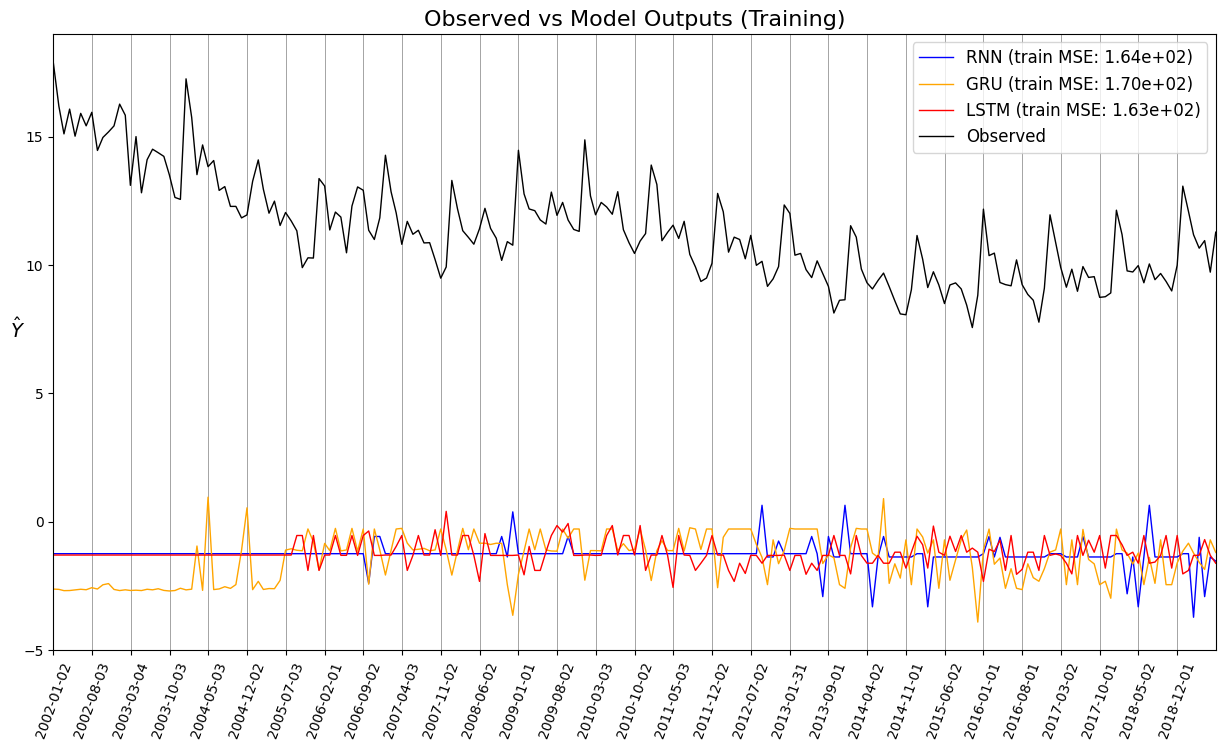

In [61]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params2[key]['pred_train'][l:u:ds]
    label = params2[key]['label'] + ' (train MSE: %.2e)' % params2[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params2[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

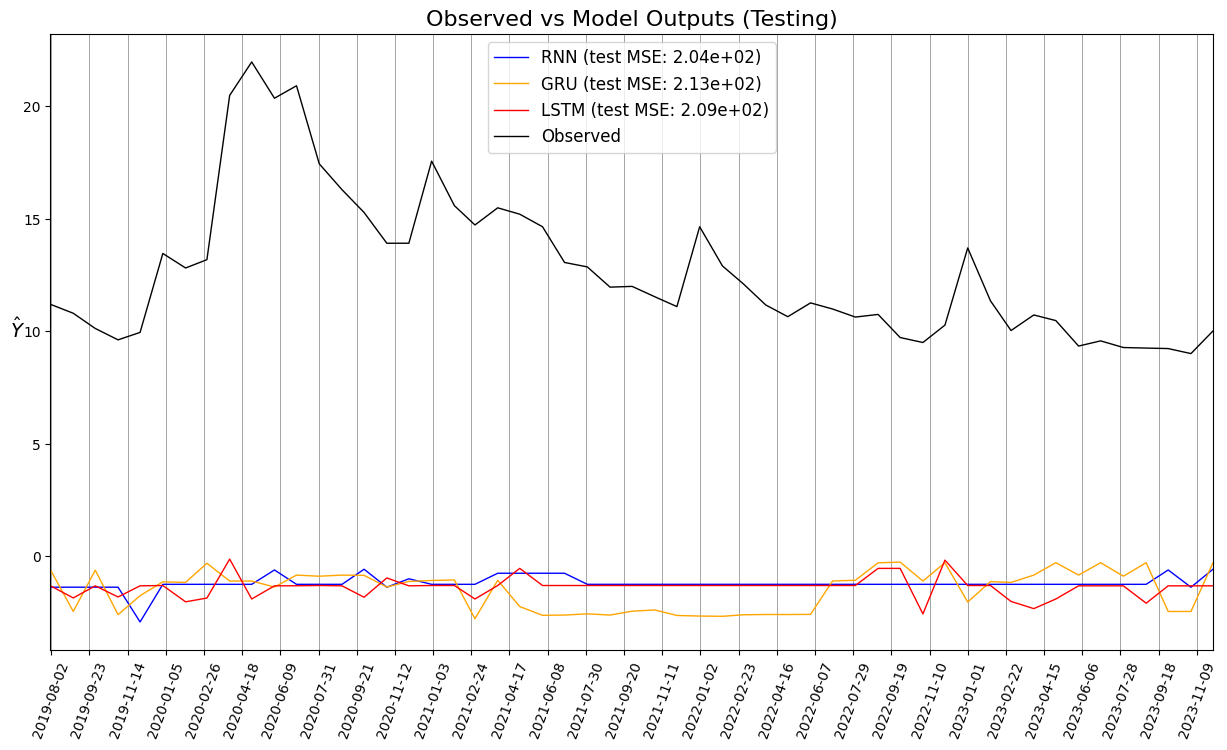

In [62]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params2[key]['pred_test'][l:u:ds]
    label = params2[key]['label'] + ' (test MSE: %.2e)' % params2[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params2[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

In [63]:
for key in params.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params[key]['MSE_test'])

El MSE de la red rnn en el conjunto de prueba es 139.85270827789708
El MSE de la red gru en el conjunto de prueba es 209.62178942483033
El MSE de la red lstm en el conjunto de prueba es 202.91266417677946


## Redes con covariables de estacionalidad

In [64]:
for key in params2.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params2[key]['MSE_test'])

El MSE de la red rnn en el conjunto de prueba es 203.87343851149123
El MSE de la red gru en el conjunto de prueba es 212.9692783435977
El MSE de la red lstm en el conjunto de prueba es 208.72764057221855


Paila

# Agregando estacionalidad para intentar mejorar pronósticos (Componentes de Fourier)
Agregar la estacionalidad con variables dummy no mejoró los pronósticos, tanto en entrenamiento como en prueba, estas fueron decepcionantes; añadiremos componentes de Fourier para intentar mejorar el modelamiento añadiendo estacionalidad.

In [72]:
AnioyMes = Data['AnioMes']
AnioyMes = AnioyMes.map(pd.Timestamp.timestamp) ###Convierte las fechas a float
month = 12
Data['MesSin'] = np.sin(AnioyMes * (2 * np.pi / month))
Data['MesCos'] = np.cos(AnioyMes * (2 * np.pi / month))
Data

AnioMes  TasaDesempleo        MesSin  MesCos
0   2023-12-01      10.013717 -8.046425e-08     1.0
1   2023-11-01       9.007386 -1.456126e-07     1.0
2   2023-10-01       9.230912 -1.294860e-07     1.0
3   2023-09-01       9.252674 -7.542502e-08     1.0
4   2023-08-01       9.277372 -5.929844e-08     1.0
..         ...            ...           ...     ...
271 2001-05-01      14.035800 -7.692323e-08     1.0
272 2001-04-01      14.515100 -8.246690e-08     1.0
273 2001-03-01      15.811900 -6.634033e-08     1.0
274 2001-02-01      17.434200 -5.561985e-08     1.0
275 2001-01-01      16.622300 -3.949327e-08     1.0

[276 rows x 4 columns]

No se ve prometedor.

Añadiendo las nuevas variables

In [77]:
anadir11 = Data.iloc[12:Partir+12,[2,3]]
anadir21 = Data.iloc[Partir+12:,[2,3]]

In [78]:
x_trainNew1 = np.concatenate((x_train, anadir11.values.reshape(211,2,1)), axis=1)
x_testNew1 = np.concatenate((x_test, anadir21.values.reshape(53,2,1)), axis=1)

In [80]:
params3 = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [81]:
do_training = True
#do_training = False
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params3.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params3[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=0, n_units=10)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_trainNew1, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params3[key]['H'] = grid_result.best_params_['n_units']
        params3[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   1.2s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   1.2s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   1.0s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   1.9s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.9s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.9s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.8s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.8s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.4s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.4s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.5s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.4s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 171.6329
Epoch 2/100
3/3 - 0s - 50ms/step - loss: 171.1647
Epoch 3/100
3/3 - 0s - 61ms/step - loss: 170.6972
Epoch 4/100
3/3 - 0s - 39ms/step - loss: 170.2304
Epoch 5/100
3/3 - 0s - 40ms/step - loss: 169.7644
Epoch 6/100
3/3 - 0s - 36ms/step - loss: 169.2991
Epoch 7/100
3/3 - 0s - 32ms/step - loss: 168.8347
Epoch 8/100
3/3 - 0s - 39ms/step - loss: 168.3712
Epoch 9/100
3/3 - 0s - 84ms/step - loss: 167.9084
Epoch 10/100
3/3 - 0s - 50ms/step - loss: 167.4466
Epoch 11/100
3/3 - 0s - 106ms/step - loss: 166.9857
Epoch 12/100
3/3 - 0s - 50ms/step - loss: 166.5257
Epoch 13/100
3/3 - 0s - 26ms/step - loss: 166.0665
Epoch 14/100
3/3 - 0s - 50ms/step - loss: 165.6084
Epoch 15/100
3/3 - 0s - 26ms/step - loss: 165.1511
Epoch 16/100
3/3 - 0s - 25ms/step - loss: 164.6948
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 164.2394
Epoch 18/100
3/3 - 0s - 27ms/step - loss: 163.7849
Epoch 19/100
3/3 - 0s - 26ms/step - loss: 163.3314
Epoch 20/100
3/3 - 0s - 27ms/step - loss: 162.8789
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 4s - 705ms/step - loss: 262.0261
Epoch 2/100
6/6 - 0s - 19ms/step - loss: 262.0534
Epoch 3/100
6/6 - 0s - 31ms/step - loss: 260.8928
Epoch 4/100
6/6 - 0s - 50ms/step - loss: 259.7358
Epoch 5/100
6/6 - 0s - 25ms/step - loss: 258.5828
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 257.4337
Epoch 7/100
6/6 - 0s - 25ms/step - loss: 256.2888
Epoch 8/100
6/6 - 0s - 28ms/step - loss: 255.1479
Epoch 9/100
6/6 - 0s - 28ms/step - loss: 254.0111
Epoch 10/100
6/6 - 0s - 28ms/step - loss: 252.8785
Epoch 11/100
6/6 - 0s - 28ms/step - loss: 251.7498
Epoch 12/100
6/6 - 0s - 24ms/step - loss: 250.6251
Epoch 13/100
6/6 - 0s - 55ms/step - loss: 249.5045
Epoch 14/100
6/6 - 0s - 33ms/step - loss: 248.3877
Epoch 15/100
6/6 - 0s - 33ms/step - loss: 247.2749
Epoch 16/100
6/6 - 0s - 22ms/step - loss: 246.1659
Epoch 17/100
6/6 - 0s - 31ms/step - loss: 245.0609
Epoch 18/100
6/6 - 0s - 28ms/step - loss: 243.9596
Epoch 19/100
6/6 - 0s - 17ms/step - loss: 242.8622
Epoch 20/100
6/6 - 0s - 22ms/step - loss: 241.7686


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
9/9 - 6s - 643ms/step - loss: 208.4183
Epoch 2/100
9/9 - 0s - 13ms/step - loss: 208.1556
Epoch 3/100
9/9 - 0s - 13ms/step - loss: 207.5943
Epoch 4/100
9/9 - 0s - 13ms/step - loss: 206.4891
Epoch 5/100
9/9 - 0s - 21ms/step - loss: 206.4268
Epoch 6/100
9/9 - 0s - 34ms/step - loss: 206.3501
Epoch 7/100
9/9 - 0s - 23ms/step - loss: 206.2712
Epoch 8/100
9/9 - 0s - 45ms/step - loss: 205.6747
Epoch 9/100
9/9 - 0s - 20ms/step - loss: 204.0986
Epoch 10/100
9/9 - 0s - 22ms/step - loss: 203.0847
Epoch 11/100
9/9 - 0s - 19ms/step - loss: 201.8184
Epoch 12/100
9/9 - 0s - 44ms/step - loss: 200.3117
Epoch 13/100
9/9 - 0s - 18ms/step - loss: 199.5894
Epoch 14/100
9/9 - 0s - 19ms/step - loss: 198.0470
Epoch 15/100
9/9 - 0s - 21ms/step - loss: 197.7554
Epoch 16/100
9/9 - 0s - 17ms/step - loss: 197.0714
Epoch 17/100
9/9 - 0s - 15ms/step - loss: 196.2968
Epoch 18/100
9/9 - 0s - 13ms/step - loss: 196.7169
Epoch 19/100
9/9 - 0s - 47ms/step - loss: 196.2673
Epoch 20/100
9/9 - 0s - 15ms/step - los

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
12/12 - 4s - 323ms/step - loss: 175.7341
Epoch 2/100
12/12 - 0s - 11ms/step - loss: 173.9238
Epoch 3/100
12/12 - 0s - 11ms/step - loss: 172.1260
Epoch 4/100
12/12 - 0s - 11ms/step - loss: 170.3425
Epoch 5/100
12/12 - 0s - 11ms/step - loss: 168.5740
Epoch 6/100
12/12 - 0s - 11ms/step - loss: 167.2233
Epoch 7/100
12/12 - 0s - 10ms/step - loss: 165.6362
Epoch 8/100
12/12 - 0s - 11ms/step - loss: 163.5851
Epoch 9/100
12/12 - 0s - 11ms/step - loss: 161.8262
Epoch 10/100
12/12 - 0s - 10ms/step - loss: 160.0816
Epoch 11/100
12/12 - 0s - 12ms/step - loss: 158.3527
Epoch 12/100
12/12 - 0s - 11ms/step - loss: 156.6397
Epoch 13/100
12/12 - 0s - 11ms/step - loss: 154.9424
Epoch 14/100
12/12 - 0s - 10ms/step - loss: 152.9232
Epoch 15/100
12/12 - 0s - 11ms/step - loss: 151.2294
Epoch 16/100
12/12 - 0s - 11ms/step - loss: 149.3778
Epoch 17/100
12/12 - 0s - 10ms/step - loss: 147.6071
Epoch 18/100
12/12 - 0s - 11ms/step - loss: 145.9571
Epoch 19/100
12/12 - 0s - 10ms/step - loss: 144.3233
E

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 243ms/step - loss: 164.3624
Epoch 2/100
15/15 - 0s - 10ms/step - loss: 162.3154
Epoch 3/100
15/15 - 0s - 9ms/step - loss: 160.7742
Epoch 4/100
15/15 - 0s - 9ms/step - loss: 158.4868
Epoch 5/100
15/15 - 0s - 9ms/step - loss: 157.1176
Epoch 6/100
15/15 - 0s - 10ms/step - loss: 156.6724
Epoch 7/100
15/15 - 0s - 10ms/step - loss: 154.4728
Epoch 8/100
15/15 - 0s - 9ms/step - loss: 152.2339
Epoch 9/100
15/15 - 0s - 9ms/step - loss: 150.6877
Epoch 10/100
15/15 - 0s - 9ms/step - loss: 149.4739
Epoch 11/100
15/15 - 0s - 9ms/step - loss: 147.9217
Epoch 12/100
15/15 - 0s - 8ms/step - loss: 145.1235
Epoch 13/100
15/15 - 0s - 9ms/step - loss: 142.1823
Epoch 14/100
15/15 - 0s - 12ms/step - loss: 140.1835
Epoch 15/100
15/15 - 0s - 10ms/step - loss: 136.6771
Epoch 16/100
15/15 - 0s - 10ms/step - loss: 132.2965
Epoch 17/100
15/15 - 0s - 12ms/step - loss: 128.8111
Epoch 18/100
15/15 - 0s - 10ms/step - loss: 126.4172
Epoch 19/100
15/15 - 0s - 10ms/step - loss: 124.2963
Epoch 20/100
15/15 - 0

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 322.0252
Epoch 2/100
3/3 - 0s - 28ms/step - loss: 320.8461
Epoch 3/100
3/3 - 0s - 28ms/step - loss: 319.6693
Epoch 4/100
3/3 - 0s - 28ms/step - loss: 318.4949
Epoch 5/100
3/3 - 0s - 28ms/step - loss: 317.3231
Epoch 6/100
3/3 - 0s - 56ms/step - loss: 316.1540
Epoch 7/100
3/3 - 0s - 33ms/step - loss: 314.9876
Epoch 8/100
3/3 - 0s - 33ms/step - loss: 313.8240
Epoch 9/100
3/3 - 0s - 33ms/step - loss: 312.6633
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 311.5056
Epoch 11/100
3/3 - 0s - 28ms/step - loss: 310.3509
Epoch 12/100
3/3 - 0s - 28ms/step - loss: 309.1991
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 308.0505
Epoch 14/100
3/3 - 0s - 33ms/step - loss: 306.9049
Epoch 15/100
3/3 - 0s - 56ms/step - loss: 305.7625
Epoch 16/100
3/3 - 0s - 33ms/step - loss: 304.6232
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 303.4870
Epoch 18/100
3/3 - 0s - 56ms/step - loss: 302.3540
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 301.2241
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 300.0974
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 4s - 672ms/step - loss: 234.7017
Epoch 2/100
6/6 - 0s - 22ms/step - loss: 232.8785
Epoch 3/100
6/6 - 0s - 19ms/step - loss: 230.9044
Epoch 4/100
6/6 - 0s - 31ms/step - loss: 228.1552
Epoch 5/100
6/6 - 0s - 19ms/step - loss: 226.5910
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 224.6521
Epoch 7/100
6/6 - 0s - 19ms/step - loss: 222.7255
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 220.7620
Epoch 9/100
6/6 - 0s - 22ms/step - loss: 218.2702
Epoch 10/100
6/6 - 0s - 19ms/step - loss: 216.6382
Epoch 11/100
6/6 - 0s - 31ms/step - loss: 214.7789
Epoch 12/100
6/6 - 0s - 25ms/step - loss: 212.9337
Epoch 13/100
6/6 - 0s - 22ms/step - loss: 211.1015
Epoch 14/100
6/6 - 0s - 22ms/step - loss: 209.2817
Epoch 15/100
6/6 - 0s - 19ms/step - loss: 207.4740
Epoch 16/100
6/6 - 0s - 22ms/step - loss: 205.6781
Epoch 17/100
6/6 - 0s - 28ms/step - loss: 203.8942
Epoch 18/100
6/6 - 0s - 21ms/step - loss: 202.1221
Epoch 19/100
6/6 - 0s - 24ms/step - loss: 200.3617
Epoch 20/100
6/6 - 0s - 22ms/step - loss: 198.6130


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 5s - 572ms/step - loss: 228.8611
Epoch 2/100
9/9 - 0s - 13ms/step - loss: 228.3877
Epoch 3/100
9/9 - 0s - 19ms/step - loss: 225.7011
Epoch 4/100
9/9 - 0s - 13ms/step - loss: 222.2671
Epoch 5/100
9/9 - 0s - 19ms/step - loss: 220.5024
Epoch 6/100
9/9 - 0s - 15ms/step - loss: 217.3199
Epoch 7/100
9/9 - 0s - 15ms/step - loss: 215.4895
Epoch 8/100
9/9 - 0s - 17ms/step - loss: 211.7277
Epoch 9/100
9/9 - 0s - 18ms/step - loss: 208.6883
Epoch 10/100
9/9 - 0s - 17ms/step - loss: 205.5121
Epoch 11/100
9/9 - 0s - 26ms/step - loss: 202.2472
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 199.7346
Epoch 13/100
9/9 - 0s - 15ms/step - loss: 198.6707
Epoch 14/100
9/9 - 0s - 17ms/step - loss: 196.0661
Epoch 15/100
9/9 - 0s - 18ms/step - loss: 192.6267
Epoch 16/100
9/9 - 0s - 15ms/step - loss: 190.0175
Epoch 17/100
9/9 - 0s - 15ms/step - loss: 186.2227
Epoch 18/100
9/9 - 0s - 15ms/step - loss: 183.6689
Epoch 19/100
9/9 - 0s - 13ms/step - loss: 182.0891
Epoch 20/100
9/9 - 0s - 13ms/step - loss: 179.9933


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 4s - 366ms/step - loss: 190.7914
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 188.5002
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 187.7401
Epoch 4/100
12/12 - 0s - 10ms/step - loss: 185.3104
Epoch 5/100
12/12 - 0s - 31ms/step - loss: 182.5749
Epoch 6/100
12/12 - 0s - 10ms/step - loss: 179.6752
Epoch 7/100
12/12 - 0s - 10ms/step - loss: 174.9144
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 172.7980
Epoch 9/100
12/12 - 0s - 10ms/step - loss: 168.6206
Epoch 10/100
12/12 - 0s - 17ms/step - loss: 164.0809
Epoch 11/100
12/12 - 0s - 10ms/step - loss: 163.2717
Epoch 12/100
12/12 - 0s - 10ms/step - loss: 163.0484
Epoch 13/100
12/12 - 0s - 10ms/step - loss: 162.1919
Epoch 14/100
12/12 - 0s - 10ms/step - loss: 163.8389
Epoch 15/100
12/12 - 0s - 10ms/step - loss: 162.6277
Epoch 16/100
12/12 - 0s - 11ms/step - loss: 162.7932
Epoch 17/100
12/12 - 0s - 10ms/step - loss: 163.0249
Epoch 18/100
12/12 - 0s - 10ms/step - loss: 166.1947
Epoch 19/100
12/12 - 0s - 10ms/step - loss: 164.0220
Epoch 20/100
1

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 253ms/step - loss: 183.6243
Epoch 2/100
15/15 - 0s - 11ms/step - loss: 182.3813
Epoch 3/100
15/15 - 0s - 10ms/step - loss: 178.4232
Epoch 4/100
15/15 - 0s - 9ms/step - loss: 173.1359
Epoch 5/100
15/15 - 0s - 9ms/step - loss: 167.8083
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 162.8463
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 158.7605
Epoch 8/100
15/15 - 0s - 8ms/step - loss: 155.7183
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 152.3042
Epoch 10/100
15/15 - 0s - 9ms/step - loss: 148.1744
Epoch 11/100
15/15 - 0s - 9ms/step - loss: 145.1154
Epoch 12/100
15/15 - 0s - 9ms/step - loss: 143.2003
Epoch 13/100
15/15 - 0s - 9ms/step - loss: 139.8223
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 135.9240
Epoch 15/100
15/15 - 0s - 9ms/step - loss: 132.5442
Epoch 16/100
15/15 - 0s - 9ms/step - loss: 128.9389
Epoch 17/100
15/15 - 0s - 9ms/step - loss: 125.6806
Epoch 18/100
15/15 - 0s - 11ms/step - loss: 124.8551
Epoch 19/100
15/15 - 0s - 9ms/step - loss: 123.7212
Epoch 20/100
15/15 - 0s - 8m

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 1s/step - loss: 274.5928
Epoch 2/100
3/3 - 0s - 28ms/step - loss: 272.8291
Epoch 3/100
3/3 - 0s - 23ms/step - loss: 271.3339
Epoch 4/100
3/3 - 0s - 27ms/step - loss: 269.5353
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 267.7428
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 264.9337
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 263.1013
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 260.1086
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 258.3661
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 255.8807
Epoch 11/100
3/3 - 0s - 25ms/step - loss: 252.0873
Epoch 12/100
3/3 - 0s - 18ms/step - loss: 250.4218
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 249.0054
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 248.7028
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 243.8110
Epoch 16/100
3/3 - 0s - 23ms/step - loss: 241.5510
Epoch 17/100
3/3 - 0s - 21ms/step - loss: 242.2133
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 236.0946
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 234.9453
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 233.8042
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 4s - 647ms/step - loss: 223.7447
Epoch 2/100
6/6 - 0s - 13ms/step - loss: 215.8911
Epoch 3/100
6/6 - 0s - 19ms/step - loss: 213.0403
Epoch 4/100
6/6 - 0s - 25ms/step - loss: 208.8755
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 202.1320
Epoch 6/100
6/6 - 0s - 34ms/step - loss: 198.6739
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 196.0094
Epoch 8/100
6/6 - 0s - 16ms/step - loss: 193.0593
Epoch 9/100
6/6 - 0s - 11ms/step - loss: 190.6089
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 189.0126
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 192.1050
Epoch 12/100
6/6 - 0s - 18ms/step - loss: 193.6982
Epoch 13/100
6/6 - 0s - 23ms/step - loss: 195.1682
Epoch 14/100
6/6 - 0s - 18ms/step - loss: 194.7656
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 195.5935
Epoch 16/100
6/6 - 0s - 15ms/step - loss: 197.4409
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 195.1153
Epoch 18/100
6/6 - 0s - 18ms/step - loss: 193.4942
Epoch 19/100
6/6 - 0s - 16ms/step - loss: 191.8039
Epoch 20/100
6/6 - 0s - 16ms/step - loss: 190.9274


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
9/9 - 17s - 2s/step - loss: 198.3009
Epoch 2/100
9/9 - 0s - 54ms/step - loss: 192.4405
Epoch 3/100
9/9 - 0s - 30ms/step - loss: 188.9925
Epoch 4/100
9/9 - 0s - 50ms/step - loss: 182.0592
Epoch 5/100
9/9 - 1s - 67ms/step - loss: 178.1178
Epoch 6/100
9/9 - 0s - 32ms/step - loss: 174.3847
Epoch 7/100
9/9 - 0s - 38ms/step - loss: 170.4510
Epoch 8/100
9/9 - 0s - 24ms/step - loss: 165.2902
Epoch 9/100
9/9 - 0s - 41ms/step - loss: 161.9978
Epoch 10/100
9/9 - 0s - 55ms/step - loss: 163.6287
Epoch 11/100
9/9 - 0s - 27ms/step - loss: 170.4921
Epoch 12/100
9/9 - 0s - 42ms/step - loss: 176.9570
Epoch 13/100
9/9 - 0s - 15ms/step - loss: 181.2409
Epoch 14/100
9/9 - 0s - 47ms/step - loss: 185.8281
Epoch 15/100
9/9 - 0s - 34ms/step - loss: 182.3868
Epoch 16/100
9/9 - 0s - 40ms/step - loss: 176.8529
Epoch 17/100
9/9 - 0s - 36ms/step - loss: 172.6273
Epoch 18/100
9/9 - 0s - 38ms/step - loss: 167.4167
Epoch 19/100
9/9 - 0s - 16ms/step - loss: 162.2844
Epoch 20/100
9/9 - 0s - 15ms/step - loss:

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 4s - 303ms/step - loss: 195.2851
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 187.2623
Epoch 3/100
12/12 - 0s - 8ms/step - loss: 177.6375
Epoch 4/100
12/12 - 0s - 8ms/step - loss: 163.3322
Epoch 5/100
12/12 - 0s - 11ms/step - loss: 150.2505
Epoch 6/100
12/12 - 0s - 14ms/step - loss: 140.8435
Epoch 7/100
12/12 - 0s - 10ms/step - loss: 146.9125
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 153.5481
Epoch 9/100
12/12 - 0s - 14ms/step - loss: 152.1951
Epoch 10/100
12/12 - 0s - 8ms/step - loss: 149.0814
Epoch 11/100
12/12 - 0s - 13ms/step - loss: 146.6631
Epoch 12/100
12/12 - 0s - 13ms/step - loss: 145.5262
Epoch 13/100
12/12 - 0s - 10ms/step - loss: 148.2352
Epoch 14/100
12/12 - 0s - 11ms/step - loss: 148.8475
Epoch 15/100
12/12 - 0s - 14ms/step - loss: 149.4780
Epoch 16/100
12/12 - 0s - 12ms/step - loss: 152.9788
Epoch 17/100
12/12 - 0s - 11ms/step - loss: 153.7010
Epoch 18/100
12/12 - 0s - 11ms/step - loss: 150.2910
Epoch 19/100
12/12 - 0s - 11ms/step - loss: 149.4076
Epoch 20/100
12/12

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 294ms/step - loss: 174.6708
Epoch 2/100
15/15 - 0s - 9ms/step - loss: 169.4454
Epoch 3/100
15/15 - 0s - 9ms/step - loss: 162.9954
Epoch 4/100
15/15 - 0s - 10ms/step - loss: 160.4487
Epoch 5/100
15/15 - 0s - 11ms/step - loss: 157.3818
Epoch 6/100
15/15 - 0s - 23ms/step - loss: 158.6269
Epoch 7/100
15/15 - 0s - 10ms/step - loss: 161.6662
Epoch 8/100
15/15 - 0s - 9ms/step - loss: 161.7171
Epoch 9/100
15/15 - 0s - 12ms/step - loss: 158.7470
Epoch 10/100
15/15 - 0s - 10ms/step - loss: 153.7948
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 149.0852
Epoch 12/100
15/15 - 0s - 9ms/step - loss: 143.6491
Epoch 13/100
15/15 - 0s - 10ms/step - loss: 138.2533
Epoch 14/100
15/15 - 0s - 9ms/step - loss: 133.2188
Epoch 15/100
15/15 - 0s - 9ms/step - loss: 125.5370
Epoch 16/100
15/15 - 0s - 10ms/step - loss: 122.7321
Epoch 17/100
15/15 - 0s - 10ms/step - loss: 115.6701
Epoch 18/100
15/15 - 0s - 11ms/step - loss: 111.4779
Epoch 19/100
15/15 - 0s - 21ms/step - loss: 101.4564
Epoch 20/100
15/15 -

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 5s - 2s/step - loss: 279.0267
Epoch 2/100
3/3 - 0s - 22ms/step - loss: 278.4280
Epoch 3/100
3/3 - 0s - 28ms/step - loss: 277.8300
Epoch 4/100
3/3 - 0s - 28ms/step - loss: 277.2326
Epoch 5/100
3/3 - 0s - 25ms/step - loss: 276.6361
Epoch 6/100
3/3 - 0s - 56ms/step - loss: 276.0404
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 275.4454
Epoch 8/100
3/3 - 0s - 33ms/step - loss: 274.8513
Epoch 9/100
3/3 - 0s - 28ms/step - loss: 274.2581
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 273.6658
Epoch 11/100
3/3 - 0s - 32ms/step - loss: 273.0743
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 272.4838
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 271.8942
Epoch 14/100
3/3 - 0s - 28ms/step - loss: 271.3055
Epoch 15/100
3/3 - 0s - 24ms/step - loss: 270.7177
Epoch 16/100
3/3 - 0s - 19ms/step - loss: 270.1309
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 269.5450
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 268.9601
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 268.3761
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 267.7930
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 4s - 661ms/step - loss: 231.9620
Epoch 2/100
6/6 - 0s - 17ms/step - loss: 231.7127
Epoch 3/100
6/6 - 0s - 17ms/step - loss: 230.6346
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 229.5599
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 228.4889
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 227.6770
Epoch 7/100
6/6 - 0s - 31ms/step - loss: 226.6008
Epoch 8/100
6/6 - 0s - 28ms/step - loss: 225.5277
Epoch 9/100
6/6 - 0s - 17ms/step - loss: 224.4583
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 223.3929
Epoch 11/100
6/6 - 0s - 28ms/step - loss: 222.3315
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 221.2743
Epoch 13/100
6/6 - 0s - 16ms/step - loss: 220.2211
Epoch 14/100
6/6 - 0s - 20ms/step - loss: 219.1720
Epoch 15/100
6/6 - 0s - 20ms/step - loss: 218.1270
Epoch 16/100
6/6 - 0s - 20ms/step - loss: 217.0860
Epoch 17/100
6/6 - 0s - 15ms/step - loss: 216.0489
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 215.0157
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 213.9864
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 212.9610


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 4s - 414ms/step - loss: 169.9791
Epoch 2/100
9/9 - 0s - 11ms/step - loss: 166.2977
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 164.6516
Epoch 4/100
9/9 - 0s - 15ms/step - loss: 163.4624
Epoch 5/100
9/9 - 0s - 13ms/step - loss: 162.2787
Epoch 6/100
9/9 - 0s - 22ms/step - loss: 159.1012
Epoch 7/100
9/9 - 0s - 10ms/step - loss: 156.8673
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 154.4335
Epoch 9/100
9/9 - 0s - 19ms/step - loss: 153.0990
Epoch 10/100
9/9 - 0s - 13ms/step - loss: 150.8009
Epoch 11/100
9/9 - 0s - 12ms/step - loss: 148.6770
Epoch 12/100
9/9 - 0s - 10ms/step - loss: 147.4586
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 145.9341
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 143.8526
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 142.7233
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 141.7560
Epoch 17/100
9/9 - 0s - 20ms/step - loss: 140.0466
Epoch 18/100
9/9 - 0s - 17ms/step - loss: 139.0896
Epoch 19/100
9/9 - 0s - 16ms/step - loss: 137.3163
Epoch 20/100
9/9 - 0s - 14ms/step - loss: 136.1406


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 4s - 333ms/step - loss: 209.6755
Epoch 2/100
12/12 - 0s - 11ms/step - loss: 207.5403
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 205.5477
Epoch 4/100
12/12 - 0s - 11ms/step - loss: 203.7788
Epoch 5/100
12/12 - 0s - 10ms/step - loss: 201.8818
Epoch 6/100
12/12 - 0s - 10ms/step - loss: 199.9012
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 198.4134
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 196.6655
Epoch 9/100
12/12 - 0s - 10ms/step - loss: 194.7123
Epoch 10/100
12/12 - 0s - 11ms/step - loss: 192.7747
Epoch 11/100
12/12 - 0s - 10ms/step - loss: 190.8533
Epoch 12/100
12/12 - 0s - 10ms/step - loss: 188.9476
Epoch 13/100
12/12 - 0s - 10ms/step - loss: 187.0576
Epoch 14/100
12/12 - 0s - 11ms/step - loss: 185.1829
Epoch 15/100
12/12 - 0s - 12ms/step - loss: 183.3234
Epoch 16/100
12/12 - 0s - 11ms/step - loss: 181.4787
Epoch 17/100
12/12 - 0s - 12ms/step - loss: 179.6489
Epoch 18/100
12/12 - 0s - 14ms/step - loss: 177.8337
Epoch 19/100
12/12 - 0s - 10ms/step - loss: 176.0329
Epoch 20/100
12

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 263ms/step - loss: 153.0881
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 151.3577
Epoch 3/100
15/15 - 0s - 9ms/step - loss: 149.7331
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 148.1610
Epoch 5/100
15/15 - 0s - 13ms/step - loss: 146.1835
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 144.8026
Epoch 7/100
15/15 - 0s - 9ms/step - loss: 143.3407
Epoch 8/100
15/15 - 0s - 12ms/step - loss: 141.9067
Epoch 9/100
15/15 - 0s - 10ms/step - loss: 140.2135
Epoch 10/100
15/15 - 0s - 10ms/step - loss: 139.0451
Epoch 11/100
15/15 - 0s - 9ms/step - loss: 137.3111
Epoch 12/100
15/15 - 0s - 9ms/step - loss: 136.0181
Epoch 13/100
15/15 - 0s - 10ms/step - loss: 133.9301
Epoch 14/100
15/15 - 0s - 10ms/step - loss: 131.6177
Epoch 15/100
15/15 - 0s - 9ms/step - loss: 129.2772
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 127.8713
Epoch 17/100
15/15 - 0s - 12ms/step - loss: 126.0335
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 124.2007
Epoch 19/100
15/15 - 0s - 9ms/step - loss: 121.3213
Epoch 20/100
15/15 - 0s 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 293.5186
Epoch 2/100
3/3 - 0s - 28ms/step - loss: 292.3931
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 291.2699
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 290.1493
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 289.0311
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 287.9156
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 286.8029
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 285.6929
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 284.5858
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 283.4818
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 282.3806
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 281.2826
Epoch 13/100
3/3 - 0s - 23ms/step - loss: 280.1876
Epoch 14/100
3/3 - 0s - 28ms/step - loss: 279.0956
Epoch 15/100
3/3 - 0s - 27ms/step - loss: 278.0068
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 276.9212
Epoch 17/100
3/3 - 0s - 24ms/step - loss: 275.8386
Epoch 18/100
3/3 - 0s - 26ms/step - loss: 274.7592
Epoch 19/100
3/3 - 0s - 55ms/step - loss: 273.6830
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 272.6099
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 4s - 622ms/step - loss: 167.6526
Epoch 2/100
6/6 - 0s - 14ms/step - loss: 165.0836
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 164.9655
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 163.5403
Epoch 5/100
6/6 - 0s - 17ms/step - loss: 164.6701
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 161.7215
Epoch 7/100
6/6 - 0s - 20ms/step - loss: 160.1754
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 159.6138
Epoch 9/100
6/6 - 0s - 18ms/step - loss: 158.2416
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 156.7375
Epoch 11/100
6/6 - 0s - 19ms/step - loss: 155.2452
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 153.7643
Epoch 13/100
6/6 - 0s - 19ms/step - loss: 152.2943
Epoch 14/100
6/6 - 0s - 17ms/step - loss: 150.8354
Epoch 15/100
6/6 - 0s - 19ms/step - loss: 149.3875
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 147.9504
Epoch 17/100
6/6 - 0s - 17ms/step - loss: 146.5242
Epoch 18/100
6/6 - 0s - 28ms/step - loss: 145.1090
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 143.7046
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 142.3111


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 4s - 439ms/step - loss: 240.1502
Epoch 2/100
9/9 - 0s - 11ms/step - loss: 240.8192
Epoch 3/100
9/9 - 0s - 20ms/step - loss: 239.8432
Epoch 4/100
9/9 - 0s - 13ms/step - loss: 239.5632
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 236.8556
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 237.0872
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 235.6854
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 234.0949
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 233.6846
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 230.3212
Epoch 11/100
9/9 - 0s - 19ms/step - loss: 228.2699
Epoch 12/100
9/9 - 0s - 17ms/step - loss: 226.4299
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 223.5790
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 220.7939
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 217.7689
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 214.7820
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 212.4728
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 209.8291
Epoch 19/100
9/9 - 0s - 12ms/step - loss: 207.4600
Epoch 20/100
9/9 - 0s - 15ms/step - loss: 205.1201


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 4s - 297ms/step - loss: 184.8652
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 183.3209
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 182.3758
Epoch 4/100
12/12 - 0s - 8ms/step - loss: 179.3210
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 177.9996
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 175.7906
Epoch 7/100
12/12 - 0s - 10ms/step - loss: 170.7245
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 165.4090
Epoch 9/100
12/12 - 0s - 8ms/step - loss: 160.6376
Epoch 10/100
12/12 - 0s - 9ms/step - loss: 158.5881
Epoch 11/100
12/12 - 0s - 9ms/step - loss: 157.1622
Epoch 12/100
12/12 - 0s - 14ms/step - loss: 154.6505
Epoch 13/100
12/12 - 0s - 13ms/step - loss: 152.4147
Epoch 14/100
12/12 - 0s - 14ms/step - loss: 150.0321
Epoch 15/100
12/12 - 0s - 10ms/step - loss: 148.1896
Epoch 16/100
12/12 - 0s - 11ms/step - loss: 146.6274
Epoch 17/100
12/12 - 0s - 9ms/step - loss: 144.7453
Epoch 18/100
12/12 - 0s - 14ms/step - loss: 142.2208
Epoch 19/100
12/12 - 0s - 10ms/step - loss: 140.0750
Epoch 20/100
12/12 - 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 256ms/step - loss: 183.2960
Epoch 2/100
15/15 - 0s - 10ms/step - loss: 181.5278
Epoch 3/100
15/15 - 0s - 9ms/step - loss: 179.1398
Epoch 4/100
15/15 - 0s - 10ms/step - loss: 177.0175
Epoch 5/100
15/15 - 0s - 10ms/step - loss: 173.3989
Epoch 6/100
15/15 - 0s - 11ms/step - loss: 168.5928
Epoch 7/100
15/15 - 0s - 11ms/step - loss: 166.0878
Epoch 8/100
15/15 - 0s - 9ms/step - loss: 161.0738
Epoch 9/100
15/15 - 0s - 9ms/step - loss: 155.1678
Epoch 10/100
15/15 - 0s - 10ms/step - loss: 151.1202
Epoch 11/100
15/15 - 0s - 10ms/step - loss: 146.3867
Epoch 12/100
15/15 - 0s - 12ms/step - loss: 141.9847
Epoch 13/100
15/15 - 0s - 9ms/step - loss: 138.7286
Epoch 14/100
15/15 - 0s - 10ms/step - loss: 136.8438
Epoch 15/100
15/15 - 0s - 9ms/step - loss: 132.8854
Epoch 16/100
15/15 - 0s - 9ms/step - loss: 129.4102
Epoch 17/100
15/15 - 0s - 8ms/step - loss: 126.9922
Epoch 18/100
15/15 - 0s - 10ms/step - loss: 125.5011
Epoch 19/100
15/15 - 0s - 11ms/step - loss: 121.9110
Epoch 20/100
15/15 -

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 250.1230
Epoch 2/100
3/3 - 0s - 28ms/step - loss: 254.6244
Epoch 3/100
3/3 - 0s - 28ms/step - loss: 252.9303
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 251.3365
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 249.7447
Epoch 6/100
3/3 - 0s - 33ms/step - loss: 248.1579
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 252.4600
Epoch 8/100
3/3 - 0s - 28ms/step - loss: 257.4657
Epoch 9/100
3/3 - 0s - 33ms/step - loss: 255.0221
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 259.1620
Epoch 11/100
3/3 - 0s - 28ms/step - loss: 260.4978
Epoch 12/100
3/3 - 0s - 23ms/step - loss: 261.7930
Epoch 13/100
3/3 - 0s - 29ms/step - loss: 259.7034
Epoch 14/100
3/3 - 0s - 24ms/step - loss: 257.6118
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 255.5267
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 256.2264
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 256.7885
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 254.6033
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 252.4254
Epoch 20/100
3/3 - 0s - 33ms/step - loss: 250.2604
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 4s - 597ms/step - loss: 248.8225
Epoch 2/100
6/6 - 0s - 14ms/step - loss: 246.7167
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 240.8037
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 235.2847
Epoch 5/100
6/6 - 0s - 13ms/step - loss: 230.8659
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 228.7557
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 225.1159
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 221.8196
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 216.3329
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 207.5707
Epoch 11/100
6/6 - 0s - 11ms/step - loss: 203.7128
Epoch 12/100
6/6 - 0s - 25ms/step - loss: 201.1301
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 195.2592
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 193.4317
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 189.0463
Epoch 16/100
6/6 - 0s - 28ms/step - loss: 186.5140
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 184.1818
Epoch 18/100
6/6 - 0s - 17ms/step - loss: 181.5556
Epoch 19/100
6/6 - 0s - 17ms/step - loss: 178.7083
Epoch 20/100
6/6 - 0s - 17ms/step - loss: 182.7305


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 4s - 400ms/step - loss: 163.7170
Epoch 2/100
9/9 - 0s - 9ms/step - loss: 159.2811
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 155.0703
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 150.8864
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 170.4158
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 172.7652
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 171.3685
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 171.1690
Epoch 9/100
9/9 - 0s - 10ms/step - loss: 172.3188
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 171.1733
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 170.5922
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 166.4534
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 162.9575
Epoch 14/100
9/9 - 0s - 9ms/step - loss: 160.8429
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 157.4603
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 154.1750
Epoch 17/100
9/9 - 0s - 9ms/step - loss: 151.1509
Epoch 18/100
9/9 - 0s - 9ms/step - loss: 149.0071
Epoch 19/100
9/9 - 0s - 11ms/step - loss: 146.1519
Epoch 20/100
9/9 - 0s - 9ms/step - loss: 143.5503
Epoch 2

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 4s - 308ms/step - loss: 191.4625
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 189.1594
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 185.9922
Epoch 4/100
12/12 - 0s - 14ms/step - loss: 185.7698
Epoch 5/100
12/12 - 0s - 10ms/step - loss: 181.2564
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 181.2319
Epoch 7/100
12/12 - 0s - 10ms/step - loss: 179.7418
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 177.7599
Epoch 9/100
12/12 - 0s - 8ms/step - loss: 169.6272
Epoch 10/100
12/12 - 0s - 7ms/step - loss: 168.3098
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 159.2129
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 157.7437
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 157.5974
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 159.2043
Epoch 15/100
12/12 - 0s - 8ms/step - loss: 160.1427
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 161.9001
Epoch 17/100
12/12 - 0s - 8ms/step - loss: 170.0678
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 172.8834
Epoch 19/100
12/12 - 0s - 10ms/step - loss: 163.9060
Epoch 20/100
12/12 - 0s - 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 251ms/step - loss: 189.5622
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 184.2922
Epoch 3/100
15/15 - 0s - 23ms/step - loss: 175.8350
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 169.3002
Epoch 5/100
15/15 - 0s - 10ms/step - loss: 168.2016
Epoch 6/100
15/15 - 0s - 11ms/step - loss: 163.6840
Epoch 7/100
15/15 - 0s - 10ms/step - loss: 159.1199
Epoch 8/100
15/15 - 0s - 9ms/step - loss: 153.0686
Epoch 9/100
15/15 - 0s - 9ms/step - loss: 149.1281
Epoch 10/100
15/15 - 0s - 9ms/step - loss: 147.9843
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 139.9122
Epoch 12/100
15/15 - 0s - 9ms/step - loss: 135.9037
Epoch 13/100
15/15 - 0s - 9ms/step - loss: 132.2977
Epoch 14/100
15/15 - 0s - 9ms/step - loss: 136.8315
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 146.7852
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 144.9309
Epoch 17/100
15/15 - 0s - 8ms/step - loss: 147.1929
Epoch 18/100
15/15 - 0s - 8ms/step - loss: 142.6415
Epoch 19/100
15/15 - 0s - 9ms/step - loss: 140.6170
Epoch 20/100
15/15 - 0s - 7

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 1s/step - loss: 279.5225
Epoch 2/100
3/3 - 0s - 22ms/step - loss: 278.9221
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 278.3225
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 277.7236
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 277.1254
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 276.5280
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 275.9315
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 275.3358
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 274.7410
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 274.1470
Epoch 11/100
3/3 - 0s - 56ms/step - loss: 273.5539
Epoch 12/100
3/3 - 0s - 26ms/step - loss: 272.9618
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 272.3705
Epoch 14/100
3/3 - 0s - 28ms/step - loss: 271.7802
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 271.1908
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 270.6024
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 270.0149
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 269.4283
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 268.8427
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 268.2580
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 4s - 597ms/step - loss: 222.1955
Epoch 2/100
6/6 - 0s - 31ms/step - loss: 221.0478
Epoch 3/100
6/6 - 0s - 19ms/step - loss: 220.0699
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 219.0952
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 218.1238
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 217.1560
Epoch 7/100
6/6 - 0s - 15ms/step - loss: 216.1918
Epoch 8/100
6/6 - 0s - 12ms/step - loss: 215.2311
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 214.2740
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 213.3205
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 212.3705
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 211.7425
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 211.0442
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 210.0670
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 209.3892
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 208.8979
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 208.0988
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 207.0528
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 206.0051
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 205.1285


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 4s - 394ms/step - loss: 247.6480
Epoch 2/100
9/9 - 0s - 20ms/step - loss: 245.6280
Epoch 3/100
9/9 - 0s - 13ms/step - loss: 243.9847
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 242.3487
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 240.7204
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 238.3660
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 236.0447
Epoch 8/100
9/9 - 0s - 9ms/step - loss: 233.4631
Epoch 9/100
9/9 - 0s - 9ms/step - loss: 231.9466
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 229.8252
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 228.9506
Epoch 12/100
9/9 - 0s - 9ms/step - loss: 227.4641
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 226.9526
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 225.2875
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 223.7792
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 222.2739
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 220.7746
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 219.2823
Epoch 19/100
9/9 - 0s - 9ms/step - loss: 217.7975
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 216.3202
Epoch

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 4s - 297ms/step - loss: 180.1727
Epoch 2/100
12/12 - 0s - 10ms/step - loss: 178.3228
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 176.4854
Epoch 4/100
12/12 - 0s - 10ms/step - loss: 174.6628
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 172.8554
Epoch 6/100
12/12 - 0s - 9ms/step - loss: 171.0632
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 168.8809
Epoch 8/100
12/12 - 0s - 8ms/step - loss: 166.9184
Epoch 9/100
12/12 - 0s - 8ms/step - loss: 164.9086
Epoch 10/100
12/12 - 0s - 10ms/step - loss: 163.1257
Epoch 11/100
12/12 - 0s - 11ms/step - loss: 161.2257
Epoch 12/100
12/12 - 0s - 10ms/step - loss: 159.4563
Epoch 13/100
12/12 - 0s - 11ms/step - loss: 157.7017
Epoch 14/100
12/12 - 0s - 11ms/step - loss: 155.9630
Epoch 15/100
12/12 - 0s - 10ms/step - loss: 154.9410
Epoch 16/100
12/12 - 0s - 10ms/step - loss: 153.2422
Epoch 17/100
12/12 - 0s - 10ms/step - loss: 150.9655
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 149.2781
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 147.9302
Epoch 20/100
12/12 -

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 244ms/step - loss: 172.0746
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 170.4313
Epoch 3/100
15/15 - 0s - 8ms/step - loss: 168.8314
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 167.4454
Epoch 5/100
15/15 - 0s - 7ms/step - loss: 166.3330
Epoch 6/100
15/15 - 0s - 10ms/step - loss: 164.9600
Epoch 7/100
15/15 - 0s - 8ms/step - loss: 163.6048
Epoch 8/100
15/15 - 0s - 8ms/step - loss: 161.9379
Epoch 9/100
15/15 - 0s - 8ms/step - loss: 159.8922
Epoch 10/100
15/15 - 0s - 8ms/step - loss: 157.6745
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 156.0258
Epoch 12/100
15/15 - 0s - 11ms/step - loss: 153.8232
Epoch 13/100
15/15 - 0s - 12ms/step - loss: 151.6395
Epoch 14/100
15/15 - 0s - 10ms/step - loss: 149.6846
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 147.1946
Epoch 16/100
15/15 - 0s - 9ms/step - loss: 144.8463
Epoch 17/100
15/15 - 0s - 15ms/step - loss: 141.5573
Epoch 18/100
15/15 - 0s - 12ms/step - loss: 138.6445
Epoch 19/100
15/15 - 0s - 9ms/step - loss: 135.3185
Epoch 20/100
15/15 - 0s -

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 1s/step - loss: 231.9673
Epoch 2/100
3/3 - 0s - 28ms/step - loss: 230.9662
Epoch 3/100
3/3 - 0s - 26ms/step - loss: 229.9673
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 228.9710
Epoch 5/100
3/3 - 0s - 28ms/step - loss: 227.9772
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 226.9860
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 225.9976
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 225.0120
Epoch 9/100
3/3 - 0s - 28ms/step - loss: 224.0293
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 223.0496
Epoch 11/100
3/3 - 0s - 28ms/step - loss: 222.0728
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 221.0990
Epoch 13/100
3/3 - 0s - 28ms/step - loss: 220.1284
Epoch 14/100
3/3 - 0s - 28ms/step - loss: 219.1608
Epoch 15/100
3/3 - 0s - 31ms/step - loss: 218.1963
Epoch 16/100
3/3 - 0s - 21ms/step - loss: 217.2349
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 216.2767
Epoch 18/100
3/3 - 0s - 32ms/step - loss: 215.3216
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 214.3697
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 213.4209
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 3s - 558ms/step - loss: 199.6811
Epoch 2/100
6/6 - 0s - 11ms/step - loss: 200.1433
Epoch 3/100
6/6 - 0s - 11ms/step - loss: 197.3776
Epoch 4/100
6/6 - 0s - 11ms/step - loss: 198.1693
Epoch 5/100
6/6 - 0s - 11ms/step - loss: 195.6339
Epoch 6/100
6/6 - 0s - 11ms/step - loss: 195.8000
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 195.3177
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 193.6637
Epoch 9/100
6/6 - 0s - 15ms/step - loss: 195.9865
Epoch 10/100
6/6 - 0s - 13ms/step - loss: 193.7231
Epoch 11/100
6/6 - 0s - 11ms/step - loss: 195.2693
Epoch 12/100
6/6 - 0s - 11ms/step - loss: 194.3648
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 194.1563
Epoch 14/100
6/6 - 0s - 13ms/step - loss: 194.8840
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 192.9657
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 192.0267
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 190.5393
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 188.6509
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 187.8141
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 185.6841


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 3s - 383ms/step - loss: 155.0872
Epoch 2/100
9/9 - 0s - 9ms/step - loss: 152.0251
Epoch 3/100
9/9 - 0s - 9ms/step - loss: 149.0772
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 147.4395
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 144.6455
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 142.3096
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 140.0630
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 137.8828
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 134.7948
Epoch 10/100
9/9 - 0s - 20ms/step - loss: 132.2383
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 131.1903
Epoch 12/100
9/9 - 0s - 10ms/step - loss: 128.2017
Epoch 13/100
9/9 - 0s - 9ms/step - loss: 126.9339
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 125.1796
Epoch 15/100
9/9 - 0s - 9ms/step - loss: 122.7753
Epoch 16/100
9/9 - 0s - 9ms/step - loss: 119.9597
Epoch 17/100
9/9 - 0s - 11ms/step - loss: 118.2632
Epoch 18/100
9/9 - 0s - 9ms/step - loss: 116.8196
Epoch 19/100
9/9 - 0s - 20ms/step - loss: 114.4535
Epoch 20/100
9/9 - 0s - 13ms/step - loss: 111.9933
Epoch 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 3s - 292ms/step - loss: 172.4090
Epoch 2/100
12/12 - 0s - 8ms/step - loss: 167.9172
Epoch 3/100
12/12 - 0s - 8ms/step - loss: 166.6067
Epoch 4/100
12/12 - 0s - 8ms/step - loss: 163.8379
Epoch 5/100
12/12 - 0s - 8ms/step - loss: 159.7154
Epoch 6/100
12/12 - 0s - 8ms/step - loss: 156.2194
Epoch 7/100
12/12 - 0s - 8ms/step - loss: 151.6616
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 149.0024
Epoch 9/100
12/12 - 0s - 8ms/step - loss: 145.9266
Epoch 10/100
12/12 - 0s - 8ms/step - loss: 142.9912
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 139.6988
Epoch 12/100
12/12 - 0s - 8ms/step - loss: 136.7487
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 134.5613
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 131.8076
Epoch 15/100
12/12 - 0s - 10ms/step - loss: 129.1025
Epoch 16/100
12/12 - 0s - 8ms/step - loss: 126.4448
Epoch 17/100
12/12 - 0s - 7ms/step - loss: 123.8342
Epoch 18/100
12/12 - 0s - 8ms/step - loss: 121.2717
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 118.7547
Epoch 20/100
12/12 - 0s - 8ms

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 4s - 260ms/step - loss: 215.2539
Epoch 2/100
15/15 - 0s - 8ms/step - loss: 213.9198
Epoch 3/100
15/15 - 0s - 8ms/step - loss: 211.5703
Epoch 4/100
15/15 - 0s - 8ms/step - loss: 208.4277
Epoch 5/100
15/15 - 0s - 8ms/step - loss: 207.1964
Epoch 6/100
15/15 - 0s - 8ms/step - loss: 204.4707
Epoch 7/100
15/15 - 0s - 7ms/step - loss: 200.3783
Epoch 8/100
15/15 - 0s - 7ms/step - loss: 196.8416
Epoch 9/100
15/15 - 0s - 7ms/step - loss: 193.2417
Epoch 10/100
15/15 - 0s - 7ms/step - loss: 189.4717
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 184.9566
Epoch 12/100
15/15 - 0s - 8ms/step - loss: 181.2781
Epoch 13/100
15/15 - 0s - 8ms/step - loss: 175.9735
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 171.6536
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 166.1337
Epoch 16/100
15/15 - 0s - 7ms/step - loss: 162.1515
Epoch 17/100
15/15 - 0s - 7ms/step - loss: 158.3565
Epoch 18/100
15/15 - 0s - 8ms/step - loss: 155.0342
Epoch 19/100
15/15 - 0s - 8ms/step - loss: 152.0441
Epoch 20/100
15/15 - 0s - 8ms/s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 3s - 1s/step - loss: 239.1884
Epoch 2/100
3/3 - 0s - 17ms/step - loss: 238.8414
Epoch 3/100
3/3 - 0s - 17ms/step - loss: 236.6004
Epoch 4/100
3/3 - 0s - 17ms/step - loss: 235.8173
Epoch 5/100
3/3 - 0s - 24ms/step - loss: 235.2329
Epoch 6/100
3/3 - 0s - 19ms/step - loss: 234.3824
Epoch 7/100
3/3 - 0s - 17ms/step - loss: 233.4578
Epoch 8/100
3/3 - 0s - 17ms/step - loss: 231.9417
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 230.1983
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 228.4063
Epoch 11/100
3/3 - 0s - 17ms/step - loss: 226.4532
Epoch 12/100
3/3 - 0s - 17ms/step - loss: 224.4955
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 222.5262
Epoch 14/100
3/3 - 0s - 33ms/step - loss: 220.5566
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 218.5938
Epoch 16/100
3/3 - 0s - 28ms/step - loss: 216.6428
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 214.7058
Epoch 18/100
3/3 - 0s - 28ms/step - loss: 212.7846
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 210.8799
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 208.9926
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 4s - 643ms/step - loss: 195.8835
Epoch 2/100
6/6 - 0s - 18ms/step - loss: 192.9018
Epoch 3/100
6/6 - 0s - 28ms/step - loss: 190.0151
Epoch 4/100
6/6 - 0s - 21ms/step - loss: 187.0831
Epoch 5/100
6/6 - 0s - 20ms/step - loss: 183.6301
Epoch 6/100
6/6 - 0s - 18ms/step - loss: 181.2035
Epoch 7/100
6/6 - 0s - 17ms/step - loss: 177.2753
Epoch 8/100
6/6 - 0s - 18ms/step - loss: 175.4937
Epoch 9/100
6/6 - 0s - 20ms/step - loss: 171.8539
Epoch 10/100
6/6 - 0s - 18ms/step - loss: 168.0848
Epoch 11/100
6/6 - 0s - 20ms/step - loss: 165.0909
Epoch 12/100
6/6 - 0s - 29ms/step - loss: 162.1324
Epoch 13/100
6/6 - 0s - 20ms/step - loss: 159.7052
Epoch 14/100
6/6 - 0s - 18ms/step - loss: 156.2502
Epoch 15/100
6/6 - 0s - 19ms/step - loss: 153.5044
Epoch 16/100
6/6 - 0s - 29ms/step - loss: 150.8090
Epoch 17/100
6/6 - 0s - 29ms/step - loss: 148.1608
Epoch 18/100
6/6 - 0s - 25ms/step - loss: 145.5574
Epoch 19/100
6/6 - 0s - 22ms/step - loss: 154.1018
Epoch 20/100
6/6 - 0s - 17ms/step - loss: 181.8055


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 5s - 577ms/step - loss: 192.9528
Epoch 2/100
9/9 - 0s - 13ms/step - loss: 194.6357
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 189.2289
Epoch 4/100
9/9 - 0s - 13ms/step - loss: 187.2590
Epoch 5/100
9/9 - 0s - 13ms/step - loss: 184.3006
Epoch 6/100
9/9 - 0s - 12ms/step - loss: 181.4640
Epoch 7/100
9/9 - 0s - 13ms/step - loss: 180.3723
Epoch 8/100
9/9 - 0s - 12ms/step - loss: 182.8304
Epoch 9/100
9/9 - 0s - 12ms/step - loss: 180.2063
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 178.4323
Epoch 11/100
9/9 - 0s - 13ms/step - loss: 177.1673
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 175.6670
Epoch 13/100
9/9 - 0s - 20ms/step - loss: 180.0503
Epoch 14/100
9/9 - 0s - 13ms/step - loss: 180.6609
Epoch 15/100
9/9 - 0s - 18ms/step - loss: 170.3100
Epoch 16/100
9/9 - 0s - 17ms/step - loss: 168.0688
Epoch 17/100
9/9 - 0s - 19ms/step - loss: 168.5672
Epoch 18/100
9/9 - 0s - 17ms/step - loss: 165.8456
Epoch 19/100
9/9 - 0s - 14ms/step - loss: 167.3306
Epoch 20/100
9/9 - 0s - 16ms/step - loss: 171.9188


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 5s - 393ms/step - loss: 171.4442
Epoch 2/100
12/12 - 0s - 10ms/step - loss: 169.9595
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 163.9548
Epoch 4/100
12/12 - 0s - 10ms/step - loss: 159.5607
Epoch 5/100
12/12 - 0s - 10ms/step - loss: 156.9769
Epoch 6/100
12/12 - 0s - 10ms/step - loss: 149.8247
Epoch 7/100
12/12 - 0s - 10ms/step - loss: 143.6177
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 138.1607
Epoch 9/100
12/12 - 0s - 7ms/step - loss: 132.9728
Epoch 10/100
12/12 - 0s - 8ms/step - loss: 128.4537
Epoch 11/100
12/12 - 0s - 8ms/step - loss: 123.1934
Epoch 12/100
12/12 - 0s - 9ms/step - loss: 119.8625
Epoch 13/100
12/12 - 0s - 10ms/step - loss: 117.2695
Epoch 14/100
12/12 - 0s - 8ms/step - loss: 112.1091
Epoch 15/100
12/12 - 0s - 7ms/step - loss: 109.7564
Epoch 16/100
12/12 - 0s - 7ms/step - loss: 110.3574
Epoch 17/100
12/12 - 0s - 7ms/step - loss: 108.3492
Epoch 18/100
12/12 - 0s - 7ms/step - loss: 109.7841
Epoch 19/100
12/12 - 0s - 8ms/step - loss: 111.9720
Epoch 20/100
12/12 - 0s

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 5s - 339ms/step - loss: 192.5154
Epoch 2/100
15/15 - 0s - 10ms/step - loss: 189.4753
Epoch 3/100
15/15 - 0s - 15ms/step - loss: 189.4308
Epoch 4/100
15/15 - 0s - 12ms/step - loss: 185.4092
Epoch 5/100
15/15 - 0s - 12ms/step - loss: 184.5291
Epoch 6/100
15/15 - 0s - 12ms/step - loss: 180.6170
Epoch 7/100
15/15 - 0s - 10ms/step - loss: 175.6017
Epoch 8/100
15/15 - 0s - 8ms/step - loss: 167.7417
Epoch 9/100
15/15 - 0s - 9ms/step - loss: 164.9965
Epoch 10/100
15/15 - 0s - 11ms/step - loss: 162.0807
Epoch 11/100
15/15 - 0s - 8ms/step - loss: 157.2031
Epoch 12/100
15/15 - 0s - 8ms/step - loss: 154.4557
Epoch 13/100
15/15 - 0s - 8ms/step - loss: 147.2877
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 144.7239
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 142.7153
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 148.1264
Epoch 17/100
15/15 - 0s - 8ms/step - loss: 144.7603
Epoch 18/100
15/15 - 0s - 7ms/step - loss: 141.2866
Epoch 19/100
15/15 - 0s - 8ms/step - loss: 135.5401
Epoch 20/100
15/15 - 0s 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._f

Epoch 1/100
18/18 - 4s - 249ms/step - loss: 174.3332
Epoch 2/100
18/18 - 0s - 7ms/step - loss: 169.6321
Epoch 3/100
18/18 - 0s - 6ms/step - loss: 165.3113
Epoch 4/100
18/18 - 0s - 9ms/step - loss: 162.2059
Epoch 5/100
18/18 - 0s - 8ms/step - loss: 155.9258
Epoch 6/100
18/18 - 0s - 7ms/step - loss: 149.2300
Epoch 7/100
18/18 - 0s - 7ms/step - loss: 140.8239
Epoch 8/100
18/18 - 0s - 7ms/step - loss: 142.3022
Epoch 9/100
18/18 - 0s - 6ms/step - loss: 144.3585
Epoch 10/100
18/18 - 0s - 6ms/step - loss: 138.0788
Epoch 11/100
18/18 - 0s - 7ms/step - loss: 134.9915
Epoch 12/100
18/18 - 0s - 7ms/step - loss: 131.4241
Epoch 13/100
18/18 - 0s - 7ms/step - loss: 124.3002
Epoch 14/100
18/18 - 0s - 7ms/step - loss: 118.0517
Epoch 15/100
18/18 - 0s - 6ms/step - loss: 116.6654
Epoch 16/100
18/18 - 0s - 6ms/step - loss: 116.1711
Epoch 17/100
18/18 - 0s - 7ms/step - loss: 110.0622
Epoch 18/100
18/18 - 0s - 6ms/step - loss: 98.0417
Epoch 19/100
18/18 - 0s - 6ms/step - loss: 92.3432
Epoch 20/100
18/18 - 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.1s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   1.1s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   1.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   1.2s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   1.2s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   1.4s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   1.3s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   1.2s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   1.0s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   1.1s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 8s - 3s/step - loss: 241.9395
Epoch 2/100
3/3 - 0s - 28ms/step - loss: 241.7375
Epoch 3/100
3/3 - 0s - 28ms/step - loss: 241.3774
Epoch 4/100
3/3 - 0s - 28ms/step - loss: 240.7007
Epoch 5/100
3/3 - 0s - 28ms/step - loss: 240.1731
Epoch 6/100
3/3 - 0s - 33ms/step - loss: 240.6141
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 240.2737
Epoch 8/100
3/3 - 0s - 33ms/step - loss: 240.1777
Epoch 9/100
3/3 - 0s - 28ms/step - loss: 239.1375
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 239.1793
Epoch 11/100
3/3 - 0s - 33ms/step - loss: 239.2673
Epoch 12/100
3/3 - 0s - 28ms/step - loss: 238.4932
Epoch 13/100
3/3 - 0s - 28ms/step - loss: 239.2386
Epoch 14/100
3/3 - 0s - 33ms/step - loss: 237.1403
Epoch 15/100
3/3 - 0s - 56ms/step - loss: 236.1620
Epoch 16/100
3/3 - 0s - 33ms/step - loss: 235.9068
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 235.3689
Epoch 18/100
3/3 - 0s - 28ms/step - loss: 234.3293
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 233.3308
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 232.4820
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 11s - 2s/step - loss: 208.3465
Epoch 2/100
6/6 - 0s - 16ms/step - loss: 208.7193
Epoch 3/100
6/6 - 0s - 17ms/step - loss: 206.2217
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 206.9118
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 205.2892
Epoch 6/100
6/6 - 0s - 18ms/step - loss: 203.7971
Epoch 7/100
6/6 - 0s - 15ms/step - loss: 203.4931
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 201.8748
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 201.6664
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 201.9466
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 201.4303
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 201.9800
Epoch 13/100
6/6 - 0s - 16ms/step - loss: 201.9684
Epoch 14/100
6/6 - 0s - 28ms/step - loss: 202.6544
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 202.6775
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 202.1560
Epoch 17/100
6/6 - 0s - 17ms/step - loss: 200.8956
Epoch 18/100
6/6 - 0s - 17ms/step - loss: 200.2278
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 200.9355
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 200.1083
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 10s - 1s/step - loss: 195.8682
Epoch 2/100
9/9 - 0s - 13ms/step - loss: 195.0553
Epoch 3/100
9/9 - 0s - 13ms/step - loss: 193.7612
Epoch 4/100
9/9 - 0s - 16ms/step - loss: 193.8432
Epoch 5/100
9/9 - 0s - 13ms/step - loss: 191.7015
Epoch 6/100
9/9 - 0s - 17ms/step - loss: 192.1470
Epoch 7/100
9/9 - 0s - 15ms/step - loss: 191.6207
Epoch 8/100
9/9 - 0s - 13ms/step - loss: 188.6818
Epoch 9/100
9/9 - 0s - 15ms/step - loss: 184.2263
Epoch 10/100
9/9 - 0s - 17ms/step - loss: 183.5065
Epoch 11/100
9/9 - 0s - 15ms/step - loss: 180.1431
Epoch 12/100
9/9 - 0s - 17ms/step - loss: 183.2120
Epoch 13/100
9/9 - 0s - 13ms/step - loss: 182.0997
Epoch 14/100
9/9 - 0s - 13ms/step - loss: 181.7314
Epoch 15/100
9/9 - 0s - 20ms/step - loss: 179.5000
Epoch 16/100
9/9 - 0s - 15ms/step - loss: 178.4449
Epoch 17/100
9/9 - 0s - 13ms/step - loss: 175.5910
Epoch 18/100
9/9 - 0s - 13ms/step - loss: 174.3342
Epoch 19/100
9/9 - 0s - 13ms/step - loss: 173.1087
Epoch 20/100
9/9 - 0s - 13ms/step - loss: 171.5404
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 11s - 908ms/step - loss: 186.8850
Epoch 2/100
12/12 - 0s - 11ms/step - loss: 185.4034
Epoch 3/100
12/12 - 0s - 13ms/step - loss: 184.4052
Epoch 4/100
12/12 - 0s - 14ms/step - loss: 183.1227
Epoch 5/100
12/12 - 0s - 11ms/step - loss: 182.2355
Epoch 6/100
12/12 - 0s - 11ms/step - loss: 181.3965
Epoch 7/100
12/12 - 0s - 10ms/step - loss: 180.1945
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 179.5995
Epoch 9/100
12/12 - 0s - 11ms/step - loss: 178.3192
Epoch 10/100
12/12 - 0s - 11ms/step - loss: 177.8256
Epoch 11/100
12/12 - 0s - 11ms/step - loss: 176.9754
Epoch 12/100
12/12 - 0s - 11ms/step - loss: 176.1705
Epoch 13/100
12/12 - 0s - 11ms/step - loss: 175.0601
Epoch 14/100
12/12 - 0s - 11ms/step - loss: 174.7341
Epoch 15/100
12/12 - 0s - 11ms/step - loss: 173.4514
Epoch 16/100
12/12 - 0s - 11ms/step - loss: 172.9260
Epoch 17/100
12/12 - 0s - 11ms/step - loss: 172.5342
Epoch 18/100
12/12 - 0s - 11ms/step - loss: 171.0288
Epoch 19/100
12/12 - 0s - 11ms/step - loss: 169.6617
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 11s - 750ms/step - loss: 180.2780
Epoch 2/100
15/15 - 0s - 10ms/step - loss: 178.8822
Epoch 3/100
15/15 - 0s - 10ms/step - loss: 177.5569
Epoch 4/100
15/15 - 0s - 10ms/step - loss: 175.9971
Epoch 5/100
15/15 - 0s - 11ms/step - loss: 175.1026
Epoch 6/100
15/15 - 0s - 10ms/step - loss: 173.4550
Epoch 7/100
15/15 - 0s - 10ms/step - loss: 171.1702
Epoch 8/100
15/15 - 0s - 12ms/step - loss: 168.8431
Epoch 9/100
15/15 - 0s - 11ms/step - loss: 167.1902
Epoch 10/100
15/15 - 0s - 9ms/step - loss: 166.6967
Epoch 11/100
15/15 - 0s - 10ms/step - loss: 165.9520
Epoch 12/100
15/15 - 0s - 10ms/step - loss: 164.9602
Epoch 13/100
15/15 - 0s - 10ms/step - loss: 163.9461
Epoch 14/100
15/15 - 0s - 10ms/step - loss: 163.1096
Epoch 15/100
15/15 - 0s - 11ms/step - loss: 161.9337
Epoch 16/100
15/15 - 0s - 11ms/step - loss: 160.6370
Epoch 17/100
15/15 - 0s - 11ms/step - loss: 159.2044
Epoch 18/100
15/15 - 0s - 10ms/step - loss: 157.4607
Epoch 19/100
15/15 - 0s - 10ms/step - loss: 156.7431
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 8s - 3s/step - loss: 220.6525
Epoch 2/100
3/3 - 0s - 22ms/step - loss: 219.8288
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 218.9975
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 217.3408
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 216.6142
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 215.9227
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 215.0674
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 212.5638
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 211.5977
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 210.1961
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 210.6559
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 210.0250
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 209.4014
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 208.7851
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 209.0054
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 208.4215
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 207.8495
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 206.9563
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 207.7120
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 204.5587
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 11s - 2s/step - loss: 193.1809
Epoch 2/100
6/6 - 0s - 14ms/step - loss: 198.3891
Epoch 3/100
6/6 - 0s - 17ms/step - loss: 197.7966
Epoch 4/100
6/6 - 0s - 17ms/step - loss: 196.6765
Epoch 5/100
6/6 - 0s - 17ms/step - loss: 197.4472
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 195.6128
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 194.8310
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 194.3333
Epoch 9/100
6/6 - 0s - 17ms/step - loss: 192.4406
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 189.0996
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 190.6518
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 193.0544
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 196.2210
Epoch 14/100
6/6 - 0s - 17ms/step - loss: 197.1479
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 194.5570
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 193.5100
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 192.3469
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 191.3487
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 188.0916
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 186.5970
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 10s - 1s/step - loss: 197.2914
Epoch 2/100
9/9 - 0s - 16ms/step - loss: 195.0481
Epoch 3/100
9/9 - 0s - 46ms/step - loss: 195.5210
Epoch 4/100
9/9 - 0s - 15ms/step - loss: 193.7518
Epoch 5/100
9/9 - 0s - 17ms/step - loss: 193.5649
Epoch 6/100
9/9 - 0s - 17ms/step - loss: 191.8130
Epoch 7/100
9/9 - 0s - 17ms/step - loss: 190.2755
Epoch 8/100
9/9 - 0s - 15ms/step - loss: 189.8183
Epoch 9/100
9/9 - 0s - 13ms/step - loss: 187.7592
Epoch 10/100
9/9 - 0s - 13ms/step - loss: 186.1912
Epoch 11/100
9/9 - 0s - 13ms/step - loss: 185.0712
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 184.2114
Epoch 13/100
9/9 - 0s - 15ms/step - loss: 184.1261
Epoch 14/100
9/9 - 0s - 13ms/step - loss: 184.4109
Epoch 15/100
9/9 - 0s - 13ms/step - loss: 183.8406
Epoch 16/100
9/9 - 0s - 13ms/step - loss: 183.8117
Epoch 17/100
9/9 - 0s - 13ms/step - loss: 183.2373
Epoch 18/100
9/9 - 0s - 13ms/step - loss: 181.7187
Epoch 19/100
9/9 - 0s - 15ms/step - loss: 180.9236
Epoch 20/100
9/9 - 0s - 12ms/step - loss: 179.3178
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 10s - 826ms/step - loss: 181.7856
Epoch 2/100
12/12 - 0s - 11ms/step - loss: 178.2852
Epoch 3/100
12/12 - 0s - 14ms/step - loss: 176.1188
Epoch 4/100
12/12 - 0s - 12ms/step - loss: 175.8875
Epoch 5/100
12/12 - 0s - 11ms/step - loss: 174.6517
Epoch 6/100
12/12 - 0s - 11ms/step - loss: 173.5473
Epoch 7/100
12/12 - 0s - 11ms/step - loss: 172.6735
Epoch 8/100
12/12 - 0s - 11ms/step - loss: 171.5232
Epoch 9/100
12/12 - 0s - 11ms/step - loss: 170.6032
Epoch 10/100
12/12 - 0s - 11ms/step - loss: 168.8827
Epoch 11/100
12/12 - 0s - 11ms/step - loss: 167.0446
Epoch 12/100
12/12 - 0s - 13ms/step - loss: 164.4654
Epoch 13/100
12/12 - 0s - 12ms/step - loss: 163.8849
Epoch 14/100
12/12 - 0s - 12ms/step - loss: 161.5499
Epoch 15/100
12/12 - 0s - 14ms/step - loss: 160.3066
Epoch 16/100
12/12 - 0s - 15ms/step - loss: 159.3061
Epoch 17/100
12/12 - 0s - 12ms/step - loss: 158.6315
Epoch 18/100
12/12 - 0s - 14ms/step - loss: 157.3600
Epoch 19/100
12/12 - 0s - 12ms/step - loss: 153.0879
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 11s - 740ms/step - loss: 188.3519
Epoch 2/100
15/15 - 0s - 23ms/step - loss: 188.1209
Epoch 3/100
15/15 - 0s - 12ms/step - loss: 186.7603
Epoch 4/100
15/15 - 0s - 12ms/step - loss: 186.5898
Epoch 5/100
15/15 - 0s - 11ms/step - loss: 185.8561
Epoch 6/100
15/15 - 0s - 13ms/step - loss: 184.1388
Epoch 7/100
15/15 - 0s - 17ms/step - loss: 181.6974
Epoch 8/100
15/15 - 0s - 11ms/step - loss: 179.8501
Epoch 9/100
15/15 - 0s - 12ms/step - loss: 178.5456
Epoch 10/100
15/15 - 0s - 12ms/step - loss: 177.6476
Epoch 11/100
15/15 - 0s - 12ms/step - loss: 175.9610
Epoch 12/100
15/15 - 0s - 12ms/step - loss: 173.8292
Epoch 13/100
15/15 - 0s - 12ms/step - loss: 171.6789
Epoch 14/100
15/15 - 0s - 12ms/step - loss: 169.2285
Epoch 15/100
15/15 - 0s - 12ms/step - loss: 167.2221
Epoch 16/100
15/15 - 0s - 12ms/step - loss: 165.9978
Epoch 17/100
15/15 - 0s - 12ms/step - loss: 165.2710
Epoch 18/100
15/15 - 0s - 11ms/step - loss: 163.9287
Epoch 19/100
15/15 - 0s - 11ms/step - loss: 162.3347
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 7s - 2s/step - loss: 254.5320
Epoch 2/100
3/3 - 0s - 28ms/step - loss: 245.7684
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 247.9091
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 242.6033
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 237.6361
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 242.7091
Epoch 7/100
3/3 - 0s - 23ms/step - loss: 236.1200
Epoch 8/100
3/3 - 0s - 28ms/step - loss: 238.7600
Epoch 9/100
3/3 - 0s - 28ms/step - loss: 236.9492
Epoch 10/100
3/3 - 0s - 26ms/step - loss: 239.6923
Epoch 11/100
3/3 - 0s - 61ms/step - loss: 238.7814
Epoch 12/100
3/3 - 0s - 28ms/step - loss: 240.7416
Epoch 13/100
3/3 - 0s - 28ms/step - loss: 237.9173
Epoch 14/100
3/3 - 0s - 28ms/step - loss: 239.0660
Epoch 15/100
3/3 - 0s - 27ms/step - loss: 233.0891
Epoch 16/100
3/3 - 0s - 28ms/step - loss: 239.2242
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 235.1215
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 239.7339
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 238.4924
Epoch 20/100
3/3 - 0s - 96ms/step - loss: 238.3818
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 11s - 2s/step - loss: 215.7196
Epoch 2/100
6/6 - 0s - 61ms/step - loss: 217.6742
Epoch 3/100
6/6 - 0s - 18ms/step - loss: 213.8166
Epoch 4/100
6/6 - 0s - 19ms/step - loss: 213.8409
Epoch 5/100
6/6 - 0s - 19ms/step - loss: 214.5225
Epoch 6/100
6/6 - 0s - 22ms/step - loss: 215.8436
Epoch 7/100
6/6 - 0s - 22ms/step - loss: 213.8759
Epoch 8/100
6/6 - 0s - 22ms/step - loss: 215.0343
Epoch 9/100
6/6 - 0s - 20ms/step - loss: 212.7717
Epoch 10/100
6/6 - 0s - 22ms/step - loss: 213.4595
Epoch 11/100
6/6 - 0s - 19ms/step - loss: 210.2693
Epoch 12/100
6/6 - 0s - 22ms/step - loss: 207.2231
Epoch 13/100
6/6 - 0s - 22ms/step - loss: 210.2319
Epoch 14/100
6/6 - 0s - 22ms/step - loss: 204.4227
Epoch 15/100
6/6 - 0s - 25ms/step - loss: 206.4009
Epoch 16/100
6/6 - 0s - 25ms/step - loss: 203.1790
Epoch 17/100
6/6 - 0s - 22ms/step - loss: 204.0763
Epoch 18/100
6/6 - 0s - 19ms/step - loss: 202.0235
Epoch 19/100
6/6 - 0s - 22ms/step - loss: 195.0287
Epoch 20/100
6/6 - 0s - 19ms/step - loss: 193.5062
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
9/9 - 11s - 1s/step - loss: 193.2217
Epoch 2/100
9/9 - 0s - 15ms/step - loss: 193.0099
Epoch 3/100
9/9 - 0s - 15ms/step - loss: 193.1032
Epoch 4/100
9/9 - 0s - 13ms/step - loss: 190.8262
Epoch 5/100
9/9 - 0s - 13ms/step - loss: 189.7246
Epoch 6/100
9/9 - 0s - 14ms/step - loss: 186.8653
Epoch 7/100
9/9 - 0s - 15ms/step - loss: 187.7967
Epoch 8/100
9/9 - 0s - 13ms/step - loss: 188.7855
Epoch 9/100
9/9 - 0s - 13ms/step - loss: 187.5031
Epoch 10/100
9/9 - 0s - 15ms/step - loss: 186.3826
Epoch 11/100
9/9 - 0s - 13ms/step - loss: 185.0363
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 181.7430
Epoch 13/100
9/9 - 0s - 13ms/step - loss: 181.2742
Epoch 14/100
9/9 - 0s - 18ms/step - loss: 180.6483
Epoch 15/100
9/9 - 0s - 14ms/step - loss: 182.5942
Epoch 16/100
9/9 - 0s - 17ms/step - loss: 180.4838
Epoch 17/100
9/9 - 0s - 15ms/step - loss: 177.6646
Epoch 18/100
9/9 - 0s - 22ms/step - loss: 178.1665
Epoch 19/100
9/9 - 0s - 35ms/step - loss: 176.6839
Epoch 20/100
9/9 - 0s - 17ms/step - loss:

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 11s - 940ms/step - loss: 185.3198
Epoch 2/100
12/12 - 0s - 13ms/step - loss: 182.6396
Epoch 3/100
12/12 - 0s - 13ms/step - loss: 180.2808
Epoch 4/100
12/12 - 0s - 12ms/step - loss: 177.6696
Epoch 5/100
12/12 - 0s - 13ms/step - loss: 176.9005
Epoch 6/100
12/12 - 0s - 14ms/step - loss: 176.1943
Epoch 7/100
12/12 - 0s - 12ms/step - loss: 174.2231
Epoch 8/100
12/12 - 0s - 12ms/step - loss: 170.9011
Epoch 9/100
12/12 - 0s - 13ms/step - loss: 169.8449
Epoch 10/100
12/12 - 0s - 12ms/step - loss: 169.2585
Epoch 11/100
12/12 - 0s - 12ms/step - loss: 166.7363
Epoch 12/100
12/12 - 0s - 13ms/step - loss: 167.4790
Epoch 13/100
12/12 - 0s - 12ms/step - loss: 166.8967
Epoch 14/100
12/12 - 0s - 13ms/step - loss: 166.5491
Epoch 15/100
12/12 - 0s - 14ms/step - loss: 167.7256
Epoch 16/100
12/12 - 0s - 13ms/step - loss: 163.4636
Epoch 17/100
12/12 - 0s - 12ms/step - loss: 164.2493
Epoch 18/100
12/12 - 0s - 29ms/step - loss: 159.0018
Epoch 19/100
12/12 - 0s - 12ms/step - loss: 155.1746
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 12s - 772ms/step - loss: 186.7985
Epoch 2/100
15/15 - 0s - 10ms/step - loss: 188.1334
Epoch 3/100
15/15 - 0s - 11ms/step - loss: 185.9331
Epoch 4/100
15/15 - 0s - 12ms/step - loss: 180.5149
Epoch 5/100
15/15 - 0s - 11ms/step - loss: 175.7094
Epoch 6/100
15/15 - 0s - 12ms/step - loss: 172.9228
Epoch 7/100
15/15 - 0s - 11ms/step - loss: 174.3792
Epoch 8/100
15/15 - 0s - 11ms/step - loss: 173.2976
Epoch 9/100
15/15 - 0s - 11ms/step - loss: 167.5835
Epoch 10/100
15/15 - 0s - 13ms/step - loss: 167.8691
Epoch 11/100
15/15 - 0s - 11ms/step - loss: 165.6523
Epoch 12/100
15/15 - 0s - 11ms/step - loss: 163.3921
Epoch 13/100
15/15 - 0s - 11ms/step - loss: 162.3080
Epoch 14/100
15/15 - 0s - 11ms/step - loss: 160.7263
Epoch 15/100
15/15 - 0s - 10ms/step - loss: 159.2623
Epoch 16/100
15/15 - 0s - 11ms/step - loss: 156.2479
Epoch 17/100
15/15 - 0s - 10ms/step - loss: 154.1737
Epoch 18/100
15/15 - 0s - 11ms/step - loss: 153.9404
Epoch 19/100
15/15 - 0s - 11ms/step - loss: 150.5580
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 8s - 3s/step - loss: 229.9443
Epoch 2/100
3/3 - 0s - 22ms/step - loss: 227.4775
Epoch 3/100
3/3 - 0s - 89ms/step - loss: 227.4070
Epoch 4/100
3/3 - 0s - 45ms/step - loss: 225.8825
Epoch 5/100
3/3 - 0s - 21ms/step - loss: 220.7973
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 218.2477
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 215.9393
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 214.2705
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 214.9302
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 213.0136
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 214.0123
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 214.9498
Epoch 13/100
3/3 - 0s - 28ms/step - loss: 216.2118
Epoch 14/100
3/3 - 0s - 24ms/step - loss: 214.4692
Epoch 15/100
3/3 - 0s - 26ms/step - loss: 213.9546
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 211.2932
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 210.9196
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 212.0772
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 209.3748
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 208.7398
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
6/6 - 10s - 2s/step - loss: 187.7603
Epoch 2/100
6/6 - 0s - 20ms/step - loss: 185.6905
Epoch 3/100
6/6 - 0s - 15ms/step - loss: 186.5787
Epoch 4/100
6/6 - 0s - 17ms/step - loss: 184.9581
Epoch 5/100
6/6 - 0s - 17ms/step - loss: 184.0971
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 183.3864
Epoch 7/100
6/6 - 0s - 17ms/step - loss: 183.7026
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 183.4418
Epoch 9/100
6/6 - 0s - 22ms/step - loss: 184.0761
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 183.1734
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 181.7169
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 181.3285
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 179.7703
Epoch 14/100
6/6 - 0s - 19ms/step - loss: 179.9971
Epoch 15/100
6/6 - 0s - 22ms/step - loss: 179.5641
Epoch 16/100
6/6 - 0s - 22ms/step - loss: 178.8467
Epoch 17/100
6/6 - 0s - 19ms/step - loss: 178.6793
Epoch 18/100
6/6 - 0s - 22ms/step - loss: 178.9668
Epoch 19/100
6/6 - 0s - 22ms/step - loss: 177.4416
Epoch 20/100
6/6 - 0s - 22ms/step - loss:

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 11s - 1s/step - loss: 190.2070
Epoch 2/100
9/9 - 0s - 14ms/step - loss: 188.8399
Epoch 3/100
9/9 - 0s - 13ms/step - loss: 187.3419
Epoch 4/100
9/9 - 0s - 13ms/step - loss: 185.2448
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 183.9885
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 182.6200
Epoch 7/100
9/9 - 0s - 11ms/step - loss: 180.9718
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 179.2971
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 177.7579
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 176.1424
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 174.8598
Epoch 12/100
9/9 - 0s - 11ms/step - loss: 173.6329
Epoch 13/100
9/9 - 0s - 13ms/step - loss: 171.6740
Epoch 14/100
9/9 - 0s - 13ms/step - loss: 170.6895
Epoch 15/100
9/9 - 0s - 13ms/step - loss: 169.3036
Epoch 16/100
9/9 - 0s - 13ms/step - loss: 168.0630
Epoch 17/100
9/9 - 0s - 15ms/step - loss: 168.0204
Epoch 18/100
9/9 - 0s - 15ms/step - loss: 166.4321
Epoch 19/100
9/9 - 0s - 15ms/step - loss: 164.3520
Epoch 20/100
9/9 - 0s - 13ms/step - loss: 163.3770
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 11s - 908ms/step - loss: 187.2615
Epoch 2/100
12/12 - 0s - 15ms/step - loss: 185.2072
Epoch 3/100
12/12 - 0s - 15ms/step - loss: 184.6520
Epoch 4/100
12/12 - 0s - 11ms/step - loss: 184.6238
Epoch 5/100
12/12 - 0s - 12ms/step - loss: 183.1253
Epoch 6/100
12/12 - 0s - 12ms/step - loss: 183.0332
Epoch 7/100
12/12 - 0s - 11ms/step - loss: 181.9754
Epoch 8/100
12/12 - 0s - 13ms/step - loss: 181.5890
Epoch 9/100
12/12 - 0s - 14ms/step - loss: 180.7074
Epoch 10/100
12/12 - 0s - 13ms/step - loss: 180.3842
Epoch 11/100
12/12 - 0s - 11ms/step - loss: 179.3881
Epoch 12/100
12/12 - 0s - 11ms/step - loss: 177.6442
Epoch 13/100
12/12 - 0s - 13ms/step - loss: 177.2489
Epoch 14/100
12/12 - 0s - 11ms/step - loss: 175.6537
Epoch 15/100
12/12 - 0s - 11ms/step - loss: 174.1397
Epoch 16/100
12/12 - 0s - 10ms/step - loss: 173.1200
Epoch 17/100
12/12 - 0s - 11ms/step - loss: 172.5654
Epoch 18/100
12/12 - 0s - 11ms/step - loss: 172.0834
Epoch 19/100
12/12 - 0s - 11ms/step - loss: 171.3166
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 10s - 692ms/step - loss: 144.0291
Epoch 2/100
15/15 - 0s - 21ms/step - loss: 142.8197
Epoch 3/100
15/15 - 0s - 11ms/step - loss: 140.7443
Epoch 4/100
15/15 - 0s - 11ms/step - loss: 139.1182
Epoch 5/100
15/15 - 0s - 11ms/step - loss: 137.3193
Epoch 6/100
15/15 - 0s - 21ms/step - loss: 135.4706
Epoch 7/100
15/15 - 0s - 11ms/step - loss: 133.7536
Epoch 8/100
15/15 - 0s - 11ms/step - loss: 131.8054
Epoch 9/100
15/15 - 0s - 11ms/step - loss: 130.1102
Epoch 10/100
15/15 - 0s - 11ms/step - loss: 128.4326
Epoch 11/100
15/15 - 0s - 13ms/step - loss: 126.7362
Epoch 12/100
15/15 - 0s - 13ms/step - loss: 125.3220
Epoch 13/100
15/15 - 0s - 13ms/step - loss: 124.1740
Epoch 14/100
15/15 - 0s - 13ms/step - loss: 122.9253
Epoch 15/100
15/15 - 0s - 12ms/step - loss: 121.7014
Epoch 16/100
15/15 - 0s - 11ms/step - loss: 120.4797
Epoch 17/100
15/15 - 0s - 13ms/step - loss: 119.2668
Epoch 18/100
15/15 - 0s - 13ms/step - loss: 118.1167
Epoch 19/100
15/15 - 0s - 14ms/step - loss: 116.8597
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 6s - 2s/step - loss: 214.3157
Epoch 2/100
3/3 - 0s - 22ms/step - loss: 214.3607
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 213.7098
Epoch 4/100
3/3 - 0s - 28ms/step - loss: 211.5799
Epoch 5/100
3/3 - 0s - 55ms/step - loss: 212.3369
Epoch 6/100
3/3 - 0s - 33ms/step - loss: 212.2022
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 211.0362
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 210.5544
Epoch 9/100
3/3 - 0s - 51ms/step - loss: 209.1758
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 208.4909
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 208.5946
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 206.3845
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 207.2260
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 206.5990
Epoch 15/100
3/3 - 0s - 28ms/step - loss: 205.5352
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 201.6227
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 202.6744
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 206.6654
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 208.7612
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 207.9873
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 11s - 2s/step - loss: 219.4947
Epoch 2/100
6/6 - 0s - 17ms/step - loss: 218.4849
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 215.6315
Epoch 4/100
6/6 - 0s - 13ms/step - loss: 215.8519
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 214.3316
Epoch 6/100
6/6 - 0s - 14ms/step - loss: 213.7958
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 212.4303
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 211.6109
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 213.1604
Epoch 10/100
6/6 - 0s - 36ms/step - loss: 212.3038
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 210.7038
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 209.9390
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 207.4075
Epoch 14/100
6/6 - 0s - 17ms/step - loss: 204.7682
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 204.3258
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 203.4639
Epoch 17/100
6/6 - 0s - 18ms/step - loss: 202.2767
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 201.5575
Epoch 19/100
6/6 - 0s - 17ms/step - loss: 199.9245
Epoch 20/100
6/6 - 0s - 17ms/step - loss: 199.2478
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 10s - 1s/step - loss: 220.3334
Epoch 2/100
9/9 - 0s - 15ms/step - loss: 217.5777
Epoch 3/100
9/9 - 0s - 13ms/step - loss: 215.0593
Epoch 4/100
9/9 - 0s - 13ms/step - loss: 213.7556
Epoch 5/100
9/9 - 0s - 13ms/step - loss: 212.6641
Epoch 6/100
9/9 - 0s - 13ms/step - loss: 211.2642
Epoch 7/100
9/9 - 0s - 15ms/step - loss: 209.9149
Epoch 8/100
9/9 - 0s - 14ms/step - loss: 208.5730
Epoch 9/100
9/9 - 0s - 13ms/step - loss: 207.2027
Epoch 10/100
9/9 - 0s - 13ms/step - loss: 205.8450
Epoch 11/100
9/9 - 0s - 13ms/step - loss: 204.5018
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 203.1628
Epoch 13/100
9/9 - 0s - 13ms/step - loss: 201.8190
Epoch 14/100
9/9 - 0s - 13ms/step - loss: 200.5404
Epoch 15/100
9/9 - 0s - 13ms/step - loss: 199.1903
Epoch 16/100
9/9 - 0s - 15ms/step - loss: 197.8578
Epoch 17/100
9/9 - 0s - 15ms/step - loss: 196.5244
Epoch 18/100
9/9 - 0s - 15ms/step - loss: 195.1308
Epoch 19/100
9/9 - 0s - 19ms/step - loss: 193.8236
Epoch 20/100
9/9 - 0s - 14ms/step - loss: 192.3219
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 11s - 928ms/step - loss: 213.3834
Epoch 2/100
12/12 - 0s - 12ms/step - loss: 215.1955
Epoch 3/100
12/12 - 0s - 11ms/step - loss: 209.1511
Epoch 4/100
12/12 - 0s - 11ms/step - loss: 208.3509
Epoch 5/100
12/12 - 0s - 11ms/step - loss: 207.5787
Epoch 6/100
12/12 - 0s - 11ms/step - loss: 206.7554
Epoch 7/100
12/12 - 0s - 11ms/step - loss: 204.8119
Epoch 8/100
12/12 - 0s - 11ms/step - loss: 202.7725
Epoch 9/100
12/12 - 0s - 11ms/step - loss: 201.7547
Epoch 10/100
12/12 - 0s - 12ms/step - loss: 200.0042
Epoch 11/100
12/12 - 0s - 11ms/step - loss: 197.2450
Epoch 12/100
12/12 - 0s - 11ms/step - loss: 192.3808
Epoch 13/100
12/12 - 0s - 11ms/step - loss: 189.3058
Epoch 14/100
12/12 - 0s - 12ms/step - loss: 190.5062
Epoch 15/100
12/12 - 0s - 12ms/step - loss: 190.0752
Epoch 16/100
12/12 - 0s - 11ms/step - loss: 188.8391
Epoch 17/100
12/12 - 0s - 11ms/step - loss: 186.6131
Epoch 18/100
12/12 - 0s - 11ms/step - loss: 185.3771
Epoch 19/100
12/12 - 0s - 11ms/step - loss: 184.0591
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 11s - 740ms/step - loss: 149.8771
Epoch 2/100
15/15 - 0s - 9ms/step - loss: 147.7117
Epoch 3/100
15/15 - 0s - 9ms/step - loss: 146.6921
Epoch 4/100
15/15 - 0s - 9ms/step - loss: 146.0005
Epoch 5/100
15/15 - 0s - 10ms/step - loss: 143.9344
Epoch 6/100
15/15 - 0s - 19ms/step - loss: 140.8153
Epoch 7/100
15/15 - 0s - 23ms/step - loss: 138.9763
Epoch 8/100
15/15 - 0s - 11ms/step - loss: 137.6819
Epoch 9/100
15/15 - 0s - 11ms/step - loss: 135.5623
Epoch 10/100
15/15 - 0s - 10ms/step - loss: 134.1753
Epoch 11/100
15/15 - 0s - 12ms/step - loss: 132.3661
Epoch 12/100
15/15 - 0s - 11ms/step - loss: 129.9477
Epoch 13/100
15/15 - 0s - 10ms/step - loss: 130.2365
Epoch 14/100
15/15 - 0s - 10ms/step - loss: 130.3667
Epoch 15/100
15/15 - 0s - 10ms/step - loss: 129.2692
Epoch 16/100
15/15 - 0s - 9ms/step - loss: 128.1641
Epoch 17/100
15/15 - 0s - 10ms/step - loss: 127.3235
Epoch 18/100
15/15 - 0s - 10ms/step - loss: 125.2818
Epoch 19/100
15/15 - 0s - 10ms/step - loss: 122.7066
Epoch 20/100
15/

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 7s - 2s/step - loss: 253.2206
Epoch 2/100
3/3 - 0s - 22ms/step - loss: 243.5096
Epoch 3/100
3/3 - 0s - 33ms/step - loss: 247.1622
Epoch 4/100
3/3 - 0s - 28ms/step - loss: 239.8879
Epoch 5/100
3/3 - 0s - 28ms/step - loss: 244.4649
Epoch 6/100
3/3 - 0s - 32ms/step - loss: 243.9342
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 240.3386
Epoch 8/100
3/3 - 0s - 33ms/step - loss: 242.0622
Epoch 9/100
3/3 - 0s - 33ms/step - loss: 248.3462
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 250.0866
Epoch 11/100
3/3 - 0s - 39ms/step - loss: 248.4006
Epoch 12/100
3/3 - 0s - 39ms/step - loss: 249.6725
Epoch 13/100
3/3 - 0s - 39ms/step - loss: 249.9487
Epoch 14/100
3/3 - 0s - 28ms/step - loss: 247.2891
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 249.1307
Epoch 16/100
3/3 - 0s - 50ms/step - loss: 245.1163
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 244.5467
Epoch 18/100
3/3 - 0s - 28ms/step - loss: 241.5373
Epoch 19/100
3/3 - 0s - 33ms/step - loss: 240.8359
Epoch 20/100
3/3 - 0s - 26ms/step - loss: 238.9831
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 11s - 2s/step - loss: 222.5763
Epoch 2/100
6/6 - 0s - 17ms/step - loss: 220.8031
Epoch 3/100
6/6 - 0s - 17ms/step - loss: 222.1982
Epoch 4/100
6/6 - 0s - 17ms/step - loss: 220.7310
Epoch 5/100
6/6 - 0s - 17ms/step - loss: 219.7867
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 218.5602
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 218.2948
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 214.9195
Epoch 9/100
6/6 - 0s - 17ms/step - loss: 214.7058
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 213.6030
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 215.0454
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 211.4562
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 208.6467
Epoch 14/100
6/6 - 0s - 17ms/step - loss: 204.3187
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 204.9757
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 206.3479
Epoch 17/100
6/6 - 0s - 17ms/step - loss: 206.8769
Epoch 18/100
6/6 - 0s - 17ms/step - loss: 204.0813
Epoch 19/100
6/6 - 0s - 18ms/step - loss: 202.8837
Epoch 20/100
6/6 - 0s - 15ms/step - loss: 204.1958
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 10s - 1s/step - loss: 190.9687
Epoch 2/100
9/9 - 0s - 15ms/step - loss: 190.8779
Epoch 3/100
9/9 - 0s - 15ms/step - loss: 189.3483
Epoch 4/100
9/9 - 0s - 15ms/step - loss: 183.1399
Epoch 5/100
9/9 - 0s - 15ms/step - loss: 179.3941
Epoch 6/100
9/9 - 0s - 17ms/step - loss: 178.9981
Epoch 7/100
9/9 - 0s - 17ms/step - loss: 176.9257
Epoch 8/100
9/9 - 0s - 17ms/step - loss: 176.3469
Epoch 9/100
9/9 - 0s - 18ms/step - loss: 173.9990
Epoch 10/100
9/9 - 0s - 19ms/step - loss: 177.7685
Epoch 11/100
9/9 - 0s - 17ms/step - loss: 176.1867
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 176.3554
Epoch 13/100
9/9 - 0s - 13ms/step - loss: 176.8932
Epoch 14/100
9/9 - 0s - 13ms/step - loss: 178.4245
Epoch 15/100
9/9 - 0s - 14ms/step - loss: 176.7151
Epoch 16/100
9/9 - 0s - 15ms/step - loss: 172.9436
Epoch 17/100
9/9 - 0s - 17ms/step - loss: 170.1308
Epoch 18/100
9/9 - 0s - 17ms/step - loss: 169.2501
Epoch 19/100
9/9 - 0s - 17ms/step - loss: 167.6628
Epoch 20/100
9/9 - 0s - 20ms/step - loss: 167.1165
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 11s - 934ms/step - loss: 188.5030
Epoch 2/100
12/12 - 0s - 11ms/step - loss: 187.9859
Epoch 3/100
12/12 - 0s - 11ms/step - loss: 185.5789
Epoch 4/100
12/12 - 0s - 11ms/step - loss: 184.1237
Epoch 5/100
12/12 - 0s - 10ms/step - loss: 182.1236
Epoch 6/100
12/12 - 0s - 10ms/step - loss: 178.7565
Epoch 7/100
12/12 - 0s - 11ms/step - loss: 176.0967
Epoch 8/100
12/12 - 0s - 11ms/step - loss: 171.2926
Epoch 9/100
12/12 - 0s - 12ms/step - loss: 172.1294
Epoch 10/100
12/12 - 0s - 11ms/step - loss: 170.0608
Epoch 11/100
12/12 - 0s - 11ms/step - loss: 170.4813
Epoch 12/100
12/12 - 0s - 10ms/step - loss: 172.0007
Epoch 13/100
12/12 - 0s - 11ms/step - loss: 172.8720
Epoch 14/100
12/12 - 0s - 12ms/step - loss: 172.0229
Epoch 15/100
12/12 - 0s - 14ms/step - loss: 172.3608
Epoch 16/100
12/12 - 0s - 11ms/step - loss: 171.2861
Epoch 17/100
12/12 - 0s - 10ms/step - loss: 169.7101
Epoch 18/100
12/12 - 0s - 11ms/step - loss: 168.1273
Epoch 19/100
12/12 - 0s - 11ms/step - loss: 166.8851
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 12s - 779ms/step - loss: 176.6836
Epoch 2/100
15/15 - 0s - 10ms/step - loss: 174.7882
Epoch 3/100
15/15 - 0s - 23ms/step - loss: 171.5737
Epoch 4/100
15/15 - 0s - 10ms/step - loss: 170.5178
Epoch 5/100
15/15 - 0s - 10ms/step - loss: 166.4114
Epoch 6/100
15/15 - 0s - 10ms/step - loss: 165.1317
Epoch 7/100
15/15 - 0s - 10ms/step - loss: 161.8656
Epoch 8/100
15/15 - 0s - 10ms/step - loss: 158.9099
Epoch 9/100
15/15 - 0s - 10ms/step - loss: 156.8213
Epoch 10/100
15/15 - 0s - 10ms/step - loss: 157.8982
Epoch 11/100
15/15 - 0s - 10ms/step - loss: 157.0168
Epoch 12/100
15/15 - 0s - 10ms/step - loss: 166.0359
Epoch 13/100
15/15 - 0s - 10ms/step - loss: 161.5848
Epoch 14/100
15/15 - 0s - 10ms/step - loss: 164.2009
Epoch 15/100
15/15 - 0s - 10ms/step - loss: 162.3880
Epoch 16/100
15/15 - 0s - 10ms/step - loss: 158.6152
Epoch 17/100
15/15 - 0s - 11ms/step - loss: 158.7297
Epoch 18/100
15/15 - 0s - 11ms/step - loss: 157.6155
Epoch 19/100
15/15 - 0s - 17ms/step - loss: 156.6750
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 8s - 3s/step - loss: 222.4448
Epoch 2/100
3/3 - 0s - 28ms/step - loss: 222.6293
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 220.1821
Epoch 4/100
3/3 - 0s - 28ms/step - loss: 217.5807
Epoch 5/100
3/3 - 0s - 28ms/step - loss: 216.0135
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 214.3340
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 214.7469
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 214.4321
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 214.0227
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 213.6004
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 213.1741
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 212.7457
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 212.3154
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 211.8829
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 211.4483
Epoch 16/100
3/3 - 0s - 28ms/step - loss: 211.0111
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 210.4471
Epoch 18/100
3/3 - 0s - 28ms/step - loss: 209.7987
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 207.2875
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 206.1395
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 11s - 2s/step - loss: 211.1206
Epoch 2/100
6/6 - 0s - 15ms/step - loss: 210.0713
Epoch 3/100
6/6 - 0s - 16ms/step - loss: 209.0972
Epoch 4/100
6/6 - 0s - 17ms/step - loss: 208.1853
Epoch 5/100
6/6 - 0s - 17ms/step - loss: 207.1796
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 206.2509
Epoch 7/100
6/6 - 0s - 17ms/step - loss: 205.4011
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 204.6302
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 203.8377
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 203.0374
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 202.3818
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 201.7162
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 201.0572
Epoch 14/100
6/6 - 0s - 17ms/step - loss: 200.8381
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 199.8658
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 199.4516
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 198.9516
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 198.4943
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 197.9918
Epoch 20/100
6/6 - 0s - 17ms/step - loss: 197.9062
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 11s - 1s/step - loss: 173.4710
Epoch 2/100
9/9 - 0s - 20ms/step - loss: 174.0492
Epoch 3/100
9/9 - 0s - 32ms/step - loss: 176.1241
Epoch 4/100
9/9 - 0s - 13ms/step - loss: 177.7342
Epoch 5/100
9/9 - 0s - 13ms/step - loss: 175.7095
Epoch 6/100
9/9 - 0s - 15ms/step - loss: 172.6537
Epoch 7/100
9/9 - 0s - 15ms/step - loss: 171.9643
Epoch 8/100
9/9 - 0s - 15ms/step - loss: 170.5162
Epoch 9/100
9/9 - 0s - 15ms/step - loss: 169.5201
Epoch 10/100
9/9 - 0s - 15ms/step - loss: 169.3082
Epoch 11/100
9/9 - 0s - 15ms/step - loss: 169.1025
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 168.7628
Epoch 13/100
9/9 - 0s - 13ms/step - loss: 168.6132
Epoch 14/100
9/9 - 0s - 13ms/step - loss: 167.9101
Epoch 15/100
9/9 - 0s - 19ms/step - loss: 166.4585
Epoch 16/100
9/9 - 0s - 15ms/step - loss: 167.3562
Epoch 17/100
9/9 - 0s - 13ms/step - loss: 164.4875
Epoch 18/100
9/9 - 0s - 13ms/step - loss: 163.7242
Epoch 19/100
9/9 - 0s - 11ms/step - loss: 162.3650
Epoch 20/100
9/9 - 0s - 13ms/step - loss: 161.1316
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 10s - 862ms/step - loss: 192.3217
Epoch 2/100
12/12 - 0s - 11ms/step - loss: 191.8542
Epoch 3/100
12/12 - 0s - 15ms/step - loss: 192.0523
Epoch 4/100
12/12 - 0s - 14ms/step - loss: 190.6255
Epoch 5/100
12/12 - 0s - 27ms/step - loss: 190.0275
Epoch 6/100
12/12 - 0s - 12ms/step - loss: 190.5276
Epoch 7/100
12/12 - 0s - 14ms/step - loss: 189.6797
Epoch 8/100
12/12 - 0s - 12ms/step - loss: 189.2908
Epoch 9/100
12/12 - 0s - 14ms/step - loss: 187.2471
Epoch 10/100
12/12 - 0s - 14ms/step - loss: 186.6188
Epoch 11/100
12/12 - 0s - 28ms/step - loss: 185.6091
Epoch 12/100
12/12 - 0s - 15ms/step - loss: 185.3422
Epoch 13/100
12/12 - 0s - 17ms/step - loss: 184.4779
Epoch 14/100
12/12 - 0s - 14ms/step - loss: 183.9948
Epoch 15/100
12/12 - 0s - 14ms/step - loss: 184.0036
Epoch 16/100
12/12 - 0s - 14ms/step - loss: 183.1818
Epoch 17/100
12/12 - 0s - 12ms/step - loss: 182.6954
Epoch 18/100
12/12 - 0s - 19ms/step - loss: 181.9372
Epoch 19/100
12/12 - 0s - 28ms/step - loss: 181.5960
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 10s - 653ms/step - loss: 196.5837
Epoch 2/100
15/15 - 0s - 10ms/step - loss: 194.6886
Epoch 3/100
15/15 - 0s - 12ms/step - loss: 193.5481
Epoch 4/100
15/15 - 0s - 10ms/step - loss: 191.5815
Epoch 5/100
15/15 - 0s - 10ms/step - loss: 189.5251
Epoch 6/100
15/15 - 0s - 10ms/step - loss: 188.0114
Epoch 7/100
15/15 - 0s - 10ms/step - loss: 186.2155
Epoch 8/100
15/15 - 0s - 10ms/step - loss: 184.0618
Epoch 9/100
15/15 - 0s - 12ms/step - loss: 181.9263
Epoch 10/100
15/15 - 0s - 12ms/step - loss: 181.0976
Epoch 11/100
15/15 - 0s - 21ms/step - loss: 179.3606
Epoch 12/100
15/15 - 0s - 12ms/step - loss: 177.5234
Epoch 13/100
15/15 - 0s - 11ms/step - loss: 175.9623
Epoch 14/100
15/15 - 0s - 13ms/step - loss: 174.5419
Epoch 15/100
15/15 - 0s - 12ms/step - loss: 173.6692
Epoch 16/100
15/15 - 0s - 23ms/step - loss: 172.1600
Epoch 17/100
15/15 - 0s - 12ms/step - loss: 171.0645
Epoch 18/100
15/15 - 0s - 22ms/step - loss: 169.7308
Epoch 19/100
15/15 - 0s - 15ms/step - loss: 168.6084
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 7s - 2s/step - loss: 265.9714
Epoch 2/100
3/3 - 0s - 22ms/step - loss: 270.0027
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 266.6219
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 264.5747
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 264.4251
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 263.8510
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 265.9056
Epoch 8/100
3/3 - 0s - 28ms/step - loss: 268.8115
Epoch 9/100
3/3 - 0s - 28ms/step - loss: 265.8348
Epoch 10/100
3/3 - 0s - 22ms/step - loss: 260.8169
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 265.7450
Epoch 12/100
3/3 - 0s - 28ms/step - loss: 264.7884
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 261.5852
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 259.0052
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 257.9578
Epoch 16/100
3/3 - 0s - 27ms/step - loss: 258.2104
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 261.3119
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 261.8616
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 262.3030
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 257.7318
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 11s - 2s/step - loss: 230.8336
Epoch 2/100
6/6 - 0s - 17ms/step - loss: 230.9489
Epoch 3/100
6/6 - 0s - 17ms/step - loss: 229.9354
Epoch 4/100
6/6 - 0s - 17ms/step - loss: 228.1498
Epoch 5/100
6/6 - 0s - 17ms/step - loss: 228.0393
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 227.2445
Epoch 7/100
6/6 - 0s - 17ms/step - loss: 225.8659
Epoch 8/100
6/6 - 0s - 16ms/step - loss: 226.6883
Epoch 9/100
6/6 - 0s - 17ms/step - loss: 225.6343
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 224.9649
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 223.0077
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 221.9747
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 220.9515
Epoch 14/100
6/6 - 0s - 28ms/step - loss: 219.4999
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 218.5502
Epoch 16/100
6/6 - 0s - 19ms/step - loss: 217.6673
Epoch 17/100
6/6 - 0s - 17ms/step - loss: 216.1292
Epoch 18/100
6/6 - 0s - 17ms/step - loss: 215.2076
Epoch 19/100
6/6 - 0s - 19ms/step - loss: 214.9900
Epoch 20/100
6/6 - 0s - 19ms/step - loss: 213.7284
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 11s - 1s/step - loss: 245.5488
Epoch 2/100
9/9 - 0s - 11ms/step - loss: 240.6307
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 237.3095
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 235.6423
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 234.4377
Epoch 6/100
9/9 - 0s - 13ms/step - loss: 233.4569
Epoch 7/100
9/9 - 0s - 13ms/step - loss: 232.1577
Epoch 8/100
9/9 - 0s - 13ms/step - loss: 230.5830
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 229.7084
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 227.8642
Epoch 11/100
9/9 - 0s - 15ms/step - loss: 226.2507
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 225.7954
Epoch 13/100
9/9 - 0s - 13ms/step - loss: 224.7782
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 223.5800
Epoch 15/100
9/9 - 0s - 13ms/step - loss: 221.3780
Epoch 16/100
9/9 - 0s - 13ms/step - loss: 221.0651
Epoch 17/100
9/9 - 0s - 13ms/step - loss: 219.2332
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 217.6006
Epoch 19/100
9/9 - 0s - 11ms/step - loss: 215.6575
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 214.2218
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 11s - 946ms/step - loss: 178.2455
Epoch 2/100
12/12 - 0s - 11ms/step - loss: 178.4690
Epoch 3/100
12/12 - 0s - 25ms/step - loss: 176.9445
Epoch 4/100
12/12 - 0s - 15ms/step - loss: 176.0013
Epoch 5/100
12/12 - 0s - 12ms/step - loss: 174.9613
Epoch 6/100
12/12 - 0s - 11ms/step - loss: 173.0432
Epoch 7/100
12/12 - 0s - 11ms/step - loss: 169.7435
Epoch 8/100
12/12 - 0s - 11ms/step - loss: 167.9372
Epoch 9/100
12/12 - 0s - 11ms/step - loss: 166.9791
Epoch 10/100
12/12 - 0s - 11ms/step - loss: 164.2759
Epoch 11/100
12/12 - 0s - 11ms/step - loss: 163.2366
Epoch 12/100
12/12 - 0s - 11ms/step - loss: 158.4986
Epoch 13/100
12/12 - 0s - 11ms/step - loss: 158.5201
Epoch 14/100
12/12 - 0s - 12ms/step - loss: 160.4607
Epoch 15/100
12/12 - 0s - 14ms/step - loss: 158.6848
Epoch 16/100
12/12 - 0s - 12ms/step - loss: 157.7197
Epoch 17/100
12/12 - 0s - 11ms/step - loss: 154.6145
Epoch 18/100
12/12 - 0s - 11ms/step - loss: 153.6956
Epoch 19/100
12/12 - 0s - 11ms/step - loss: 153.0392
Epoch 20/100

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 11s - 744ms/step - loss: 168.0268
Epoch 2/100
15/15 - 0s - 11ms/step - loss: 167.8795
Epoch 3/100
15/15 - 0s - 11ms/step - loss: 166.3443
Epoch 4/100
15/15 - 0s - 11ms/step - loss: 165.2925
Epoch 5/100
15/15 - 0s - 10ms/step - loss: 165.0534
Epoch 6/100
15/15 - 0s - 9ms/step - loss: 162.3903
Epoch 7/100
15/15 - 0s - 10ms/step - loss: 161.2962
Epoch 8/100
15/15 - 0s - 10ms/step - loss: 161.6078
Epoch 9/100
15/15 - 0s - 10ms/step - loss: 160.1077
Epoch 10/100
15/15 - 0s - 10ms/step - loss: 160.1285
Epoch 11/100
15/15 - 0s - 10ms/step - loss: 160.3712
Epoch 12/100
15/15 - 0s - 10ms/step - loss: 159.3119
Epoch 13/100
15/15 - 0s - 10ms/step - loss: 157.9579
Epoch 14/100
15/15 - 0s - 10ms/step - loss: 156.3159
Epoch 15/100
15/15 - 0s - 10ms/step - loss: 155.0934
Epoch 16/100
15/15 - 0s - 10ms/step - loss: 152.6863
Epoch 17/100
15/15 - 0s - 10ms/step - loss: 152.5190
Epoch 18/100
15/15 - 0s - 10ms/step - loss: 151.6587
Epoch 19/100
15/15 - 0s - 10ms/step - loss: 151.2380
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 6s - 2s/step - loss: 247.9263
Epoch 2/100
3/3 - 0s - 22ms/step - loss: 250.3531
Epoch 3/100
3/3 - 0s - 28ms/step - loss: 243.6206
Epoch 4/100
3/3 - 0s - 34ms/step - loss: 247.7649
Epoch 5/100
3/3 - 0s - 33ms/step - loss: 248.7182
Epoch 6/100
3/3 - 0s - 33ms/step - loss: 243.2281
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 243.3516
Epoch 8/100
3/3 - 0s - 28ms/step - loss: 245.9054
Epoch 9/100
3/3 - 0s - 50ms/step - loss: 231.0562
Epoch 10/100
3/3 - 0s - 54ms/step - loss: 237.2484
Epoch 11/100
3/3 - 0s - 28ms/step - loss: 234.4628
Epoch 12/100
3/3 - 0s - 28ms/step - loss: 240.5836
Epoch 13/100
3/3 - 0s - 33ms/step - loss: 238.4567
Epoch 14/100
3/3 - 0s - 33ms/step - loss: 234.0285
Epoch 15/100
3/3 - 0s - 33ms/step - loss: 231.5915
Epoch 16/100
3/3 - 0s - 33ms/step - loss: 233.7052
Epoch 17/100
3/3 - 0s - 33ms/step - loss: 233.1845
Epoch 18/100
3/3 - 0s - 56ms/step - loss: 232.8342
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 229.5179
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 232.1700
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 12s - 2s/step - loss: 231.8239
Epoch 2/100
6/6 - 0s - 19ms/step - loss: 229.9193
Epoch 3/100
6/6 - 0s - 19ms/step - loss: 226.7965
Epoch 4/100
6/6 - 0s - 21ms/step - loss: 224.6826
Epoch 5/100
6/6 - 0s - 16ms/step - loss: 220.6288
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 218.4736
Epoch 7/100
6/6 - 0s - 19ms/step - loss: 218.0897
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 216.4991
Epoch 9/100
6/6 - 0s - 17ms/step - loss: 213.6330
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 215.0083
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 213.5188
Epoch 12/100
6/6 - 0s - 19ms/step - loss: 210.8940
Epoch 13/100
6/6 - 0s - 22ms/step - loss: 211.0144
Epoch 14/100
6/6 - 0s - 19ms/step - loss: 211.0036
Epoch 15/100
6/6 - 0s - 19ms/step - loss: 208.9012
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 207.6992
Epoch 17/100
6/6 - 0s - 19ms/step - loss: 207.1035
Epoch 18/100
6/6 - 0s - 19ms/step - loss: 204.6728
Epoch 19/100
6/6 - 0s - 17ms/step - loss: 203.4676
Epoch 20/100
6/6 - 0s - 17ms/step - loss: 200.8304
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 11s - 1s/step - loss: 177.7984
Epoch 2/100
9/9 - 0s - 14ms/step - loss: 175.9282
Epoch 3/100
9/9 - 0s - 20ms/step - loss: 173.9352
Epoch 4/100
9/9 - 0s - 15ms/step - loss: 174.9221
Epoch 5/100
9/9 - 0s - 13ms/step - loss: 172.3578
Epoch 6/100
9/9 - 0s - 17ms/step - loss: 171.4282
Epoch 7/100
9/9 - 0s - 15ms/step - loss: 159.0899
Epoch 8/100
9/9 - 0s - 15ms/step - loss: 157.0198
Epoch 9/100
9/9 - 0s - 14ms/step - loss: 156.0740
Epoch 10/100
9/9 - 0s - 13ms/step - loss: 153.5347
Epoch 11/100
9/9 - 0s - 15ms/step - loss: 147.4096
Epoch 12/100
9/9 - 0s - 18ms/step - loss: 145.8224
Epoch 13/100
9/9 - 0s - 14ms/step - loss: 142.3977
Epoch 14/100
9/9 - 0s - 17ms/step - loss: 140.8060
Epoch 15/100
9/9 - 0s - 15ms/step - loss: 138.4065
Epoch 16/100
9/9 - 0s - 17ms/step - loss: 138.2751
Epoch 17/100
9/9 - 0s - 19ms/step - loss: 136.8791
Epoch 18/100
9/9 - 0s - 20ms/step - loss: 134.1779
Epoch 19/100
9/9 - 0s - 15ms/step - loss: 132.2862
Epoch 20/100
9/9 - 0s - 15ms/step - loss: 136.3327
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
12/12 - 10s - 873ms/step - loss: 192.4621
Epoch 2/100
12/12 - 0s - 11ms/step - loss: 189.0525
Epoch 3/100
12/12 - 0s - 11ms/step - loss: 189.6809
Epoch 4/100
12/12 - 0s - 11ms/step - loss: 188.6481
Epoch 5/100
12/12 - 0s - 11ms/step - loss: 184.3545
Epoch 6/100
12/12 - 0s - 11ms/step - loss: 183.9111
Epoch 7/100
12/12 - 0s - 11ms/step - loss: 184.3933
Epoch 8/100
12/12 - 0s - 11ms/step - loss: 181.1366
Epoch 9/100
12/12 - 0s - 11ms/step - loss: 179.3276
Epoch 10/100
12/12 - 0s - 11ms/step - loss: 179.5519
Epoch 11/100
12/12 - 0s - 11ms/step - loss: 182.4857
Epoch 12/100
12/12 - 0s - 11ms/step - loss: 185.2294
Epoch 13/100
12/12 - 0s - 10ms/step - loss: 184.0922
Epoch 14/100
12/12 - 0s - 11ms/step - loss: 181.0833
Epoch 15/100
12/12 - 0s - 11ms/step - loss: 179.6413
Epoch 16/100
12/12 - 0s - 11ms/step - loss: 178.7574
Epoch 17/100
12/12 - 0s - 11ms/step - loss: 177.8620
Epoch 18/100
12/12 - 0s - 10ms/step - loss: 176.9153
Epoch 19/100
12/12 - 0s - 11ms/step - loss: 175.7288


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 11s - 754ms/step - loss: 162.1141
Epoch 2/100
15/15 - 0s - 9ms/step - loss: 162.4728
Epoch 3/100
15/15 - 0s - 10ms/step - loss: 160.6908
Epoch 4/100
15/15 - 0s - 10ms/step - loss: 160.0065
Epoch 5/100
15/15 - 0s - 11ms/step - loss: 156.5676
Epoch 6/100
15/15 - 0s - 11ms/step - loss: 154.7615
Epoch 7/100
15/15 - 0s - 11ms/step - loss: 153.7429
Epoch 8/100
15/15 - 0s - 11ms/step - loss: 151.7754
Epoch 9/100
15/15 - 0s - 11ms/step - loss: 149.0393
Epoch 10/100
15/15 - 0s - 10ms/step - loss: 147.4302
Epoch 11/100
15/15 - 0s - 11ms/step - loss: 145.7517
Epoch 12/100
15/15 - 0s - 10ms/step - loss: 143.7780
Epoch 13/100
15/15 - 0s - 10ms/step - loss: 143.5478
Epoch 14/100
15/15 - 0s - 11ms/step - loss: 138.9314
Epoch 15/100
15/15 - 0s - 10ms/step - loss: 140.3282
Epoch 16/100
15/15 - 0s - 10ms/step - loss: 140.1730
Epoch 17/100
15/15 - 0s - 11ms/step - loss: 139.0838
Epoch 18/100
15/15 - 0s - 10ms/step - loss: 136.0919
Epoch 19/100
15/15 - 0s - 10ms/step - loss: 136.2120
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._f

18/18 - 11s - 625ms/step - loss: 161.1535
Epoch 2/100
18/18 - 0s - 9ms/step - loss: 157.8688
Epoch 3/100
18/18 - 0s - 9ms/step - loss: 152.6899
Epoch 4/100
18/18 - 0s - 10ms/step - loss: 154.5408
Epoch 5/100
18/18 - 0s - 9ms/step - loss: 153.0654
Epoch 6/100
18/18 - 0s - 9ms/step - loss: 152.9408
Epoch 7/100
18/18 - 0s - 9ms/step - loss: 150.7519
Epoch 8/100
18/18 - 0s - 9ms/step - loss: 148.4372
Epoch 9/100
18/18 - 0s - 9ms/step - loss: 146.3676
Epoch 10/100
18/18 - 0s - 9ms/step - loss: 143.1638
Epoch 11/100
18/18 - 0s - 11ms/step - loss: 142.0125
Epoch 12/100
18/18 - 0s - 12ms/step - loss: 138.7260
Epoch 13/100
18/18 - 0s - 10ms/step - loss: 137.8265
Epoch 14/100
18/18 - 0s - 10ms/step - loss: 134.2682
Epoch 15/100
18/18 - 0s - 11ms/step - loss: 133.2383
Epoch 16/100
18/18 - 0s - 10ms/step - loss: 133.1814
Epoch 17/100
18/18 - 0s - 10ms/step - loss: 133.4029
Epoch 18/100
18/18 - 0s - 18ms/step - loss: 132.2081
Epoch 19/100
18/18 - 0s - 9ms/step - loss: 127.3363
Epoch 20/100
18/18 - 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.7s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.8s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.8s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ................................l1_reg=0, n_units=5; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.8s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.9s


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.9s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=10; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.6s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.7s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.7s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.7s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[CV] END ...............................l1_reg=0, n_units=20; total time=   0.7s
Epoch 1/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 206.1039
Epoch 2/100
3/3 - 0s - 22ms/step - loss: 205.3885
Epoch 3/100
3/3 - 0s - 28ms/step - loss: 205.1285
Epoch 4/100
3/3 - 0s - 28ms/step - loss: 204.8911
Epoch 5/100
3/3 - 0s - 28ms/step - loss: 204.6537
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 204.4165
Epoch 7/100
3/3 - 0s - 27ms/step - loss: 204.1795
Epoch 8/100
3/3 - 0s - 28ms/step - loss: 203.9427
Epoch 9/100
3/3 - 0s - 33ms/step - loss: 203.7060
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 203.4696
Epoch 11/100
3/3 - 0s - 28ms/step - loss: 203.2333
Epoch 12/100
3/3 - 0s - 33ms/step - loss: 202.9973
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 202.7614
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 202.5258
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 202.2904
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 202.0551
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 201.8201
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 201.5853
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 201.3508
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 201.1164
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 7s - 1s/step - loss: 199.1041
Epoch 2/100
6/6 - 0s - 17ms/step - loss: 196.1826
Epoch 3/100
6/6 - 0s - 17ms/step - loss: 196.5226
Epoch 4/100
6/6 - 0s - 19ms/step - loss: 195.4585
Epoch 5/100
6/6 - 0s - 19ms/step - loss: 195.3415
Epoch 6/100
6/6 - 0s - 18ms/step - loss: 195.3613
Epoch 7/100
6/6 - 0s - 17ms/step - loss: 195.4482
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 194.9491
Epoch 9/100
6/6 - 0s - 19ms/step - loss: 194.4216
Epoch 10/100
6/6 - 0s - 25ms/step - loss: 194.1535
Epoch 11/100
6/6 - 0s - 19ms/step - loss: 196.0055
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 194.6643
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 201.4169
Epoch 14/100
6/6 - 0s - 26ms/step - loss: 208.3901
Epoch 15/100
6/6 - 0s - 24ms/step - loss: 211.7278
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 210.8263
Epoch 17/100
6/6 - 0s - 17ms/step - loss: 212.5032
Epoch 18/100
6/6 - 0s - 17ms/step - loss: 212.5832
Epoch 19/100
6/6 - 0s - 28ms/step - loss: 210.5223
Epoch 20/100
6/6 - 0s - 17ms/step - loss: 210.4193
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 8s - 852ms/step - loss: 190.8029
Epoch 2/100
9/9 - 0s - 11ms/step - loss: 191.5001
Epoch 3/100
9/9 - 0s - 11ms/step - loss: 191.2643
Epoch 4/100
9/9 - 0s - 13ms/step - loss: 191.0181
Epoch 5/100
9/9 - 0s - 13ms/step - loss: 190.3187
Epoch 6/100
9/9 - 0s - 15ms/step - loss: 189.7078
Epoch 7/100
9/9 - 0s - 13ms/step - loss: 189.0986
Epoch 8/100
9/9 - 0s - 13ms/step - loss: 188.5686
Epoch 9/100
9/9 - 0s - 12ms/step - loss: 187.9595
Epoch 10/100
9/9 - 0s - 13ms/step - loss: 187.2785
Epoch 11/100
9/9 - 0s - 13ms/step - loss: 186.6755
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 186.0742
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 185.4746
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 184.8763
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 184.3342
Epoch 16/100
9/9 - 0s - 12ms/step - loss: 183.6833
Epoch 17/100
9/9 - 0s - 12ms/step - loss: 183.1519
Epoch 18/100
9/9 - 0s - 13ms/step - loss: 182.5563
Epoch 19/100
9/9 - 0s - 15ms/step - loss: 181.9615
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 181.3775


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
12/12 - 7s - 590ms/step - loss: 186.5587
Epoch 2/100
12/12 - 0s - 11ms/step - loss: 185.4617
Epoch 3/100
12/12 - 0s - 17ms/step - loss: 185.0179
Epoch 4/100
12/12 - 0s - 11ms/step - loss: 185.0356
Epoch 5/100
12/12 - 0s - 11ms/step - loss: 183.8910
Epoch 6/100
12/12 - 0s - 10ms/step - loss: 183.0540
Epoch 7/100
12/12 - 0s - 10ms/step - loss: 182.5734
Epoch 8/100
12/12 - 0s - 10ms/step - loss: 181.5258
Epoch 9/100
12/12 - 0s - 10ms/step - loss: 180.8580
Epoch 10/100
12/12 - 0s - 10ms/step - loss: 180.7928
Epoch 11/100
12/12 - 0s - 10ms/step - loss: 179.8088
Epoch 12/100
12/12 - 0s - 10ms/step - loss: 179.2582
Epoch 13/100
12/12 - 0s - 8ms/step - loss: 178.4986
Epoch 14/100
12/12 - 0s - 10ms/step - loss: 178.1394
Epoch 15/100
12/12 - 0s - 10ms/step - loss: 177.6272
Epoch 16/100
12/12 - 0s - 11ms/step - loss: 177.0517
Epoch 17/100
12/12 - 0s - 10ms/step - loss: 176.3132
Epoch 18/100
12/12 - 0s - 10ms/step - loss: 175.7229
Epoch 19/100
12/12 - 0s - 11ms/step - loss: 174.6646
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 7s - 444ms/step - loss: 164.3933
Epoch 2/100
15/15 - 0s - 11ms/step - loss: 163.2607
Epoch 3/100
15/15 - 0s - 11ms/step - loss: 162.9177
Epoch 4/100
15/15 - 0s - 12ms/step - loss: 162.0536
Epoch 5/100
15/15 - 0s - 10ms/step - loss: 162.2034
Epoch 6/100
15/15 - 0s - 12ms/step - loss: 161.7973
Epoch 7/100
15/15 - 0s - 12ms/step - loss: 161.2310
Epoch 8/100
15/15 - 0s - 10ms/step - loss: 160.4331
Epoch 9/100
15/15 - 0s - 11ms/step - loss: 159.3952
Epoch 10/100
15/15 - 0s - 10ms/step - loss: 159.0264
Epoch 11/100
15/15 - 0s - 11ms/step - loss: 158.6368
Epoch 12/100
15/15 - 0s - 12ms/step - loss: 158.4566
Epoch 13/100
15/15 - 0s - 11ms/step - loss: 157.8139
Epoch 14/100
15/15 - 0s - 11ms/step - loss: 157.2305
Epoch 15/100
15/15 - 0s - 10ms/step - loss: 156.2700
Epoch 16/100
15/15 - 0s - 10ms/step - loss: 155.8915
Epoch 17/100
15/15 - 0s - 9ms/step - loss: 156.2305
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 154.7883
Epoch 19/100
15/15 - 0s - 10ms/step - loss: 154.2209
Epoch 20/100
15

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 5s - 2s/step - loss: 255.9579
Epoch 2/100
3/3 - 0s - 22ms/step - loss: 255.7047
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 255.9370
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 253.9859
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 258.3792
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 259.7216
Epoch 7/100
3/3 - 0s - 22ms/step - loss: 258.7670
Epoch 8/100
3/3 - 0s - 22ms/step - loss: 258.2285
Epoch 9/100
3/3 - 0s - 28ms/step - loss: 257.6283
Epoch 10/100
3/3 - 0s - 23ms/step - loss: 255.3779
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 255.8643
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 255.4471
Epoch 13/100
3/3 - 0s - 28ms/step - loss: 253.1309
Epoch 14/100
3/3 - 0s - 27ms/step - loss: 253.7874
Epoch 15/100
3/3 - 0s - 23ms/step - loss: 254.9828
Epoch 16/100
3/3 - 0s - 20ms/step - loss: 255.8763
Epoch 17/100
3/3 - 0s - 22ms/step - loss: 254.9765
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 252.5867
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 255.9101
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 256.8821
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 8s - 1s/step - loss: 210.4631
Epoch 2/100
6/6 - 0s - 17ms/step - loss: 213.0371
Epoch 3/100
6/6 - 0s - 17ms/step - loss: 212.8810
Epoch 4/100
6/6 - 0s - 14ms/step - loss: 213.5822
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 212.8785
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 213.7107
Epoch 7/100
6/6 - 0s - 13ms/step - loss: 213.3418
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 213.0293
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 212.8600
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 212.1326
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 211.5624
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 210.3363
Epoch 13/100
6/6 - 0s - 14ms/step - loss: 210.1263
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 209.5820
Epoch 15/100
6/6 - 0s - 14ms/step - loss: 209.0402
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 208.5005
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 207.9626
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 207.4264
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 206.8919
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 206.3588
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 7s - 771ms/step - loss: 193.2412
Epoch 2/100
9/9 - 0s - 12ms/step - loss: 192.8931
Epoch 3/100
9/9 - 0s - 12ms/step - loss: 191.5494
Epoch 4/100
9/9 - 0s - 11ms/step - loss: 191.9105
Epoch 5/100
9/9 - 0s - 11ms/step - loss: 189.7402
Epoch 6/100
9/9 - 0s - 11ms/step - loss: 188.9891
Epoch 7/100
9/9 - 0s - 13ms/step - loss: 189.3665
Epoch 8/100
9/9 - 0s - 11ms/step - loss: 188.3483
Epoch 9/100
9/9 - 0s - 11ms/step - loss: 188.8810
Epoch 10/100
9/9 - 0s - 11ms/step - loss: 190.1596
Epoch 11/100
9/9 - 0s - 11ms/step - loss: 190.3502
Epoch 12/100
9/9 - 0s - 11ms/step - loss: 189.7664
Epoch 13/100
9/9 - 0s - 11ms/step - loss: 188.2910
Epoch 14/100
9/9 - 0s - 11ms/step - loss: 187.9134
Epoch 15/100
9/9 - 0s - 11ms/step - loss: 186.0612
Epoch 16/100
9/9 - 0s - 11ms/step - loss: 186.1882
Epoch 17/100
9/9 - 0s - 13ms/step - loss: 186.7828
Epoch 18/100
9/9 - 0s - 11ms/step - loss: 186.6576
Epoch 19/100
9/9 - 0s - 11ms/step - loss: 186.2455
Epoch 20/100
9/9 - 0s - 11ms/step - loss: 187.1063


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 7s - 549ms/step - loss: 200.3525
Epoch 2/100
12/12 - 0s - 10ms/step - loss: 198.5383
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 199.4994
Epoch 4/100
12/12 - 0s - 17ms/step - loss: 199.2705
Epoch 5/100
12/12 - 0s - 14ms/step - loss: 197.9185
Epoch 6/100
12/12 - 0s - 14ms/step - loss: 197.3437
Epoch 7/100
12/12 - 0s - 17ms/step - loss: 196.6209
Epoch 8/100
12/12 - 0s - 14ms/step - loss: 195.9792
Epoch 9/100
12/12 - 0s - 13ms/step - loss: 195.8800
Epoch 10/100
12/12 - 0s - 14ms/step - loss: 194.6491
Epoch 11/100
12/12 - 0s - 14ms/step - loss: 194.0850
Epoch 12/100
12/12 - 0s - 13ms/step - loss: 193.2576
Epoch 13/100
12/12 - 0s - 12ms/step - loss: 192.4324
Epoch 14/100
12/12 - 0s - 10ms/step - loss: 191.8683
Epoch 15/100
12/12 - 0s - 11ms/step - loss: 190.9134
Epoch 16/100
12/12 - 0s - 10ms/step - loss: 190.2137
Epoch 17/100
12/12 - 0s - 13ms/step - loss: 189.6949
Epoch 18/100
12/12 - 0s - 11ms/step - loss: 189.1109
Epoch 19/100
12/12 - 0s - 11ms/step - loss: 188.7101
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 8s - 536ms/step - loss: 164.8440
Epoch 2/100
15/15 - 0s - 10ms/step - loss: 162.9315
Epoch 3/100
15/15 - 0s - 10ms/step - loss: 161.9341
Epoch 4/100
15/15 - 0s - 10ms/step - loss: 161.5987
Epoch 5/100
15/15 - 0s - 10ms/step - loss: 160.4257
Epoch 6/100
15/15 - 0s - 10ms/step - loss: 159.4405
Epoch 7/100
15/15 - 0s - 10ms/step - loss: 158.4324
Epoch 8/100
15/15 - 0s - 10ms/step - loss: 157.8201
Epoch 9/100
15/15 - 0s - 9ms/step - loss: 156.2741
Epoch 10/100
15/15 - 0s - 9ms/step - loss: 155.8041
Epoch 11/100
15/15 - 0s - 9ms/step - loss: 155.1542
Epoch 12/100
15/15 - 0s - 9ms/step - loss: 154.0753
Epoch 13/100
15/15 - 0s - 9ms/step - loss: 153.5387
Epoch 14/100
15/15 - 0s - 9ms/step - loss: 152.3771
Epoch 15/100
15/15 - 0s - 9ms/step - loss: 151.6578
Epoch 16/100
15/15 - 0s - 10ms/step - loss: 150.4567
Epoch 17/100
15/15 - 0s - 10ms/step - loss: 149.7090
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 148.7625
Epoch 19/100
15/15 - 0s - 9ms/step - loss: 147.6411
Epoch 20/100
15/15 - 0

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 247.5374
Epoch 2/100
3/3 - 0s - 27ms/step - loss: 249.4724
Epoch 3/100
3/3 - 0s - 22ms/step - loss: 247.9556
Epoch 4/100
3/3 - 0s - 22ms/step - loss: 239.8350
Epoch 5/100
3/3 - 0s - 23ms/step - loss: 247.5718
Epoch 6/100
3/3 - 0s - 22ms/step - loss: 240.8840
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 238.1028
Epoch 8/100
3/3 - 0s - 23ms/step - loss: 241.3228
Epoch 9/100
3/3 - 0s - 21ms/step - loss: 241.7741
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 241.3871
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 238.9817
Epoch 12/100
3/3 - 0s - 25ms/step - loss: 241.8171
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 241.6172
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 242.5891
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 239.2443
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 240.3713
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 238.6412
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 237.7396
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 237.1433
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 236.2398
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 6s - 1s/step - loss: 210.8113
Epoch 2/100
6/6 - 0s - 17ms/step - loss: 213.2264
Epoch 3/100
6/6 - 0s - 17ms/step - loss: 216.6407
Epoch 4/100
6/6 - 0s - 17ms/step - loss: 220.9793
Epoch 5/100
6/6 - 0s - 17ms/step - loss: 217.9141
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 215.4623
Epoch 7/100
6/6 - 0s - 17ms/step - loss: 216.2778
Epoch 8/100
6/6 - 0s - 17ms/step - loss: 217.6038
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 219.2801
Epoch 10/100
6/6 - 0s - 14ms/step - loss: 218.6455
Epoch 11/100
6/6 - 0s - 14ms/step - loss: 217.8055
Epoch 12/100
6/6 - 0s - 17ms/step - loss: 216.8829
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 219.4615
Epoch 14/100
6/6 - 0s - 17ms/step - loss: 217.6123
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 216.8142
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 215.4956
Epoch 17/100
6/6 - 0s - 17ms/step - loss: 214.8197
Epoch 18/100
6/6 - 0s - 17ms/step - loss: 211.6884
Epoch 19/100
6/6 - 0s - 17ms/step - loss: 210.4773
Epoch 20/100
6/6 - 0s - 14ms/step - loss: 207.3851
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 7s - 830ms/step - loss: 197.9968
Epoch 2/100
9/9 - 0s - 15ms/step - loss: 198.4340
Epoch 3/100
9/9 - 0s - 17ms/step - loss: 196.8785
Epoch 4/100
9/9 - 0s - 15ms/step - loss: 196.9462
Epoch 5/100
9/9 - 0s - 17ms/step - loss: 195.0242
Epoch 6/100
9/9 - 0s - 17ms/step - loss: 194.6574
Epoch 7/100
9/9 - 0s - 15ms/step - loss: 193.6438
Epoch 8/100
9/9 - 0s - 17ms/step - loss: 194.4876
Epoch 9/100
9/9 - 0s - 19ms/step - loss: 193.6087
Epoch 10/100
9/9 - 0s - 15ms/step - loss: 190.3461
Epoch 11/100
9/9 - 0s - 13ms/step - loss: 189.5371
Epoch 12/100
9/9 - 0s - 13ms/step - loss: 190.2806
Epoch 13/100
9/9 - 0s - 13ms/step - loss: 192.0285
Epoch 14/100
9/9 - 0s - 15ms/step - loss: 189.5639
Epoch 15/100
9/9 - 0s - 15ms/step - loss: 188.2093
Epoch 16/100
9/9 - 0s - 13ms/step - loss: 187.5986
Epoch 17/100
9/9 - 0s - 22ms/step - loss: 186.9635
Epoch 18/100
9/9 - 0s - 13ms/step - loss: 186.3189
Epoch 19/100
9/9 - 0s - 11ms/step - loss: 185.5883
Epoch 20/100
9/9 - 0s - 13ms/step - loss: 184.9520


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 8s - 644ms/step - loss: 185.3178
Epoch 2/100
12/12 - 0s - 10ms/step - loss: 185.0908
Epoch 3/100
12/12 - 0s - 10ms/step - loss: 184.1375
Epoch 4/100
12/12 - 0s - 9ms/step - loss: 182.9920
Epoch 5/100
12/12 - 0s - 10ms/step - loss: 183.4497
Epoch 6/100
12/12 - 0s - 10ms/step - loss: 181.1943
Epoch 7/100
12/12 - 0s - 12ms/step - loss: 178.6248
Epoch 8/100
12/12 - 0s - 11ms/step - loss: 177.8460
Epoch 9/100
12/12 - 0s - 11ms/step - loss: 176.6541
Epoch 10/100
12/12 - 0s - 11ms/step - loss: 175.3983
Epoch 11/100
12/12 - 0s - 10ms/step - loss: 174.5246
Epoch 12/100
12/12 - 0s - 11ms/step - loss: 173.2616
Epoch 13/100
12/12 - 0s - 10ms/step - loss: 172.2360
Epoch 14/100
12/12 - 0s - 10ms/step - loss: 172.4637
Epoch 15/100
12/12 - 0s - 10ms/step - loss: 171.2848
Epoch 16/100
12/12 - 0s - 11ms/step - loss: 170.6320
Epoch 17/100
12/12 - 0s - 11ms/step - loss: 170.0059
Epoch 18/100
12/12 - 0s - 11ms/step - loss: 170.4505
Epoch 19/100
12/12 - 0s - 11ms/step - loss: 169.1098
Epoch 20/100
1

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 6s - 424ms/step - loss: 172.0848
Epoch 2/100
15/15 - 0s - 10ms/step - loss: 169.7065
Epoch 3/100
15/15 - 0s - 10ms/step - loss: 170.4751
Epoch 4/100
15/15 - 0s - 9ms/step - loss: 167.9981
Epoch 5/100
15/15 - 0s - 9ms/step - loss: 167.2911
Epoch 6/100
15/15 - 0s - 9ms/step - loss: 166.1160
Epoch 7/100
15/15 - 0s - 9ms/step - loss: 165.6057
Epoch 8/100
15/15 - 0s - 9ms/step - loss: 166.7627
Epoch 9/100
15/15 - 0s - 9ms/step - loss: 165.0324
Epoch 10/100
15/15 - 0s - 9ms/step - loss: 163.3477
Epoch 11/100
15/15 - 0s - 9ms/step - loss: 162.2114
Epoch 12/100
15/15 - 0s - 9ms/step - loss: 163.0846
Epoch 13/100
15/15 - 0s - 13ms/step - loss: 160.8105
Epoch 14/100
15/15 - 0s - 8ms/step - loss: 161.0690
Epoch 15/100
15/15 - 0s - 8ms/step - loss: 160.3215
Epoch 16/100
15/15 - 0s - 8ms/step - loss: 160.0748
Epoch 17/100
15/15 - 0s - 11ms/step - loss: 159.0704
Epoch 18/100
15/15 - 0s - 9ms/step - loss: 157.4212
Epoch 19/100
15/15 - 0s - 11ms/step - loss: 158.1252
Epoch 20/100
15/15 - 0s - 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 5s - 2s/step - loss: 228.8342
Epoch 2/100
3/3 - 0s - 28ms/step - loss: 227.1995
Epoch 3/100
3/3 - 0s - 29ms/step - loss: 227.9451
Epoch 4/100
3/3 - 0s - 20ms/step - loss: 228.6191
Epoch 5/100
3/3 - 0s - 22ms/step - loss: 227.2697
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 227.5956
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 230.0997
Epoch 8/100
3/3 - 0s - 28ms/step - loss: 229.7133
Epoch 9/100
3/3 - 0s - 22ms/step - loss: 228.4768
Epoch 10/100
3/3 - 0s - 21ms/step - loss: 227.4486
Epoch 11/100
3/3 - 0s - 22ms/step - loss: 225.6250
Epoch 12/100
3/3 - 0s - 22ms/step - loss: 226.9621
Epoch 13/100
3/3 - 0s - 22ms/step - loss: 226.6297
Epoch 14/100
3/3 - 0s - 22ms/step - loss: 226.2522
Epoch 15/100
3/3 - 0s - 22ms/step - loss: 226.1229
Epoch 16/100
3/3 - 0s - 22ms/step - loss: 225.8439
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 225.8907
Epoch 18/100
3/3 - 0s - 22ms/step - loss: 225.2001
Epoch 19/100
3/3 - 0s - 22ms/step - loss: 224.9189
Epoch 20/100
3/3 - 0s - 22ms/step - loss: 224.7226
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 9s - 1s/step - loss: 200.5117
Epoch 2/100
6/6 - 0s - 14ms/step - loss: 198.9850
Epoch 3/100
6/6 - 0s - 14ms/step - loss: 198.3155
Epoch 4/100
6/6 - 0s - 13ms/step - loss: 198.3280
Epoch 5/100
6/6 - 0s - 14ms/step - loss: 198.2770
Epoch 6/100
6/6 - 0s - 17ms/step - loss: 196.4320
Epoch 7/100
6/6 - 0s - 14ms/step - loss: 196.7630
Epoch 8/100
6/6 - 0s - 14ms/step - loss: 196.4152
Epoch 9/100
6/6 - 0s - 14ms/step - loss: 198.2296
Epoch 10/100
6/6 - 0s - 17ms/step - loss: 197.8628
Epoch 11/100
6/6 - 0s - 17ms/step - loss: 197.6151
Epoch 12/100
6/6 - 0s - 14ms/step - loss: 197.3590
Epoch 13/100
6/6 - 0s - 17ms/step - loss: 197.2527
Epoch 14/100
6/6 - 0s - 14ms/step - loss: 196.3342
Epoch 15/100
6/6 - 0s - 17ms/step - loss: 196.4764
Epoch 16/100
6/6 - 0s - 14ms/step - loss: 195.7173
Epoch 17/100
6/6 - 0s - 14ms/step - loss: 196.3706
Epoch 18/100
6/6 - 0s - 14ms/step - loss: 195.8527
Epoch 19/100
6/6 - 0s - 14ms/step - loss: 195.6707
Epoch 20/100
6/6 - 0s - 17ms/step - loss: 195.9868
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 21s - 2s/step - loss: 212.0926
Epoch 2/100
9/9 - 0s - 17ms/step - loss: 207.9774
Epoch 3/100
9/9 - 0s - 17ms/step - loss: 205.1171
Epoch 4/100
9/9 - 0s - 17ms/step - loss: 203.7787
Epoch 5/100
9/9 - 0s - 17ms/step - loss: 202.2493
Epoch 6/100
9/9 - 0s - 18ms/step - loss: 201.3867
Epoch 7/100
9/9 - 0s - 19ms/step - loss: 200.7676
Epoch 8/100
9/9 - 0s - 17ms/step - loss: 200.2927
Epoch 9/100
9/9 - 0s - 17ms/step - loss: 199.9100
Epoch 10/100
9/9 - 0s - 17ms/step - loss: 199.3877
Epoch 11/100
9/9 - 0s - 17ms/step - loss: 198.7499
Epoch 12/100
9/9 - 0s - 17ms/step - loss: 198.0352
Epoch 13/100
9/9 - 0s - 18ms/step - loss: 197.4095
Epoch 14/100
9/9 - 0s - 17ms/step - loss: 197.0619
Epoch 15/100
9/9 - 0s - 16ms/step - loss: 196.2403
Epoch 16/100
9/9 - 0s - 17ms/step - loss: 195.6754
Epoch 17/100
9/9 - 0s - 17ms/step - loss: 195.2113
Epoch 18/100
9/9 - 0s - 17ms/step - loss: 195.1418
Epoch 19/100
9/9 - 0s - 41ms/step - loss: 194.0567
Epoch 20/100
9/9 - 0s - 19ms/step - loss: 193.0178
Ep

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 8s - 681ms/step - loss: 186.1497
Epoch 2/100
12/12 - 0s - 19ms/step - loss: 186.4947
Epoch 3/100
12/12 - 0s - 19ms/step - loss: 185.7098
Epoch 4/100
12/12 - 0s - 19ms/step - loss: 184.4213
Epoch 5/100
12/12 - 0s - 18ms/step - loss: 183.8889
Epoch 6/100
12/12 - 0s - 17ms/step - loss: 184.1103
Epoch 7/100
12/12 - 0s - 15ms/step - loss: 183.8345
Epoch 8/100
12/12 - 0s - 15ms/step - loss: 183.4420
Epoch 9/100
12/12 - 0s - 21ms/step - loss: 183.2959
Epoch 10/100
12/12 - 0s - 21ms/step - loss: 182.9122
Epoch 11/100
12/12 - 0s - 19ms/step - loss: 182.5295
Epoch 12/100
12/12 - 0s - 17ms/step - loss: 182.2367
Epoch 13/100
12/12 - 0s - 16ms/step - loss: 181.8228
Epoch 14/100
12/12 - 0s - 14ms/step - loss: 180.6370
Epoch 15/100
12/12 - 0s - 15ms/step - loss: 180.5336
Epoch 16/100
12/12 - 0s - 14ms/step - loss: 180.6863
Epoch 17/100
12/12 - 0s - 14ms/step - loss: 181.8141
Epoch 18/100
12/12 - 0s - 14ms/step - loss: 180.0326
Epoch 19/100
12/12 - 0s - 14ms/step - loss: 179.6046
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 7s - 466ms/step - loss: 162.2753
Epoch 2/100
15/15 - 0s - 25ms/step - loss: 161.4441
Epoch 3/100
15/15 - 0s - 18ms/step - loss: 161.4069
Epoch 4/100
15/15 - 0s - 14ms/step - loss: 161.4830
Epoch 5/100
15/15 - 0s - 14ms/step - loss: 160.5939
Epoch 6/100
15/15 - 0s - 17ms/step - loss: 159.6388
Epoch 7/100
15/15 - 0s - 17ms/step - loss: 158.7720
Epoch 8/100
15/15 - 0s - 14ms/step - loss: 156.3705
Epoch 9/100
15/15 - 0s - 16ms/step - loss: 156.0275
Epoch 10/100
15/15 - 0s - 16ms/step - loss: 155.1892
Epoch 11/100
15/15 - 0s - 16ms/step - loss: 154.2193
Epoch 12/100
15/15 - 0s - 18ms/step - loss: 153.9723
Epoch 13/100
15/15 - 0s - 16ms/step - loss: 153.2025
Epoch 14/100
15/15 - 0s - 17ms/step - loss: 152.5538
Epoch 15/100
15/15 - 0s - 17ms/step - loss: 151.7943
Epoch 16/100
15/15 - 0s - 16ms/step - loss: 151.1948
Epoch 17/100
15/15 - 0s - 17ms/step - loss: 150.5967
Epoch 18/100
15/15 - 0s - 18ms/step - loss: 149.6447
Epoch 19/100
15/15 - 0s - 18ms/step - loss: 148.8660
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 4s - 1s/step - loss: 264.0576
Epoch 2/100
3/3 - 0s - 28ms/step - loss: 265.3636
Epoch 3/100
3/3 - 0s - 27ms/step - loss: 256.9875
Epoch 4/100
3/3 - 0s - 28ms/step - loss: 256.3392
Epoch 5/100
3/3 - 0s - 28ms/step - loss: 257.4162
Epoch 6/100
3/3 - 0s - 28ms/step - loss: 255.1088
Epoch 7/100
3/3 - 0s - 28ms/step - loss: 256.5945
Epoch 8/100
3/3 - 0s - 35ms/step - loss: 256.7402
Epoch 9/100
3/3 - 0s - 29ms/step - loss: 256.3978
Epoch 10/100
3/3 - 0s - 29ms/step - loss: 259.5938
Epoch 11/100
3/3 - 0s - 26ms/step - loss: 257.4417
Epoch 12/100
3/3 - 0s - 33ms/step - loss: 254.9801
Epoch 13/100
3/3 - 0s - 28ms/step - loss: 256.4261
Epoch 14/100
3/3 - 0s - 28ms/step - loss: 255.9345
Epoch 15/100
3/3 - 0s - 28ms/step - loss: 253.3612
Epoch 16/100
3/3 - 0s - 28ms/step - loss: 259.1898
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 252.2095
Epoch 18/100
3/3 - 0s - 28ms/step - loss: 251.2838
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 250.7086
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 251.4225
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 8s - 1s/step - loss: 196.0172
Epoch 2/100
6/6 - 0s - 31ms/step - loss: 194.7255
Epoch 3/100
6/6 - 0s - 25ms/step - loss: 193.4024
Epoch 4/100
6/6 - 0s - 25ms/step - loss: 193.4997
Epoch 5/100
6/6 - 0s - 22ms/step - loss: 192.9979
Epoch 6/100
6/6 - 0s - 25ms/step - loss: 192.3476
Epoch 7/100
6/6 - 0s - 25ms/step - loss: 191.8909
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 191.4727
Epoch 9/100
6/6 - 0s - 22ms/step - loss: 190.5934
Epoch 10/100
6/6 - 0s - 22ms/step - loss: 190.1833
Epoch 11/100
6/6 - 0s - 22ms/step - loss: 190.1985
Epoch 12/100
6/6 - 0s - 25ms/step - loss: 190.3990
Epoch 13/100
6/6 - 0s - 31ms/step - loss: 190.3090
Epoch 14/100
6/6 - 0s - 25ms/step - loss: 190.4446
Epoch 15/100
6/6 - 0s - 28ms/step - loss: 189.5307
Epoch 16/100
6/6 - 0s - 28ms/step - loss: 188.9228
Epoch 17/100
6/6 - 0s - 22ms/step - loss: 188.5634
Epoch 18/100
6/6 - 0s - 25ms/step - loss: 188.1246
Epoch 19/100
6/6 - 0s - 22ms/step - loss: 187.6866
Epoch 20/100
6/6 - 0s - 19ms/step - loss: 187.2510
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
9/9 - 7s - 833ms/step - loss: 195.7818
Epoch 2/100
9/9 - 0s - 28ms/step - loss: 195.2949
Epoch 3/100
9/9 - 0s - 37ms/step - loss: 194.0208
Epoch 4/100
9/9 - 0s - 19ms/step - loss: 194.6788
Epoch 5/100
9/9 - 0s - 16ms/step - loss: 193.7031
Epoch 6/100
9/9 - 0s - 17ms/step - loss: 193.0275
Epoch 7/100
9/9 - 0s - 17ms/step - loss: 193.5797
Epoch 8/100
9/9 - 0s - 17ms/step - loss: 193.9710
Epoch 9/100
9/9 - 0s - 16ms/step - loss: 193.7316
Epoch 10/100
9/9 - 0s - 17ms/step - loss: 192.5055
Epoch 11/100
9/9 - 0s - 17ms/step - loss: 192.3562
Epoch 12/100
9/9 - 0s - 17ms/step - loss: 189.1185
Epoch 13/100
9/9 - 0s - 17ms/step - loss: 190.0616
Epoch 14/100
9/9 - 0s - 17ms/step - loss: 188.7614
Epoch 15/100
9/9 - 0s - 17ms/step - loss: 190.6075
Epoch 16/100
9/9 - 0s - 17ms/step - loss: 190.2414
Epoch 17/100
9/9 - 0s - 17ms/step - loss: 190.1811
Epoch 18/100
9/9 - 0s - 16ms/step - loss: 189.3149
Epoch 19/100
9/9 - 0s - 17ms/step - loss: 188.4726
Epoch 20/100
9/9 - 0s - 17ms/step - los

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 8s - 687ms/step - loss: 190.6414
Epoch 2/100
12/12 - 0s - 15ms/step - loss: 188.3216
Epoch 3/100
12/12 - 0s - 15ms/step - loss: 187.6838
Epoch 4/100
12/12 - 0s - 17ms/step - loss: 188.1131
Epoch 5/100
12/12 - 0s - 16ms/step - loss: 186.8845
Epoch 6/100
12/12 - 0s - 16ms/step - loss: 186.1724
Epoch 7/100
12/12 - 0s - 17ms/step - loss: 184.8545
Epoch 8/100
12/12 - 0s - 15ms/step - loss: 184.0528
Epoch 9/100
12/12 - 0s - 15ms/step - loss: 184.1064
Epoch 10/100
12/12 - 0s - 15ms/step - loss: 182.5826
Epoch 11/100
12/12 - 0s - 15ms/step - loss: 181.6236
Epoch 12/100
12/12 - 0s - 15ms/step - loss: 180.4806
Epoch 13/100
12/12 - 0s - 15ms/step - loss: 180.0207
Epoch 14/100
12/12 - 0s - 14ms/step - loss: 179.5021
Epoch 15/100
12/12 - 0s - 15ms/step - loss: 179.2825
Epoch 16/100
12/12 - 0s - 17ms/step - loss: 178.2581
Epoch 17/100
12/12 - 0s - 17ms/step - loss: 177.2070
Epoch 18/100
12/12 - 0s - 15ms/step - loss: 176.5430
Epoch 19/100
12/12 - 0s - 17ms/step - loss: 177.1084
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 8s - 519ms/step - loss: 176.2325
Epoch 2/100
15/15 - 0s - 19ms/step - loss: 176.0410
Epoch 3/100
15/15 - 0s - 19ms/step - loss: 175.4976
Epoch 4/100
15/15 - 0s - 18ms/step - loss: 177.2097
Epoch 5/100
15/15 - 0s - 17ms/step - loss: 176.3412
Epoch 6/100
15/15 - 0s - 15ms/step - loss: 176.0084
Epoch 7/100
15/15 - 0s - 15ms/step - loss: 175.0608
Epoch 8/100
15/15 - 0s - 27ms/step - loss: 174.4361
Epoch 9/100
15/15 - 0s - 13ms/step - loss: 173.7078
Epoch 10/100
15/15 - 0s - 12ms/step - loss: 173.0791
Epoch 11/100
15/15 - 0s - 13ms/step - loss: 173.0483
Epoch 12/100
15/15 - 0s - 14ms/step - loss: 171.5938
Epoch 13/100
15/15 - 0s - 14ms/step - loss: 171.0362
Epoch 14/100
15/15 - 0s - 14ms/step - loss: 169.1481
Epoch 15/100
15/15 - 0s - 14ms/step - loss: 168.7242
Epoch 16/100
15/15 - 0s - 13ms/step - loss: 168.2619
Epoch 17/100
15/15 - 0s - 13ms/step - loss: 167.5948
Epoch 18/100
15/15 - 0s - 13ms/step - loss: 166.8725
Epoch 19/100
15/15 - 0s - 14ms/step - loss: 166.1528
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 5s - 2s/step - loss: 247.1701
Epoch 2/100
3/3 - 0s - 39ms/step - loss: 256.0659
Epoch 3/100
3/3 - 0s - 39ms/step - loss: 246.9575
Epoch 4/100
3/3 - 0s - 33ms/step - loss: 244.6208
Epoch 5/100
3/3 - 0s - 34ms/step - loss: 243.5292
Epoch 6/100
3/3 - 0s - 32ms/step - loss: 243.7442
Epoch 7/100
3/3 - 0s - 33ms/step - loss: 245.8291
Epoch 8/100
3/3 - 0s - 39ms/step - loss: 246.8420
Epoch 9/100
3/3 - 0s - 39ms/step - loss: 248.6025
Epoch 10/100
3/3 - 0s - 28ms/step - loss: 247.1125
Epoch 11/100
3/3 - 0s - 39ms/step - loss: 244.6471
Epoch 12/100
3/3 - 0s - 39ms/step - loss: 248.3449
Epoch 13/100
3/3 - 0s - 39ms/step - loss: 243.3646
Epoch 14/100
3/3 - 0s - 33ms/step - loss: 240.9276
Epoch 15/100
3/3 - 0s - 39ms/step - loss: 246.8560
Epoch 16/100
3/3 - 0s - 33ms/step - loss: 252.0853
Epoch 17/100
3/3 - 0s - 33ms/step - loss: 256.2944
Epoch 18/100
3/3 - 0s - 33ms/step - loss: 244.0335
Epoch 19/100
3/3 - 0s - 28ms/step - loss: 255.6575
Epoch 20/100
3/3 - 0s - 33ms/step - loss: 253.7113
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 8s - 1s/step - loss: 213.3395
Epoch 2/100
6/6 - 0s - 19ms/step - loss: 212.1359
Epoch 3/100
6/6 - 0s - 22ms/step - loss: 212.1981
Epoch 4/100
6/6 - 0s - 22ms/step - loss: 214.5784
Epoch 5/100
6/6 - 0s - 19ms/step - loss: 216.5382
Epoch 6/100
6/6 - 0s - 21ms/step - loss: 215.1485
Epoch 7/100
6/6 - 0s - 17ms/step - loss: 215.6035
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 215.3333
Epoch 9/100
6/6 - 0s - 19ms/step - loss: 212.8793
Epoch 10/100
6/6 - 0s - 19ms/step - loss: 209.9129
Epoch 11/100
6/6 - 0s - 19ms/step - loss: 210.7689
Epoch 12/100
6/6 - 0s - 22ms/step - loss: 210.0722
Epoch 13/100
6/6 - 0s - 22ms/step - loss: 211.3318
Epoch 14/100
6/6 - 0s - 22ms/step - loss: 209.9054
Epoch 15/100
6/6 - 0s - 19ms/step - loss: 211.0234
Epoch 16/100
6/6 - 0s - 22ms/step - loss: 213.9934
Epoch 17/100
6/6 - 0s - 19ms/step - loss: 212.7910
Epoch 18/100
6/6 - 0s - 19ms/step - loss: 210.7253
Epoch 19/100
6/6 - 0s - 19ms/step - loss: 209.5703
Epoch 20/100
6/6 - 0s - 22ms/step - loss: 207.2165
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
9/9 - 7s - 767ms/step - loss: 200.5323
Epoch 2/100
9/9 - 0s - 17ms/step - loss: 198.7590
Epoch 3/100
9/9 - 0s - 19ms/step - loss: 197.1038
Epoch 4/100
9/9 - 0s - 17ms/step - loss: 194.2182
Epoch 5/100
9/9 - 0s - 16ms/step - loss: 195.3651
Epoch 6/100
9/9 - 0s - 17ms/step - loss: 193.5727
Epoch 7/100
9/9 - 0s - 17ms/step - loss: 193.5276
Epoch 8/100
9/9 - 0s - 17ms/step - loss: 193.7876
Epoch 9/100
9/9 - 0s - 17ms/step - loss: 195.4561
Epoch 10/100
9/9 - 0s - 17ms/step - loss: 194.7844
Epoch 11/100
9/9 - 0s - 17ms/step - loss: 192.5273
Epoch 12/100
9/9 - 0s - 17ms/step - loss: 192.4117
Epoch 13/100
9/9 - 0s - 17ms/step - loss: 192.6577
Epoch 14/100
9/9 - 0s - 17ms/step - loss: 193.2470
Epoch 15/100
9/9 - 0s - 17ms/step - loss: 191.6273
Epoch 16/100
9/9 - 0s - 22ms/step - loss: 192.5228
Epoch 17/100
9/9 - 0s - 18ms/step - loss: 194.2310
Epoch 18/100
9/9 - 0s - 17ms/step - loss: 192.8151
Epoch 19/100
9/9 - 0s - 15ms/step - loss: 193.2689
Epoch 20/100
9/9 - 0s - 15ms/step - los

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 8s - 685ms/step - loss: 181.1102
Epoch 2/100
12/12 - 0s - 15ms/step - loss: 182.1355
Epoch 3/100
12/12 - 0s - 15ms/step - loss: 180.1029
Epoch 4/100
12/12 - 0s - 15ms/step - loss: 178.6882
Epoch 5/100
12/12 - 0s - 17ms/step - loss: 180.3315
Epoch 6/100
12/12 - 0s - 17ms/step - loss: 179.4705
Epoch 7/100
12/12 - 0s - 17ms/step - loss: 178.6185
Epoch 8/100
12/12 - 0s - 15ms/step - loss: 178.5966
Epoch 9/100
12/12 - 0s - 15ms/step - loss: 176.7508
Epoch 10/100
12/12 - 0s - 15ms/step - loss: 176.6120
Epoch 11/100
12/12 - 0s - 15ms/step - loss: 175.7441
Epoch 12/100
12/12 - 0s - 14ms/step - loss: 175.1413
Epoch 13/100
12/12 - 0s - 15ms/step - loss: 175.1250
Epoch 14/100
12/12 - 0s - 14ms/step - loss: 175.2405
Epoch 15/100
12/12 - 0s - 15ms/step - loss: 176.3960
Epoch 16/100
12/12 - 0s - 15ms/step - loss: 175.4480
Epoch 17/100
12/12 - 0s - 16ms/step - loss: 174.6397
Epoch 18/100
12/12 - 0s - 15ms/step - loss: 173.9108
Epoch 19/100
12/12 - 0s - 15ms/step - loss: 173.9511
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 8s - 529ms/step - loss: 171.2935
Epoch 2/100
15/15 - 0s - 16ms/step - loss: 168.8404
Epoch 3/100
15/15 - 0s - 15ms/step - loss: 168.1937
Epoch 4/100
15/15 - 0s - 14ms/step - loss: 164.7827
Epoch 5/100
15/15 - 0s - 14ms/step - loss: 163.7742
Epoch 6/100
15/15 - 0s - 14ms/step - loss: 163.8450
Epoch 7/100
15/15 - 0s - 14ms/step - loss: 162.8041
Epoch 8/100
15/15 - 0s - 13ms/step - loss: 163.6918
Epoch 9/100
15/15 - 0s - 24ms/step - loss: 163.6890
Epoch 10/100
15/15 - 0s - 13ms/step - loss: 161.7385
Epoch 11/100
15/15 - 0s - 12ms/step - loss: 161.7096
Epoch 12/100
15/15 - 0s - 14ms/step - loss: 160.6450
Epoch 13/100
15/15 - 0s - 13ms/step - loss: 161.4380
Epoch 14/100
15/15 - 0s - 14ms/step - loss: 160.1056
Epoch 15/100
15/15 - 0s - 13ms/step - loss: 160.7034
Epoch 16/100
15/15 - 0s - 13ms/step - loss: 159.9800
Epoch 17/100
15/15 - 0s - 13ms/step - loss: 159.2170
Epoch 18/100
15/15 - 0s - 13ms/step - loss: 158.6501
Epoch 19/100
15/15 - 0s - 14ms/step - loss: 159.5619
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 5s - 2s/step - loss: 249.1102
Epoch 2/100
3/3 - 0s - 28ms/step - loss: 245.9391
Epoch 3/100
3/3 - 0s - 50ms/step - loss: 243.3343
Epoch 4/100
3/3 - 0s - 33ms/step - loss: 242.5002
Epoch 5/100
3/3 - 0s - 33ms/step - loss: 238.7775
Epoch 6/100
3/3 - 0s - 33ms/step - loss: 235.6671
Epoch 7/100
3/3 - 0s - 56ms/step - loss: 235.4679
Epoch 8/100
3/3 - 0s - 39ms/step - loss: 235.2591
Epoch 9/100
3/3 - 0s - 44ms/step - loss: 235.0648
Epoch 10/100
3/3 - 0s - 39ms/step - loss: 234.7266
Epoch 11/100
3/3 - 0s - 39ms/step - loss: 233.3253
Epoch 12/100
3/3 - 0s - 38ms/step - loss: 233.7701
Epoch 13/100
3/3 - 0s - 39ms/step - loss: 235.2144
Epoch 14/100
3/3 - 0s - 39ms/step - loss: 233.5537
Epoch 15/100
3/3 - 0s - 33ms/step - loss: 231.9084
Epoch 16/100
3/3 - 0s - 28ms/step - loss: 231.7040
Epoch 17/100
3/3 - 0s - 28ms/step - loss: 231.4987
Epoch 18/100
3/3 - 0s - 33ms/step - loss: 231.2929
Epoch 19/100
3/3 - 0s - 33ms/step - loss: 231.0867
Epoch 20/100
3/3 - 0s - 28ms/step - loss: 230.8806
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 8s - 1s/step - loss: 204.1918
Epoch 2/100
6/6 - 0s - 19ms/step - loss: 203.7115
Epoch 3/100
6/6 - 0s - 19ms/step - loss: 203.4658
Epoch 4/100
6/6 - 0s - 19ms/step - loss: 203.2082
Epoch 5/100
6/6 - 0s - 19ms/step - loss: 202.9686
Epoch 6/100
6/6 - 0s - 22ms/step - loss: 202.7304
Epoch 7/100
6/6 - 0s - 19ms/step - loss: 202.4931
Epoch 8/100
6/6 - 0s - 22ms/step - loss: 202.2564
Epoch 9/100
6/6 - 0s - 21ms/step - loss: 202.0201
Epoch 10/100
6/6 - 0s - 19ms/step - loss: 201.7841
Epoch 11/100
6/6 - 0s - 22ms/step - loss: 201.5485
Epoch 12/100
6/6 - 0s - 19ms/step - loss: 201.3131
Epoch 13/100
6/6 - 0s - 19ms/step - loss: 201.0779
Epoch 14/100
6/6 - 0s - 22ms/step - loss: 200.8430
Epoch 15/100
6/6 - 0s - 19ms/step - loss: 200.6084
Epoch 16/100
6/6 - 0s - 22ms/step - loss: 200.3740
Epoch 17/100
6/6 - 0s - 22ms/step - loss: 200.1398
Epoch 18/100
6/6 - 0s - 19ms/step - loss: 199.9059
Epoch 19/100
6/6 - 0s - 19ms/step - loss: 199.6722
Epoch 20/100
6/6 - 0s - 19ms/step - loss: 199.4387
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 7s - 751ms/step - loss: 203.1077
Epoch 2/100
9/9 - 0s - 17ms/step - loss: 203.1510
Epoch 3/100
9/9 - 0s - 17ms/step - loss: 201.6786
Epoch 4/100
9/9 - 0s - 17ms/step - loss: 199.7269
Epoch 5/100
9/9 - 0s - 17ms/step - loss: 198.5850
Epoch 6/100
9/9 - 0s - 17ms/step - loss: 201.3711
Epoch 7/100
9/9 - 0s - 17ms/step - loss: 199.6463
Epoch 8/100
9/9 - 0s - 19ms/step - loss: 198.2193
Epoch 9/100
9/9 - 0s - 19ms/step - loss: 197.9395
Epoch 10/100
9/9 - 0s - 17ms/step - loss: 197.5106
Epoch 11/100
9/9 - 0s - 17ms/step - loss: 194.9004
Epoch 12/100
9/9 - 0s - 17ms/step - loss: 194.7557
Epoch 13/100
9/9 - 0s - 17ms/step - loss: 192.9627
Epoch 14/100
9/9 - 0s - 19ms/step - loss: 194.8637
Epoch 15/100
9/9 - 0s - 17ms/step - loss: 194.5204
Epoch 16/100
9/9 - 0s - 17ms/step - loss: 192.8495
Epoch 17/100
9/9 - 0s - 19ms/step - loss: 193.2217
Epoch 18/100
9/9 - 0s - 19ms/step - loss: 193.0175
Epoch 19/100
9/9 - 0s - 19ms/step - loss: 193.1714
Epoch 20/100
9/9 - 0s - 37ms/step - loss: 192.7756


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
12/12 - 8s - 653ms/step - loss: 182.8300
Epoch 2/100
12/12 - 0s - 15ms/step - loss: 181.9199
Epoch 3/100
12/12 - 0s - 17ms/step - loss: 182.2166
Epoch 4/100
12/12 - 0s - 15ms/step - loss: 181.2894
Epoch 5/100
12/12 - 0s - 15ms/step - loss: 180.3268
Epoch 6/100
12/12 - 0s - 15ms/step - loss: 180.0796
Epoch 7/100
12/12 - 0s - 15ms/step - loss: 179.6000
Epoch 8/100
12/12 - 0s - 15ms/step - loss: 178.7719
Epoch 9/100
12/12 - 0s - 14ms/step - loss: 178.9550
Epoch 10/100
12/12 - 0s - 15ms/step - loss: 179.0741
Epoch 11/100
12/12 - 0s - 15ms/step - loss: 178.2579
Epoch 12/100
12/12 - 0s - 15ms/step - loss: 177.8721
Epoch 13/100
12/12 - 0s - 15ms/step - loss: 177.8678
Epoch 14/100
12/12 - 0s - 15ms/step - loss: 177.0846
Epoch 15/100
12/12 - 0s - 14ms/step - loss: 176.8163
Epoch 16/100
12/12 - 0s - 14ms/step - loss: 175.8889
Epoch 17/100
12/12 - 0s - 15ms/step - loss: 173.5930
Epoch 18/100
12/12 - 0s - 16ms/step - loss: 173.9215
Epoch 19/100
12/12 - 0s - 14ms/step - loss: 174.4820
E

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 8s - 544ms/step - loss: 159.4540
Epoch 2/100
15/15 - 0s - 14ms/step - loss: 158.2691
Epoch 3/100
15/15 - 0s - 14ms/step - loss: 157.5128
Epoch 4/100
15/15 - 0s - 22ms/step - loss: 156.7307
Epoch 5/100
15/15 - 0s - 14ms/step - loss: 155.9802
Epoch 6/100
15/15 - 0s - 14ms/step - loss: 155.0492
Epoch 7/100
15/15 - 0s - 13ms/step - loss: 154.1834
Epoch 8/100
15/15 - 0s - 12ms/step - loss: 153.3096
Epoch 9/100
15/15 - 0s - 12ms/step - loss: 152.5229
Epoch 10/100
15/15 - 0s - 13ms/step - loss: 151.6516
Epoch 11/100
15/15 - 0s - 14ms/step - loss: 150.4635
Epoch 12/100
15/15 - 0s - 13ms/step - loss: 149.5601
Epoch 13/100
15/15 - 0s - 12ms/step - loss: 148.9149
Epoch 14/100
15/15 - 0s - 13ms/step - loss: 148.0750
Epoch 15/100
15/15 - 0s - 13ms/step - loss: 147.2224
Epoch 16/100
15/15 - 0s - 13ms/step - loss: 146.4467
Epoch 17/100
15/15 - 0s - 13ms/step - loss: 145.5208
Epoch 18/100
15/15 - 0s - 14ms/step - loss: 144.7796
Epoch 19/100
15/15 - 0s - 13ms/step - loss: 143.9704
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 - 5s - 2s/step - loss: 239.2074
Epoch 2/100
3/3 - 0s - 28ms/step - loss: 239.7922
Epoch 3/100
3/3 - 0s - 39ms/step - loss: 239.4149
Epoch 4/100
3/3 - 0s - 39ms/step - loss: 241.8760
Epoch 5/100
3/3 - 0s - 39ms/step - loss: 241.0885
Epoch 6/100
3/3 - 0s - 39ms/step - loss: 238.7987
Epoch 7/100
3/3 - 0s - 33ms/step - loss: 238.4242
Epoch 8/100
3/3 - 0s - 39ms/step - loss: 238.0484
Epoch 9/100
3/3 - 0s - 33ms/step - loss: 244.4466
Epoch 10/100
3/3 - 0s - 33ms/step - loss: 247.6066
Epoch 11/100
3/3 - 0s - 39ms/step - loss: 248.6861
Epoch 12/100
3/3 - 0s - 39ms/step - loss: 248.7673
Epoch 13/100
3/3 - 0s - 41ms/step - loss: 251.1647
Epoch 14/100
3/3 - 0s - 31ms/step - loss: 251.1938
Epoch 15/100
3/3 - 0s - 33ms/step - loss: 252.3031
Epoch 16/100
3/3 - 0s - 33ms/step - loss: 254.3634
Epoch 17/100
3/3 - 0s - 33ms/step - loss: 251.5711
Epoch 18/100
3/3 - 0s - 39ms/step - loss: 246.2677
Epoch 19/100
3/3 - 0s - 40ms/step - loss: 236.0967
Epoch 20/100
3/3 - 0s - 35ms/step - loss: 235.8605
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 8s - 1s/step - loss: 221.8256
Epoch 2/100
6/6 - 0s - 22ms/step - loss: 222.2888
Epoch 3/100
6/6 - 0s - 45ms/step - loss: 221.0857
Epoch 4/100
6/6 - 0s - 31ms/step - loss: 220.9182
Epoch 5/100
6/6 - 0s - 20ms/step - loss: 219.7449
Epoch 6/100
6/6 - 0s - 19ms/step - loss: 221.5143
Epoch 7/100
6/6 - 0s - 19ms/step - loss: 221.8368
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 219.1914
Epoch 9/100
6/6 - 0s - 19ms/step - loss: 218.5797
Epoch 10/100
6/6 - 0s - 22ms/step - loss: 216.9685
Epoch 11/100
6/6 - 0s - 22ms/step - loss: 219.6707
Epoch 12/100
6/6 - 0s - 19ms/step - loss: 218.6174
Epoch 13/100
6/6 - 0s - 20ms/step - loss: 219.5087
Epoch 14/100
6/6 - 0s - 19ms/step - loss: 218.6665
Epoch 15/100
6/6 - 0s - 31ms/step - loss: 217.8020
Epoch 16/100
6/6 - 0s - 25ms/step - loss: 216.8486
Epoch 17/100
6/6 - 0s - 19ms/step - loss: 215.9941
Epoch 18/100
6/6 - 0s - 22ms/step - loss: 216.6802
Epoch 19/100
6/6 - 0s - 19ms/step - loss: 213.8073
Epoch 20/100
6/6 - 0s - 22ms/step - loss: 213.6774
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 7s - 767ms/step - loss: 194.0868
Epoch 2/100
9/9 - 0s - 19ms/step - loss: 194.5937
Epoch 3/100
9/9 - 0s - 15ms/step - loss: 195.8037
Epoch 4/100
9/9 - 0s - 17ms/step - loss: 195.9653
Epoch 5/100
9/9 - 0s - 16ms/step - loss: 195.4976
Epoch 6/100
9/9 - 0s - 18ms/step - loss: 194.6933
Epoch 7/100
9/9 - 0s - 17ms/step - loss: 191.3053
Epoch 8/100
9/9 - 0s - 15ms/step - loss: 190.5580
Epoch 9/100
9/9 - 0s - 19ms/step - loss: 189.8253
Epoch 10/100
9/9 - 0s - 17ms/step - loss: 190.1240
Epoch 11/100
9/9 - 0s - 17ms/step - loss: 193.3013
Epoch 12/100
9/9 - 0s - 19ms/step - loss: 190.9203
Epoch 13/100
9/9 - 0s - 17ms/step - loss: 190.7117
Epoch 14/100
9/9 - 0s - 17ms/step - loss: 189.5718
Epoch 15/100
9/9 - 0s - 17ms/step - loss: 188.2892
Epoch 16/100
9/9 - 0s - 17ms/step - loss: 187.0289
Epoch 17/100
9/9 - 0s - 17ms/step - loss: 186.9119
Epoch 18/100
9/9 - 0s - 22ms/step - loss: 187.7166
Epoch 19/100
9/9 - 0s - 21ms/step - loss: 187.9227
Epoch 20/100
9/9 - 0s - 19ms/step - loss: 186.2997


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 8s - 673ms/step - loss: 199.7517
Epoch 2/100
12/12 - 0s - 15ms/step - loss: 198.7156
Epoch 3/100
12/12 - 0s - 17ms/step - loss: 196.9148
Epoch 4/100
12/12 - 0s - 15ms/step - loss: 194.9444
Epoch 5/100
12/12 - 0s - 17ms/step - loss: 193.5383
Epoch 6/100
12/12 - 0s - 17ms/step - loss: 192.7541
Epoch 7/100
12/12 - 0s - 16ms/step - loss: 191.6980
Epoch 8/100
12/12 - 0s - 29ms/step - loss: 190.6177
Epoch 9/100
12/12 - 0s - 14ms/step - loss: 190.4303
Epoch 10/100
12/12 - 0s - 14ms/step - loss: 189.4343
Epoch 11/100
12/12 - 0s - 14ms/step - loss: 188.5630
Epoch 12/100
12/12 - 0s - 14ms/step - loss: 187.7425
Epoch 13/100
12/12 - 0s - 14ms/step - loss: 187.3750
Epoch 14/100
12/12 - 0s - 14ms/step - loss: 186.5305
Epoch 15/100
12/12 - 0s - 14ms/step - loss: 185.6577
Epoch 16/100
12/12 - 0s - 14ms/step - loss: 184.9077
Epoch 17/100
12/12 - 0s - 14ms/step - loss: 183.9463
Epoch 18/100
12/12 - 0s - 14ms/step - loss: 183.1947
Epoch 19/100
12/12 - 0s - 12ms/step - loss: 182.5099
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
15/15 - 8s - 524ms/step - loss: 182.3851
Epoch 2/100
15/15 - 0s - 15ms/step - loss: 182.8849
Epoch 3/100
15/15 - 0s - 16ms/step - loss: 180.5597
Epoch 4/100
15/15 - 0s - 14ms/step - loss: 179.2401
Epoch 5/100
15/15 - 0s - 16ms/step - loss: 177.7495
Epoch 6/100
15/15 - 0s - 14ms/step - loss: 177.2327
Epoch 7/100
15/15 - 0s - 16ms/step - loss: 176.8007
Epoch 8/100
15/15 - 0s - 14ms/step - loss: 175.2758
Epoch 9/100
15/15 - 0s - 13ms/step - loss: 174.7280
Epoch 10/100
15/15 - 0s - 14ms/step - loss: 172.6563
Epoch 11/100
15/15 - 0s - 14ms/step - loss: 171.5493
Epoch 12/100
15/15 - 0s - 13ms/step - loss: 171.1856
Epoch 13/100
15/15 - 0s - 13ms/step - loss: 169.8306
Epoch 14/100
15/15 - 0s - 13ms/step - loss: 169.3142
Epoch 15/100
15/15 - 0s - 13ms/step - loss: 168.1273
Epoch 16/100
15/15 - 0s - 13ms/step - loss: 167.0404
Epoch 17/100
15/15 - 0s - 12ms/step - loss: 166.0612
Epoch 18/100
15/15 - 0s - 13ms/step - loss: 165.0156
Epoch 19/100
15/15 - 0s - 13ms/step - loss: 163.8607
E

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
3/3 - 9s - 3s/step - loss: 247.3111
Epoch 2/100
3/3 - 0s - 44ms/step - loss: 246.3441
Epoch 3/100
3/3 - 0s - 55ms/step - loss: 250.0216
Epoch 4/100
3/3 - 0s - 44ms/step - loss: 250.0334
Epoch 5/100
3/3 - 0s - 45ms/step - loss: 246.2083
Epoch 6/100
3/3 - 0s - 56ms/step - loss: 246.7560
Epoch 7/100
3/3 - 0s - 44ms/step - loss: 248.9144
Epoch 8/100
3/3 - 0s - 39ms/step - loss: 248.7433
Epoch 9/100
3/3 - 0s - 39ms/step - loss: 249.4646
Epoch 10/100
3/3 - 0s - 45ms/step - loss: 246.0310
Epoch 11/100
3/3 - 0s - 39ms/step - loss: 246.2193
Epoch 12/100
3/3 - 0s - 33ms/step - loss: 242.7319
Epoch 13/100
3/3 - 0s - 33ms/step - loss: 240.6707
Epoch 14/100
3/3 - 0s - 33ms/step - loss: 240.3566
Epoch 15/100
3/3 - 0s - 29ms/step - loss: 238.2230
Epoch 16/100
3/3 - 0s - 32ms/step - loss: 238.7102
Epoch 17/100
3/3 - 0s - 39ms/step - loss: 242.5032
Epoch 18/100
3/3 - 0s - 39ms/step - loss: 242.9593
Epoch 19/100
3/3 - 0s - 39ms/step - loss: 240.1108
Epoch 20/100
3/3 - 0s - 39ms/step - loss: 

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 - 7s - 1s/step - loss: 208.6307
Epoch 2/100
6/6 - 0s - 20ms/step - loss: 207.6881
Epoch 3/100
6/6 - 0s - 22ms/step - loss: 204.3463
Epoch 4/100
6/6 - 0s - 19ms/step - loss: 206.1947
Epoch 5/100
6/6 - 0s - 20ms/step - loss: 208.4012
Epoch 6/100
6/6 - 0s - 22ms/step - loss: 208.2018
Epoch 7/100
6/6 - 0s - 19ms/step - loss: 206.3924
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 207.6775
Epoch 9/100
6/6 - 0s - 19ms/step - loss: 209.4812
Epoch 10/100
6/6 - 0s - 19ms/step - loss: 210.2849
Epoch 11/100
6/6 - 0s - 19ms/step - loss: 210.2691
Epoch 12/100
6/6 - 0s - 19ms/step - loss: 210.3610
Epoch 13/100
6/6 - 0s - 20ms/step - loss: 210.9456
Epoch 14/100
6/6 - 0s - 22ms/step - loss: 211.6530
Epoch 15/100
6/6 - 0s - 19ms/step - loss: 210.1031
Epoch 16/100
6/6 - 0s - 17ms/step - loss: 209.7747
Epoch 17/100
6/6 - 0s - 19ms/step - loss: 209.8936
Epoch 18/100
6/6 - 0s - 20ms/step - loss: 208.2298
Epoch 19/100
6/6 - 0s - 22ms/step - loss: 208.0695
Epoch 20/100
6/6 - 0s - 19ms/step - loss: 207.7576
Epo

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 - 7s - 769ms/step - loss: 208.7203
Epoch 2/100
9/9 - 0s - 24ms/step - loss: 209.2688
Epoch 3/100
9/9 - 0s - 22ms/step - loss: 204.6207
Epoch 4/100
9/9 - 0s - 22ms/step - loss: 204.8334
Epoch 5/100
9/9 - 0s - 22ms/step - loss: 203.2473
Epoch 6/100
9/9 - 0s - 24ms/step - loss: 204.5389
Epoch 7/100
9/9 - 0s - 22ms/step - loss: 202.1944
Epoch 8/100
9/9 - 0s - 21ms/step - loss: 203.5756
Epoch 9/100
9/9 - 0s - 18ms/step - loss: 201.2960
Epoch 10/100
9/9 - 0s - 18ms/step - loss: 205.3013
Epoch 11/100
9/9 - 0s - 19ms/step - loss: 200.7366
Epoch 12/100
9/9 - 0s - 22ms/step - loss: 194.8092
Epoch 13/100
9/9 - 0s - 22ms/step - loss: 195.9384
Epoch 14/100
9/9 - 0s - 20ms/step - loss: 194.5243
Epoch 15/100
9/9 - 0s - 22ms/step - loss: 196.9976
Epoch 16/100
9/9 - 0s - 18ms/step - loss: 194.8517
Epoch 17/100
9/9 - 0s - 17ms/step - loss: 194.7589
Epoch 18/100
9/9 - 0s - 18ms/step - loss: 193.1358
Epoch 19/100
9/9 - 0s - 19ms/step - loss: 194.7978
Epoch 20/100
9/9 - 0s - 16ms/step - loss: 193.4593


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 - 7s - 594ms/step - loss: 190.9235
Epoch 2/100
12/12 - 0s - 15ms/step - loss: 186.1469
Epoch 3/100
12/12 - 0s - 15ms/step - loss: 183.4967
Epoch 4/100
12/12 - 0s - 15ms/step - loss: 184.0452
Epoch 5/100
12/12 - 0s - 18ms/step - loss: 184.3390
Epoch 6/100
12/12 - 0s - 17ms/step - loss: 184.0851
Epoch 7/100
12/12 - 0s - 15ms/step - loss: 182.0150
Epoch 8/100
12/12 - 0s - 15ms/step - loss: 180.6109
Epoch 9/100
12/12 - 0s - 14ms/step - loss: 181.6498
Epoch 10/100
12/12 - 0s - 14ms/step - loss: 181.0659
Epoch 11/100
12/12 - 0s - 14ms/step - loss: 181.3872
Epoch 12/100
12/12 - 0s - 14ms/step - loss: 180.2327
Epoch 13/100
12/12 - 0s - 15ms/step - loss: 179.4618
Epoch 14/100
12/12 - 0s - 14ms/step - loss: 179.9400
Epoch 15/100
12/12 - 0s - 15ms/step - loss: 179.6805
Epoch 16/100
12/12 - 0s - 15ms/step - loss: 177.3537
Epoch 17/100
12/12 - 0s - 14ms/step - loss: 175.3607
Epoch 18/100
12/12 - 0s - 15ms/step - loss: 175.5488
Epoch 19/100
12/12 - 0s - 15ms/step - loss: 173.7492
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 - 8s - 509ms/step - loss: 173.8040
Epoch 2/100
15/15 - 0s - 14ms/step - loss: 172.4681
Epoch 3/100
15/15 - 0s - 14ms/step - loss: 174.5002
Epoch 4/100
15/15 - 0s - 14ms/step - loss: 172.0200
Epoch 5/100
15/15 - 0s - 15ms/step - loss: 172.3582
Epoch 6/100
15/15 - 0s - 14ms/step - loss: 173.1254
Epoch 7/100
15/15 - 0s - 16ms/step - loss: 173.6933
Epoch 8/100
15/15 - 0s - 14ms/step - loss: 172.3068
Epoch 9/100
15/15 - 0s - 14ms/step - loss: 170.9877
Epoch 10/100
15/15 - 0s - 13ms/step - loss: 170.3672
Epoch 11/100
15/15 - 0s - 13ms/step - loss: 169.2098
Epoch 12/100
15/15 - 0s - 12ms/step - loss: 167.9013
Epoch 13/100
15/15 - 0s - 13ms/step - loss: 166.9422
Epoch 14/100
15/15 - 0s - 14ms/step - loss: 166.2911
Epoch 15/100
15/15 - 0s - 13ms/step - loss: 165.7999
Epoch 16/100
15/15 - 0s - 13ms/step - loss: 165.5179
Epoch 17/100
15/15 - 0s - 14ms/step - loss: 165.0491
Epoch 18/100
15/15 - 0s - 14ms/step - loss: 164.1976
Epoch 19/100
15/15 - 0s - 13ms/step - loss: 164.2029
Epoch 20/100


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._f

Epoch 1/100
18/18 - 8s - 420ms/step - loss: 162.4366
Epoch 2/100
18/18 - 0s - 25ms/step - loss: 161.4834
Epoch 3/100
18/18 - 0s - 14ms/step - loss: 162.0034
Epoch 4/100
18/18 - 0s - 14ms/step - loss: 160.1758
Epoch 5/100
18/18 - 0s - 15ms/step - loss: 159.4767
Epoch 6/100
18/18 - 0s - 15ms/step - loss: 158.8087
Epoch 7/100
18/18 - 0s - 14ms/step - loss: 158.0197
Epoch 8/100
18/18 - 0s - 15ms/step - loss: 157.0859
Epoch 9/100
18/18 - 0s - 14ms/step - loss: 156.5607
Epoch 10/100
18/18 - 0s - 13ms/step - loss: 155.7964
Epoch 11/100
18/18 - 0s - 12ms/step - loss: 155.0706
Epoch 12/100
18/18 - 0s - 12ms/step - loss: 154.3488
Epoch 13/100
18/18 - 0s - 12ms/step - loss: 153.6200
Epoch 14/100
18/18 - 0s - 13ms/step - loss: 152.9044
Epoch 15/100
18/18 - 0s - 14ms/step - loss: 152.1075
Epoch 16/100
18/18 - 0s - 12ms/step - loss: 151.5357
Epoch 17/100
18/18 - 0s - 12ms/step - loss: 150.7184
Epoch 18/100
18/18 - 0s - 12ms/step - loss: 149.9178
Epoch 19/100
18/18 - 0s - 12ms/step - loss: 149.2321
E

Entrenamiento del modelo

In [82]:
if do_training is True:
    for key in params3.keys():
        tf.random.set_seed(1729)
        print('Training', key, 'model')
        model = params3[key]['function'](params3[key]['H'], params3[key]['l1_reg'])
        model.fit(x_trainNew1, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params3[key]['model'] = model

Training rnn model
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 193.2530
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 185.1431
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 179.6743
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 173.8539
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 172.8428
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 203.5030
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 204.8065
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 201.6157
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 198.1486
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 191.9972
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 1.
Training gru model
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 186.8630
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 188.6768
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/s

Guardando el modelo entrenado

In [83]:
for key in params3.keys():
    params3[key]['model'].save('RNNs-Desempleo-SAVED3-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file
    params3[key]['model'].save('RNNs-Desempleo-SAVED3-' + key + '.keras', overwrite=True)  # creates a HDF5 file

Importando el modelo entrenado

In [ ]:
#do_training = False
if do_training is False:
     for key in params3.keys():
        params3[key]['model']=keras.models.load_model('RNNs-Desempleo-SAVED3-' + key + '.hdf5')

Desempeño de los modelos

In [84]:
for key in params3.keys():
    model = params3[key]['model']
    model.summary()
    
    params3[key]['pred_train'] = model.predict(x_trainNew1, verbose=1)#Predicciones del conjunto de entrenamiento
    params3[key]['MSE_train'] = mean_squared_error(y_train, params3[key]['pred_train'])#MSE en entrenamiento
    
    params3[key]['pred_test'] = model.predict(x_testNew1, verbose=1)#Predicciones del conjunto de prueba
    params3[key]['MSE_test'] = mean_squared_error(y_test, params3[key]['pred_test'])#MSE en prueba

Model: "sequential_555"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_185 (SimpleRNN)      │ (None, 20)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_555 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,385 (5.41 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 924 (3.61 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Model: "sequential_556"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_185 (GRU)                   │ (None, 20)             │         1,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_556 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,205 (16.43 KB)

 Trainable params: 1,401 (5.47 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,804 (10.96 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Model: "sequential_557"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_185 (LSTM)                 │ (None, 5)              │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_557 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 440 (1.72 KB)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 294 (1.15 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Revisión del MSE en los conjuntos de prueba

In [85]:
for key in params3.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params3[key]['MSE_test'])

El MSE de la red rnn en el conjunto de prueba es 203.599966261017
El MSE de la red gru en el conjunto de prueba es 197.452416644936
El MSE de la red lstm en el conjunto de prueba es 209.88345128290467


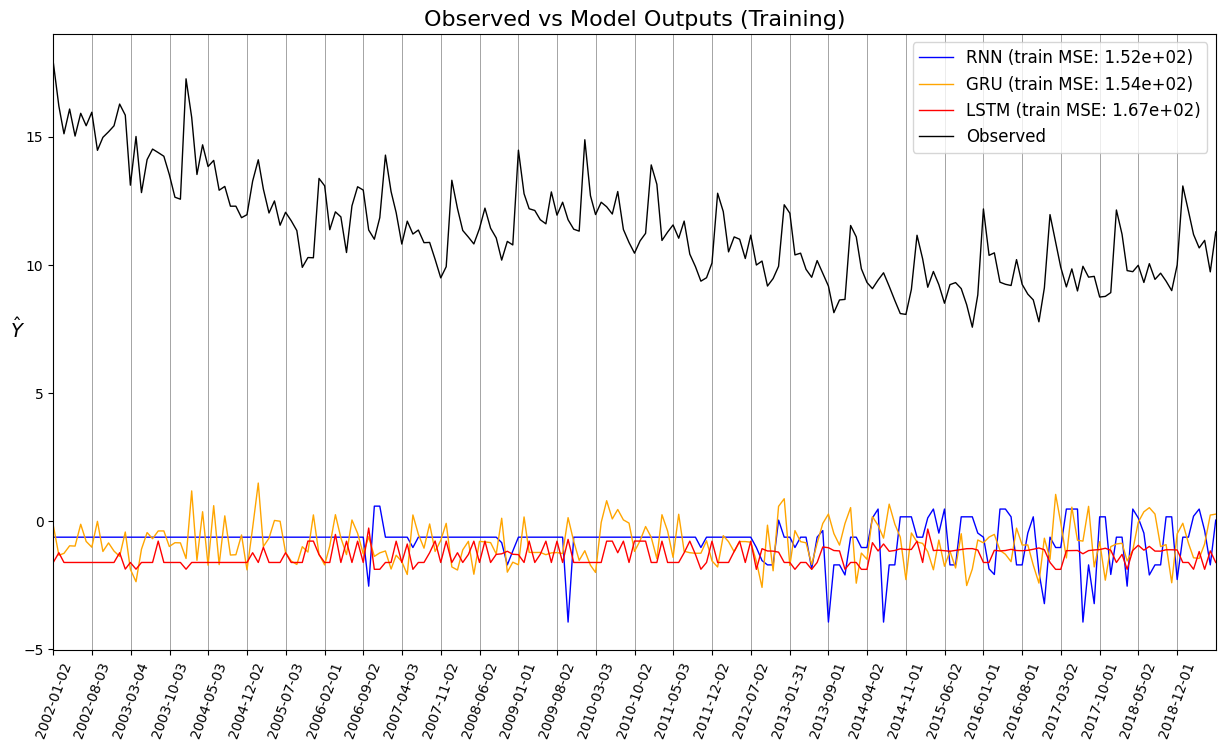

In [86]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params3[key]['pred_train'][l:u:ds]
    label = params3[key]['label'] + ' (train MSE: %.2e)' % params3[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params2[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

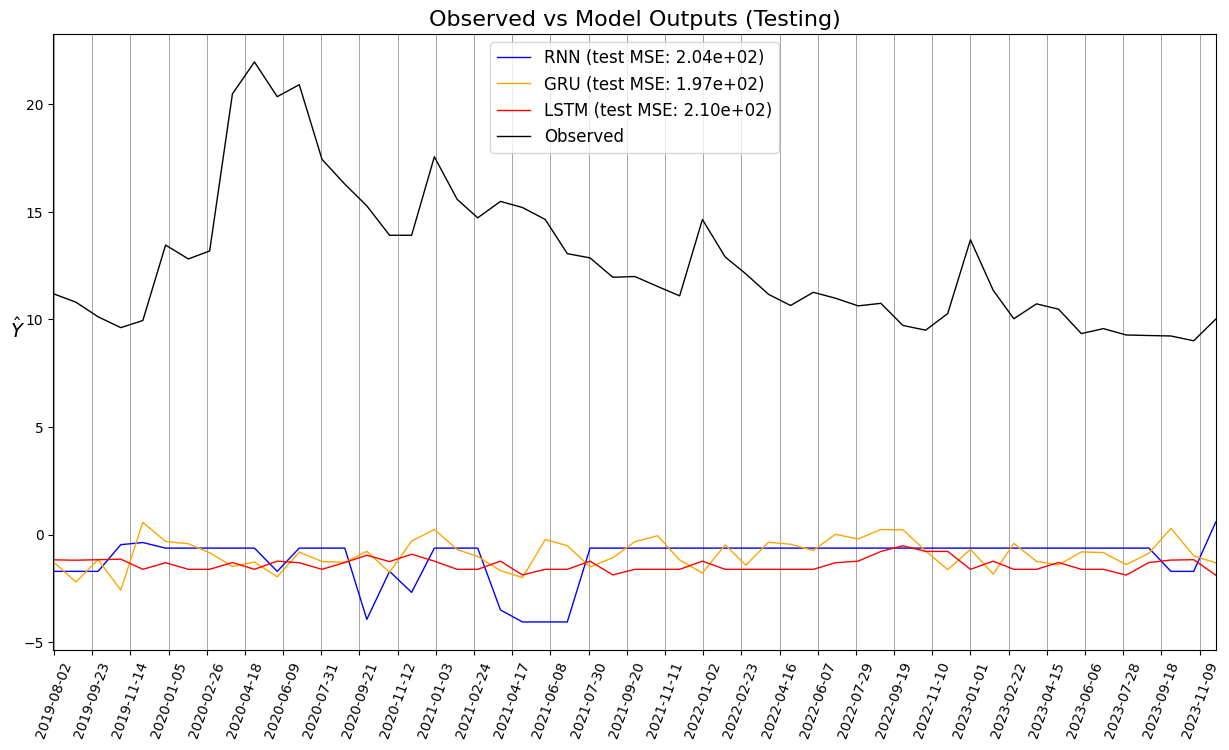

In [87]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params3[key]['pred_test'][l:u:ds]
    label = params3[key]['label'] + ' (test MSE: %.2e)' % params3[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params2[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

# MSE de las redes

In [88]:
print('Modelo sin covariables de estacionalidad')
for key in params.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params[key]['MSE_test'])
    
print('Modelo con covariables de estacionalidad dummy')
for key in params2.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params2[key]['MSE_test'])

print('Modelo con covariables de estacionalidad Componentes de Fourier')
for key in params3.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params3[key]['MSE_test'])

Modelo sin covariables de estacionalidad
El MSE de la red rnn en el conjunto de prueba es 139.85270827789708
El MSE de la red gru en el conjunto de prueba es 209.62178942483033
El MSE de la red lstm en el conjunto de prueba es 202.91266417677946
Modelo con covariables de estacionalidad dummy
El MSE de la red rnn en el conjunto de prueba es 203.87343851149123
El MSE de la red gru en el conjunto de prueba es 212.9692783435977
El MSE de la red lstm en el conjunto de prueba es 208.72764057221855
Modelo con covariables de estacionalidad Componentes de Fourier
El MSE de la red rnn en el conjunto de prueba es 203.599966261017
El MSE de la red gru en el conjunto de prueba es 197.452416644936
El MSE de la red lstm en el conjunto de prueba es 209.88345128290467
